In [1]:
# imports
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from pathlib import Path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm

In [2]:
from utils_train import (channeled_image_from_id, process_skeletonize, 
                         substitute_channels, apply_threshold, 
                         randomly_distribute, make_nonzero_dict)

## Equating Nonzero Counts

In [22]:
def get_nonzero_zero_pixel_locations(channel_flatten, median_number_of_pixels,
                                    image_size = (224, 224)):

    # array of nonzero and zero id locations
    
    nonzero_pixels = []
    zero_pixels = []
    
    for i in range(0, len(channel_flatten)):
        if channel_flatten[i] == 0:
            zero_pixels.append(i) # index value
        elif channel_flatten[i] != 0:
            nonzero_pixels.append(i)
    
    zero_pixels = np.array(zero_pixels)
    nonzero_pixels = np.array(nonzero_pixels)
                    
    assert(len(nonzero_pixels) + len(zero_pixels) == len(channel_flatten))
    
    return nonzero_pixels, zero_pixels

In [23]:
def average_pixel_count_random_images2(img_channel, median_number_of_pixels, # all images 224 x 224
                    image_size = (224, 224)):
    
    # random selection of removal/add means that relatively proportionate amount / pixel intensity is being added
    # since PIV values more present have higher chance of being selected
    
    print("------------------")
    channel_flatten = np.copy(np.array(img_channel.flatten()))
    
    assert (len(channel_flatten) == image_size[0] * image_size[1])
    
    num_nonzero_img = np.count_nonzero(img_channel) # num pixels in 1 channel
    pixels_to_modify = num_nonzero_img - median_number_of_pixels
    
    nonzero_pixels, zero_pixels = get_nonzero_zero_pixel_locations(channel_flatten, median_number_of_pixels)
    
    modified_channel_flatten = np.copy(channel_flatten)
    print(pixels_to_modify)
    
    if pixels_to_modify > 0: # remove pixels
        print('remove pixels')
        num_pixels_remove = pixels_to_modify # should be positive
        indexes = np.random.choice(len(nonzero_pixels), num_pixels_remove, replace=False)
        remove_pixel_indexes = nonzero_pixels[indexes]
        modified_channel_flatten[remove_pixel_indexes] = 0
    
    elif pixels_to_modify <= 0: # add pixels
        print('add pixels')
        # ok, for randomization. We'll have the image. 
        # We'll randomly choose a nonzero pixel and then duplicate it, storing that in another image (in a random location that is zero)
        # Then continue choosing from the image. 
        # Should randomly even out because selection of nonzero pixels to duplicate should be proportional
        
        num_pixels_add = abs(pixels_to_modify)
        nonzero_indexes = np.random.choice(len(nonzero_pixels), num_pixels_add, replace=True)
        zero_indexes = np.random.choice(len(zero_pixels), num_pixels_add, replace=False)
        
        substituted_pixel_indexes = nonzero_pixels[nonzero_indexes]
        zero_pixel_indexes = zero_pixels[zero_indexes]
        
        modified_channel_flatten[zero_pixel_indexes] = channel_flatten[substituted_pixel_indexes]
    
    reshapen_img = modified_channel_flatten.reshape(image_size)
    
    return reshapen_img  

# this seems to all check out!!

In [27]:
def randomly_distribute(img, skeleton, average_nonzero_pixels, median_number_of_pixels, brighten_sum, # can try with multiple brighten_sums
                       none_thresh = 0, image_size = (224, 224)): # getting rid of the complete black
    
    # for number of pixels we use non_skeletonized full_set + train/test/val sets.
    
    # sticking with none_thresh = 0 for now, brightening everything except the background. 
    # could try some thresholding on which pixels we brighten, or thresholding by zeroing some pixels.
    
    # resize/skeletonize first, and then random distribution  
    img, _ , modified_img = process_skeletonize(img, skeleton, image_size) # image size given
    
    # random distribution now 
    flattened_img = modified_img.flatten()
    random_img = np.random.permutation(flattened_img)
    modified_img2 = np.reshape(random_img, image_size)
    
    # averaging nonzero pixels
    if average_nonzero_pixels:
        print(np.count_nonzero(modified_img2))
        value_dict = pd.value_counts(modified_img2.flatten())
        
        modified_img3 = average_pixel_count_random_images2(modified_img2, median_number_of_pixels)
        
        value_dict_modified = pd.value_counts(modified_img3.flatten())
  
    elif not average_nonzero_pixels:
        modified_img3 = modified_img2
        
    # now for brightening code, will be brightening ALL pixels above 0/20? (above 0, brightening everything)
    
    modified_img4 = apply_threshold(modified_img3, 'add', none_thresh, brighten_sum, thresh_type = 'below') # yay default
      
    final_img = substitute_channels(img, modified_img3)

    return final_img, value_dict, value_dict_modified

In [28]:
dataset_path = "/users/riya/race/dataset/segmentations/"
img_path = "30672.bmp"

channels = channeled_image_from_id(dataset_path, img_path, (480, 640))

In [29]:
final_img, value_dict, value_dict_modified = randomly_distribute(channels, False, True, 20000, 0)

13954
------------------
-6046
add pixels


In [30]:
np.count_nonzero(final_img)

60000

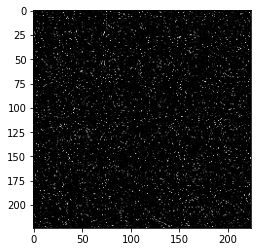

In [31]:
plt.imshow(final_img)

In [32]:
value_dict

0      36222
1       4206
2       1607
3       1019
4        677
       ...  
231        2
111        2
238        1
237        1
164        1
Length: 233, dtype: int64

In [33]:
value_dict_modified

0      30176
1       6040
2       2286
3       1462
4        943
       ...  
229        3
210        3
231        3
111        2
238        1
Length: 233, dtype: int64

In [18]:
nonzero_dict_train = make_nonzero_dict('train')

In [21]:
nonzero_dict_train

{'skeletonized_white': 4000.0,
 'skeletonized_black': 2677.0,
 'non-skeletonized_white': 13046.5,
 'non-skeletonized_black': 8615.0}

In [26]:
int((nonzero_dict_train['non-skeletonized_white'] + nonzero_dict_train['non-skeletonized_black'])/2)

10830

## Rewriting Pixel Check During Training Function (Because SLOW)

In [3]:
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [11]:
import timeit

In [4]:
nonzero_dict = make_nonzero_dict('full_set')
# number_of_pixels_train = int((nonzero_dict['non-skeletonized_white'] + nonzero_dict['non-skeletonized_black'])/2)
number_of_pixels_train = int(nonzero_dict['non-skeletonized_black'])
number_of_pixels_test = number_of_pixels_train
number_of_pixels_val = number_of_pixels_train

In [5]:
train_transforms = transforms.Compose([transforms.Lambda(lambda img: randomly_distribute(img, False, True, number_of_pixels_train, 0)), 
                                           # image size + none_thresh are pre-defined
                                           # transforms.Resize(image_size),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.RandomVerticalFlip(),
                                           transforms.RandomRotation(25),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.5, 0.5, 0.5],
                                                                [0.5, 0.5, 0.5])]) # why this normalizing?

In [6]:
data_dir = "/users/riya/race/classifier_experiments/CNN_train/dataset_full"
train_folder = os.path.join(data_dir, 'train')

In [7]:
train_dataset = datasets.ImageFolder(train_folder, train_transforms)

In [8]:
def nonzero_pixel_check_during_training(data_loader):
    black_non_zero = [0]
    white_non_zero = [0]
    
    tmp = iter(data_loader)
    num_iterations = len(data_loader.samples)

    for i in tqdm(range(num_iterations)):
        image, label = next(tmp)   
        run_img = np.array(image)[:,:,0] # not sure where equal median number comes from? Ohh prob different/lower because normalizing.
        num_nonzero = int(np.count_nonzero(run_img))

        if label == 0:
            black_non_zero = np.append(black_non_zero, num_nonzero)
        elif label == 1:
            white_non_zero = np.append(white_non_zero, num_nonzero)

    black_non_zero = black_non_zero[1:]
    white_non_zero = white_non_zero[1:]
    
    return (np.median(black_non_zero), np.median(white_non_zero))

In [55]:
for (_, img_info) in tqdm(enumerate(train_dataset)):
    print (img_info[0][:,:,0])

1it [00:00,  3.95it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9765, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.7961, -1.0000, -0.9922,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9843, -1.0000, -1.0000, -1.0000,
         -1.0000,  0.6471, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.7725, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9608, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922,
         -1.0000, -1.0000, -0.9451, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

2it [00:00,  4.07it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9922, -1.0000, -0.9843, -1.0000, -0.8667, -1.0000, -1.0000, -0.9922,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.7961, -0.3490, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9922, -1.0000, -0.9843, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9922, -1.0000, -1.0000, -0.6941, -1.0000, -1.0000,
         -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8667,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -0.9922,
         -1.0000, -1.0000, -

3it [00:00,  4.13it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.7804,
         -1.0000, -0.9922, -0.4980, -0.9922, -1.0000, -0.7412, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.8275, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9765, -1.0000,
         -0.9765, -1.0000, -0.8824, -1.0000, -0.9922, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9843, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -0.9843, -1.0000,
          0.6706, -1.0000, -

4it [00:00,  4.13it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9451, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.8353, -1.0000, -1.0000, -1.0000, -0.9843, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9765, -1.0000, -1.0000, -0.9686, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000,  0.1765, -1.0000, -0.9373, -1.0000,
         -0.9922, -1.0000, -1.0000, -1.0000, -0.9843, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.2392, -1.0000, -1.0000,
         -0.9922, -1.0000, -0.9922, -1.0000, -1.0000, -1.0000, -0.9765, -1.0000,
         -0.7255, -0.9137, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

5it [00:01,  4.08it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

6it [00:01,  4.14it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

7it [00:01,  4.11it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.8745, -1.0000, -0.1529, -1.0000, -1.0000,
         -1.0000, -0.9608, -

8it [00:01,  4.21it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.8510, -1.0000, -0.9922, -1.0000,
         -1.0000, -1.0000, -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.7569, -1.0000, -1.0000, -0.9686, -0.9843, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9137,
         -0.0824, -1.0000, -0.9765, -1.0000, -0.9765, -1.0000, -1.0000, -0.6784,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922,
         -0.9922, -1.0000, -1.0000, -0.9765, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9765, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

9it [00:02,  4.24it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9686, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9843, -0.9843, -0.9922, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.7961,  0.2471,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -0.9922, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.7176, -0.8980, -1.0000, -1.0000, -1.0000,
         -0.9922, -1.0000, -1.0000, -1.0000, -0.9451, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9373, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9529, -1.0000,
         -1.0000, -1.0000, -

10it [00:02,  4.25it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

11it [00:02,  4.19it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.7020, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.4431, -

12it [00:02,  4.26it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -0.9765, -1.0000,
         -1.0000, -1.0000, -

13it [00:03,  4.28it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

14it [00:03,  4.29it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.8039, -0.9922, -0.9922, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9294, -1.0000, -1.0000, -1.0000, -1.0000, -0.9451,
         -1.0000, -0.9843, -0.8745, -1.0000, -1.0000, -0.9686, -1.0000, -0.9922,
         -0.9922, -1.0000, -

15it [00:03,  4.28it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

16it [00:03,  4.16it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.7412, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.7725, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9843, -0.9843, -1.0000, -0.9922, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9608, -1.0000, -0.9608, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.4275, -1.0000,
         -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.7804, -1.0000, -

17it [00:04,  4.09it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

18it [00:04,  4.20it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -1.0000,
         -1.0000, -0.7804, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9843, -1.0000, -1.0000, -0.9529, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.7882, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922,
          0.1843, -1.0000, -1.0000, -1.0000, -1.0000,  0.3412, -1.0000, -1.0000,
         -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9608, -1.0000, -0.9608, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922,
         -1.0000, -1.0000, -

19it [00:04,  4.18it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

20it [00:04,  4.05it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9922, -1.0000, -1.0000, -1.0000, -1.0000, -0.6392, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.8824,
         -1.0000, -1.0000, -0.9294, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.5843, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9922, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9373, -1.0000, -0.9922, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9529, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

21it [00:05,  4.06it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9922, -1.0000, -1.0000, -0.9137, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.8745, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9843, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9765, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9765, -1.0000, -1.0000, -1.0000, -0.4902,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9922,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

22it [00:05,  4.05it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

23it [00:05,  4.14it/s]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

KeyboardInterrupt: 

In [19]:
def fast_nonzero_pixel_check_during_training(data_loader):
    black_non_zero = []
    white_non_zero = []

    
    num_iterations = len(data_loader.samples)

    for i in tqdm(range(num_iterations)):
            
        start = timeit.default_timer()
        image = data_loader[i][0]
        label = data_loader[i][1]
        
        stop
            
        run_img = np.array(image)[:,:,0] # one channel
        num_nonzero = int(np.count_nonzero(run_img))

            
        # stop2 = timeit.default_timer()

        if label == 0:
            black_non_zero.append(num_nonzero)
        elif label == 1:
            white_non_zero.append(num_nonzero)
            
        # stop3 = timeit.default_timer()
        
        print(stop1 - start, stop2-stop1)
    
    return (np.median(black_non_zero), np.median(white_non_zero))

In [58]:
def fast_nonzero_pixel_check_during_training2(data_loader):
    black_non_zero = []
    white_non_zero = []
    
    for (_, img_info) in tqdm(enumerate(data_loader)):
        
        start = timeit.default_timer()

        image = img_info[0]
        label = img_info[1]

        run_img = image[:,:,0] # one channel
        num_nonzero = int(np.count_nonzero(run_img))

        if label == 0:
            black_non_zero.append(num_nonzero)
        elif label == 1:
            white_non_zero.append(num_nonzero)
                
    return (np.median(black_non_zero), np.median(white_non_zero))

In [ ]:
def fast_nonzero_pixel_check_during_training3(data_loader):
    black_non_zero = []
    white_non_zero = []
    
    for (_, img_info) in tqdm(enumerate(data_loader)):
        
        start = timeit.default_timer()

        image = img_info[0]
        label = img_info[1]

        run_img = image[:,:,0] # one channel
        num_nonzero = int(np.count_nonzero(run_img))

        if label == 0:
            black_non_zero.append(num_nonzero)
        elif label == 1:
            white_non_zero.append(num_nonzero)
                
    return (np.median(black_non_zero), np.median(white_non_zero))

In [ ]:
train_tuple = fast_nonzero_pixel_check_during_training2(train_dataset)

163it [00:37,  4.29it/s]

In [15]:
train_tuple = fast_nonzero_pixel_check_during_training(train_dataset)

  0%|          | 1/3181 [00:00<26:50,  1.97it/s]

0.2554553360096179 0.2507617559749633


  0%|          | 2/3181 [00:00<26:24,  2.01it/s]

0.24037365999538451 0.25034568802220747


  0%|          | 3/3181 [00:01<25:25,  2.08it/s]

0.23051879802369513 0.22643455199431628


  0%|          | 4/3181 [00:01<25:48,  2.05it/s]

0.24760589702054858 0.25003032697713934


  0%|          | 5/3181 [00:02<26:02,  2.03it/s]

0.2418647769954987 0.25713891501072794


  0%|          | 6/3181 [00:02<26:23,  2.01it/s]

0.25467779699829407 0.2562982249946799


  0%|          | 6/3181 [00:03<30:27,  1.74it/s]


KeyboardInterrupt: 

In [35]:
train_tuple = nonzero_pixel_check_during_training(train_dataset)

  0%|          | 1/3181 [00:00<12:34,  4.21it/s]

modified_pixels: 4916 , nonzero_pixels: 13619


  0%|          | 2/3181 [00:00<11:52,  4.46it/s]

modified_pixels: 1159 , nonzero_pixels: 7544 , zero_pixels: 42632


  0%|          | 3/3181 [00:00<11:37,  4.55it/s]

modified_pixels: 282 , nonzero_pixels: 8985
modified_pixels: 4961 , nonzero_pixels: 13664


  0%|          | 5/3181 [00:01<11:28,  4.61it/s]

modified_pixels: 3248 , nonzero_pixels: 5455 , zero_pixels: 44721


  0%|          | 6/3181 [00:01<11:21,  4.66it/s]

modified_pixels: 2260 , nonzero_pixels: 6443 , zero_pixels: 43733
modified_pixels: 2948 , nonzero_pixels: 5755 , zero_pixels: 44421


  0%|          | 8/3181 [00:01<11:16,  4.69it/s]

modified_pixels: 403 , nonzero_pixels: 9106


  0%|          | 9/3181 [00:01<11:20,  4.66it/s]

modified_pixels: 4409 , nonzero_pixels: 4294 , zero_pixels: 45882


  0%|          | 10/3181 [00:02<11:11,  4.72it/s]

modified_pixels: 4117 , nonzero_pixels: 4586 , zero_pixels: 45590
modified_pixels: 2598 , nonzero_pixels: 11301


  0%|          | 12/3181 [00:02<11:09,  4.73it/s]

modified_pixels: 654 , nonzero_pixels: 8049 , zero_pixels: 42127
modified_pixels: 3524 , nonzero_pixels: 5179 , zero_pixels: 44997


  0%|          | 14/3181 [00:03<11:15,  4.69it/s]

modified_pixels: 1487 , nonzero_pixels: 7216 , zero_pixels: 42960


  0%|          | 15/3181 [00:03<11:06,  4.75it/s]

modified_pixels: 4353 , nonzero_pixels: 4350 , zero_pixels: 45826


  1%|          | 16/3181 [00:03<11:11,  4.71it/s]

modified_pixels: 987 , nonzero_pixels: 9690


  1%|          | 17/3181 [00:03<11:08,  4.74it/s]

modified_pixels: 2804 , nonzero_pixels: 5899 , zero_pixels: 44277
modified_pixels: 576 , nonzero_pixels: 8127 , zero_pixels: 42049


  1%|          | 19/3181 [00:04<11:00,  4.79it/s]

modified_pixels: 5198 , nonzero_pixels: 3505 , zero_pixels: 46671


  1%|          | 20/3181 [00:04<11:01,  4.78it/s]

modified_pixels: 931 , nonzero_pixels: 7772 , zero_pixels: 42404
modified_pixels: 3943 , nonzero_pixels: 4760 , zero_pixels: 45416


  1%|          | 22/3181 [00:04<11:17,  4.66it/s]

modified_pixels: 2901 , nonzero_pixels: 5802 , zero_pixels: 44374


  1%|          | 23/3181 [00:04<11:10,  4.71it/s]

modified_pixels: 5071 , nonzero_pixels: 3632 , zero_pixels: 46544


  1%|          | 24/3181 [00:05<11:09,  4.71it/s]

modified_pixels: 157 , nonzero_pixels: 8860


  1%|          | 26/3181 [00:05<11:03,  4.75it/s]

modified_pixels: 3411 , nonzero_pixels: 5292 , zero_pixels: 44884
modified_pixels: 1596 , nonzero_pixels: 10299


  1%|          | 28/3181 [00:05<10:55,  4.81it/s]

modified_pixels: 4405 , nonzero_pixels: 4298 , zero_pixels: 45878
modified_pixels: 4034 , nonzero_pixels: 4669 , zero_pixels: 45507


  1%|          | 29/3181 [00:06<10:56,  4.80it/s]

modified_pixels: 2020 , nonzero_pixels: 6683 , zero_pixels: 43493
modified_pixels: 3191 , nonzero_pixels: 5512 , zero_pixels: 44664


  1%|          | 31/3181 [00:06<11:02,  4.76it/s]

modified_pixels: 98 , nonzero_pixels: 8801


  1%|          | 32/3181 [00:06<11:04,  4.74it/s]

modified_pixels: 996 , nonzero_pixels: 7707 , zero_pixels: 42469
modified_pixels: 2316 , nonzero_pixels: 11019


  1%|          | 34/3181 [00:07<11:02,  4.75it/s]

modified_pixels: 1258 , nonzero_pixels: 7445 , zero_pixels: 42731


  1%|          | 35/3181 [00:07<10:59,  4.77it/s]

modified_pixels: 3862 , nonzero_pixels: 4841 , zero_pixels: 45335


  1%|          | 37/3181 [00:07<10:59,  4.77it/s]

modified_pixels: 290 , nonzero_pixels: 8413 , zero_pixels: 41763
modified_pixels: 3949 , nonzero_pixels: 4754 , zero_pixels: 45422


  1%|          | 38/3181 [00:08<10:54,  4.80it/s]

modified_pixels: 3914 , nonzero_pixels: 4789 , zero_pixels: 45387
modified_pixels: 2352 , nonzero_pixels: 6351 , zero_pixels: 43825


  1%|▏         | 40/3181 [00:08<11:03,  4.73it/s]

modified_pixels: 3701 , nonzero_pixels: 5002 , zero_pixels: 45174


  1%|▏         | 41/3181 [00:08<11:14,  4.66it/s]

modified_pixels: 3209 , nonzero_pixels: 5494 , zero_pixels: 44682


  1%|▏         | 42/3181 [00:08<11:05,  4.71it/s]

modified_pixels: 4426 , nonzero_pixels: 4277 , zero_pixels: 45899


  1%|▏         | 43/3181 [00:09<11:03,  4.73it/s]

modified_pixels: 1006 , nonzero_pixels: 7697 , zero_pixels: 42479
modified_pixels: 2312 , nonzero_pixels: 6391 , zero_pixels: 43785


  1%|▏         | 45/3181 [00:09<11:09,  4.68it/s]

modified_pixels: 3446 , nonzero_pixels: 5257 , zero_pixels: 44919


  1%|▏         | 46/3181 [00:09<11:01,  4.74it/s]

modified_pixels: 4209 , nonzero_pixels: 4494 , zero_pixels: 45682
modified_pixels: 3102 , nonzero_pixels: 5601 , zero_pixels: 44575


  2%|▏         | 48/3181 [00:10<10:58,  4.76it/s]

modified_pixels: 2521 , nonzero_pixels: 6182 , zero_pixels: 43994


  2%|▏         | 49/3181 [00:10<11:02,  4.73it/s]

modified_pixels: 6187 , nonzero_pixels: 2516 , zero_pixels: 47660


  2%|▏         | 50/3181 [00:10<11:06,  4.70it/s]

modified_pixels: 1535 , nonzero_pixels: 7168 , zero_pixels: 43008
modified_pixels: 3677 , nonzero_pixels: 5026 , zero_pixels: 45150


  2%|▏         | 52/3181 [00:11<10:59,  4.75it/s]

modified_pixels: 1619 , nonzero_pixels: 7084 , zero_pixels: 43092


  2%|▏         | 53/3181 [00:11<10:57,  4.76it/s]

modified_pixels: 2933 , nonzero_pixels: 5770 , zero_pixels: 44406
modified_pixels: 3756 , nonzero_pixels: 4947 , zero_pixels: 45229


  2%|▏         | 55/3181 [00:11<10:55,  4.77it/s]

modified_pixels: 643 , nonzero_pixels: 8060 , zero_pixels: 42116


  2%|▏         | 56/3181 [00:11<11:00,  4.73it/s]

modified_pixels: 1521 , nonzero_pixels: 10224


  2%|▏         | 58/3181 [00:12<11:00,  4.73it/s]

modified_pixels: 2374 , nonzero_pixels: 6329 , zero_pixels: 43847
modified_pixels: 1268 , nonzero_pixels: 9971


  2%|▏         | 59/3181 [00:12<11:05,  4.69it/s]

modified_pixels: 3612 , nonzero_pixels: 12315


  2%|▏         | 60/3181 [00:12<11:06,  4.68it/s]

modified_pixels: 4324 , nonzero_pixels: 13027


  2%|▏         | 61/3181 [00:12<11:06,  4.68it/s]

modified_pixels: 1430 , nonzero_pixels: 10133


  2%|▏         | 62/3181 [00:13<11:06,  4.68it/s]

modified_pixels: 2434 , nonzero_pixels: 11137
modified_pixels: 1778 , nonzero_pixels: 10481


  2%|▏         | 64/3181 [00:13<11:03,  4.70it/s]

modified_pixels: 530 , nonzero_pixels: 9233


  2%|▏         | 65/3181 [00:13<11:00,  4.72it/s]

modified_pixels: 609 , nonzero_pixels: 8094 , zero_pixels: 42082
modified_pixels: 2805 , nonzero_pixels: 11508


  2%|▏         | 67/3181 [00:14<10:59,  4.72it/s]

modified_pixels: 1421 , nonzero_pixels: 7282 , zero_pixels: 42894


  2%|▏         | 68/3181 [00:14<10:57,  4.74it/s]

modified_pixels: 2327 , nonzero_pixels: 6376 , zero_pixels: 43800


  2%|▏         | 69/3181 [00:14<10:59,  4.72it/s]

modified_pixels: 848 , nonzero_pixels: 9551
modified_pixels: 2289 , nonzero_pixels: 6414 , zero_pixels: 43762


  2%|▏         | 71/3181 [00:15<10:48,  4.80it/s]

modified_pixels: 5167 , nonzero_pixels: 3536 , zero_pixels: 46640


  2%|▏         | 72/3181 [00:15<10:49,  4.79it/s]

modified_pixels: 1799 , nonzero_pixels: 6904 , zero_pixels: 43272
modified_pixels: 3692 , nonzero_pixels: 5011 , zero_pixels: 45165


  2%|▏         | 74/3181 [00:15<10:51,  4.77it/s]

modified_pixels: 1609 , nonzero_pixels: 7094 , zero_pixels: 43082


  2%|▏         | 75/3181 [00:15<10:57,  4.73it/s]

modified_pixels: 2054 , nonzero_pixels: 6649 , zero_pixels: 43527
modified_pixels: 3308 , nonzero_pixels: 5395 , zero_pixels: 44781


  2%|▏         | 77/3181 [00:16<10:54,  4.74it/s]

modified_pixels: 1774 , nonzero_pixels: 6929 , zero_pixels: 43247


  2%|▏         | 78/3181 [00:16<10:57,  4.72it/s]

modified_pixels: 1933 , nonzero_pixels: 6770 , zero_pixels: 43406


  2%|▏         | 79/3181 [00:16<10:54,  4.74it/s]

modified_pixels: 2374 , nonzero_pixels: 6329 , zero_pixels: 43847
modified_pixels: 5440 , nonzero_pixels: 3263 , zero_pixels: 46913


  3%|▎         | 81/3181 [00:17<10:41,  4.83it/s]

modified_pixels: 5630 , nonzero_pixels: 3073 , zero_pixels: 47103


  3%|▎         | 82/3181 [00:17<10:41,  4.83it/s]

modified_pixels: 3342 , nonzero_pixels: 5361 , zero_pixels: 44815


  3%|▎         | 83/3181 [00:17<10:40,  4.84it/s]

modified_pixels: 4564 , nonzero_pixels: 4139 , zero_pixels: 46037


  3%|▎         | 84/3181 [00:17<10:36,  4.86it/s]

modified_pixels: 6208 , nonzero_pixels: 2495 , zero_pixels: 47681


  3%|▎         | 85/3181 [00:17<10:40,  4.83it/s]

modified_pixels: 3747 , nonzero_pixels: 4956 , zero_pixels: 45220


  3%|▎         | 86/3181 [00:18<10:39,  4.84it/s]

modified_pixels: 4675 , nonzero_pixels: 4028 , zero_pixels: 46148


  3%|▎         | 87/3181 [00:18<10:58,  4.70it/s]

modified_pixels: 3412 , nonzero_pixels: 12115


  3%|▎         | 88/3181 [00:18<10:57,  4.70it/s]

modified_pixels: 3682 , nonzero_pixels: 5021 , zero_pixels: 45155


  3%|▎         | 89/3181 [00:18<11:47,  4.37it/s]

modified_pixels: 3307 , nonzero_pixels: 5396 , zero_pixels: 44780


  3%|▎         | 90/3181 [00:19<12:20,  4.17it/s]

modified_pixels: 4302 , nonzero_pixels: 4401 , zero_pixels: 45775


  3%|▎         | 91/3181 [00:19<12:57,  3.98it/s]

modified_pixels: 2467 , nonzero_pixels: 6236 , zero_pixels: 43940


  3%|▎         | 92/3181 [00:19<13:14,  3.89it/s]

modified_pixels: 3597 , nonzero_pixels: 5106 , zero_pixels: 45070


  3%|▎         | 93/3181 [00:19<13:29,  3.82it/s]

modified_pixels: 1821 , nonzero_pixels: 6882 , zero_pixels: 43294


  3%|▎         | 94/3181 [00:20<13:20,  3.85it/s]

modified_pixels: 2349 , nonzero_pixels: 6354 , zero_pixels: 43822


  3%|▎         | 95/3181 [00:20<13:47,  3.73it/s]

modified_pixels: 3914 , nonzero_pixels: 4789 , zero_pixels: 45387


  3%|▎         | 96/3181 [00:20<13:55,  3.69it/s]

modified_pixels: 5818 , nonzero_pixels: 2885 , zero_pixels: 47291


  3%|▎         | 97/3181 [00:21<13:49,  3.72it/s]

modified_pixels: 2812 , nonzero_pixels: 5891 , zero_pixels: 44285


  3%|▎         | 98/3181 [00:21<13:47,  3.73it/s]

modified_pixels: 4920 , nonzero_pixels: 3783 , zero_pixels: 46393


  3%|▎         | 99/3181 [00:21<13:42,  3.75it/s]

modified_pixels: 6412 , nonzero_pixels: 2291 , zero_pixels: 47885


  3%|▎         | 100/3181 [00:21<13:37,  3.77it/s]

modified_pixels: 4564 , nonzero_pixels: 4139 , zero_pixels: 46037


  3%|▎         | 101/3181 [00:22<13:26,  3.82it/s]

modified_pixels: 2436 , nonzero_pixels: 6267 , zero_pixels: 43909


  3%|▎         | 102/3181 [00:22<13:40,  3.75it/s]

modified_pixels: 306 , nonzero_pixels: 8397 , zero_pixels: 41779


  3%|▎         | 103/3181 [00:22<13:47,  3.72it/s]

modified_pixels: 4353 , nonzero_pixels: 4350 , zero_pixels: 45826


  3%|▎         | 104/3181 [00:22<13:32,  3.79it/s]

modified_pixels: 5535 , nonzero_pixels: 3168 , zero_pixels: 47008


  3%|▎         | 105/3181 [00:23<13:40,  3.75it/s]

modified_pixels: 1474 , nonzero_pixels: 10177


  3%|▎         | 106/3181 [00:23<14:01,  3.65it/s]

modified_pixels: 6579 , nonzero_pixels: 2124 , zero_pixels: 48052


  3%|▎         | 107/3181 [00:23<14:05,  3.64it/s]

modified_pixels: 1529 , nonzero_pixels: 10232


  3%|▎         | 108/3181 [00:23<13:56,  3.67it/s]

modified_pixels: 399 , nonzero_pixels: 8304 , zero_pixels: 41872


  3%|▎         | 109/3181 [00:24<14:08,  3.62it/s]

modified_pixels: 582 , nonzero_pixels: 9285


  3%|▎         | 110/3181 [00:24<13:47,  3.71it/s]

modified_pixels: 3201 , nonzero_pixels: 5502 , zero_pixels: 44674


  3%|▎         | 111/3181 [00:24<13:30,  3.79it/s]

modified_pixels: 2413 , nonzero_pixels: 6290 , zero_pixels: 43886


  4%|▎         | 112/3181 [00:25<13:13,  3.87it/s]

modified_pixels: 2327 , nonzero_pixels: 6376 , zero_pixels: 43800


  4%|▎         | 113/3181 [00:25<13:22,  3.82it/s]

modified_pixels: 5644 , nonzero_pixels: 3059 , zero_pixels: 47117


  4%|▎         | 114/3181 [00:25<13:29,  3.79it/s]

modified_pixels: 3392 , nonzero_pixels: 5311 , zero_pixels: 44865


  4%|▎         | 115/3181 [00:25<13:37,  3.75it/s]

modified_pixels: 2270 , nonzero_pixels: 6433 , zero_pixels: 43743


  4%|▎         | 116/3181 [00:26<13:06,  3.90it/s]

modified_pixels: 4382 , nonzero_pixels: 4321 , zero_pixels: 45855


  4%|▎         | 117/3181 [00:26<12:54,  3.96it/s]

modified_pixels: 428 , nonzero_pixels: 8275 , zero_pixels: 41901


  4%|▎         | 118/3181 [00:26<12:26,  4.10it/s]

modified_pixels: 801 , nonzero_pixels: 7902 , zero_pixels: 42274


  4%|▎         | 119/3181 [00:26<12:34,  4.06it/s]

modified_pixels: 4442 , nonzero_pixels: 4261 , zero_pixels: 45915


  4%|▍         | 120/3181 [00:27<13:04,  3.90it/s]

modified_pixels: 774 , nonzero_pixels: 7929 , zero_pixels: 42247


  4%|▍         | 121/3181 [00:27<13:00,  3.92it/s]

modified_pixels: 2374 , nonzero_pixels: 6329 , zero_pixels: 43847


  4%|▍         | 122/3181 [00:27<12:24,  4.11it/s]

modified_pixels: 5576 , nonzero_pixels: 3127 , zero_pixels: 47049


  4%|▍         | 123/3181 [00:27<13:03,  3.90it/s]

modified_pixels: 883 , nonzero_pixels: 7820 , zero_pixels: 42356


  4%|▍         | 124/3181 [00:28<12:44,  4.00it/s]

modified_pixels: 813 , nonzero_pixels: 7890 , zero_pixels: 42286


  4%|▍         | 125/3181 [00:28<13:03,  3.90it/s]

modified_pixels: 5125 , nonzero_pixels: 13828


  4%|▍         | 126/3181 [00:28<13:44,  3.70it/s]

modified_pixels: 2801 , nonzero_pixels: 11504


  4%|▍         | 127/3181 [00:28<14:19,  3.55it/s]

modified_pixels: 4476 , nonzero_pixels: 13179


  4%|▍         | 128/3181 [00:29<13:20,  3.81it/s]

modified_pixels: 2155 , nonzero_pixels: 10858


  4%|▍         | 129/3181 [00:29<13:38,  3.73it/s]

modified_pixels: 5916 , nonzero_pixels: 2787 , zero_pixels: 47389


  4%|▍         | 130/3181 [00:29<13:09,  3.86it/s]

modified_pixels: 1928 , nonzero_pixels: 6775 , zero_pixels: 43401


  4%|▍         | 131/3181 [00:29<12:30,  4.07it/s]

modified_pixels: 869 , nonzero_pixels: 7834 , zero_pixels: 42342


  4%|▍         | 132/3181 [00:30<13:02,  3.89it/s]

modified_pixels: 283 , nonzero_pixels: 8420 , zero_pixels: 41756
modified_pixels: 1048 , nonzero_pixels: 7655 , zero_pixels: 42521


  4%|▍         | 134/3181 [00:30<12:49,  3.96it/s]

modified_pixels: 437 , nonzero_pixels: 9140


  4%|▍         | 135/3181 [00:30<12:46,  3.98it/s]

modified_pixels: 94 , nonzero_pixels: 8797


  4%|▍         | 136/3181 [00:31<13:05,  3.88it/s]

modified_pixels: 309 , nonzero_pixels: 8394 , zero_pixels: 41782


  4%|▍         | 137/3181 [00:31<13:12,  3.84it/s]

modified_pixels: 1430 , nonzero_pixels: 10133


  4%|▍         | 138/3181 [00:31<12:55,  3.93it/s]

modified_pixels: 5116 , nonzero_pixels: 3587 , zero_pixels: 46589


  4%|▍         | 139/3181 [00:31<12:20,  4.11it/s]

modified_pixels: 3428 , nonzero_pixels: 5275 , zero_pixels: 44901


  4%|▍         | 140/3181 [00:32<12:02,  4.21it/s]

modified_pixels: 2216 , nonzero_pixels: 6487 , zero_pixels: 43689


  4%|▍         | 141/3181 [00:32<12:26,  4.07it/s]

modified_pixels: 4172 , nonzero_pixels: 4531 , zero_pixels: 45645


  4%|▍         | 142/3181 [00:32<12:27,  4.06it/s]

modified_pixels: 3913 , nonzero_pixels: 4790 , zero_pixels: 45386


  4%|▍         | 143/3181 [00:32<12:26,  4.07it/s]

modified_pixels: 2476 , nonzero_pixels: 11179


  5%|▍         | 144/3181 [00:33<12:49,  3.95it/s]

modified_pixels: 2023 , nonzero_pixels: 10726


  5%|▍         | 145/3181 [00:33<13:11,  3.83it/s]

modified_pixels: 8815 , nonzero_pixels: 17518


  5%|▍         | 146/3181 [00:33<13:07,  3.85it/s]

modified_pixels: 123 , nonzero_pixels: 8826


  5%|▍         | 147/3181 [00:33<13:25,  3.76it/s]

modified_pixels: 2263 , nonzero_pixels: 10966


  5%|▍         | 148/3181 [00:34<13:20,  3.79it/s]

modified_pixels: 200 , nonzero_pixels: 8503 , zero_pixels: 41673


  5%|▍         | 149/3181 [00:34<13:25,  3.77it/s]

modified_pixels: 1026 , nonzero_pixels: 7677 , zero_pixels: 42499


  5%|▍         | 150/3181 [00:34<13:42,  3.69it/s]

modified_pixels: 1119 , nonzero_pixels: 7584 , zero_pixels: 42592


  5%|▍         | 151/3181 [00:35<13:46,  3.67it/s]

modified_pixels: 4605 , nonzero_pixels: 13308


  5%|▍         | 152/3181 [00:35<13:28,  3.74it/s]

modified_pixels: 7027 , nonzero_pixels: 15730


  5%|▍         | 153/3181 [00:35<13:11,  3.82it/s]

modified_pixels: 10391 , nonzero_pixels: 19094


  5%|▍         | 154/3181 [00:35<13:34,  3.72it/s]

modified_pixels: 9940 , nonzero_pixels: 18643


  5%|▍         | 155/3181 [00:36<13:41,  3.68it/s]

modified_pixels: 7513 , nonzero_pixels: 16216


  5%|▍         | 156/3181 [00:36<14:05,  3.58it/s]

modified_pixels: 9845 , nonzero_pixels: 18548


  5%|▍         | 157/3181 [00:36<14:10,  3.56it/s]

modified_pixels: 8751 , nonzero_pixels: 17454


  5%|▍         | 158/3181 [00:36<13:58,  3.60it/s]

modified_pixels: 4961 , nonzero_pixels: 13664


  5%|▍         | 159/3181 [00:37<13:34,  3.71it/s]

modified_pixels: 6049 , nonzero_pixels: 14752


  5%|▌         | 160/3181 [00:37<13:19,  3.78it/s]

modified_pixels: 2042 , nonzero_pixels: 6661 , zero_pixels: 43515


  5%|▌         | 161/3181 [00:37<13:11,  3.81it/s]

modified_pixels: 1783 , nonzero_pixels: 10486


  5%|▌         | 162/3181 [00:38<13:21,  3.77it/s]

modified_pixels: 2289 , nonzero_pixels: 6414 , zero_pixels: 43762


  5%|▌         | 163/3181 [00:38<13:09,  3.82it/s]

modified_pixels: 2445 , nonzero_pixels: 6258 , zero_pixels: 43918


  5%|▌         | 164/3181 [00:38<13:14,  3.80it/s]

modified_pixels: 4700 , nonzero_pixels: 4003 , zero_pixels: 46173


  5%|▌         | 165/3181 [00:38<13:11,  3.81it/s]

modified_pixels: 4279 , nonzero_pixels: 4424 , zero_pixels: 45752


  5%|▌         | 166/3181 [00:39<13:16,  3.79it/s]

modified_pixels: 5724 , nonzero_pixels: 14427


  5%|▌         | 167/3181 [00:39<13:27,  3.73it/s]

modified_pixels: 5063 , nonzero_pixels: 13766


  5%|▌         | 168/3181 [00:39<13:54,  3.61it/s]

modified_pixels: 9259 , nonzero_pixels: 17962


  5%|▌         | 169/3181 [00:39<14:13,  3.53it/s]

modified_pixels: 8525 , nonzero_pixels: 17228


  5%|▌         | 170/3181 [00:40<14:02,  3.58it/s]

modified_pixels: 6534 , nonzero_pixels: 15237


  5%|▌         | 171/3181 [00:40<13:45,  3.65it/s]

modified_pixels: 6071 , nonzero_pixels: 14774


  5%|▌         | 172/3181 [00:40<13:41,  3.66it/s]

modified_pixels: 5923 , nonzero_pixels: 14626


  5%|▌         | 173/3181 [00:41<13:34,  3.69it/s]

modified_pixels: 8097 , nonzero_pixels: 16800


  5%|▌         | 174/3181 [00:41<13:40,  3.67it/s]

modified_pixels: 1976 , nonzero_pixels: 10679


  6%|▌         | 175/3181 [00:41<13:30,  3.71it/s]

modified_pixels: 1305 , nonzero_pixels: 10008


  6%|▌         | 176/3181 [00:41<15:20,  3.27it/s]

modified_pixels: 579 , nonzero_pixels: 9282


  6%|▌         | 177/3181 [00:42<14:22,  3.48it/s]

modified_pixels: 6389 , nonzero_pixels: 15092


  6%|▌         | 178/3181 [00:42<13:41,  3.66it/s]

modified_pixels: 694 , nonzero_pixels: 8009 , zero_pixels: 42167


  6%|▌         | 179/3181 [00:42<13:38,  3.67it/s]

modified_pixels: 9900 , nonzero_pixels: 18603


  6%|▌         | 180/3181 [00:42<13:48,  3.62it/s]

modified_pixels: 4003 , nonzero_pixels: 12706


  6%|▌         | 181/3181 [00:43<13:43,  3.64it/s]

modified_pixels: 3824 , nonzero_pixels: 12527


  6%|▌         | 182/3181 [00:43<17:01,  2.94it/s]

modified_pixels: 2042 , nonzero_pixels: 10745


  6%|▌         | 183/3181 [00:44<16:02,  3.11it/s]

modified_pixels: 2553 , nonzero_pixels: 11256


  6%|▌         | 184/3181 [00:44<15:44,  3.17it/s]

modified_pixels: 1249 , nonzero_pixels: 9952


  6%|▌         | 185/3181 [00:44<15:33,  3.21it/s]

modified_pixels: 7830 , nonzero_pixels: 16533


  6%|▌         | 186/3181 [00:44<15:29,  3.22it/s]

modified_pixels: 3827 , nonzero_pixels: 12530


  6%|▌         | 187/3181 [00:45<15:30,  3.22it/s]

modified_pixels: 4893 , nonzero_pixels: 13596


  6%|▌         | 188/3181 [00:45<15:23,  3.24it/s]

modified_pixels: 6089 , nonzero_pixels: 14792


  6%|▌         | 189/3181 [00:45<15:35,  3.20it/s]

modified_pixels: 3818 , nonzero_pixels: 12521


  6%|▌         | 190/3181 [00:46<15:29,  3.22it/s]

modified_pixels: 10431 , nonzero_pixels: 19134


  6%|▌         | 191/3181 [00:46<15:00,  3.32it/s]

modified_pixels: 9772 , nonzero_pixels: 18475


  6%|▌         | 192/3181 [00:46<14:56,  3.33it/s]

modified_pixels: 9686 , nonzero_pixels: 18389


  6%|▌         | 193/3181 [00:47<14:50,  3.35it/s]

modified_pixels: 9544 , nonzero_pixels: 18247


  6%|▌         | 194/3181 [00:47<14:30,  3.43it/s]

modified_pixels: 8222 , nonzero_pixels: 16925


  6%|▌         | 195/3181 [00:47<14:21,  3.46it/s]

modified_pixels: 7485 , nonzero_pixels: 16188


  6%|▌         | 196/3181 [00:47<14:08,  3.52it/s]

modified_pixels: 4801 , nonzero_pixels: 13504


  6%|▌         | 197/3181 [00:48<13:50,  3.59it/s]

modified_pixels: 6173 , nonzero_pixels: 14876


  6%|▌         | 198/3181 [00:48<13:55,  3.57it/s]

modified_pixels: 2627 , nonzero_pixels: 11330


  6%|▋         | 199/3181 [00:48<13:58,  3.56it/s]

modified_pixels: 2163 , nonzero_pixels: 10866


  6%|▋         | 200/3181 [00:48<13:53,  3.57it/s]

modified_pixels: 8637 , nonzero_pixels: 17340


  6%|▋         | 201/3181 [00:49<13:21,  3.72it/s]

modified_pixels: 2356 , nonzero_pixels: 11059


  6%|▋         | 202/3181 [00:49<14:00,  3.55it/s]

modified_pixels: 5932 , nonzero_pixels: 2771 , zero_pixels: 47405


  6%|▋         | 203/3181 [00:49<14:31,  3.42it/s]

modified_pixels: 2459 , nonzero_pixels: 6244 , zero_pixels: 43932


  6%|▋         | 204/3181 [00:50<13:52,  3.57it/s]

modified_pixels: 4694 , nonzero_pixels: 4009 , zero_pixels: 46167


  6%|▋         | 205/3181 [00:50<13:53,  3.57it/s]

modified_pixels: 544 , nonzero_pixels: 9247


  6%|▋         | 206/3181 [00:50<13:26,  3.69it/s]

modified_pixels: 1810 , nonzero_pixels: 10513


  7%|▋         | 207/3181 [00:50<13:36,  3.64it/s]

modified_pixels: 5428 , nonzero_pixels: 3275 , zero_pixels: 46901


  7%|▋         | 208/3181 [00:51<13:28,  3.67it/s]

modified_pixels: 2346 , nonzero_pixels: 11049


  7%|▋         | 209/3181 [00:51<13:36,  3.64it/s]

modified_pixels: 2403 , nonzero_pixels: 11106


  7%|▋         | 210/3181 [00:51<13:30,  3.67it/s]

modified_pixels: 1338 , nonzero_pixels: 10041


  7%|▋         | 211/3181 [00:52<13:33,  3.65it/s]

modified_pixels: 6532 , nonzero_pixels: 15235


  7%|▋         | 212/3181 [00:52<13:27,  3.67it/s]

modified_pixels: 4099 , nonzero_pixels: 12802


  7%|▋         | 213/3181 [00:52<13:19,  3.71it/s]

modified_pixels: 853 , nonzero_pixels: 7850 , zero_pixels: 42326


  7%|▋         | 214/3181 [00:52<12:43,  3.89it/s]

modified_pixels: 4087 , nonzero_pixels: 12790


  7%|▋         | 215/3181 [00:53<12:42,  3.89it/s]

modified_pixels: 667 , nonzero_pixels: 9370


  7%|▋         | 216/3181 [00:53<13:02,  3.79it/s]

modified_pixels: 6532 , nonzero_pixels: 15235


  7%|▋         | 217/3181 [00:53<13:17,  3.72it/s]

modified_pixels: 1877 , nonzero_pixels: 10580


  7%|▋         | 218/3181 [00:53<13:20,  3.70it/s]

modified_pixels: 2408 , nonzero_pixels: 11111


  7%|▋         | 219/3181 [00:54<12:53,  3.83it/s]

modified_pixels: 4087 , nonzero_pixels: 12790


  7%|▋         | 220/3181 [00:54<12:35,  3.92it/s]

modified_pixels: 4099 , nonzero_pixels: 12802


  7%|▋         | 221/3181 [00:54<12:26,  3.96it/s]

modified_pixels: 2183 , nonzero_pixels: 6520 , zero_pixels: 43656


  7%|▋         | 222/3181 [00:54<12:36,  3.91it/s]

modified_pixels: 3463 , nonzero_pixels: 5240 , zero_pixels: 44936


  7%|▋         | 223/3181 [00:55<12:47,  3.85it/s]

modified_pixels: 3766 , nonzero_pixels: 4937 , zero_pixels: 45239


  7%|▋         | 224/3181 [00:55<12:46,  3.86it/s]

modified_pixels: 4852 , nonzero_pixels: 3851 , zero_pixels: 46325


  7%|▋         | 225/3181 [00:55<12:53,  3.82it/s]

modified_pixels: 1513 , nonzero_pixels: 10216


  7%|▋         | 226/3181 [00:55<13:05,  3.76it/s]

modified_pixels: 1813 , nonzero_pixels: 6890 , zero_pixels: 43286


  7%|▋         | 227/3181 [00:56<13:15,  3.71it/s]

modified_pixels: 8228 , nonzero_pixels: 475 , zero_pixels: 49701


  7%|▋         | 228/3181 [00:56<12:55,  3.81it/s]

modified_pixels: 2495 , nonzero_pixels: 6208 , zero_pixels: 43968


  7%|▋         | 229/3181 [00:56<12:41,  3.88it/s]

modified_pixels: 5028 , nonzero_pixels: 13731


  7%|▋         | 230/3181 [00:56<12:48,  3.84it/s]

modified_pixels: 2023 , nonzero_pixels: 6680 , zero_pixels: 43496


  7%|▋         | 231/3181 [00:57<12:47,  3.84it/s]

modified_pixels: 3349 , nonzero_pixels: 5354 , zero_pixels: 44822


  7%|▋         | 232/3181 [00:57<13:08,  3.74it/s]

modified_pixels: 3467 , nonzero_pixels: 5236 , zero_pixels: 44940


  7%|▋         | 233/3181 [00:57<12:41,  3.87it/s]

modified_pixels: 5611 , nonzero_pixels: 3092 , zero_pixels: 47084


  7%|▋         | 234/3181 [00:58<13:05,  3.75it/s]

modified_pixels: 3508 , nonzero_pixels: 12211


  7%|▋         | 235/3181 [00:58<12:49,  3.83it/s]

modified_pixels: 2990 , nonzero_pixels: 11693


  7%|▋         | 236/3181 [00:58<12:58,  3.78it/s]

modified_pixels: 5927 , nonzero_pixels: 14630


  7%|▋         | 237/3181 [00:58<12:42,  3.86it/s]

modified_pixels: 4532 , nonzero_pixels: 13235


  7%|▋         | 238/3181 [00:59<12:40,  3.87it/s]

modified_pixels: 5257 , nonzero_pixels: 13960


  8%|▊         | 239/3181 [00:59<12:36,  3.89it/s]

modified_pixels: 9270 , nonzero_pixels: 17973


  8%|▊         | 240/3181 [00:59<13:04,  3.75it/s]

modified_pixels: 2327 , nonzero_pixels: 11030


  8%|▊         | 241/3181 [00:59<12:58,  3.78it/s]

modified_pixels: 504 , nonzero_pixels: 9207


  8%|▊         | 242/3181 [01:00<13:04,  3.75it/s]

modified_pixels: 2778 , nonzero_pixels: 5925 , zero_pixels: 44251


  8%|▊         | 243/3181 [01:00<13:06,  3.74it/s]

modified_pixels: 1037 , nonzero_pixels: 7666 , zero_pixels: 42510


  8%|▊         | 244/3181 [01:00<13:13,  3.70it/s]

modified_pixels: 3112 , nonzero_pixels: 5591 , zero_pixels: 44585


  8%|▊         | 245/3181 [01:00<13:13,  3.70it/s]

modified_pixels: 83 , nonzero_pixels: 8620 , zero_pixels: 41556


  8%|▊         | 246/3181 [01:01<13:05,  3.74it/s]

modified_pixels: 1413 , nonzero_pixels: 10116


  8%|▊         | 247/3181 [01:01<12:53,  3.79it/s]

modified_pixels: 2227 , nonzero_pixels: 6476 , zero_pixels: 43700


  8%|▊         | 248/3181 [01:01<12:50,  3.81it/s]

modified_pixels: 2097 , nonzero_pixels: 10800


  8%|▊         | 249/3181 [01:01<12:37,  3.87it/s]

modified_pixels: 2159 , nonzero_pixels: 6544 , zero_pixels: 43632


  8%|▊         | 250/3181 [01:02<12:46,  3.82it/s]

modified_pixels: 6446 , nonzero_pixels: 15149


  8%|▊         | 251/3181 [01:02<12:29,  3.91it/s]

modified_pixels: 720 , nonzero_pixels: 7983 , zero_pixels: 42193


  8%|▊         | 252/3181 [01:02<12:31,  3.90it/s]

modified_pixels: 985 , nonzero_pixels: 7718 , zero_pixels: 42458


  8%|▊         | 253/3181 [01:03<12:27,  3.91it/s]

modified_pixels: 527 , nonzero_pixels: 8176 , zero_pixels: 42000


  8%|▊         | 254/3181 [01:03<12:47,  3.81it/s]

modified_pixels: 1806 , nonzero_pixels: 6897 , zero_pixels: 43279


  8%|▊         | 255/3181 [01:03<12:55,  3.77it/s]

modified_pixels: 995 , nonzero_pixels: 7708 , zero_pixels: 42468


  8%|▊         | 256/3181 [01:03<13:30,  3.61it/s]

modified_pixels: 1090 , nonzero_pixels: 9793


  8%|▊         | 257/3181 [01:04<13:04,  3.73it/s]

modified_pixels: 109 , nonzero_pixels: 8594 , zero_pixels: 41582


  8%|▊         | 258/3181 [01:04<13:21,  3.65it/s]

modified_pixels: 3134 , nonzero_pixels: 5569 , zero_pixels: 44607


  8%|▊         | 259/3181 [01:04<12:47,  3.80it/s]

modified_pixels: 303 , nonzero_pixels: 9006


  8%|▊         | 260/3181 [01:04<12:28,  3.90it/s]

modified_pixels: 879 , nonzero_pixels: 7824 , zero_pixels: 42352


  8%|▊         | 261/3181 [01:05<12:00,  4.05it/s]

modified_pixels: 5837 , nonzero_pixels: 2866 , zero_pixels: 47310


  8%|▊         | 262/3181 [01:05<12:35,  3.87it/s]

modified_pixels: 10517 , nonzero_pixels: 19220


  8%|▊         | 263/3181 [01:05<12:46,  3.81it/s]

modified_pixels: 6750 , nonzero_pixels: 15453


  8%|▊         | 264/3181 [01:05<12:38,  3.84it/s]

modified_pixels: 7087 , nonzero_pixels: 15790


  8%|▊         | 265/3181 [01:06<12:18,  3.95it/s]

modified_pixels: 6143 , nonzero_pixels: 14846


  8%|▊         | 266/3181 [01:06<12:34,  3.86it/s]

modified_pixels: 11141 , nonzero_pixels: 19844


  8%|▊         | 267/3181 [01:06<12:13,  3.97it/s]

modified_pixels: 7220 , nonzero_pixels: 15923


  8%|▊         | 268/3181 [01:06<12:02,  4.03it/s]

modified_pixels: 5826 , nonzero_pixels: 14529


  8%|▊         | 269/3181 [01:07<12:28,  3.89it/s]

modified_pixels: 2108 , nonzero_pixels: 10811


  8%|▊         | 270/3181 [01:07<12:42,  3.82it/s]

modified_pixels: 5699 , nonzero_pixels: 14402


  9%|▊         | 271/3181 [01:07<12:34,  3.86it/s]

modified_pixels: 9253 , nonzero_pixels: 17956


  9%|▊         | 272/3181 [01:07<12:34,  3.86it/s]

modified_pixels: 5404 , nonzero_pixels: 14107


  9%|▊         | 273/3181 [01:08<13:11,  3.67it/s]

modified_pixels: 4508 , nonzero_pixels: 13211


  9%|▊         | 274/3181 [01:08<13:05,  3.70it/s]

modified_pixels: 6794 , nonzero_pixels: 15497


  9%|▊         | 275/3181 [01:08<13:28,  3.59it/s]

modified_pixels: 6038 , nonzero_pixels: 14741


  9%|▊         | 276/3181 [01:09<13:24,  3.61it/s]

modified_pixels: 4391 , nonzero_pixels: 13094


  9%|▊         | 277/3181 [01:09<12:37,  3.83it/s]

modified_pixels: 4843 , nonzero_pixels: 13546


  9%|▊         | 278/3181 [01:09<13:01,  3.72it/s]

modified_pixels: 6876 , nonzero_pixels: 15579


  9%|▉         | 279/3181 [01:09<13:07,  3.69it/s]

modified_pixels: 3410 , nonzero_pixels: 5293 , zero_pixels: 44883


  9%|▉         | 280/3181 [01:10<12:44,  3.80it/s]

modified_pixels: 356 , nonzero_pixels: 9059


  9%|▉         | 281/3181 [01:10<12:41,  3.81it/s]

modified_pixels: 7428 , nonzero_pixels: 16131


  9%|▉         | 282/3181 [01:10<12:39,  3.82it/s]

modified_pixels: 1381 , nonzero_pixels: 10084


  9%|▉         | 283/3181 [01:10<12:23,  3.90it/s]

modified_pixels: 1012 , nonzero_pixels: 7691 , zero_pixels: 42485


  9%|▉         | 284/3181 [01:11<12:07,  3.98it/s]

modified_pixels: 3802 , nonzero_pixels: 4901 , zero_pixels: 45275


  9%|▉         | 285/3181 [01:11<12:12,  3.95it/s]

modified_pixels: 2915 , nonzero_pixels: 5788 , zero_pixels: 44388


  9%|▉         | 286/3181 [01:11<12:06,  3.99it/s]

modified_pixels: 3023 , nonzero_pixels: 11726


  9%|▉         | 287/3181 [01:11<11:56,  4.04it/s]

modified_pixels: 2933 , nonzero_pixels: 11636


  9%|▉         | 288/3181 [01:12<11:28,  4.20it/s]

modified_pixels: 569 , nonzero_pixels: 8134 , zero_pixels: 42042


  9%|▉         | 290/3181 [01:12<12:03,  3.99it/s]

modified_pixels: 989 , nonzero_pixels: 9692
modified_pixels: 6137 , nonzero_pixels: 14840


  9%|▉         | 291/3181 [01:12<12:12,  3.95it/s]

modified_pixels: 7088 , nonzero_pixels: 15791


  9%|▉         | 292/3181 [01:13<12:13,  3.94it/s]

modified_pixels: 4176 , nonzero_pixels: 4527 , zero_pixels: 45649


  9%|▉         | 293/3181 [01:13<11:46,  4.09it/s]

modified_pixels: 5946 , nonzero_pixels: 2757 , zero_pixels: 47419


  9%|▉         | 294/3181 [01:13<12:13,  3.94it/s]

modified_pixels: 343 , nonzero_pixels: 8360 , zero_pixels: 41816


  9%|▉         | 295/3181 [01:13<11:59,  4.01it/s]

modified_pixels: 1434 , nonzero_pixels: 7269 , zero_pixels: 42907


  9%|▉         | 296/3181 [01:14<12:07,  3.97it/s]

modified_pixels: 4289 , nonzero_pixels: 4414 , zero_pixels: 45762


  9%|▉         | 297/3181 [01:14<12:12,  3.93it/s]

modified_pixels: 1950 , nonzero_pixels: 6753 , zero_pixels: 43423


  9%|▉         | 298/3181 [01:14<12:36,  3.81it/s]

modified_pixels: 2711 , nonzero_pixels: 11414


  9%|▉         | 299/3181 [01:14<12:20,  3.89it/s]

modified_pixels: 4065 , nonzero_pixels: 12768


  9%|▉         | 300/3181 [01:15<12:06,  3.97it/s]

modified_pixels: 856 , nonzero_pixels: 9559


  9%|▉         | 301/3181 [01:15<12:01,  3.99it/s]

modified_pixels: 1739 , nonzero_pixels: 10442


  9%|▉         | 302/3181 [01:15<12:15,  3.92it/s]

modified_pixels: 1160 , nonzero_pixels: 9863


 10%|▉         | 303/3181 [01:15<12:15,  3.91it/s]

modified_pixels: 2126 , nonzero_pixels: 10829


 10%|▉         | 304/3181 [01:16<12:22,  3.87it/s]

modified_pixels: 993 , nonzero_pixels: 9696


 10%|▉         | 305/3181 [01:16<12:03,  3.98it/s]

modified_pixels: 2472 , nonzero_pixels: 11175


 10%|▉         | 306/3181 [01:16<11:45,  4.08it/s]

modified_pixels: 265 , nonzero_pixels: 8968


 10%|▉         | 307/3181 [01:16<12:06,  3.96it/s]

modified_pixels: 5386 , nonzero_pixels: 14089


 10%|▉         | 308/3181 [01:17<12:14,  3.91it/s]

modified_pixels: 578 , nonzero_pixels: 8125 , zero_pixels: 42051


 10%|▉         | 309/3181 [01:17<11:52,  4.03it/s]

modified_pixels: 3973 , nonzero_pixels: 4730 , zero_pixels: 45446


 10%|▉         | 310/3181 [01:17<12:25,  3.85it/s]

modified_pixels: 2296 , nonzero_pixels: 10999


 10%|▉         | 311/3181 [01:17<12:30,  3.82it/s]

modified_pixels: 367 , nonzero_pixels: 8336 , zero_pixels: 41840


 10%|▉         | 312/3181 [01:18<12:23,  3.86it/s]

modified_pixels: 1992 , nonzero_pixels: 6711 , zero_pixels: 43465


 10%|▉         | 313/3181 [01:18<12:11,  3.92it/s]

modified_pixels: 2206 , nonzero_pixels: 6497 , zero_pixels: 43679


 10%|▉         | 314/3181 [01:18<12:27,  3.84it/s]

modified_pixels: 3158 , nonzero_pixels: 11861


 10%|▉         | 315/3181 [01:18<12:17,  3.89it/s]

modified_pixels: 1865 , nonzero_pixels: 6838 , zero_pixels: 43338


 10%|▉         | 316/3181 [01:19<12:33,  3.80it/s]

modified_pixels: 5487 , nonzero_pixels: 14190


 10%|▉         | 317/3181 [01:19<12:27,  3.83it/s]

modified_pixels: 4865 , nonzero_pixels: 13568


 10%|▉         | 318/3181 [01:19<12:18,  3.88it/s]

modified_pixels: 2991 , nonzero_pixels: 11694


 10%|█         | 319/3181 [01:20<12:04,  3.95it/s]

modified_pixels: 5269 , nonzero_pixels: 3434 , zero_pixels: 46742


 10%|█         | 320/3181 [01:20<12:35,  3.79it/s]

modified_pixels: 1663 , nonzero_pixels: 10366


 10%|█         | 321/3181 [01:20<12:29,  3.82it/s]

modified_pixels: 1590 , nonzero_pixels: 10293


 10%|█         | 322/3181 [01:20<12:17,  3.88it/s]

modified_pixels: 5086 , nonzero_pixels: 3617 , zero_pixels: 46559


 10%|█         | 323/3181 [01:21<12:11,  3.91it/s]

modified_pixels: 8318 , nonzero_pixels: 17021


 10%|█         | 324/3181 [01:21<12:07,  3.93it/s]

modified_pixels: 816 , nonzero_pixels: 9519


 10%|█         | 325/3181 [01:21<12:30,  3.80it/s]

modified_pixels: 1055 , nonzero_pixels: 9758


 10%|█         | 326/3181 [01:21<12:09,  3.92it/s]

modified_pixels: 5044 , nonzero_pixels: 13747


 10%|█         | 327/3181 [01:22<12:03,  3.94it/s]

modified_pixels: 519 , nonzero_pixels: 9222


 10%|█         | 328/3181 [01:22<12:00,  3.96it/s]

modified_pixels: 4090 , nonzero_pixels: 12793


 10%|█         | 329/3181 [01:22<12:08,  3.92it/s]

modified_pixels: 3219 , nonzero_pixels: 5484 , zero_pixels: 44692


 10%|█         | 330/3181 [01:22<11:57,  3.98it/s]

modified_pixels: 3750 , nonzero_pixels: 4953 , zero_pixels: 45223


 10%|█         | 331/3181 [01:23<11:56,  3.98it/s]

modified_pixels: 2199 , nonzero_pixels: 6504 , zero_pixels: 43672


 10%|█         | 332/3181 [01:23<12:13,  3.88it/s]

modified_pixels: 3797 , nonzero_pixels: 4906 , zero_pixels: 45270


 10%|█         | 333/3181 [01:23<12:29,  3.80it/s]

modified_pixels: 4099 , nonzero_pixels: 4604 , zero_pixels: 45572


 10%|█         | 334/3181 [01:23<12:24,  3.82it/s]

modified_pixels: 1932 , nonzero_pixels: 6771 , zero_pixels: 43405


 11%|█         | 335/3181 [01:24<12:42,  3.73it/s]

modified_pixels: 5119 , nonzero_pixels: 3584 , zero_pixels: 46592


 11%|█         | 336/3181 [01:24<12:48,  3.70it/s]

modified_pixels: 2202 , nonzero_pixels: 10905


 11%|█         | 337/3181 [01:24<12:33,  3.78it/s]

modified_pixels: 4534 , nonzero_pixels: 4169 , zero_pixels: 46007


 11%|█         | 338/3181 [01:24<11:51,  4.00it/s]

modified_pixels: 2472 , nonzero_pixels: 6231 , zero_pixels: 43945


 11%|█         | 339/3181 [01:25<11:49,  4.01it/s]

modified_pixels: 7596 , nonzero_pixels: 1107 , zero_pixels: 49069


 11%|█         | 340/3181 [01:25<12:04,  3.92it/s]

modified_pixels: 6584 , nonzero_pixels: 2119 , zero_pixels: 48057


 11%|█         | 341/3181 [01:25<12:08,  3.90it/s]

modified_pixels: 3330 , nonzero_pixels: 5373 , zero_pixels: 44803


 11%|█         | 342/3181 [01:25<12:18,  3.84it/s]

modified_pixels: 6375 , nonzero_pixels: 2328 , zero_pixels: 47848


 11%|█         | 343/3181 [01:26<12:12,  3.87it/s]

modified_pixels: 6581 , nonzero_pixels: 2122 , zero_pixels: 48054


 11%|█         | 344/3181 [01:26<12:19,  3.84it/s]

modified_pixels: 5287 , nonzero_pixels: 3416 , zero_pixels: 46760


 11%|█         | 345/3181 [01:26<12:27,  3.79it/s]

modified_pixels: 3647 , nonzero_pixels: 5056 , zero_pixels: 45120


 11%|█         | 346/3181 [01:26<12:10,  3.88it/s]

modified_pixels: 6170 , nonzero_pixels: 2533 , zero_pixels: 47643


 11%|█         | 347/3181 [01:27<12:08,  3.89it/s]

modified_pixels: 2505 , nonzero_pixels: 6198 , zero_pixels: 43978


 11%|█         | 348/3181 [01:27<12:35,  3.75it/s]

modified_pixels: 5141 , nonzero_pixels: 13844


 11%|█         | 349/3181 [01:27<12:31,  3.77it/s]

modified_pixels: 2352 , nonzero_pixels: 6351 , zero_pixels: 43825


 11%|█         | 350/3181 [01:28<13:30,  3.49it/s]

modified_pixels: 5086 , nonzero_pixels: 13789


 11%|█         | 351/3181 [01:28<12:51,  3.67it/s]

modified_pixels: 4029 , nonzero_pixels: 4674 , zero_pixels: 45502


 11%|█         | 352/3181 [01:28<12:52,  3.66it/s]

modified_pixels: 1312 , nonzero_pixels: 7391 , zero_pixels: 42785


 11%|█         | 353/3181 [01:28<12:21,  3.81it/s]

modified_pixels: 4861 , nonzero_pixels: 3842 , zero_pixels: 46334


 11%|█         | 354/3181 [01:29<12:33,  3.75it/s]

modified_pixels: 5289 , nonzero_pixels: 3414 , zero_pixels: 46762


 11%|█         | 355/3181 [01:29<12:20,  3.82it/s]

modified_pixels: 3859 , nonzero_pixels: 4844 , zero_pixels: 45332


 11%|█         | 356/3181 [01:29<12:05,  3.90it/s]

modified_pixels: 6728 , nonzero_pixels: 1975 , zero_pixels: 48201


 11%|█         | 357/3181 [01:29<11:50,  3.97it/s]

modified_pixels: 3288 , nonzero_pixels: 5415 , zero_pixels: 44761


 11%|█▏        | 358/3181 [01:30<11:31,  4.08it/s]

modified_pixels: 721 , nonzero_pixels: 9424


 11%|█▏        | 359/3181 [01:30<12:11,  3.86it/s]

modified_pixels: 8271 , nonzero_pixels: 16974


 11%|█▏        | 360/3181 [01:30<12:23,  3.79it/s]

modified_pixels: 501 , nonzero_pixels: 8202 , zero_pixels: 41974


 11%|█▏        | 361/3181 [01:30<12:27,  3.77it/s]

modified_pixels: 6638 , nonzero_pixels: 2065 , zero_pixels: 48111


 11%|█▏        | 362/3181 [01:31<12:34,  3.74it/s]

modified_pixels: 5589 , nonzero_pixels: 3114 , zero_pixels: 47062


 11%|█▏        | 363/3181 [01:31<12:40,  3.71it/s]

modified_pixels: 2472 , nonzero_pixels: 6231 , zero_pixels: 43945


 11%|█▏        | 364/3181 [01:31<12:28,  3.77it/s]

modified_pixels: 632 , nonzero_pixels: 8071 , zero_pixels: 42105


 11%|█▏        | 365/3181 [01:32<12:26,  3.77it/s]

modified_pixels: 8586 , nonzero_pixels: 17289


 12%|█▏        | 366/3181 [01:32<12:14,  3.83it/s]

modified_pixels: 5661 , nonzero_pixels: 14364


 12%|█▏        | 367/3181 [01:32<12:02,  3.89it/s]

modified_pixels: 231 , nonzero_pixels: 8472 , zero_pixels: 41704


 12%|█▏        | 368/3181 [01:32<12:55,  3.63it/s]

modified_pixels: 7275 , nonzero_pixels: 15978


 12%|█▏        | 369/3181 [01:33<12:48,  3.66it/s]

modified_pixels: 7904 , nonzero_pixels: 16607


 12%|█▏        | 370/3181 [01:33<12:42,  3.69it/s]

modified_pixels: 64 , nonzero_pixels: 8767


 12%|█▏        | 371/3181 [01:33<12:39,  3.70it/s]

modified_pixels: 4341 , nonzero_pixels: 4362 , zero_pixels: 45814


 12%|█▏        | 372/3181 [01:33<12:14,  3.82it/s]

modified_pixels: 3385 , nonzero_pixels: 12088


 12%|█▏        | 373/3181 [01:34<11:53,  3.94it/s]

modified_pixels: 2 , nonzero_pixels: 8701 , zero_pixels: 41475


 12%|█▏        | 374/3181 [01:34<11:45,  3.98it/s]

modified_pixels: 3433 , nonzero_pixels: 5270 , zero_pixels: 44906


 12%|█▏        | 375/3181 [01:34<11:32,  4.05it/s]

modified_pixels: 142 , nonzero_pixels: 8561 , zero_pixels: 41615


 12%|█▏        | 376/3181 [01:34<11:31,  4.06it/s]

modified_pixels: 2886 , nonzero_pixels: 5817 , zero_pixels: 44359


 12%|█▏        | 377/3181 [01:35<12:02,  3.88it/s]

modified_pixels: 6740 , nonzero_pixels: 15443


 12%|█▏        | 378/3181 [01:35<11:37,  4.02it/s]

modified_pixels: 865 , nonzero_pixels: 9568


 12%|█▏        | 379/3181 [01:35<11:20,  4.12it/s]

modified_pixels: 5487 , nonzero_pixels: 3216 , zero_pixels: 46960


 12%|█▏        | 380/3181 [01:35<11:26,  4.08it/s]

modified_pixels: 3073 , nonzero_pixels: 5630 , zero_pixels: 44546


 12%|█▏        | 381/3181 [01:36<11:09,  4.18it/s]

modified_pixels: 6 , nonzero_pixels: 8697 , zero_pixels: 41479


 12%|█▏        | 382/3181 [01:36<11:52,  3.93it/s]

modified_pixels: 3118 , nonzero_pixels: 11821


 12%|█▏        | 383/3181 [01:36<12:14,  3.81it/s]

modified_pixels: 5379 , nonzero_pixels: 3324 , zero_pixels: 46852


 12%|█▏        | 384/3181 [01:36<12:36,  3.70it/s]

modified_pixels: 3193 , nonzero_pixels: 5510 , zero_pixels: 44666


 12%|█▏        | 385/3181 [01:37<12:26,  3.75it/s]

modified_pixels: 6097 , nonzero_pixels: 14800
modified_pixels: 988 , nonzero_pixels: 7715 , zero_pixels: 42461


 12%|█▏        | 387/3181 [01:37<13:09,  3.54it/s]

modified_pixels: 1899 , nonzero_pixels: 6804 , zero_pixels: 43372


 12%|█▏        | 388/3181 [01:38<12:48,  3.63it/s]

modified_pixels: 2725 , nonzero_pixels: 11428


 12%|█▏        | 389/3181 [01:38<13:16,  3.51it/s]

modified_pixels: 5918 , nonzero_pixels: 14621


 12%|█▏        | 390/3181 [01:38<13:02,  3.56it/s]

modified_pixels: 2728 , nonzero_pixels: 5975 , zero_pixels: 44201


 12%|█▏        | 391/3181 [01:38<12:33,  3.70it/s]

modified_pixels: 3310 , nonzero_pixels: 5393 , zero_pixels: 44783


 12%|█▏        | 392/3181 [01:39<12:52,  3.61it/s]

modified_pixels: 3359 , nonzero_pixels: 12062


 12%|█▏        | 393/3181 [01:39<12:45,  3.64it/s]

modified_pixels: 11587 , nonzero_pixels: 20290


 12%|█▏        | 394/3181 [01:39<12:21,  3.76it/s]

modified_pixels: 3488 , nonzero_pixels: 12191


 12%|█▏        | 395/3181 [01:39<12:37,  3.68it/s]

modified_pixels: 7878 , nonzero_pixels: 16581


 12%|█▏        | 396/3181 [01:40<12:29,  3.72it/s]

modified_pixels: 5577 , nonzero_pixels: 14280


 12%|█▏        | 397/3181 [01:40<12:33,  3.70it/s]

modified_pixels: 3355 , nonzero_pixels: 12058


 13%|█▎        | 398/3181 [01:40<12:25,  3.74it/s]

modified_pixels: 1076 , nonzero_pixels: 7627 , zero_pixels: 42549


 13%|█▎        | 399/3181 [01:41<12:23,  3.74it/s]

modified_pixels: 1326 , nonzero_pixels: 7377 , zero_pixels: 42799


 13%|█▎        | 400/3181 [01:41<12:37,  3.67it/s]

modified_pixels: 4495 , nonzero_pixels: 13198


 13%|█▎        | 401/3181 [01:41<12:27,  3.72it/s]

modified_pixels: 5739 , nonzero_pixels: 14442


 13%|█▎        | 402/3181 [01:41<12:32,  3.70it/s]

modified_pixels: 2318 , nonzero_pixels: 11021


 13%|█▎        | 403/3181 [01:42<12:53,  3.59it/s]

modified_pixels: 3325 , nonzero_pixels: 12028


 13%|█▎        | 404/3181 [01:42<12:38,  3.66it/s]

modified_pixels: 352 , nonzero_pixels: 9055


 13%|█▎        | 405/3181 [01:42<12:32,  3.69it/s]

modified_pixels: 1344 , nonzero_pixels: 10047


 13%|█▎        | 406/3181 [01:42<12:33,  3.68it/s]

modified_pixels: 760 , nonzero_pixels: 9463


 13%|█▎        | 407/3181 [01:43<12:56,  3.57it/s]

modified_pixels: 4263 , nonzero_pixels: 12966


 13%|█▎        | 408/3181 [01:43<13:00,  3.55it/s]

modified_pixels: 1405 , nonzero_pixels: 7298 , zero_pixels: 42878


 13%|█▎        | 409/3181 [01:43<13:13,  3.50it/s]

modified_pixels: 5110 , nonzero_pixels: 13813


 13%|█▎        | 410/3181 [01:44<12:31,  3.69it/s]

modified_pixels: 1435 , nonzero_pixels: 7268 , zero_pixels: 42908


 13%|█▎        | 411/3181 [01:44<12:54,  3.58it/s]

modified_pixels: 6552 , nonzero_pixels: 15255


 13%|█▎        | 412/3181 [01:44<12:43,  3.63it/s]

modified_pixels: 5560 , nonzero_pixels: 14263


 13%|█▎        | 413/3181 [01:44<12:55,  3.57it/s]

modified_pixels: 9541 , nonzero_pixels: 18244


 13%|█▎        | 414/3181 [01:45<12:24,  3.72it/s]

modified_pixels: 2203 , nonzero_pixels: 6500 , zero_pixels: 43676


 13%|█▎        | 415/3181 [01:45<13:45,  3.35it/s]

modified_pixels: 8143 , nonzero_pixels: 16846


 13%|█▎        | 416/3181 [01:45<12:52,  3.58it/s]

modified_pixels: 9593 , nonzero_pixels: 18296


 13%|█▎        | 417/3181 [01:46<12:48,  3.60it/s]

modified_pixels: 7539 , nonzero_pixels: 16242


 13%|█▎        | 418/3181 [01:46<12:42,  3.62it/s]

modified_pixels: 725 , nonzero_pixels: 9428


 13%|█▎        | 419/3181 [01:46<12:26,  3.70it/s]

modified_pixels: 2419 , nonzero_pixels: 11122


 13%|█▎        | 420/3181 [01:46<12:02,  3.82it/s]

modified_pixels: 5019 , nonzero_pixels: 3684 , zero_pixels: 46492


 13%|█▎        | 421/3181 [01:47<11:41,  3.93it/s]

modified_pixels: 131 , nonzero_pixels: 8834


 13%|█▎        | 422/3181 [01:47<11:52,  3.87it/s]

modified_pixels: 297 , nonzero_pixels: 9000


 13%|█▎        | 423/3181 [01:47<11:50,  3.88it/s]

modified_pixels: 3191 , nonzero_pixels: 5512 , zero_pixels: 44664


 13%|█▎        | 424/3181 [01:47<11:19,  4.06it/s]

modified_pixels: 3482 , nonzero_pixels: 12185


 13%|█▎        | 425/3181 [01:48<11:13,  4.09it/s]

modified_pixels: 404 , nonzero_pixels: 8299 , zero_pixels: 41877


 13%|█▎        | 426/3181 [01:48<11:12,  4.10it/s]

modified_pixels: 6108 , nonzero_pixels: 2595 , zero_pixels: 47581


 13%|█▎        | 427/3181 [01:48<11:22,  4.03it/s]

modified_pixels: 3457 , nonzero_pixels: 5246 , zero_pixels: 44930


 13%|█▎        | 428/3181 [01:48<11:41,  3.93it/s]

modified_pixels: 686 , nonzero_pixels: 8017 , zero_pixels: 42159


 13%|█▎        | 429/3181 [01:49<12:05,  3.79it/s]

modified_pixels: 782 , nonzero_pixels: 7921 , zero_pixels: 42255


 14%|█▎        | 430/3181 [01:49<11:45,  3.90it/s]

modified_pixels: 139 , nonzero_pixels: 8842


 14%|█▎        | 431/3181 [01:49<11:41,  3.92it/s]

modified_pixels: 561 , nonzero_pixels: 9264


 14%|█▎        | 432/3181 [01:49<11:30,  3.98it/s]

modified_pixels: 3551 , nonzero_pixels: 5152 , zero_pixels: 45024


 14%|█▎        | 433/3181 [01:50<12:02,  3.80it/s]

modified_pixels: 433 , nonzero_pixels: 8270 , zero_pixels: 41906


 14%|█▎        | 434/3181 [01:50<12:01,  3.81it/s]

modified_pixels: 1743 , nonzero_pixels: 10446


 14%|█▎        | 435/3181 [01:50<12:32,  3.65it/s]

modified_pixels: 939 , nonzero_pixels: 7764 , zero_pixels: 42412


 14%|█▎        | 436/3181 [01:50<12:22,  3.70it/s]

modified_pixels: 1034 , nonzero_pixels: 7669 , zero_pixels: 42507


 14%|█▎        | 437/3181 [01:51<11:57,  3.83it/s]

modified_pixels: 5939 , nonzero_pixels: 2764 , zero_pixels: 47412


 14%|█▍        | 438/3181 [01:51<11:37,  3.93it/s]

modified_pixels: 6039 , nonzero_pixels: 2664 , zero_pixels: 47512


 14%|█▍        | 439/3181 [01:51<11:50,  3.86it/s]

modified_pixels: 2012 , nonzero_pixels: 6691 , zero_pixels: 43485


 14%|█▍        | 440/3181 [01:51<12:10,  3.75it/s]

modified_pixels: 2893 , nonzero_pixels: 5810 , zero_pixels: 44366


 14%|█▍        | 441/3181 [01:52<12:19,  3.71it/s]

modified_pixels: 4858 , nonzero_pixels: 3845 , zero_pixels: 46331


 14%|█▍        | 442/3181 [01:52<12:17,  3.72it/s]

modified_pixels: 2600 , nonzero_pixels: 6103 , zero_pixels: 44073


 14%|█▍        | 443/3181 [01:52<12:20,  3.70it/s]

modified_pixels: 1128 , nonzero_pixels: 7575 , zero_pixels: 42601


 14%|█▍        | 444/3181 [01:53<12:23,  3.68it/s]

modified_pixels: 5379 , nonzero_pixels: 14082


 14%|█▍        | 445/3181 [01:53<12:26,  3.66it/s]

modified_pixels: 1830 , nonzero_pixels: 6873 , zero_pixels: 43303


 14%|█▍        | 446/3181 [01:53<12:50,  3.55it/s]

modified_pixels: 1808 , nonzero_pixels: 6895 , zero_pixels: 43281


 14%|█▍        | 447/3181 [01:53<12:57,  3.52it/s]

modified_pixels: 148 , nonzero_pixels: 8555 , zero_pixels: 41621


 14%|█▍        | 448/3181 [01:54<12:47,  3.56it/s]

modified_pixels: 339 , nonzero_pixels: 8364 , zero_pixels: 41812


 14%|█▍        | 449/3181 [01:54<12:19,  3.69it/s]

modified_pixels: 755 , nonzero_pixels: 7948 , zero_pixels: 42228


 14%|█▍        | 450/3181 [01:54<12:09,  3.74it/s]

modified_pixels: 6206 , nonzero_pixels: 2497 , zero_pixels: 47679


 14%|█▍        | 451/3181 [01:54<11:45,  3.87it/s]

modified_pixels: 5352 , nonzero_pixels: 3351 , zero_pixels: 46825


 14%|█▍        | 452/3181 [01:55<11:51,  3.83it/s]

modified_pixels: 2416 , nonzero_pixels: 6287 , zero_pixels: 43889


 14%|█▍        | 453/3181 [01:55<11:18,  4.02it/s]

modified_pixels: 981 , nonzero_pixels: 7722 , zero_pixels: 42454


 14%|█▍        | 454/3181 [01:55<10:57,  4.15it/s]

modified_pixels: 649 , nonzero_pixels: 8054 , zero_pixels: 42122


 14%|█▍        | 455/3181 [01:55<11:19,  4.01it/s]

modified_pixels: 790 , nonzero_pixels: 9493


 14%|█▍        | 456/3181 [01:56<11:34,  3.93it/s]

modified_pixels: 833 , nonzero_pixels: 7870 , zero_pixels: 42306


 14%|█▍        | 457/3181 [01:56<11:34,  3.92it/s]

modified_pixels: 892 , nonzero_pixels: 9595


 14%|█▍        | 458/3181 [01:56<11:48,  3.84it/s]

modified_pixels: 5882 , nonzero_pixels: 2821 , zero_pixels: 47355


 14%|█▍        | 459/3181 [01:56<11:24,  3.97it/s]

modified_pixels: 457 , nonzero_pixels: 8246 , zero_pixels: 41930


 14%|█▍        | 460/3181 [01:57<11:27,  3.96it/s]

modified_pixels: 649 , nonzero_pixels: 8054 , zero_pixels: 42122


 14%|█▍        | 461/3181 [01:57<12:13,  3.71it/s]

modified_pixels: 2293 , nonzero_pixels: 6410 , zero_pixels: 43766


 15%|█▍        | 462/3181 [01:57<11:59,  3.78it/s]

modified_pixels: 981 , nonzero_pixels: 7722 , zero_pixels: 42454


 15%|█▍        | 463/3181 [01:58<11:54,  3.81it/s]

modified_pixels: 457 , nonzero_pixels: 8246 , zero_pixels: 41930


 15%|█▍        | 464/3181 [01:58<11:58,  3.78it/s]

modified_pixels: 790 , nonzero_pixels: 9493


 15%|█▍        | 465/3181 [01:58<11:27,  3.95it/s]

modified_pixels: 892 , nonzero_pixels: 9595


 15%|█▍        | 466/3181 [01:58<11:28,  3.94it/s]

modified_pixels: 5882 , nonzero_pixels: 2821 , zero_pixels: 47355


 15%|█▍        | 467/3181 [01:59<11:52,  3.81it/s]

modified_pixels: 1617 , nonzero_pixels: 10320


 15%|█▍        | 468/3181 [01:59<11:47,  3.83it/s]

modified_pixels: 2319 , nonzero_pixels: 6384 , zero_pixels: 43792


 15%|█▍        | 469/3181 [01:59<11:51,  3.81it/s]

modified_pixels: 4061 , nonzero_pixels: 12764


 15%|█▍        | 470/3181 [01:59<11:23,  3.96it/s]

modified_pixels: 206 , nonzero_pixels: 8497 , zero_pixels: 41679


 15%|█▍        | 471/3181 [02:00<11:42,  3.86it/s]

modified_pixels: 181 , nonzero_pixels: 8522 , zero_pixels: 41654


 15%|█▍        | 472/3181 [02:00<11:56,  3.78it/s]

modified_pixels: 246 , nonzero_pixels: 8457 , zero_pixels: 41719


 15%|█▍        | 473/3181 [02:00<11:56,  3.78it/s]

modified_pixels: 1924 , nonzero_pixels: 6779 , zero_pixels: 43397


 15%|█▍        | 474/3181 [02:00<11:46,  3.83it/s]

modified_pixels: 2480 , nonzero_pixels: 6223 , zero_pixels: 43953


 15%|█▍        | 475/3181 [02:01<11:20,  3.98it/s]

modified_pixels: 276 , nonzero_pixels: 8979


 15%|█▍        | 476/3181 [02:01<11:17,  3.99it/s]

modified_pixels: 317 , nonzero_pixels: 8386 , zero_pixels: 41790


 15%|█▍        | 477/3181 [02:01<11:10,  4.03it/s]

modified_pixels: 5508 , nonzero_pixels: 3195 , zero_pixels: 46981


 15%|█▌        | 478/3181 [02:01<10:56,  4.12it/s]

modified_pixels: 436 , nonzero_pixels: 9139


 15%|█▌        | 479/3181 [02:02<11:22,  3.96it/s]

modified_pixels: 849 , nonzero_pixels: 7854 , zero_pixels: 42322


 15%|█▌        | 480/3181 [02:02<11:20,  3.97it/s]

modified_pixels: 350 , nonzero_pixels: 9053


 15%|█▌        | 481/3181 [02:02<11:03,  4.07it/s]

modified_pixels: 2017 , nonzero_pixels: 10720


 15%|█▌        | 482/3181 [02:02<11:23,  3.95it/s]

modified_pixels: 2474 , nonzero_pixels: 11177


 15%|█▌        | 483/3181 [02:03<11:25,  3.94it/s]

modified_pixels: 3031 , nonzero_pixels: 5672 , zero_pixels: 44504


 15%|█▌        | 484/3181 [02:03<11:33,  3.89it/s]

modified_pixels: 580 , nonzero_pixels: 8123 , zero_pixels: 42053


 15%|█▌        | 485/3181 [02:03<11:50,  3.79it/s]

modified_pixels: 3183 , nonzero_pixels: 5520 , zero_pixels: 44656


 15%|█▌        | 486/3181 [02:03<12:05,  3.72it/s]

modified_pixels: 1779 , nonzero_pixels: 10482


 15%|█▌        | 487/3181 [02:04<11:55,  3.76it/s]

modified_pixels: 2572 , nonzero_pixels: 6131 , zero_pixels: 44045


 15%|█▌        | 488/3181 [02:04<12:03,  3.72it/s]

modified_pixels: 2778 , nonzero_pixels: 11481


 15%|█▌        | 489/3181 [02:04<12:03,  3.72it/s]

modified_pixels: 4984 , nonzero_pixels: 13687


 15%|█▌        | 490/3181 [02:04<11:22,  3.94it/s]

modified_pixels: 1805 , nonzero_pixels: 10508


 15%|█▌        | 491/3181 [02:05<11:38,  3.85it/s]

modified_pixels: 5391 , nonzero_pixels: 14094


 15%|█▌        | 492/3181 [02:05<11:39,  3.85it/s]

modified_pixels: 619 , nonzero_pixels: 9322


 15%|█▌        | 493/3181 [02:05<11:38,  3.85it/s]

modified_pixels: 2942 , nonzero_pixels: 5761 , zero_pixels: 44415


 16%|█▌        | 494/3181 [02:06<11:41,  3.83it/s]

modified_pixels: 2880 , nonzero_pixels: 5823 , zero_pixels: 44353


 16%|█▌        | 495/3181 [02:06<11:48,  3.79it/s]

modified_pixels: 3170 , nonzero_pixels: 11873


 16%|█▌        | 496/3181 [02:06<11:42,  3.82it/s]

modified_pixels: 4422 , nonzero_pixels: 13125


 16%|█▌        | 497/3181 [02:06<11:52,  3.77it/s]

modified_pixels: 4731 , nonzero_pixels: 13434


 16%|█▌        | 498/3181 [02:07<12:12,  3.66it/s]

modified_pixels: 5990 , nonzero_pixels: 14693


 16%|█▌        | 499/3181 [02:07<12:02,  3.71it/s]

modified_pixels: 4121 , nonzero_pixels: 12824


 16%|█▌        | 500/3181 [02:07<11:51,  3.77it/s]

modified_pixels: 837 , nonzero_pixels: 9540


 16%|█▌        | 501/3181 [02:07<11:24,  3.92it/s]

modified_pixels: 1957 , nonzero_pixels: 10660


 16%|█▌        | 502/3181 [02:08<11:37,  3.84it/s]

modified_pixels: 10079 , nonzero_pixels: 18782


 16%|█▌        | 503/3181 [02:08<11:16,  3.96it/s]

modified_pixels: 141 , nonzero_pixels: 8844


 16%|█▌        | 504/3181 [02:08<11:47,  3.78it/s]

modified_pixels: 1970 , nonzero_pixels: 6733 , zero_pixels: 43443


 16%|█▌        | 505/3181 [02:08<11:53,  3.75it/s]

modified_pixels: 1343 , nonzero_pixels: 7360 , zero_pixels: 42816


 16%|█▌        | 506/3181 [02:09<11:54,  3.74it/s]

modified_pixels: 5802 , nonzero_pixels: 2901 , zero_pixels: 47275


 16%|█▌        | 507/3181 [02:09<11:38,  3.83it/s]

modified_pixels: 1854 , nonzero_pixels: 10557


 16%|█▌        | 508/3181 [02:09<11:11,  3.98it/s]

modified_pixels: 1726 , nonzero_pixels: 6977 , zero_pixels: 43199


 16%|█▌        | 509/3181 [02:09<11:36,  3.84it/s]

modified_pixels: 1979 , nonzero_pixels: 6724 , zero_pixels: 43452


 16%|█▌        | 510/3181 [02:10<11:45,  3.78it/s]

modified_pixels: 4060 , nonzero_pixels: 12763


 16%|█▌        | 511/3181 [02:10<11:42,  3.80it/s]

modified_pixels: 3176 , nonzero_pixels: 11879


 16%|█▌        | 512/3181 [02:10<11:36,  3.83it/s]

modified_pixels: 5227 , nonzero_pixels: 13930


 16%|█▌        | 513/3181 [02:11<11:44,  3.78it/s]

modified_pixels: 565 , nonzero_pixels: 9268


 16%|█▌        | 514/3181 [02:11<11:54,  3.74it/s]

modified_pixels: 3529 , nonzero_pixels: 12232


 16%|█▌        | 515/3181 [02:11<11:50,  3.75it/s]

modified_pixels: 7841 , nonzero_pixels: 16544


 16%|█▌        | 516/3181 [02:11<11:47,  3.77it/s]

modified_pixels: 2108 , nonzero_pixels: 10811


 16%|█▋        | 517/3181 [02:12<12:12,  3.64it/s]

modified_pixels: 7893 , nonzero_pixels: 16596


 16%|█▋        | 518/3181 [02:12<12:12,  3.63it/s]

modified_pixels: 3400 , nonzero_pixels: 12103


 16%|█▋        | 519/3181 [02:12<11:44,  3.78it/s]

modified_pixels: 1385 , nonzero_pixels: 10088


 16%|█▋        | 520/3181 [02:12<11:48,  3.76it/s]

modified_pixels: 7319 , nonzero_pixels: 16022


 16%|█▋        | 521/3181 [02:13<11:59,  3.70it/s]

modified_pixels: 3707 , nonzero_pixels: 12410


 16%|█▋        | 522/3181 [02:13<12:12,  3.63it/s]

modified_pixels: 1305 , nonzero_pixels: 7398 , zero_pixels: 42778


 16%|█▋        | 523/3181 [02:13<12:00,  3.69it/s]

modified_pixels: 2266 , nonzero_pixels: 6437 , zero_pixels: 43739


 16%|█▋        | 524/3181 [02:14<11:56,  3.71it/s]

modified_pixels: 4950 , nonzero_pixels: 3753 , zero_pixels: 46423


 17%|█▋        | 525/3181 [02:14<12:03,  3.67it/s]

modified_pixels: 1 , nonzero_pixels: 8704


 17%|█▋        | 526/3181 [02:14<11:57,  3.70it/s]

modified_pixels: 1302 , nonzero_pixels: 7401 , zero_pixels: 42775


 17%|█▋        | 527/3181 [02:14<11:45,  3.76it/s]

modified_pixels: 2320 , nonzero_pixels: 11023


 17%|█▋        | 528/3181 [02:15<11:39,  3.79it/s]

modified_pixels: 162 , nonzero_pixels: 8541 , zero_pixels: 41635


 17%|█▋        | 529/3181 [02:15<11:52,  3.72it/s]

modified_pixels: 7203 , nonzero_pixels: 15906


 17%|█▋        | 530/3181 [02:15<11:57,  3.70it/s]

modified_pixels: 800 , nonzero_pixels: 7903 , zero_pixels: 42273


 17%|█▋        | 531/3181 [02:15<11:36,  3.81it/s]

modified_pixels: 2451 , nonzero_pixels: 11154


 17%|█▋        | 532/3181 [02:16<11:36,  3.80it/s]

modified_pixels: 1545 , nonzero_pixels: 7158 , zero_pixels: 43018


 17%|█▋        | 533/3181 [02:16<11:35,  3.81it/s]

modified_pixels: 2327 , nonzero_pixels: 11030


 17%|█▋        | 534/3181 [02:16<11:10,  3.95it/s]

modified_pixels: 2886 , nonzero_pixels: 5817 , zero_pixels: 44359


 17%|█▋        | 535/3181 [02:16<11:17,  3.90it/s]

modified_pixels: 1296 , nonzero_pixels: 7407 , zero_pixels: 42769


 17%|█▋        | 536/3181 [02:17<11:25,  3.86it/s]

modified_pixels: 479 , nonzero_pixels: 8224 , zero_pixels: 41952


 17%|█▋        | 537/3181 [02:17<11:29,  3.84it/s]

modified_pixels: 5561 , nonzero_pixels: 14264


 17%|█▋        | 538/3181 [02:17<11:12,  3.93it/s]

modified_pixels: 2793 , nonzero_pixels: 11496


 17%|█▋        | 539/3181 [02:17<11:31,  3.82it/s]

modified_pixels: 2376 , nonzero_pixels: 11079


 17%|█▋        | 540/3181 [02:18<11:27,  3.84it/s]

modified_pixels: 2397 , nonzero_pixels: 6306 , zero_pixels: 43870


 17%|█▋        | 541/3181 [02:18<10:58,  4.01it/s]

modified_pixels: 2497 , nonzero_pixels: 11200


 17%|█▋        | 542/3181 [02:18<11:06,  3.96it/s]

modified_pixels: 1706 , nonzero_pixels: 10409


 17%|█▋        | 543/3181 [02:18<11:04,  3.97it/s]

modified_pixels: 2298 , nonzero_pixels: 6405 , zero_pixels: 43771


 17%|█▋        | 544/3181 [02:19<11:14,  3.91it/s]

modified_pixels: 2516 , nonzero_pixels: 6187 , zero_pixels: 43989


 17%|█▋        | 545/3181 [02:19<11:11,  3.93it/s]

modified_pixels: 2032 , nonzero_pixels: 6671 , zero_pixels: 43505


 17%|█▋        | 546/3181 [02:19<11:08,  3.94it/s]

modified_pixels: 3355 , nonzero_pixels: 5348 , zero_pixels: 44828


 17%|█▋        | 547/3181 [02:19<11:14,  3.90it/s]

modified_pixels: 1706 , nonzero_pixels: 10409


 17%|█▋        | 548/3181 [02:20<11:10,  3.93it/s]

modified_pixels: 7863 , nonzero_pixels: 16566


 17%|█▋        | 549/3181 [02:20<11:12,  3.91it/s]

modified_pixels: 197 , nonzero_pixels: 8506 , zero_pixels: 41670


 17%|█▋        | 550/3181 [02:20<11:26,  3.83it/s]

modified_pixels: 121 , nonzero_pixels: 8582 , zero_pixels: 41594


 17%|█▋        | 551/3181 [02:20<11:08,  3.94it/s]

modified_pixels: 1519 , nonzero_pixels: 10222


 17%|█▋        | 552/3181 [02:21<11:29,  3.81it/s]

modified_pixels: 6583 , nonzero_pixels: 15286


 17%|█▋        | 553/3181 [02:21<11:26,  3.83it/s]

modified_pixels: 5322 , nonzero_pixels: 14025


 17%|█▋        | 554/3181 [02:21<11:33,  3.79it/s]

modified_pixels: 974 , nonzero_pixels: 9677


 17%|█▋        | 555/3181 [02:22<11:47,  3.71it/s]

modified_pixels: 2396 , nonzero_pixels: 11099


 17%|█▋        | 556/3181 [02:22<11:30,  3.80it/s]

modified_pixels: 2269 , nonzero_pixels: 6434 , zero_pixels: 43742


 18%|█▊        | 557/3181 [02:22<11:31,  3.79it/s]

modified_pixels: 5649 , nonzero_pixels: 14352


 18%|█▊        | 558/3181 [02:22<11:44,  3.72it/s]

modified_pixels: 2030 , nonzero_pixels: 10733


 18%|█▊        | 559/3181 [02:23<12:05,  3.61it/s]

modified_pixels: 315 , nonzero_pixels: 9018


 18%|█▊        | 560/3181 [02:23<11:37,  3.76it/s]

modified_pixels: 4338 , nonzero_pixels: 4365 , zero_pixels: 45811


 18%|█▊        | 561/3181 [02:23<11:49,  3.69it/s]

modified_pixels: 6651 , nonzero_pixels: 2052 , zero_pixels: 48124


 18%|█▊        | 562/3181 [02:23<11:20,  3.85it/s]

modified_pixels: 6713 , nonzero_pixels: 1990 , zero_pixels: 48186


 18%|█▊        | 563/3181 [02:24<11:12,  3.89it/s]

modified_pixels: 6832 , nonzero_pixels: 1871 , zero_pixels: 48305


 18%|█▊        | 564/3181 [02:24<11:12,  3.89it/s]

modified_pixels: 4048 , nonzero_pixels: 4655 , zero_pixels: 45521


 18%|█▊        | 565/3181 [02:24<11:07,  3.92it/s]

modified_pixels: 5044 , nonzero_pixels: 3659 , zero_pixels: 46517


 18%|█▊        | 566/3181 [02:24<11:21,  3.84it/s]

modified_pixels: 2988 , nonzero_pixels: 5715 , zero_pixels: 44461


 18%|█▊        | 567/3181 [02:25<11:03,  3.94it/s]

modified_pixels: 7424 , nonzero_pixels: 1279 , zero_pixels: 48897


 18%|█▊        | 568/3181 [02:25<11:24,  3.82it/s]

modified_pixels: 4393 , nonzero_pixels: 4310 , zero_pixels: 45866


 18%|█▊        | 569/3181 [02:25<11:19,  3.84it/s]

modified_pixels: 1399 , nonzero_pixels: 10102


 18%|█▊        | 570/3181 [02:26<11:32,  3.77it/s]

modified_pixels: 3074 , nonzero_pixels: 5629 , zero_pixels: 44547


 18%|█▊        | 571/3181 [02:26<11:00,  3.95it/s]

modified_pixels: 5669 , nonzero_pixels: 3034 , zero_pixels: 47142


 18%|█▊        | 572/3181 [02:26<10:51,  4.00it/s]

modified_pixels: 1245 , nonzero_pixels: 7458 , zero_pixels: 42718


 18%|█▊        | 573/3181 [02:26<11:10,  3.89it/s]

modified_pixels: 4675 , nonzero_pixels: 4028 , zero_pixels: 46148


 18%|█▊        | 574/3181 [02:27<11:22,  3.82it/s]

modified_pixels: 543 , nonzero_pixels: 9246


 18%|█▊        | 575/3181 [02:27<11:30,  3.78it/s]

modified_pixels: 682 , nonzero_pixels: 8021 , zero_pixels: 42155


 18%|█▊        | 576/3181 [02:27<11:18,  3.84it/s]

modified_pixels: 3296 , nonzero_pixels: 5407 , zero_pixels: 44769


 18%|█▊        | 577/3181 [02:27<11:15,  3.85it/s]

modified_pixels: 2125 , nonzero_pixels: 10828


 18%|█▊        | 578/3181 [02:28<11:11,  3.87it/s]

modified_pixels: 3841 , nonzero_pixels: 4862 , zero_pixels: 45314


 18%|█▊        | 579/3181 [02:28<10:57,  3.95it/s]

modified_pixels: 637 , nonzero_pixels: 9340


 18%|█▊        | 580/3181 [02:28<11:08,  3.89it/s]

modified_pixels: 5837 , nonzero_pixels: 2866 , zero_pixels: 47310


 18%|█▊        | 581/3181 [02:28<11:09,  3.88it/s]

modified_pixels: 1690 , nonzero_pixels: 7013 , zero_pixels: 43163


 18%|█▊        | 582/3181 [02:29<11:15,  3.85it/s]

modified_pixels: 3769 , nonzero_pixels: 4934 , zero_pixels: 45242


 18%|█▊        | 583/3181 [02:29<11:15,  3.85it/s]

modified_pixels: 6110 , nonzero_pixels: 2593 , zero_pixels: 47583


 18%|█▊        | 584/3181 [02:29<11:00,  3.93it/s]

modified_pixels: 1409 , nonzero_pixels: 10112


 18%|█▊        | 585/3181 [02:29<10:44,  4.03it/s]

modified_pixels: 3757 , nonzero_pixels: 12460


 18%|█▊        | 586/3181 [02:30<10:48,  4.00it/s]

modified_pixels: 2383 , nonzero_pixels: 11086


 18%|█▊        | 587/3181 [02:30<11:14,  3.85it/s]

modified_pixels: 2748 , nonzero_pixels: 11451


 18%|█▊        | 588/3181 [02:30<11:17,  3.83it/s]

modified_pixels: 3684 , nonzero_pixels: 5019 , zero_pixels: 45157


 19%|█▊        | 589/3181 [02:30<11:15,  3.83it/s]

modified_pixels: 1520 , nonzero_pixels: 7183 , zero_pixels: 42993


 19%|█▊        | 590/3181 [02:31<11:23,  3.79it/s]

modified_pixels: 3017 , nonzero_pixels: 11720


 19%|█▊        | 591/3181 [02:31<11:29,  3.76it/s]

modified_pixels: 1726 , nonzero_pixels: 6977 , zero_pixels: 43199


 19%|█▊        | 592/3181 [02:31<11:29,  3.75it/s]

modified_pixels: 2521 , nonzero_pixels: 11224


 19%|█▊        | 593/3181 [02:31<11:14,  3.84it/s]

modified_pixels: 1899 , nonzero_pixels: 10602


 19%|█▊        | 594/3181 [02:32<11:20,  3.80it/s]

modified_pixels: 2885 , nonzero_pixels: 5818 , zero_pixels: 44358


 19%|█▊        | 595/3181 [02:32<11:28,  3.76it/s]

modified_pixels: 1940 , nonzero_pixels: 6763 , zero_pixels: 43413


 19%|█▊        | 596/3181 [02:32<11:05,  3.89it/s]

modified_pixels: 310 , nonzero_pixels: 8393 , zero_pixels: 41783


 19%|█▉        | 597/3181 [02:32<10:41,  4.03it/s]

modified_pixels: 2705 , nonzero_pixels: 5998 , zero_pixels: 44178


 19%|█▉        | 598/3181 [02:33<10:50,  3.97it/s]

modified_pixels: 5211 , nonzero_pixels: 13914


 19%|█▉        | 599/3181 [02:33<10:41,  4.03it/s]

modified_pixels: 450 , nonzero_pixels: 9153


 19%|█▉        | 600/3181 [02:33<11:18,  3.80it/s]

modified_pixels: 8351 , nonzero_pixels: 17054


 19%|█▉        | 601/3181 [02:34<11:50,  3.63it/s]

modified_pixels: 9114 , nonzero_pixels: 17817


 19%|█▉        | 602/3181 [02:34<11:22,  3.78it/s]

modified_pixels: 3157 , nonzero_pixels: 5546 , zero_pixels: 44630


 19%|█▉        | 603/3181 [02:34<10:53,  3.95it/s]

modified_pixels: 6975 , nonzero_pixels: 15678


 19%|█▉        | 604/3181 [02:34<11:16,  3.81it/s]

modified_pixels: 1272 , nonzero_pixels: 9975


 19%|█▉        | 605/3181 [02:35<11:28,  3.74it/s]

modified_pixels: 4198 , nonzero_pixels: 12901


 19%|█▉        | 606/3181 [02:35<11:39,  3.68it/s]

modified_pixels: 1126 , nonzero_pixels: 9829


 19%|█▉        | 607/3181 [02:35<11:39,  3.68it/s]

modified_pixels: 5510 , nonzero_pixels: 14213


 19%|█▉        | 608/3181 [02:35<11:32,  3.72it/s]

modified_pixels: 1888 , nonzero_pixels: 10591


 19%|█▉        | 609/3181 [02:36<11:49,  3.62it/s]

modified_pixels: 4393 , nonzero_pixels: 13096


 19%|█▉        | 610/3181 [02:36<11:43,  3.65it/s]

modified_pixels: 7525 , nonzero_pixels: 16228


 19%|█▉        | 611/3181 [02:36<12:07,  3.53it/s]

modified_pixels: 8811 , nonzero_pixels: 17514


 19%|█▉        | 612/3181 [02:37<11:59,  3.57it/s]

modified_pixels: 5257 , nonzero_pixels: 13960


 19%|█▉        | 613/3181 [02:37<12:00,  3.56it/s]

modified_pixels: 1186 , nonzero_pixels: 7517 , zero_pixels: 42659


 19%|█▉        | 614/3181 [02:37<11:39,  3.67it/s]

modified_pixels: 4404 , nonzero_pixels: 13107


 19%|█▉        | 615/3181 [02:37<11:09,  3.83it/s]

modified_pixels: 5578 , nonzero_pixels: 14281


 19%|█▉        | 616/3181 [02:38<11:16,  3.79it/s]

modified_pixels: 2857 , nonzero_pixels: 11560


 19%|█▉        | 617/3181 [02:38<10:53,  3.92it/s]

modified_pixels: 6153 , nonzero_pixels: 14856


 19%|█▉        | 618/3181 [02:38<10:36,  4.03it/s]

modified_pixels: 1265 , nonzero_pixels: 7438 , zero_pixels: 42738


 19%|█▉        | 619/3181 [02:38<10:37,  4.02it/s]

modified_pixels: 45 , nonzero_pixels: 8748


 19%|█▉        | 620/3181 [02:39<11:00,  3.88it/s]

modified_pixels: 236 , nonzero_pixels: 8467 , zero_pixels: 41709


 20%|█▉        | 621/3181 [02:39<10:55,  3.91it/s]

modified_pixels: 8560 , nonzero_pixels: 17263


 20%|█▉        | 622/3181 [02:39<11:18,  3.77it/s]

modified_pixels: 1277 , nonzero_pixels: 7426 , zero_pixels: 42750


 20%|█▉        | 623/3181 [02:39<11:08,  3.83it/s]

modified_pixels: 5620 , nonzero_pixels: 14323


 20%|█▉        | 624/3181 [02:40<11:27,  3.72it/s]

modified_pixels: 5165 , nonzero_pixels: 13868


 20%|█▉        | 625/3181 [02:40<11:10,  3.81it/s]

modified_pixels: 5198 , nonzero_pixels: 13901


 20%|█▉        | 626/3181 [02:40<11:20,  3.76it/s]

modified_pixels: 2640 , nonzero_pixels: 11343


 20%|█▉        | 627/3181 [02:40<11:26,  3.72it/s]

modified_pixels: 7571 , nonzero_pixels: 16274


 20%|█▉        | 628/3181 [02:41<11:06,  3.83it/s]

modified_pixels: 4293 , nonzero_pixels: 4410 , zero_pixels: 45766


 20%|█▉        | 629/3181 [02:41<10:54,  3.90it/s]

modified_pixels: 1490 , nonzero_pixels: 7213 , zero_pixels: 42963


 20%|█▉        | 630/3181 [02:41<10:55,  3.89it/s]

modified_pixels: 1902 , nonzero_pixels: 10605


 20%|█▉        | 631/3181 [02:41<10:51,  3.92it/s]

modified_pixels: 189 , nonzero_pixels: 8892


 20%|█▉        | 632/3181 [02:42<11:08,  3.81it/s]

modified_pixels: 4584 , nonzero_pixels: 13287


 20%|█▉        | 633/3181 [02:42<10:36,  4.00it/s]

modified_pixels: 2293 , nonzero_pixels: 10996


 20%|█▉        | 634/3181 [02:42<10:52,  3.91it/s]

modified_pixels: 4769 , nonzero_pixels: 13472


 20%|█▉        | 635/3181 [02:43<11:20,  3.74it/s]

modified_pixels: 2452 , nonzero_pixels: 11155


 20%|█▉        | 636/3181 [02:43<11:28,  3.70it/s]

modified_pixels: 781 , nonzero_pixels: 9484


 20%|██        | 637/3181 [02:43<11:36,  3.65it/s]

modified_pixels: 3013 , nonzero_pixels: 5690 , zero_pixels: 44486


 20%|██        | 638/3181 [02:43<11:47,  3.59it/s]

modified_pixels: 4873 , nonzero_pixels: 3830 , zero_pixels: 46346


 20%|██        | 639/3181 [02:44<11:45,  3.60it/s]

modified_pixels: 872 , nonzero_pixels: 9575


 20%|██        | 640/3181 [02:44<11:29,  3.68it/s]

modified_pixels: 2507 , nonzero_pixels: 6196 , zero_pixels: 43980


 20%|██        | 641/3181 [02:44<10:52,  3.89it/s]

modified_pixels: 1922 , nonzero_pixels: 6781 , zero_pixels: 43395


 20%|██        | 642/3181 [02:44<11:16,  3.75it/s]

modified_pixels: 3018 , nonzero_pixels: 11721


 20%|██        | 643/3181 [02:45<11:16,  3.75it/s]

modified_pixels: 2113 , nonzero_pixels: 10816


 20%|██        | 644/3181 [02:45<11:35,  3.65it/s]

modified_pixels: 7068 , nonzero_pixels: 15771


 20%|██        | 645/3181 [02:45<11:24,  3.71it/s]

modified_pixels: 2447 , nonzero_pixels: 11150


 20%|██        | 646/3181 [02:45<11:28,  3.68it/s]

modified_pixels: 8922 , nonzero_pixels: 17625


 20%|██        | 647/3181 [02:46<11:39,  3.62it/s]

modified_pixels: 9801 , nonzero_pixels: 18504


 20%|██        | 648/3181 [02:46<11:38,  3.63it/s]

modified_pixels: 6569 , nonzero_pixels: 15272


 20%|██        | 649/3181 [02:46<11:17,  3.74it/s]

modified_pixels: 7361 , nonzero_pixels: 16064


 20%|██        | 650/3181 [02:47<10:51,  3.89it/s]

modified_pixels: 6609 , nonzero_pixels: 15312


 20%|██        | 651/3181 [02:47<10:45,  3.92it/s]

modified_pixels: 4095 , nonzero_pixels: 12798


 20%|██        | 652/3181 [02:47<10:59,  3.84it/s]

modified_pixels: 4069 , nonzero_pixels: 12772


 21%|██        | 653/3181 [02:47<10:57,  3.84it/s]

modified_pixels: 4534 , nonzero_pixels: 13237


 21%|██        | 654/3181 [02:48<11:02,  3.82it/s]

modified_pixels: 863 , nonzero_pixels: 7840 , zero_pixels: 42336


 21%|██        | 655/3181 [02:48<10:34,  3.98it/s]

modified_pixels: 2368 , nonzero_pixels: 11071


 21%|██        | 656/3181 [02:48<10:51,  3.88it/s]

modified_pixels: 11339 , nonzero_pixels: 20042


 21%|██        | 657/3181 [02:48<10:54,  3.86it/s]

modified_pixels: 7320 , nonzero_pixels: 16023


 21%|██        | 658/3181 [02:49<11:16,  3.73it/s]

modified_pixels: 3715 , nonzero_pixels: 4988 , zero_pixels: 45188


 21%|██        | 659/3181 [02:49<11:07,  3.78it/s]

modified_pixels: 124 , nonzero_pixels: 8579 , zero_pixels: 41597


 21%|██        | 660/3181 [02:49<11:02,  3.81it/s]

modified_pixels: 3752 , nonzero_pixels: 4951 , zero_pixels: 45225


 21%|██        | 661/3181 [02:49<11:20,  3.70it/s]

modified_pixels: 2805 , nonzero_pixels: 11508


 21%|██        | 662/3181 [02:50<11:21,  3.70it/s]

modified_pixels: 2024 , nonzero_pixels: 10727


 21%|██        | 663/3181 [02:50<11:29,  3.65it/s]

modified_pixels: 7673 , nonzero_pixels: 16376


 21%|██        | 664/3181 [02:50<11:19,  3.70it/s]

modified_pixels: 2864 , nonzero_pixels: 11567


 21%|██        | 665/3181 [02:51<11:05,  3.78it/s]

modified_pixels: 2497 , nonzero_pixels: 6206 , zero_pixels: 43970


 21%|██        | 666/3181 [02:51<11:20,  3.69it/s]

modified_pixels: 7490 , nonzero_pixels: 16193


 21%|██        | 667/3181 [02:51<11:18,  3.70it/s]

modified_pixels: 7758 , nonzero_pixels: 16461


 21%|██        | 668/3181 [02:51<11:01,  3.80it/s]

modified_pixels: 5369 , nonzero_pixels: 14072


 21%|██        | 669/3181 [02:52<11:02,  3.79it/s]

modified_pixels: 7420 , nonzero_pixels: 16123


 21%|██        | 670/3181 [02:52<10:56,  3.83it/s]

modified_pixels: 270 , nonzero_pixels: 8433 , zero_pixels: 41743


 21%|██        | 671/3181 [02:52<11:01,  3.80it/s]

modified_pixels: 1477 , nonzero_pixels: 10180


 21%|██        | 672/3181 [02:52<11:11,  3.73it/s]

modified_pixels: 5837 , nonzero_pixels: 14540


 21%|██        | 673/3181 [02:53<11:22,  3.68it/s]

modified_pixels: 8006 , nonzero_pixels: 16709


 21%|██        | 674/3181 [02:53<11:43,  3.57it/s]

modified_pixels: 10486 , nonzero_pixels: 19189


 21%|██        | 675/3181 [02:53<11:48,  3.54it/s]

modified_pixels: 9854 , nonzero_pixels: 18557


 21%|██▏       | 676/3181 [02:54<11:35,  3.60it/s]

modified_pixels: 378 , nonzero_pixels: 8325 , zero_pixels: 41851


 21%|██▏       | 677/3181 [02:54<11:23,  3.66it/s]

modified_pixels: 4469 , nonzero_pixels: 13172


 21%|██▏       | 678/3181 [02:54<11:29,  3.63it/s]

modified_pixels: 7935 , nonzero_pixels: 16638


 21%|██▏       | 679/3181 [02:54<11:02,  3.78it/s]

modified_pixels: 8536 , nonzero_pixels: 17239


 21%|██▏       | 680/3181 [02:55<11:02,  3.78it/s]

modified_pixels: 10252 , nonzero_pixels: 18955


 21%|██▏       | 681/3181 [02:55<10:58,  3.80it/s]

modified_pixels: 4834 , nonzero_pixels: 3869 , zero_pixels: 46307


 21%|██▏       | 682/3181 [02:55<10:41,  3.89it/s]

modified_pixels: 6153 , nonzero_pixels: 2550 , zero_pixels: 47626


 21%|██▏       | 683/3181 [02:55<10:32,  3.95it/s]

modified_pixels: 4438 , nonzero_pixels: 4265 , zero_pixels: 45911


 22%|██▏       | 684/3181 [02:56<10:35,  3.93it/s]

modified_pixels: 5966 , nonzero_pixels: 2737 , zero_pixels: 47439


 22%|██▏       | 685/3181 [02:56<10:28,  3.97it/s]

modified_pixels: 5423 , nonzero_pixels: 3280 , zero_pixels: 46896


 22%|██▏       | 686/3181 [02:56<10:32,  3.95it/s]

modified_pixels: 2257 , nonzero_pixels: 6446 , zero_pixels: 43730


 22%|██▏       | 687/3181 [02:56<10:16,  4.05it/s]

modified_pixels: 2572 , nonzero_pixels: 6131 , zero_pixels: 44045


 22%|██▏       | 688/3181 [02:57<10:34,  3.93it/s]

modified_pixels: 2581 , nonzero_pixels: 6122 , zero_pixels: 44054


 22%|██▏       | 689/3181 [02:57<10:24,  3.99it/s]

modified_pixels: 3579 , nonzero_pixels: 12282


 22%|██▏       | 690/3181 [02:57<10:32,  3.94it/s]

modified_pixels: 2202 , nonzero_pixels: 6501 , zero_pixels: 43675


 22%|██▏       | 691/3181 [02:57<10:40,  3.89it/s]

modified_pixels: 1772 , nonzero_pixels: 6931 , zero_pixels: 43245


 22%|██▏       | 692/3181 [02:58<10:17,  4.03it/s]

modified_pixels: 2775 , nonzero_pixels: 5928 , zero_pixels: 44248


 22%|██▏       | 693/3181 [02:58<10:17,  4.03it/s]

modified_pixels: 3225 , nonzero_pixels: 5478 , zero_pixels: 44698


 22%|██▏       | 694/3181 [02:58<10:13,  4.05it/s]

modified_pixels: 7956 , nonzero_pixels: 16659


 22%|██▏       | 695/3181 [02:58<10:40,  3.88it/s]

modified_pixels: 4259 , nonzero_pixels: 12962


 22%|██▏       | 696/3181 [02:59<11:13,  3.69it/s]

modified_pixels: 9800 , nonzero_pixels: 18503


 22%|██▏       | 697/3181 [02:59<11:20,  3.65it/s]

modified_pixels: 7041 , nonzero_pixels: 15744


 22%|██▏       | 698/3181 [02:59<11:46,  3.51it/s]

modified_pixels: 10598 , nonzero_pixels: 19301


 22%|██▏       | 699/3181 [03:00<11:45,  3.52it/s]

modified_pixels: 9659 , nonzero_pixels: 18362


 22%|██▏       | 700/3181 [03:00<11:43,  3.52it/s]

modified_pixels: 4811 , nonzero_pixels: 13514


 22%|██▏       | 701/3181 [03:00<12:04,  3.42it/s]

modified_pixels: 5791 , nonzero_pixels: 14494


 22%|██▏       | 702/3181 [03:00<12:17,  3.36it/s]

modified_pixels: 6349 , nonzero_pixels: 15052


 22%|██▏       | 703/3181 [03:01<11:35,  3.57it/s]

modified_pixels: 2865 , nonzero_pixels: 11568


 22%|██▏       | 704/3181 [03:01<11:41,  3.53it/s]

modified_pixels: 5167 , nonzero_pixels: 13870


 22%|██▏       | 705/3181 [03:01<11:09,  3.70it/s]

modified_pixels: 1413 , nonzero_pixels: 10116


 22%|██▏       | 706/3181 [03:01<11:19,  3.64it/s]

modified_pixels: 1609 , nonzero_pixels: 7094 , zero_pixels: 43082


 22%|██▏       | 707/3181 [03:02<11:45,  3.51it/s]

modified_pixels: 3396 , nonzero_pixels: 12099


 22%|██▏       | 708/3181 [03:02<11:57,  3.45it/s]

modified_pixels: 7540 , nonzero_pixels: 16243


 22%|██▏       | 709/3181 [03:02<11:27,  3.60it/s]

modified_pixels: 1134 , nonzero_pixels: 9837


 22%|██▏       | 710/3181 [03:03<11:20,  3.63it/s]

modified_pixels: 2348 , nonzero_pixels: 11051


 22%|██▏       | 711/3181 [03:03<11:17,  3.65it/s]

modified_pixels: 7265 , nonzero_pixels: 15968


 22%|██▏       | 712/3181 [03:03<11:34,  3.56it/s]

modified_pixels: 6987 , nonzero_pixels: 15690


 22%|██▏       | 713/3181 [03:03<11:25,  3.60it/s]

modified_pixels: 4136 , nonzero_pixels: 12839


 22%|██▏       | 714/3181 [03:04<11:43,  3.51it/s]

modified_pixels: 117 , nonzero_pixels: 8820


 22%|██▏       | 715/3181 [03:04<12:12,  3.37it/s]

modified_pixels: 3346 , nonzero_pixels: 12049


 23%|██▎       | 716/3181 [03:04<11:58,  3.43it/s]

modified_pixels: 3755 , nonzero_pixels: 12458


 23%|██▎       | 717/3181 [03:05<12:01,  3.41it/s]

modified_pixels: 3348 , nonzero_pixels: 5355 , zero_pixels: 44821


 23%|██▎       | 718/3181 [03:05<11:35,  3.54it/s]

modified_pixels: 2706 , nonzero_pixels: 11409


 23%|██▎       | 719/3181 [03:05<11:21,  3.61it/s]

modified_pixels: 532 , nonzero_pixels: 8171 , zero_pixels: 42005


 23%|██▎       | 720/3181 [03:05<11:25,  3.59it/s]

modified_pixels: 4230 , nonzero_pixels: 4473 , zero_pixels: 45703


 23%|██▎       | 721/3181 [03:06<11:47,  3.48it/s]

modified_pixels: 1632 , nonzero_pixels: 7071 , zero_pixels: 43105


 23%|██▎       | 722/3181 [03:06<11:55,  3.44it/s]

modified_pixels: 1110 , nonzero_pixels: 9813


 23%|██▎       | 723/3181 [03:06<11:38,  3.52it/s]

modified_pixels: 901 , nonzero_pixels: 7802 , zero_pixels: 42374


 23%|██▎       | 724/3181 [03:07<11:53,  3.45it/s]

modified_pixels: 251 , nonzero_pixels: 8954


 23%|██▎       | 725/3181 [03:07<11:46,  3.48it/s]

modified_pixels: 3448 , nonzero_pixels: 5255 , zero_pixels: 44921


 23%|██▎       | 726/3181 [03:07<11:53,  3.44it/s]

modified_pixels: 1021 , nonzero_pixels: 7682 , zero_pixels: 42494


 23%|██▎       | 727/3181 [03:07<11:52,  3.45it/s]

modified_pixels: 3640 , nonzero_pixels: 5063 , zero_pixels: 45113


 23%|██▎       | 728/3181 [03:08<11:50,  3.45it/s]

modified_pixels: 1999 , nonzero_pixels: 6704 , zero_pixels: 43472


 23%|██▎       | 729/3181 [03:08<12:04,  3.38it/s]

modified_pixels: 931 , nonzero_pixels: 7772 , zero_pixels: 42404


 23%|██▎       | 730/3181 [03:08<11:55,  3.43it/s]

modified_pixels: 3001 , nonzero_pixels: 5702 , zero_pixels: 44474


 23%|██▎       | 731/3181 [03:09<11:54,  3.43it/s]

modified_pixels: 3414 , nonzero_pixels: 12117


 23%|██▎       | 732/3181 [03:09<12:05,  3.37it/s]

modified_pixels: 1311 , nonzero_pixels: 7392 , zero_pixels: 42784


 23%|██▎       | 733/3181 [03:09<11:34,  3.53it/s]

modified_pixels: 2171 , nonzero_pixels: 6532 , zero_pixels: 43644


 23%|██▎       | 734/3181 [03:10<11:45,  3.47it/s]

modified_pixels: 4811 , nonzero_pixels: 3892 , zero_pixels: 46284


 23%|██▎       | 735/3181 [03:10<11:48,  3.45it/s]

modified_pixels: 960 , nonzero_pixels: 9663


 23%|██▎       | 736/3181 [03:10<11:37,  3.51it/s]

modified_pixels: 5499 , nonzero_pixels: 3204 , zero_pixels: 46972


 23%|██▎       | 737/3181 [03:10<11:24,  3.57it/s]

modified_pixels: 1674 , nonzero_pixels: 10377


 23%|██▎       | 738/3181 [03:11<11:20,  3.59it/s]

modified_pixels: 1265 , nonzero_pixels: 9968


 23%|██▎       | 739/3181 [03:11<11:27,  3.55it/s]

modified_pixels: 4050 , nonzero_pixels: 12753


 23%|██▎       | 740/3181 [03:11<11:41,  3.48it/s]

modified_pixels: 2301 , nonzero_pixels: 11004


 23%|██▎       | 741/3181 [03:12<11:32,  3.52it/s]

modified_pixels: 6395 , nonzero_pixels: 15098


 23%|██▎       | 742/3181 [03:12<11:15,  3.61it/s]

modified_pixels: 847 , nonzero_pixels: 9550


 23%|██▎       | 743/3181 [03:12<10:51,  3.74it/s]

modified_pixels: 3847 , nonzero_pixels: 12550


 23%|██▎       | 744/3181 [03:12<10:32,  3.85it/s]

modified_pixels: 2693 , nonzero_pixels: 6010 , zero_pixels: 44166


 23%|██▎       | 745/3181 [03:13<10:36,  3.83it/s]

modified_pixels: 1223 , nonzero_pixels: 9926


 23%|██▎       | 746/3181 [03:13<10:34,  3.84it/s]

modified_pixels: 3622 , nonzero_pixels: 12325


 23%|██▎       | 747/3181 [03:13<10:27,  3.88it/s]

modified_pixels: 1114 , nonzero_pixels: 7589 , zero_pixels: 42587


 24%|██▎       | 748/3181 [03:13<10:30,  3.86it/s]

modified_pixels: 1493 , nonzero_pixels: 7210 , zero_pixels: 42966


 24%|██▎       | 749/3181 [03:14<10:39,  3.80it/s]

modified_pixels: 908 , nonzero_pixels: 7795 , zero_pixels: 42381


 24%|██▎       | 750/3181 [03:14<10:39,  3.80it/s]

modified_pixels: 1132 , nonzero_pixels: 7571 , zero_pixels: 42605


 24%|██▎       | 751/3181 [03:14<10:47,  3.76it/s]

modified_pixels: 95 , nonzero_pixels: 8798


 24%|██▎       | 752/3181 [03:14<10:33,  3.84it/s]

modified_pixels: 1268 , nonzero_pixels: 7435 , zero_pixels: 42741


 24%|██▎       | 753/3181 [03:15<10:18,  3.92it/s]

modified_pixels: 1893 , nonzero_pixels: 6810 , zero_pixels: 43366


 24%|██▎       | 754/3181 [03:15<10:14,  3.95it/s]

modified_pixels: 1113 , nonzero_pixels: 7590 , zero_pixels: 42586


 24%|██▎       | 755/3181 [03:15<10:16,  3.94it/s]

modified_pixels: 4170 , nonzero_pixels: 4533 , zero_pixels: 45643


 24%|██▍       | 756/3181 [03:15<10:06,  4.00it/s]

modified_pixels: 2838 , nonzero_pixels: 11541


 24%|██▍       | 757/3181 [03:16<10:08,  3.99it/s]

modified_pixels: 805 , nonzero_pixels: 7898 , zero_pixels: 42278


 24%|██▍       | 758/3181 [03:16<10:26,  3.86it/s]

modified_pixels: 3399 , nonzero_pixels: 12102


 24%|██▍       | 759/3181 [03:16<10:31,  3.84it/s]

modified_pixels: 2787 , nonzero_pixels: 11490


 24%|██▍       | 760/3181 [03:16<10:35,  3.81it/s]

modified_pixels: 4577 , nonzero_pixels: 4126 , zero_pixels: 46050


 24%|██▍       | 761/3181 [03:17<10:16,  3.93it/s]

modified_pixels: 1950 , nonzero_pixels: 6753 , zero_pixels: 43423


 24%|██▍       | 762/3181 [03:17<10:06,  3.99it/s]

modified_pixels: 4971 , nonzero_pixels: 3732 , zero_pixels: 46444


 24%|██▍       | 763/3181 [03:17<10:01,  4.02it/s]

modified_pixels: 4474 , nonzero_pixels: 4229 , zero_pixels: 45947


 24%|██▍       | 764/3181 [03:17<10:00,  4.03it/s]

modified_pixels: 1094 , nonzero_pixels: 7609 , zero_pixels: 42567


 24%|██▍       | 765/3181 [03:18<09:54,  4.07it/s]

modified_pixels: 123 , nonzero_pixels: 8826


 24%|██▍       | 766/3181 [03:18<10:01,  4.01it/s]

modified_pixels: 2900 , nonzero_pixels: 5803 , zero_pixels: 44373


 24%|██▍       | 767/3181 [03:18<10:11,  3.95it/s]

modified_pixels: 900 , nonzero_pixels: 7803 , zero_pixels: 42373


 24%|██▍       | 768/3181 [03:18<10:13,  3.93it/s]

modified_pixels: 703 , nonzero_pixels: 8000 , zero_pixels: 42176


 24%|██▍       | 769/3181 [03:19<10:29,  3.83it/s]

modified_pixels: 4577 , nonzero_pixels: 4126 , zero_pixels: 46050


 24%|██▍       | 770/3181 [03:19<10:24,  3.86it/s]

modified_pixels: 5343 , nonzero_pixels: 3360 , zero_pixels: 46816


 24%|██▍       | 771/3181 [03:19<09:56,  4.04it/s]

modified_pixels: 513 , nonzero_pixels: 8190 , zero_pixels: 41986


 24%|██▍       | 772/3181 [03:19<09:59,  4.02it/s]

modified_pixels: 1783 , nonzero_pixels: 6920 , zero_pixels: 43256


 24%|██▍       | 773/3181 [03:20<10:08,  3.96it/s]

modified_pixels: 362 , nonzero_pixels: 8341 , zero_pixels: 41835


 24%|██▍       | 774/3181 [03:20<10:17,  3.90it/s]

modified_pixels: 474 , nonzero_pixels: 8229 , zero_pixels: 41947


 24%|██▍       | 775/3181 [03:20<10:17,  3.90it/s]

modified_pixels: 1340 , nonzero_pixels: 10043


 24%|██▍       | 776/3181 [03:20<10:18,  3.89it/s]

modified_pixels: 1661 , nonzero_pixels: 7042 , zero_pixels: 43134


 24%|██▍       | 777/3181 [03:21<10:21,  3.87it/s]

modified_pixels: 956 , nonzero_pixels: 7747 , zero_pixels: 42429


 24%|██▍       | 778/3181 [03:21<09:52,  4.06it/s]

modified_pixels: 2097 , nonzero_pixels: 10800


 24%|██▍       | 779/3181 [03:21<10:07,  3.96it/s]

modified_pixels: 471 , nonzero_pixels: 9174


 25%|██▍       | 780/3181 [03:21<10:17,  3.89it/s]

modified_pixels: 704 , nonzero_pixels: 7999 , zero_pixels: 42177


 25%|██▍       | 781/3181 [03:22<10:11,  3.93it/s]

modified_pixels: 191 , nonzero_pixels: 8512 , zero_pixels: 41664


 25%|██▍       | 782/3181 [03:22<10:15,  3.90it/s]

modified_pixels: 1798 , nonzero_pixels: 6905 , zero_pixels: 43271


 25%|██▍       | 783/3181 [03:22<10:10,  3.93it/s]

modified_pixels: 2019 , nonzero_pixels: 10722


 25%|██▍       | 784/3181 [03:22<10:38,  3.75it/s]

modified_pixels: 1389 , nonzero_pixels: 7314 , zero_pixels: 42862


 25%|██▍       | 785/3181 [03:23<10:41,  3.74it/s]

modified_pixels: 183 , nonzero_pixels: 8886


 25%|██▍       | 786/3181 [03:23<10:55,  3.65it/s]

modified_pixels: 16 , nonzero_pixels: 8719


 25%|██▍       | 787/3181 [03:23<11:00,  3.63it/s]

modified_pixels: 2826 , nonzero_pixels: 5877 , zero_pixels: 44299


 25%|██▍       | 788/3181 [03:24<10:36,  3.76it/s]

modified_pixels: 572 , nonzero_pixels: 9275


 25%|██▍       | 789/3181 [03:24<10:24,  3.83it/s]

modified_pixels: 2429 , nonzero_pixels: 6274 , zero_pixels: 43902


 25%|██▍       | 790/3181 [03:24<10:50,  3.68it/s]

modified_pixels: 2061 , nonzero_pixels: 6642 , zero_pixels: 43534


 25%|██▍       | 791/3181 [03:24<10:41,  3.72it/s]

modified_pixels: 2813 , nonzero_pixels: 5890 , zero_pixels: 44286


 25%|██▍       | 792/3181 [03:25<10:44,  3.71it/s]

modified_pixels: 914 , nonzero_pixels: 9617


 25%|██▍       | 793/3181 [03:25<10:27,  3.80it/s]

modified_pixels: 1642 , nonzero_pixels: 10345


 25%|██▍       | 794/3181 [03:25<10:20,  3.85it/s]

modified_pixels: 3127 , nonzero_pixels: 5576 , zero_pixels: 44600


 25%|██▍       | 795/3181 [03:25<10:24,  3.82it/s]

modified_pixels: 223 , nonzero_pixels: 8480 , zero_pixels: 41696


 25%|██▌       | 796/3181 [03:26<10:23,  3.83it/s]

modified_pixels: 1685 , nonzero_pixels: 10388


 25%|██▌       | 797/3181 [03:26<10:45,  3.69it/s]

modified_pixels: 580 , nonzero_pixels: 8123 , zero_pixels: 42053


 25%|██▌       | 798/3181 [03:26<10:28,  3.79it/s]

modified_pixels: 946 , nonzero_pixels: 9649


 25%|██▌       | 799/3181 [03:26<10:26,  3.80it/s]

modified_pixels: 647 , nonzero_pixels: 9350


 25%|██▌       | 800/3181 [03:27<10:16,  3.86it/s]

modified_pixels: 658 , nonzero_pixels: 8045 , zero_pixels: 42131


 25%|██▌       | 801/3181 [03:27<10:16,  3.86it/s]

modified_pixels: 310 , nonzero_pixels: 8393 , zero_pixels: 41783


 25%|██▌       | 802/3181 [03:27<10:02,  3.95it/s]

modified_pixels: 1494 , nonzero_pixels: 10197


 25%|██▌       | 803/3181 [03:27<09:57,  3.98it/s]

modified_pixels: 103 , nonzero_pixels: 8806


 25%|██▌       | 804/3181 [03:28<11:22,  3.49it/s]

modified_pixels: 3780 , nonzero_pixels: 4923 , zero_pixels: 45253


 25%|██▌       | 805/3181 [03:28<11:02,  3.58it/s]

modified_pixels: 2185 , nonzero_pixels: 10888


 25%|██▌       | 806/3181 [03:28<10:58,  3.61it/s]

modified_pixels: 919 , nonzero_pixels: 9622


 25%|██▌       | 807/3181 [03:29<10:54,  3.63it/s]

modified_pixels: 48 , nonzero_pixels: 8655 , zero_pixels: 41521


 25%|██▌       | 808/3181 [03:29<10:37,  3.72it/s]

modified_pixels: 1781 , nonzero_pixels: 10484


 25%|██▌       | 809/3181 [03:29<10:37,  3.72it/s]

modified_pixels: 3129 , nonzero_pixels: 11832


 25%|██▌       | 810/3181 [03:29<10:29,  3.77it/s]

modified_pixels: 1475 , nonzero_pixels: 10178


 25%|██▌       | 811/3181 [03:30<10:18,  3.83it/s]

modified_pixels: 1267 , nonzero_pixels: 9970


 26%|██▌       | 812/3181 [03:30<10:19,  3.82it/s]

modified_pixels: 2760 , nonzero_pixels: 11463


 26%|██▌       | 813/3181 [03:30<10:36,  3.72it/s]

modified_pixels: 362 , nonzero_pixels: 9065


 26%|██▌       | 814/3181 [03:30<10:21,  3.81it/s]

modified_pixels: 5415 , nonzero_pixels: 14118


 26%|██▌       | 815/3181 [03:31<10:24,  3.79it/s]

modified_pixels: 2047 , nonzero_pixels: 10750


 26%|██▌       | 816/3181 [03:31<10:17,  3.83it/s]

modified_pixels: 2668 , nonzero_pixels: 6035 , zero_pixels: 44141


 26%|██▌       | 817/3181 [03:31<09:59,  3.94it/s]

modified_pixels: 3664 , nonzero_pixels: 12367


 26%|██▌       | 818/3181 [03:31<09:36,  4.10it/s]

modified_pixels: 4330 , nonzero_pixels: 4373 , zero_pixels: 45803


 26%|██▌       | 819/3181 [03:32<09:47,  4.02it/s]

modified_pixels: 569 , nonzero_pixels: 8134 , zero_pixels: 42042


 26%|██▌       | 820/3181 [03:32<09:53,  3.98it/s]

modified_pixels: 2469 , nonzero_pixels: 11172


 26%|██▌       | 821/3181 [03:32<09:57,  3.95it/s]

modified_pixels: 1308 , nonzero_pixels: 7395 , zero_pixels: 42781


 26%|██▌       | 822/3181 [03:32<09:56,  3.95it/s]

modified_pixels: 1797 , nonzero_pixels: 10500


 26%|██▌       | 823/3181 [03:33<09:46,  4.02it/s]

modified_pixels: 2752 , nonzero_pixels: 11455


 26%|██▌       | 824/3181 [03:33<10:13,  3.84it/s]

modified_pixels: 2718 , nonzero_pixels: 11421


 26%|██▌       | 825/3181 [03:33<10:26,  3.76it/s]

modified_pixels: 1238 , nonzero_pixels: 9941


 26%|██▌       | 826/3181 [03:34<10:11,  3.85it/s]

modified_pixels: 2189 , nonzero_pixels: 10892


 26%|██▌       | 827/3181 [03:34<10:16,  3.82it/s]

modified_pixels: 2478 , nonzero_pixels: 11181


 26%|██▌       | 828/3181 [03:34<09:56,  3.95it/s]

modified_pixels: 1414 , nonzero_pixels: 7289 , zero_pixels: 42887


 26%|██▌       | 829/3181 [03:34<10:18,  3.80it/s]

modified_pixels: 5447 , nonzero_pixels: 3256 , zero_pixels: 46920


 26%|██▌       | 830/3181 [03:35<10:09,  3.86it/s]

modified_pixels: 3934 , nonzero_pixels: 4769 , zero_pixels: 45407


 26%|██▌       | 831/3181 [03:35<10:16,  3.81it/s]

modified_pixels: 3150 , nonzero_pixels: 5553 , zero_pixels: 44623


 26%|██▌       | 832/3181 [03:35<10:06,  3.87it/s]

modified_pixels: 2874 , nonzero_pixels: 11577


 26%|██▌       | 833/3181 [03:35<10:20,  3.78it/s]

modified_pixels: 1705 , nonzero_pixels: 10408


 26%|██▌       | 834/3181 [03:36<10:09,  3.85it/s]

modified_pixels: 7553 , nonzero_pixels: 16256


 26%|██▌       | 835/3181 [03:36<10:18,  3.79it/s]

modified_pixels: 2786 , nonzero_pixels: 11489


 26%|██▋       | 836/3181 [03:36<10:33,  3.70it/s]

modified_pixels: 4997 , nonzero_pixels: 13700


 26%|██▋       | 837/3181 [03:36<10:37,  3.67it/s]

modified_pixels: 4117 , nonzero_pixels: 4586 , zero_pixels: 45590


 26%|██▋       | 838/3181 [03:37<10:33,  3.70it/s]

modified_pixels: 3621 , nonzero_pixels: 5082 , zero_pixels: 45094


 26%|██▋       | 839/3181 [03:37<10:07,  3.85it/s]

modified_pixels: 5657 , nonzero_pixels: 3046 , zero_pixels: 47130


 26%|██▋       | 840/3181 [03:37<09:49,  3.97it/s]

modified_pixels: 3971 , nonzero_pixels: 4732 , zero_pixels: 45444


 26%|██▋       | 841/3181 [03:37<09:44,  4.00it/s]

modified_pixels: 3164 , nonzero_pixels: 5539 , zero_pixels: 44637


 26%|██▋       | 842/3181 [03:38<09:50,  3.96it/s]

modified_pixels: 1494 , nonzero_pixels: 7209 , zero_pixels: 42967


 27%|██▋       | 843/3181 [03:38<09:52,  3.94it/s]

modified_pixels: 5254 , nonzero_pixels: 3449 , zero_pixels: 46727


 27%|██▋       | 844/3181 [03:38<09:40,  4.02it/s]

modified_pixels: 2607 , nonzero_pixels: 6096 , zero_pixels: 44080


 27%|██▋       | 845/3181 [03:38<09:38,  4.04it/s]

modified_pixels: 7294 , nonzero_pixels: 1409 , zero_pixels: 48767


 27%|██▋       | 846/3181 [03:39<09:55,  3.92it/s]

modified_pixels: 6169 , nonzero_pixels: 2534 , zero_pixels: 47642


 27%|██▋       | 847/3181 [03:39<09:58,  3.90it/s]

modified_pixels: 3698 , nonzero_pixels: 5005 , zero_pixels: 45171


 27%|██▋       | 848/3181 [03:39<09:50,  3.95it/s]

modified_pixels: 5884 , nonzero_pixels: 2819 , zero_pixels: 47357


 27%|██▋       | 849/3181 [03:39<09:42,  4.00it/s]

modified_pixels: 5364 , nonzero_pixels: 3339 , zero_pixels: 46837


 27%|██▋       | 850/3181 [03:40<09:43,  4.00it/s]

modified_pixels: 6112 , nonzero_pixels: 2591 , zero_pixels: 47585


 27%|██▋       | 851/3181 [03:40<09:49,  3.95it/s]

modified_pixels: 3366 , nonzero_pixels: 5337 , zero_pixels: 44839


 27%|██▋       | 852/3181 [03:40<09:48,  3.96it/s]

modified_pixels: 7497 , nonzero_pixels: 1206 , zero_pixels: 48970


 27%|██▋       | 853/3181 [03:40<09:54,  3.92it/s]

modified_pixels: 6274 , nonzero_pixels: 2429 , zero_pixels: 47747


 27%|██▋       | 854/3181 [03:41<09:53,  3.92it/s]

modified_pixels: 4982 , nonzero_pixels: 3721 , zero_pixels: 46455


 27%|██▋       | 855/3181 [03:41<09:30,  4.08it/s]

modified_pixels: 5063 , nonzero_pixels: 3640 , zero_pixels: 46536


 27%|██▋       | 856/3181 [03:41<09:43,  3.98it/s]

modified_pixels: 2650 , nonzero_pixels: 6053 , zero_pixels: 44123


 27%|██▋       | 857/3181 [03:41<09:36,  4.03it/s]

modified_pixels: 1420 , nonzero_pixels: 7283 , zero_pixels: 42893


 27%|██▋       | 858/3181 [03:42<09:37,  4.02it/s]

modified_pixels: 5967 , nonzero_pixels: 2736 , zero_pixels: 47440


 27%|██▋       | 859/3181 [03:42<09:40,  4.00it/s]

modified_pixels: 5447 , nonzero_pixels: 3256 , zero_pixels: 46920


 27%|██▋       | 860/3181 [03:42<09:33,  4.05it/s]

modified_pixels: 6764 , nonzero_pixels: 1939 , zero_pixels: 48237


 27%|██▋       | 861/3181 [03:42<09:38,  4.01it/s]

modified_pixels: 5763 , nonzero_pixels: 2940 , zero_pixels: 47236


 27%|██▋       | 862/3181 [03:43<09:10,  4.21it/s]

modified_pixels: 5824 , nonzero_pixels: 2879 , zero_pixels: 47297


 27%|██▋       | 863/3181 [03:43<09:06,  4.24it/s]

modified_pixels: 2684 , nonzero_pixels: 6019 , zero_pixels: 44157


 27%|██▋       | 864/3181 [03:43<09:09,  4.22it/s]

modified_pixels: 5199 , nonzero_pixels: 3504 , zero_pixels: 46672


 27%|██▋       | 865/3181 [03:43<09:28,  4.07it/s]

modified_pixels: 5121 , nonzero_pixels: 13824


 27%|██▋       | 866/3181 [03:44<09:42,  3.97it/s]

modified_pixels: 133 , nonzero_pixels: 8570 , zero_pixels: 41606


 27%|██▋       | 867/3181 [03:44<10:01,  3.85it/s]

modified_pixels: 2020 , nonzero_pixels: 6683 , zero_pixels: 43493


 27%|██▋       | 868/3181 [03:44<09:47,  3.94it/s]

modified_pixels: 2894 , nonzero_pixels: 11597


 27%|██▋       | 869/3181 [03:44<09:41,  3.98it/s]

modified_pixels: 2467 , nonzero_pixels: 11170


 27%|██▋       | 870/3181 [03:45<09:32,  4.03it/s]

modified_pixels: 1363 , nonzero_pixels: 10066


 27%|██▋       | 871/3181 [03:45<10:05,  3.81it/s]

modified_pixels: 1625 , nonzero_pixels: 10328


 27%|██▋       | 872/3181 [03:45<10:16,  3.75it/s]

modified_pixels: 4556 , nonzero_pixels: 13259


 27%|██▋       | 873/3181 [03:46<10:33,  3.64it/s]

modified_pixels: 7404 , nonzero_pixels: 16107


 27%|██▋       | 874/3181 [03:46<10:36,  3.63it/s]

modified_pixels: 2409 , nonzero_pixels: 6294 , zero_pixels: 43882


 28%|██▊       | 875/3181 [03:46<10:26,  3.68it/s]

modified_pixels: 3446 , nonzero_pixels: 12149


 28%|██▊       | 876/3181 [03:46<10:53,  3.53it/s]

modified_pixels: 2365 , nonzero_pixels: 11068


 28%|██▊       | 877/3181 [03:47<10:39,  3.60it/s]

modified_pixels: 2143 , nonzero_pixels: 6560 , zero_pixels: 43616


 28%|██▊       | 878/3181 [03:47<10:48,  3.55it/s]

modified_pixels: 67 , nonzero_pixels: 8636 , zero_pixels: 41540


 28%|██▊       | 879/3181 [03:47<10:46,  3.56it/s]

modified_pixels: 1587 , nonzero_pixels: 7116 , zero_pixels: 43060


 28%|██▊       | 880/3181 [03:48<10:41,  3.59it/s]

modified_pixels: 3790 , nonzero_pixels: 4913 , zero_pixels: 45263


 28%|██▊       | 881/3181 [03:48<10:49,  3.54it/s]

modified_pixels: 1858 , nonzero_pixels: 6845 , zero_pixels: 43331


 28%|██▊       | 882/3181 [03:48<10:27,  3.66it/s]

modified_pixels: 1330 , nonzero_pixels: 10033


 28%|██▊       | 883/3181 [03:48<10:29,  3.65it/s]

modified_pixels: 3235 , nonzero_pixels: 11938


 28%|██▊       | 884/3181 [03:49<10:49,  3.54it/s]

modified_pixels: 3066 , nonzero_pixels: 11769


 28%|██▊       | 885/3181 [03:49<10:53,  3.52it/s]

modified_pixels: 2757 , nonzero_pixels: 11460


 28%|██▊       | 886/3181 [03:49<10:55,  3.50it/s]

modified_pixels: 1340 , nonzero_pixels: 7363 , zero_pixels: 42813


 28%|██▊       | 887/3181 [03:49<10:58,  3.49it/s]

modified_pixels: 1899 , nonzero_pixels: 10602


 28%|██▊       | 888/3181 [03:50<10:52,  3.52it/s]

modified_pixels: 100 , nonzero_pixels: 8603 , zero_pixels: 41573


 28%|██▊       | 889/3181 [03:50<10:57,  3.49it/s]

modified_pixels: 656 , nonzero_pixels: 9359


 28%|██▊       | 890/3181 [03:50<10:39,  3.58it/s]

modified_pixels: 919 , nonzero_pixels: 7784 , zero_pixels: 42392


 28%|██▊       | 891/3181 [03:51<10:34,  3.61it/s]

modified_pixels: 4602 , nonzero_pixels: 4101 , zero_pixels: 46075


 28%|██▊       | 892/3181 [03:51<10:34,  3.61it/s]

modified_pixels: 5230 , nonzero_pixels: 3473 , zero_pixels: 46703


 28%|██▊       | 893/3181 [03:51<11:11,  3.41it/s]

modified_pixels: 1466 , nonzero_pixels: 10169


 28%|██▊       | 894/3181 [03:51<10:47,  3.53it/s]

modified_pixels: 3240 , nonzero_pixels: 11943


 28%|██▊       | 895/3181 [03:52<10:33,  3.61it/s]

modified_pixels: 2495 , nonzero_pixels: 11198


 28%|██▊       | 896/3181 [03:52<10:35,  3.60it/s]

modified_pixels: 1993 , nonzero_pixels: 6710 , zero_pixels: 43466


 28%|██▊       | 897/3181 [03:52<10:37,  3.58it/s]

modified_pixels: 1343 , nonzero_pixels: 7360 , zero_pixels: 42816


 28%|██▊       | 898/3181 [03:53<10:33,  3.60it/s]

modified_pixels: 1264 , nonzero_pixels: 9967


 28%|██▊       | 899/3181 [03:53<10:35,  3.59it/s]

modified_pixels: 988 , nonzero_pixels: 9691


 28%|██▊       | 900/3181 [03:53<10:27,  3.64it/s]

modified_pixels: 4275 , nonzero_pixels: 4428 , zero_pixels: 45748


 28%|██▊       | 901/3181 [03:53<10:28,  3.63it/s]

modified_pixels: 206 , nonzero_pixels: 8909


 28%|██▊       | 902/3181 [03:54<10:34,  3.59it/s]

modified_pixels: 2856 , nonzero_pixels: 5847 , zero_pixels: 44329


 28%|██▊       | 903/3181 [03:54<10:20,  3.67it/s]

modified_pixels: 3682 , nonzero_pixels: 5021 , zero_pixels: 45155


 28%|██▊       | 904/3181 [03:54<10:05,  3.76it/s]

modified_pixels: 4181 , nonzero_pixels: 4522 , zero_pixels: 45654


 28%|██▊       | 905/3181 [03:55<10:52,  3.49it/s]

modified_pixels: 2226 , nonzero_pixels: 6477 , zero_pixels: 43699


 28%|██▊       | 906/3181 [03:55<10:28,  3.62it/s]

modified_pixels: 114 , nonzero_pixels: 8589 , zero_pixels: 41587


 29%|██▊       | 907/3181 [03:55<10:30,  3.61it/s]

modified_pixels: 1375 , nonzero_pixels: 10078


 29%|██▊       | 908/3181 [03:55<10:13,  3.70it/s]

modified_pixels: 358 , nonzero_pixels: 8345 , zero_pixels: 41831


 29%|██▊       | 909/3181 [03:56<10:24,  3.64it/s]

modified_pixels: 3070 , nonzero_pixels: 5633 , zero_pixels: 44543


 29%|██▊       | 910/3181 [03:56<10:31,  3.60it/s]

modified_pixels: 2234 , nonzero_pixels: 6469 , zero_pixels: 43707


 29%|██▊       | 911/3181 [03:56<10:27,  3.61it/s]

modified_pixels: 997 , nonzero_pixels: 7706 , zero_pixels: 42470


 29%|██▊       | 912/3181 [03:56<10:19,  3.66it/s]

modified_pixels: 848 , nonzero_pixels: 9551


 29%|██▊       | 913/3181 [03:57<10:27,  3.61it/s]

modified_pixels: 3310 , nonzero_pixels: 5393 , zero_pixels: 44783


 29%|██▊       | 914/3181 [03:57<10:35,  3.57it/s]

modified_pixels: 499 , nonzero_pixels: 8204 , zero_pixels: 41972


 29%|██▉       | 915/3181 [03:57<10:31,  3.59it/s]

modified_pixels: 2891 , nonzero_pixels: 11594


 29%|██▉       | 916/3181 [03:58<10:20,  3.65it/s]

modified_pixels: 994 , nonzero_pixels: 9697


 29%|██▉       | 917/3181 [03:58<10:17,  3.66it/s]

modified_pixels: 4155 , nonzero_pixels: 4548 , zero_pixels: 45628


 29%|██▉       | 918/3181 [03:58<10:27,  3.60it/s]

modified_pixels: 1630 , nonzero_pixels: 7073 , zero_pixels: 43103


 29%|██▉       | 919/3181 [03:58<10:07,  3.72it/s]

modified_pixels: 3361 , nonzero_pixels: 12064


 29%|██▉       | 920/3181 [03:59<09:55,  3.80it/s]

modified_pixels: 5575 , nonzero_pixels: 3128 , zero_pixels: 47048


 29%|██▉       | 921/3181 [03:59<10:06,  3.73it/s]

modified_pixels: 587 , nonzero_pixels: 9290


 29%|██▉       | 922/3181 [03:59<09:56,  3.78it/s]

modified_pixels: 5356 , nonzero_pixels: 3347 , zero_pixels: 46829


 29%|██▉       | 923/3181 [03:59<09:56,  3.79it/s]

modified_pixels: 3532 , nonzero_pixels: 5171 , zero_pixels: 45005


 29%|██▉       | 924/3181 [04:00<09:44,  3.86it/s]

modified_pixels: 954 , nonzero_pixels: 9657


 29%|██▉       | 925/3181 [04:00<09:36,  3.91it/s]

modified_pixels: 742 , nonzero_pixels: 7961 , zero_pixels: 42215


 29%|██▉       | 926/3181 [04:00<09:38,  3.90it/s]

modified_pixels: 2904 , nonzero_pixels: 5799 , zero_pixels: 44377


 29%|██▉       | 927/3181 [04:00<09:32,  3.94it/s]

modified_pixels: 2680 , nonzero_pixels: 11383


 29%|██▉       | 928/3181 [04:01<09:50,  3.81it/s]

modified_pixels: 2218 , nonzero_pixels: 6485 , zero_pixels: 43691


 29%|██▉       | 929/3181 [04:01<09:50,  3.81it/s]

modified_pixels: 2537 , nonzero_pixels: 11240


 29%|██▉       | 930/3181 [04:01<09:44,  3.85it/s]

modified_pixels: 2924 , nonzero_pixels: 5779 , zero_pixels: 44397


 29%|██▉       | 931/3181 [04:01<09:18,  4.03it/s]

modified_pixels: 3851 , nonzero_pixels: 12554


 29%|██▉       | 932/3181 [04:02<09:28,  3.95it/s]

modified_pixels: 3960 , nonzero_pixels: 4743 , zero_pixels: 45433


 29%|██▉       | 933/3181 [04:02<09:39,  3.88it/s]

modified_pixels: 5110 , nonzero_pixels: 13813


 29%|██▉       | 934/3181 [04:02<09:56,  3.77it/s]

modified_pixels: 6832 , nonzero_pixels: 15535


 29%|██▉       | 935/3181 [04:02<09:46,  3.83it/s]

modified_pixels: 3267 , nonzero_pixels: 11970


 29%|██▉       | 936/3181 [04:03<09:51,  3.79it/s]

modified_pixels: 98 , nonzero_pixels: 8605 , zero_pixels: 41571


 29%|██▉       | 937/3181 [04:03<10:21,  3.61it/s]

modified_pixels: 2537 , nonzero_pixels: 6166 , zero_pixels: 44010


 29%|██▉       | 938/3181 [04:03<10:07,  3.69it/s]

modified_pixels: 4847 , nonzero_pixels: 3856 , zero_pixels: 46320


 30%|██▉       | 939/3181 [04:04<09:41,  3.86it/s]

modified_pixels: 1591 , nonzero_pixels: 7112 , zero_pixels: 43064


 30%|██▉       | 940/3181 [04:04<09:45,  3.83it/s]

modified_pixels: 3827 , nonzero_pixels: 12530


 30%|██▉       | 941/3181 [04:04<09:40,  3.86it/s]

modified_pixels: 1878 , nonzero_pixels: 6825 , zero_pixels: 43351


 30%|██▉       | 942/3181 [04:04<09:37,  3.88it/s]

modified_pixels: 81 , nonzero_pixels: 8784


 30%|██▉       | 943/3181 [04:05<09:43,  3.83it/s]

modified_pixels: 755 , nonzero_pixels: 7948 , zero_pixels: 42228


 30%|██▉       | 944/3181 [04:05<09:27,  3.94it/s]

modified_pixels: 3380 , nonzero_pixels: 12083


 30%|██▉       | 945/3181 [04:05<09:14,  4.03it/s]

modified_pixels: 573 , nonzero_pixels: 9276


 30%|██▉       | 946/3181 [04:05<09:05,  4.10it/s]

modified_pixels: 2679 , nonzero_pixels: 11382


 30%|██▉       | 947/3181 [04:06<09:26,  3.94it/s]

modified_pixels: 2417 , nonzero_pixels: 11120


 30%|██▉       | 948/3181 [04:06<09:19,  3.99it/s]

modified_pixels: 920 , nonzero_pixels: 7783 , zero_pixels: 42393


 30%|██▉       | 949/3181 [04:06<09:46,  3.81it/s]

modified_pixels: 2800 , nonzero_pixels: 5903 , zero_pixels: 44273


 30%|██▉       | 950/3181 [04:06<09:27,  3.93it/s]

modified_pixels: 1006 , nonzero_pixels: 9709


 30%|██▉       | 951/3181 [04:07<09:37,  3.86it/s]

modified_pixels: 258 , nonzero_pixels: 8445 , zero_pixels: 41731


 30%|██▉       | 952/3181 [04:07<09:28,  3.92it/s]

modified_pixels: 3317 , nonzero_pixels: 12020


 30%|██▉       | 953/3181 [04:07<09:22,  3.96it/s]

modified_pixels: 4679 , nonzero_pixels: 13382


 30%|██▉       | 954/3181 [04:07<09:19,  3.98it/s]

modified_pixels: 2114 , nonzero_pixels: 10817


 30%|███       | 955/3181 [04:08<09:22,  3.95it/s]

modified_pixels: 9281 , nonzero_pixels: 17984


 30%|███       | 956/3181 [04:08<09:41,  3.83it/s]

modified_pixels: 11782 , nonzero_pixels: 20485


 30%|███       | 957/3181 [04:08<10:11,  3.64it/s]

modified_pixels: 11493 , nonzero_pixels: 20196


 30%|███       | 958/3181 [04:08<09:56,  3.73it/s]

modified_pixels: 11187 , nonzero_pixels: 19890


 30%|███       | 959/3181 [04:09<10:09,  3.65it/s]

modified_pixels: 710 , nonzero_pixels: 7993 , zero_pixels: 42183


 30%|███       | 960/3181 [04:09<09:44,  3.80it/s]

modified_pixels: 1118 , nonzero_pixels: 7585 , zero_pixels: 42591


 30%|███       | 961/3181 [04:09<10:04,  3.67it/s]

modified_pixels: 3378 , nonzero_pixels: 12081


 30%|███       | 962/3181 [04:09<09:37,  3.84it/s]

modified_pixels: 3954 , nonzero_pixels: 12657


 30%|███       | 963/3181 [04:10<09:53,  3.73it/s]

modified_pixels: 2237 , nonzero_pixels: 10940


 30%|███       | 964/3181 [04:10<09:55,  3.72it/s]

modified_pixels: 3201 , nonzero_pixels: 11904


 30%|███       | 965/3181 [04:10<09:42,  3.80it/s]

modified_pixels: 1280 , nonzero_pixels: 7423 , zero_pixels: 42753


 30%|███       | 966/3181 [04:11<09:30,  3.88it/s]

modified_pixels: 1108 , nonzero_pixels: 7595 , zero_pixels: 42581


 30%|███       | 967/3181 [04:11<09:28,  3.89it/s]

modified_pixels: 309 , nonzero_pixels: 9012


 30%|███       | 968/3181 [04:11<09:46,  3.77it/s]

modified_pixels: 1522 , nonzero_pixels: 10225


 30%|███       | 969/3181 [04:11<09:30,  3.88it/s]

modified_pixels: 262 , nonzero_pixels: 8965


 30%|███       | 970/3181 [04:12<09:26,  3.90it/s]

modified_pixels: 1015 , nonzero_pixels: 7688 , zero_pixels: 42488


 31%|███       | 971/3181 [04:12<09:31,  3.87it/s]

modified_pixels: 1216 , nonzero_pixels: 9919


 31%|███       | 972/3181 [04:12<09:36,  3.83it/s]

modified_pixels: 1315 , nonzero_pixels: 10018


 31%|███       | 973/3181 [04:12<09:36,  3.83it/s]

modified_pixels: 587 , nonzero_pixels: 9290


 31%|███       | 974/3181 [04:13<09:26,  3.90it/s]

modified_pixels: 404 , nonzero_pixels: 8299 , zero_pixels: 41877


 31%|███       | 975/3181 [04:13<09:44,  3.78it/s]

modified_pixels: 532 , nonzero_pixels: 9235


 31%|███       | 976/3181 [04:13<09:56,  3.69it/s]

modified_pixels: 2253 , nonzero_pixels: 10956


 31%|███       | 977/3181 [04:13<09:41,  3.79it/s]

modified_pixels: 3267 , nonzero_pixels: 11970


 31%|███       | 978/3181 [04:14<09:47,  3.75it/s]

modified_pixels: 522 , nonzero_pixels: 8181 , zero_pixels: 41995


 31%|███       | 979/3181 [04:14<09:47,  3.75it/s]

modified_pixels: 1449 , nonzero_pixels: 10152


 31%|███       | 980/3181 [04:14<09:55,  3.70it/s]

modified_pixels: 260 , nonzero_pixels: 8963


 31%|███       | 981/3181 [04:15<10:26,  3.51it/s]

modified_pixels: 1084 , nonzero_pixels: 9787


 31%|███       | 982/3181 [04:15<10:02,  3.65it/s]

modified_pixels: 1118 , nonzero_pixels: 7585 , zero_pixels: 42591


 31%|███       | 983/3181 [04:15<09:57,  3.68it/s]

modified_pixels: 3380 , nonzero_pixels: 12083


 31%|███       | 984/3181 [04:15<09:34,  3.82it/s]

modified_pixels: 3794 , nonzero_pixels: 12497


 31%|███       | 985/3181 [04:16<09:57,  3.68it/s]

modified_pixels: 308 , nonzero_pixels: 9011


 31%|███       | 986/3181 [04:16<10:04,  3.63it/s]

modified_pixels: 760 , nonzero_pixels: 9463


 31%|███       | 987/3181 [04:16<10:08,  3.61it/s]

modified_pixels: 1783 , nonzero_pixels: 6920 , zero_pixels: 43256


 31%|███       | 988/3181 [04:16<10:07,  3.61it/s]

modified_pixels: 2968 , nonzero_pixels: 5735 , zero_pixels: 44441


 31%|███       | 989/3181 [04:17<09:59,  3.66it/s]

modified_pixels: 6035 , nonzero_pixels: 2668 , zero_pixels: 47508


 31%|███       | 990/3181 [04:17<10:33,  3.46it/s]

modified_pixels: 3216 , nonzero_pixels: 5487 , zero_pixels: 44689


 31%|███       | 991/3181 [04:17<10:15,  3.56it/s]

modified_pixels: 2415 , nonzero_pixels: 11118


 31%|███       | 992/3181 [04:18<10:01,  3.64it/s]

modified_pixels: 4575 , nonzero_pixels: 4128 , zero_pixels: 46048


 31%|███       | 993/3181 [04:18<09:37,  3.79it/s]

modified_pixels: 4384 , nonzero_pixels: 4319 , zero_pixels: 45857


 31%|███       | 994/3181 [04:18<09:56,  3.67it/s]

modified_pixels: 69 , nonzero_pixels: 8772


 31%|███▏      | 995/3181 [04:18<09:37,  3.79it/s]

modified_pixels: 3204 , nonzero_pixels: 5499 , zero_pixels: 44677


 31%|███▏      | 996/3181 [04:19<09:28,  3.84it/s]

modified_pixels: 1858 , nonzero_pixels: 10561


 31%|███▏      | 997/3181 [04:19<09:32,  3.82it/s]

modified_pixels: 5248 , nonzero_pixels: 3455 , zero_pixels: 46721


 31%|███▏      | 998/3181 [04:19<09:30,  3.83it/s]

modified_pixels: 735 , nonzero_pixels: 9438


 31%|███▏      | 999/3181 [04:19<09:10,  3.97it/s]

modified_pixels: 2934 , nonzero_pixels: 5769 , zero_pixels: 44407


 31%|███▏      | 1000/3181 [04:20<09:19,  3.90it/s]

modified_pixels: 5872 , nonzero_pixels: 2831 , zero_pixels: 47345


 31%|███▏      | 1001/3181 [04:20<09:34,  3.79it/s]

modified_pixels: 3290 , nonzero_pixels: 5413 , zero_pixels: 44763


 31%|███▏      | 1002/3181 [04:20<09:18,  3.90it/s]

modified_pixels: 2003 , nonzero_pixels: 6700 , zero_pixels: 43476


 32%|███▏      | 1003/3181 [04:20<09:07,  3.98it/s]

modified_pixels: 262 , nonzero_pixels: 8441 , zero_pixels: 41735


 32%|███▏      | 1004/3181 [04:21<09:14,  3.93it/s]

modified_pixels: 1348 , nonzero_pixels: 10051


 32%|███▏      | 1005/3181 [04:21<09:09,  3.96it/s]

modified_pixels: 313 , nonzero_pixels: 9016


 32%|███▏      | 1006/3181 [04:21<09:28,  3.83it/s]

modified_pixels: 780 , nonzero_pixels: 7923 , zero_pixels: 42253


 32%|███▏      | 1007/3181 [04:21<09:41,  3.74it/s]

modified_pixels: 786 , nonzero_pixels: 9489


 32%|███▏      | 1008/3181 [04:22<09:35,  3.78it/s]

modified_pixels: 478 , nonzero_pixels: 8225 , zero_pixels: 41951


 32%|███▏      | 1009/3181 [04:22<09:35,  3.78it/s]

modified_pixels: 473 , nonzero_pixels: 9176


 32%|███▏      | 1010/3181 [04:22<09:57,  3.64it/s]

modified_pixels: 8 , nonzero_pixels: 8695 , zero_pixels: 41481


 32%|███▏      | 1011/3181 [04:23<10:08,  3.57it/s]

modified_pixels: 1348 , nonzero_pixels: 10051


 32%|███▏      | 1012/3181 [04:23<10:03,  3.60it/s]

modified_pixels: 313 , nonzero_pixels: 9016


 32%|███▏      | 1013/3181 [04:23<10:06,  3.58it/s]

modified_pixels: 780 , nonzero_pixels: 7923 , zero_pixels: 42253


 32%|███▏      | 1014/3181 [04:23<09:50,  3.67it/s]

modified_pixels: 786 , nonzero_pixels: 9489


 32%|███▏      | 1015/3181 [04:24<09:48,  3.68it/s]

modified_pixels: 478 , nonzero_pixels: 8225 , zero_pixels: 41951


 32%|███▏      | 1016/3181 [04:24<09:52,  3.65it/s]

modified_pixels: 473 , nonzero_pixels: 9176


 32%|███▏      | 1017/3181 [04:24<09:32,  3.78it/s]

modified_pixels: 1750 , nonzero_pixels: 6953 , zero_pixels: 43223


 32%|███▏      | 1018/3181 [04:24<09:39,  3.73it/s]

modified_pixels: 3177 , nonzero_pixels: 5526 , zero_pixels: 44650


 32%|███▏      | 1019/3181 [04:25<09:21,  3.85it/s]

modified_pixels: 179 , nonzero_pixels: 8882


 32%|███▏      | 1020/3181 [04:25<09:46,  3.68it/s]

modified_pixels: 493 , nonzero_pixels: 8210 , zero_pixels: 41966


 32%|███▏      | 1021/3181 [04:25<09:40,  3.72it/s]

modified_pixels: 4455 , nonzero_pixels: 4248 , zero_pixels: 45928


 32%|███▏      | 1022/3181 [04:25<09:25,  3.81it/s]

modified_pixels: 662 , nonzero_pixels: 9365


 32%|███▏      | 1023/3181 [04:26<09:24,  3.82it/s]

modified_pixels: 2409 , nonzero_pixels: 6294 , zero_pixels: 43882


 32%|███▏      | 1024/3181 [04:26<09:24,  3.82it/s]

modified_pixels: 2093 , nonzero_pixels: 6610 , zero_pixels: 43566


 32%|███▏      | 1025/3181 [04:26<09:36,  3.74it/s]

modified_pixels: 267 , nonzero_pixels: 8436 , zero_pixels: 41740


 32%|███▏      | 1026/3181 [04:27<09:36,  3.74it/s]

modified_pixels: 121 , nonzero_pixels: 8582 , zero_pixels: 41594


 32%|███▏      | 1027/3181 [04:27<09:10,  3.91it/s]

modified_pixels: 2564 , nonzero_pixels: 11267


 32%|███▏      | 1028/3181 [04:27<09:07,  3.93it/s]

modified_pixels: 344 , nonzero_pixels: 8359 , zero_pixels: 41817


 32%|███▏      | 1029/3181 [04:27<08:45,  4.09it/s]

modified_pixels: 83 , nonzero_pixels: 8620 , zero_pixels: 41556


 32%|███▏      | 1030/3181 [04:28<08:47,  4.08it/s]

modified_pixels: 874 , nonzero_pixels: 9577


 32%|███▏      | 1031/3181 [04:28<08:33,  4.19it/s]

modified_pixels: 4086 , nonzero_pixels: 12789


 32%|███▏      | 1032/3181 [04:28<11:49,  3.03it/s]

modified_pixels: 1463 , nonzero_pixels: 10166


 32%|███▏      | 1033/3181 [04:29<11:09,  3.21it/s]

modified_pixels: 12 , nonzero_pixels: 8691 , zero_pixels: 41485


 33%|███▎      | 1034/3181 [04:29<10:49,  3.31it/s]

modified_pixels: 579 , nonzero_pixels: 9282


 33%|███▎      | 1035/3181 [04:29<10:25,  3.43it/s]

modified_pixels: 666 , nonzero_pixels: 9369


 33%|███▎      | 1036/3181 [04:29<09:58,  3.58it/s]

modified_pixels: 564 , nonzero_pixels: 8139 , zero_pixels: 42037


 33%|███▎      | 1037/3181 [04:30<09:55,  3.60it/s]

modified_pixels: 6097 , nonzero_pixels: 14800


 33%|███▎      | 1038/3181 [04:30<10:08,  3.52it/s]

modified_pixels: 7890 , nonzero_pixels: 16593


 33%|███▎      | 1039/3181 [04:30<09:45,  3.66it/s]

modified_pixels: 6984 , nonzero_pixels: 15687


 33%|███▎      | 1040/3181 [04:30<09:54,  3.60it/s]

modified_pixels: 1260 , nonzero_pixels: 7443 , zero_pixels: 42733


 33%|███▎      | 1041/3181 [04:31<09:36,  3.71it/s]

modified_pixels: 1712 , nonzero_pixels: 10415


 33%|███▎      | 1042/3181 [04:31<09:16,  3.84it/s]

modified_pixels: 166 , nonzero_pixels: 8869


 33%|███▎      | 1043/3181 [04:31<09:22,  3.80it/s]

modified_pixels: 437 , nonzero_pixels: 9140


 33%|███▎      | 1044/3181 [04:31<09:36,  3.71it/s]

modified_pixels: 2031 , nonzero_pixels: 10734


 33%|███▎      | 1045/3181 [04:32<09:16,  3.84it/s]

modified_pixels: 2846 , nonzero_pixels: 11549


 33%|███▎      | 1046/3181 [04:32<09:15,  3.84it/s]

modified_pixels: 3282 , nonzero_pixels: 5421 , zero_pixels: 44755


 33%|███▎      | 1047/3181 [04:32<09:22,  3.79it/s]

modified_pixels: 4185 , nonzero_pixels: 4518 , zero_pixels: 45658


 33%|███▎      | 1048/3181 [04:33<09:04,  3.91it/s]

modified_pixels: 875 , nonzero_pixels: 7828 , zero_pixels: 42348


 33%|███▎      | 1049/3181 [04:33<09:02,  3.93it/s]

modified_pixels: 1292 , nonzero_pixels: 7411 , zero_pixels: 42765


 33%|███▎      | 1050/3181 [04:33<09:03,  3.92it/s]

modified_pixels: 4109 , nonzero_pixels: 4594 , zero_pixels: 45582


 33%|███▎      | 1051/3181 [04:33<08:53,  3.99it/s]

modified_pixels: 1166 , nonzero_pixels: 7537 , zero_pixels: 42639


 33%|███▎      | 1052/3181 [04:34<09:01,  3.93it/s]

modified_pixels: 2580 , nonzero_pixels: 6123 , zero_pixels: 44053


 33%|███▎      | 1053/3181 [04:34<09:06,  3.89it/s]

modified_pixels: 189 , nonzero_pixels: 8514 , zero_pixels: 41662


 33%|███▎      | 1054/3181 [04:34<08:46,  4.04it/s]

modified_pixels: 7585 , nonzero_pixels: 1118 , zero_pixels: 49058


 33%|███▎      | 1055/3181 [04:34<09:10,  3.86it/s]

modified_pixels: 3294 , nonzero_pixels: 5409 , zero_pixels: 44767


 33%|███▎      | 1056/3181 [04:35<09:23,  3.77it/s]

modified_pixels: 1140 , nonzero_pixels: 7563 , zero_pixels: 42613


 33%|███▎      | 1057/3181 [04:35<09:15,  3.82it/s]

modified_pixels: 2753 , nonzero_pixels: 5950 , zero_pixels: 44226


 33%|███▎      | 1058/3181 [04:35<09:13,  3.83it/s]

modified_pixels: 3564 , nonzero_pixels: 5139 , zero_pixels: 45037


 33%|███▎      | 1059/3181 [04:35<09:10,  3.86it/s]

modified_pixels: 1392 , nonzero_pixels: 10095


 33%|███▎      | 1060/3181 [04:36<09:22,  3.77it/s]

modified_pixels: 1970 , nonzero_pixels: 6733 , zero_pixels: 43443


 33%|███▎      | 1061/3181 [04:36<09:12,  3.84it/s]

modified_pixels: 3115 , nonzero_pixels: 11818


 33%|███▎      | 1062/3181 [04:36<08:43,  4.05it/s]

modified_pixels: 2048 , nonzero_pixels: 6655 , zero_pixels: 43521


 33%|███▎      | 1063/3181 [04:36<08:48,  4.01it/s]

modified_pixels: 2621 , nonzero_pixels: 6082 , zero_pixels: 44094


 33%|███▎      | 1064/3181 [04:37<08:31,  4.14it/s]

modified_pixels: 217 , nonzero_pixels: 8920


 33%|███▎      | 1065/3181 [04:37<08:42,  4.05it/s]

modified_pixels: 1343 , nonzero_pixels: 7360 , zero_pixels: 42816


 34%|███▎      | 1066/3181 [04:37<08:22,  4.21it/s]

modified_pixels: 1146 , nonzero_pixels: 9849


 34%|███▎      | 1067/3181 [04:37<08:48,  4.00it/s]

modified_pixels: 877 , nonzero_pixels: 9580


 34%|███▎      | 1068/3181 [04:38<08:43,  4.03it/s]

modified_pixels: 4613 , nonzero_pixels: 13316


 34%|███▎      | 1069/3181 [04:38<09:01,  3.90it/s]

modified_pixels: 2749 , nonzero_pixels: 11452


 34%|███▎      | 1070/3181 [04:38<09:06,  3.86it/s]

modified_pixels: 2620 , nonzero_pixels: 6083 , zero_pixels: 44093


 34%|███▎      | 1071/3181 [04:38<09:20,  3.77it/s]

modified_pixels: 5828 , nonzero_pixels: 14531


 34%|███▎      | 1072/3181 [04:39<09:22,  3.75it/s]

modified_pixels: 5065 , nonzero_pixels: 13768


 34%|███▎      | 1073/3181 [04:39<09:22,  3.75it/s]

modified_pixels: 4246 , nonzero_pixels: 12949


 34%|███▍      | 1074/3181 [04:39<09:06,  3.85it/s]

modified_pixels: 3443 , nonzero_pixels: 12146


 34%|███▍      | 1075/3181 [04:39<09:14,  3.80it/s]

modified_pixels: 9041 , nonzero_pixels: 17744


 34%|███▍      | 1076/3181 [04:40<09:07,  3.85it/s]

modified_pixels: 5664 , nonzero_pixels: 14367


 34%|███▍      | 1077/3181 [04:40<09:06,  3.85it/s]

modified_pixels: 1136 , nonzero_pixels: 9839


 34%|███▍      | 1078/3181 [04:40<09:18,  3.76it/s]

modified_pixels: 4509 , nonzero_pixels: 13212


 34%|███▍      | 1079/3181 [04:40<09:06,  3.85it/s]

modified_pixels: 6478 , nonzero_pixels: 15181


 34%|███▍      | 1080/3181 [04:41<08:46,  3.99it/s]

modified_pixels: 9390 , nonzero_pixels: 18093


 34%|███▍      | 1081/3181 [04:41<08:59,  3.89it/s]

modified_pixels: 12391 , nonzero_pixels: 21094


 34%|███▍      | 1082/3181 [04:41<09:09,  3.82it/s]

modified_pixels: 5365 , nonzero_pixels: 14068


 34%|███▍      | 1083/3181 [04:41<09:04,  3.85it/s]

modified_pixels: 11138 , nonzero_pixels: 19841


 34%|███▍      | 1084/3181 [04:42<08:55,  3.92it/s]

modified_pixels: 8161 , nonzero_pixels: 16864


 34%|███▍      | 1085/3181 [04:42<08:58,  3.89it/s]

modified_pixels: 11149 , nonzero_pixels: 19852


 34%|███▍      | 1086/3181 [04:42<09:05,  3.84it/s]

modified_pixels: 1535 , nonzero_pixels: 7168 , zero_pixels: 43008


 34%|███▍      | 1087/3181 [04:43<09:11,  3.80it/s]

modified_pixels: 4154 , nonzero_pixels: 4549 , zero_pixels: 45627


 34%|███▍      | 1088/3181 [04:43<08:35,  4.06it/s]

modified_pixels: 6881 , nonzero_pixels: 1822 , zero_pixels: 48354


 34%|███▍      | 1089/3181 [04:43<08:41,  4.01it/s]

modified_pixels: 4625 , nonzero_pixels: 4078 , zero_pixels: 46098


 34%|███▍      | 1090/3181 [04:43<09:07,  3.82it/s]

modified_pixels: 2715 , nonzero_pixels: 5988 , zero_pixels: 44188


 34%|███▍      | 1091/3181 [04:44<09:13,  3.78it/s]

modified_pixels: 335 , nonzero_pixels: 8368 , zero_pixels: 41808


 34%|███▍      | 1092/3181 [04:44<09:11,  3.79it/s]

modified_pixels: 3381 , nonzero_pixels: 5322 , zero_pixels: 44854


 34%|███▍      | 1093/3181 [04:44<09:01,  3.86it/s]

modified_pixels: 288 , nonzero_pixels: 8991


 34%|███▍      | 1094/3181 [04:44<08:52,  3.92it/s]

modified_pixels: 1867 , nonzero_pixels: 6836 , zero_pixels: 43340


 34%|███▍      | 1095/3181 [04:45<09:04,  3.83it/s]

modified_pixels: 3120 , nonzero_pixels: 5583 , zero_pixels: 44593


 34%|███▍      | 1096/3181 [04:45<08:50,  3.93it/s]

modified_pixels: 120 , nonzero_pixels: 8583 , zero_pixels: 41593


 34%|███▍      | 1097/3181 [04:45<09:04,  3.83it/s]

modified_pixels: 624 , nonzero_pixels: 9327


 35%|███▍      | 1098/3181 [04:45<09:00,  3.85it/s]

modified_pixels: 2113 , nonzero_pixels: 6590 , zero_pixels: 43586


 35%|███▍      | 1099/3181 [04:46<09:04,  3.83it/s]

modified_pixels: 4234 , nonzero_pixels: 4469 , zero_pixels: 45707


 35%|███▍      | 1100/3181 [04:46<08:58,  3.87it/s]

modified_pixels: 2595 , nonzero_pixels: 6108 , zero_pixels: 44068


 35%|███▍      | 1101/3181 [04:46<08:44,  3.97it/s]

modified_pixels: 764 , nonzero_pixels: 9467


 35%|███▍      | 1102/3181 [04:46<08:50,  3.92it/s]

modified_pixels: 3567 , nonzero_pixels: 5136 , zero_pixels: 45040


 35%|███▍      | 1103/3181 [04:47<08:50,  3.91it/s]

modified_pixels: 533 , nonzero_pixels: 8170 , zero_pixels: 42006


 35%|███▍      | 1104/3181 [04:47<08:59,  3.85it/s]

modified_pixels: 2243 , nonzero_pixels: 6460 , zero_pixels: 43716


 35%|███▍      | 1105/3181 [04:47<08:41,  3.98it/s]

modified_pixels: 245 , nonzero_pixels: 8458 , zero_pixels: 41718


 35%|███▍      | 1106/3181 [04:47<08:52,  3.90it/s]

modified_pixels: 1850 , nonzero_pixels: 10553


 35%|███▍      | 1107/3181 [04:48<08:34,  4.03it/s]

modified_pixels: 4592 , nonzero_pixels: 13295


 35%|███▍      | 1108/3181 [04:48<08:52,  3.89it/s]

modified_pixels: 1553 , nonzero_pixels: 10256


 35%|███▍      | 1109/3181 [04:48<08:43,  3.96it/s]

modified_pixels: 635 , nonzero_pixels: 8068 , zero_pixels: 42108


 35%|███▍      | 1110/3181 [04:48<08:57,  3.85it/s]

modified_pixels: 866 , nonzero_pixels: 9569


 35%|███▍      | 1111/3181 [04:49<08:49,  3.91it/s]

modified_pixels: 4073 , nonzero_pixels: 12776


 35%|███▍      | 1112/3181 [04:49<09:03,  3.81it/s]

modified_pixels: 10 , nonzero_pixels: 8693 , zero_pixels: 41483


 35%|███▍      | 1113/3181 [04:49<08:57,  3.85it/s]

modified_pixels: 4539 , nonzero_pixels: 13242


 35%|███▌      | 1114/3181 [04:49<09:08,  3.77it/s]

modified_pixels: 300 , nonzero_pixels: 8403 , zero_pixels: 41773


 35%|███▌      | 1115/3181 [04:50<09:16,  3.71it/s]

modified_pixels: 6726 , nonzero_pixels: 15429


 35%|███▌      | 1116/3181 [04:50<09:09,  3.76it/s]

modified_pixels: 926 , nonzero_pixels: 7777 , zero_pixels: 42399


 35%|███▌      | 1117/3181 [04:50<08:34,  4.01it/s]

modified_pixels: 4001 , nonzero_pixels: 4702 , zero_pixels: 45474


 35%|███▌      | 1118/3181 [04:50<08:28,  4.06it/s]

modified_pixels: 2827 , nonzero_pixels: 11530


 35%|███▌      | 1119/3181 [04:51<08:48,  3.90it/s]

modified_pixels: 3130 , nonzero_pixels: 5573 , zero_pixels: 44603


 35%|███▌      | 1120/3181 [04:51<08:49,  3.90it/s]

modified_pixels: 3863 , nonzero_pixels: 4840 , zero_pixels: 45336


 35%|███▌      | 1121/3181 [04:51<08:53,  3.86it/s]

modified_pixels: 1474 , nonzero_pixels: 10177


 35%|███▌      | 1122/3181 [04:52<08:44,  3.93it/s]

modified_pixels: 3176 , nonzero_pixels: 5527 , zero_pixels: 44649


 35%|███▌      | 1123/3181 [04:52<08:47,  3.90it/s]

modified_pixels: 1481 , nonzero_pixels: 7222 , zero_pixels: 42954


 35%|███▌      | 1124/3181 [04:52<08:56,  3.83it/s]

modified_pixels: 2720 , nonzero_pixels: 11423


 35%|███▌      | 1125/3181 [04:52<08:54,  3.85it/s]

modified_pixels: 1292 , nonzero_pixels: 7411 , zero_pixels: 42765


 35%|███▌      | 1126/3181 [04:53<08:51,  3.87it/s]

modified_pixels: 1561 , nonzero_pixels: 7142 , zero_pixels: 43034


 35%|███▌      | 1127/3181 [04:53<08:43,  3.93it/s]

modified_pixels: 3231 , nonzero_pixels: 11934


 35%|███▌      | 1128/3181 [04:53<08:54,  3.84it/s]

modified_pixels: 430 , nonzero_pixels: 9133


 35%|███▌      | 1129/3181 [04:53<08:36,  3.97it/s]

modified_pixels: 2591 , nonzero_pixels: 6112 , zero_pixels: 44064


 36%|███▌      | 1130/3181 [04:54<08:30,  4.02it/s]

modified_pixels: 4813 , nonzero_pixels: 13516


 36%|███▌      | 1131/3181 [04:54<08:54,  3.83it/s]

modified_pixels: 2182 , nonzero_pixels: 10885


 36%|███▌      | 1132/3181 [04:54<08:42,  3.92it/s]

modified_pixels: 513 , nonzero_pixels: 9216


 36%|███▌      | 1133/3181 [04:54<08:38,  3.95it/s]

modified_pixels: 96 , nonzero_pixels: 8607 , zero_pixels: 41569


 36%|███▌      | 1134/3181 [04:55<08:51,  3.85it/s]

modified_pixels: 2975 , nonzero_pixels: 11678


 36%|███▌      | 1135/3181 [04:55<08:46,  3.88it/s]

modified_pixels: 556 , nonzero_pixels: 8147 , zero_pixels: 42029


 36%|███▌      | 1136/3181 [04:55<08:50,  3.85it/s]

modified_pixels: 3543 , nonzero_pixels: 12246


 36%|███▌      | 1137/3181 [04:55<08:57,  3.80it/s]

modified_pixels: 3591 , nonzero_pixels: 5112 , zero_pixels: 45064


 36%|███▌      | 1138/3181 [04:56<08:36,  3.96it/s]

modified_pixels: 506 , nonzero_pixels: 8197 , zero_pixels: 41979


 36%|███▌      | 1139/3181 [04:56<08:47,  3.87it/s]

modified_pixels: 1461 , nonzero_pixels: 10164


 36%|███▌      | 1140/3181 [04:56<08:37,  3.94it/s]

modified_pixels: 798 , nonzero_pixels: 7905 , zero_pixels: 42271


 36%|███▌      | 1141/3181 [04:56<08:39,  3.93it/s]

modified_pixels: 1515 , nonzero_pixels: 7188 , zero_pixels: 42988


 36%|███▌      | 1142/3181 [04:57<08:33,  3.97it/s]

modified_pixels: 2758 , nonzero_pixels: 5945 , zero_pixels: 44231


 36%|███▌      | 1143/3181 [04:57<08:14,  4.12it/s]

modified_pixels: 4565 , nonzero_pixels: 4138 , zero_pixels: 46038


 36%|███▌      | 1144/3181 [04:57<08:20,  4.07it/s]

modified_pixels: 2790 , nonzero_pixels: 5913 , zero_pixels: 44263


 36%|███▌      | 1145/3181 [04:57<08:35,  3.95it/s]

modified_pixels: 579 , nonzero_pixels: 9282


 36%|███▌      | 1146/3181 [04:58<08:50,  3.84it/s]

modified_pixels: 2580 , nonzero_pixels: 6123 , zero_pixels: 44053


 36%|███▌      | 1147/3181 [04:58<09:01,  3.76it/s]

modified_pixels: 2826 , nonzero_pixels: 5877 , zero_pixels: 44299


 36%|███▌      | 1148/3181 [04:58<08:44,  3.88it/s]

modified_pixels: 185 , nonzero_pixels: 8888


 36%|███▌      | 1149/3181 [04:58<08:33,  3.96it/s]

modified_pixels: 4080 , nonzero_pixels: 4623 , zero_pixels: 45553


 36%|███▌      | 1150/3181 [04:59<08:42,  3.89it/s]

modified_pixels: 6202 , nonzero_pixels: 14905


 36%|███▌      | 1151/3181 [04:59<08:50,  3.83it/s]

modified_pixels: 1891 , nonzero_pixels: 10594


 36%|███▌      | 1152/3181 [04:59<08:56,  3.78it/s]

modified_pixels: 2211 , nonzero_pixels: 10914


 36%|███▌      | 1153/3181 [05:00<08:56,  3.78it/s]

modified_pixels: 585 , nonzero_pixels: 9288


 36%|███▋      | 1154/3181 [05:00<08:51,  3.81it/s]

modified_pixels: 6984 , nonzero_pixels: 15687


 36%|███▋      | 1155/3181 [05:00<08:39,  3.90it/s]

modified_pixels: 3002 , nonzero_pixels: 11705


 36%|███▋      | 1156/3181 [05:00<09:01,  3.74it/s]

modified_pixels: 6398 , nonzero_pixels: 15101


 36%|███▋      | 1157/3181 [05:01<09:02,  3.73it/s]

modified_pixels: 3413 , nonzero_pixels: 12116


 36%|███▋      | 1158/3181 [05:01<08:57,  3.76it/s]

modified_pixels: 5062 , nonzero_pixels: 13765


 36%|███▋      | 1159/3181 [05:01<08:46,  3.84it/s]

modified_pixels: 4528 , nonzero_pixels: 13231


 36%|███▋      | 1160/3181 [05:01<08:44,  3.86it/s]

modified_pixels: 564 , nonzero_pixels: 8139 , zero_pixels: 42037


 36%|███▋      | 1161/3181 [05:02<08:31,  3.95it/s]

modified_pixels: 555 , nonzero_pixels: 9258


 37%|███▋      | 1162/3181 [05:02<08:37,  3.90it/s]

modified_pixels: 2781 , nonzero_pixels: 5922 , zero_pixels: 44254


 37%|███▋      | 1163/3181 [05:02<08:49,  3.81it/s]

modified_pixels: 5275 , nonzero_pixels: 13978


 37%|███▋      | 1164/3181 [05:02<08:41,  3.87it/s]

modified_pixels: 8490 , nonzero_pixels: 17193


 37%|███▋      | 1165/3181 [05:03<08:43,  3.85it/s]

modified_pixels: 7531 , nonzero_pixels: 16234


 37%|███▋      | 1166/3181 [05:03<08:39,  3.88it/s]

modified_pixels: 125 , nonzero_pixels: 8578 , zero_pixels: 41598


 37%|███▋      | 1167/3181 [05:03<08:30,  3.95it/s]

modified_pixels: 2908 , nonzero_pixels: 5795 , zero_pixels: 44381


 37%|███▋      | 1168/3181 [05:03<08:51,  3.79it/s]

modified_pixels: 2 , nonzero_pixels: 8705


 37%|███▋      | 1169/3181 [05:04<08:48,  3.80it/s]

modified_pixels: 1828 , nonzero_pixels: 10531


 37%|███▋      | 1170/3181 [05:04<08:41,  3.86it/s]

modified_pixels: 151 , nonzero_pixels: 8552 , zero_pixels: 41624


 37%|███▋      | 1171/3181 [05:04<08:30,  3.94it/s]

modified_pixels: 3071 , nonzero_pixels: 11774


 37%|███▋      | 1172/3181 [05:04<08:18,  4.03it/s]

modified_pixels: 2126 , nonzero_pixels: 6577 , zero_pixels: 43599


 37%|███▋      | 1173/3181 [05:05<08:36,  3.88it/s]

modified_pixels: 339 , nonzero_pixels: 9042


 37%|███▋      | 1174/3181 [05:05<08:32,  3.92it/s]

modified_pixels: 4418 , nonzero_pixels: 13121


 37%|███▋      | 1175/3181 [05:05<08:13,  4.06it/s]

modified_pixels: 616 , nonzero_pixels: 9319


 37%|███▋      | 1176/3181 [05:05<08:19,  4.01it/s]

modified_pixels: 3355 , nonzero_pixels: 12058


 37%|███▋      | 1177/3181 [05:06<08:21,  4.00it/s]

modified_pixels: 0 , nonzero_pixels: 8703 , zero_pixels: 41473


 37%|███▋      | 1178/3181 [05:06<08:19,  4.01it/s]

modified_pixels: 3652 , nonzero_pixels: 12355


 37%|███▋      | 1179/3181 [05:06<08:22,  3.98it/s]

modified_pixels: 1280 , nonzero_pixels: 7423 , zero_pixels: 42753


 37%|███▋      | 1180/3181 [05:06<08:25,  3.96it/s]

modified_pixels: 429 , nonzero_pixels: 8274 , zero_pixels: 41902


 37%|███▋      | 1181/3181 [05:07<08:18,  4.01it/s]

modified_pixels: 1522 , nonzero_pixels: 7181 , zero_pixels: 42995


 37%|███▋      | 1182/3181 [05:07<08:44,  3.81it/s]

modified_pixels: 88 , nonzero_pixels: 8615 , zero_pixels: 41561


 37%|███▋      | 1183/3181 [05:07<09:02,  3.68it/s]

modified_pixels: 1218 , nonzero_pixels: 7485 , zero_pixels: 42691


 37%|███▋      | 1184/3181 [05:08<09:05,  3.66it/s]

modified_pixels: 3256 , nonzero_pixels: 5447 , zero_pixels: 44729


 37%|███▋      | 1185/3181 [05:08<09:02,  3.68it/s]

modified_pixels: 2909 , nonzero_pixels: 5794 , zero_pixels: 44382


 37%|███▋      | 1186/3181 [05:08<08:57,  3.71it/s]

modified_pixels: 2821 , nonzero_pixels: 5882 , zero_pixels: 44294


 37%|███▋      | 1187/3181 [05:08<09:11,  3.61it/s]

modified_pixels: 286 , nonzero_pixels: 8417 , zero_pixels: 41759


 37%|███▋      | 1188/3181 [05:09<09:20,  3.56it/s]

modified_pixels: 3472 , nonzero_pixels: 12175


 37%|███▋      | 1189/3181 [05:09<09:14,  3.59it/s]

modified_pixels: 1859 , nonzero_pixels: 10562


 37%|███▋      | 1190/3181 [05:09<08:55,  3.72it/s]

modified_pixels: 4245 , nonzero_pixels: 12948


 37%|███▋      | 1191/3181 [05:09<08:43,  3.80it/s]

modified_pixels: 185 , nonzero_pixels: 8518 , zero_pixels: 41658


 37%|███▋      | 1192/3181 [05:10<08:34,  3.86it/s]

modified_pixels: 644 , nonzero_pixels: 9347


 38%|███▊      | 1193/3181 [05:10<08:32,  3.88it/s]

modified_pixels: 1745 , nonzero_pixels: 6958 , zero_pixels: 43218


 38%|███▊      | 1194/3181 [05:10<08:44,  3.79it/s]

modified_pixels: 753 , nonzero_pixels: 9456


 38%|███▊      | 1195/3181 [05:10<08:49,  3.75it/s]

modified_pixels: 2100 , nonzero_pixels: 6603 , zero_pixels: 43573


 38%|███▊      | 1196/3181 [05:11<08:52,  3.72it/s]

modified_pixels: 3082 , nonzero_pixels: 11785


 38%|███▊      | 1197/3181 [05:11<08:53,  3.72it/s]

modified_pixels: 3408 , nonzero_pixels: 5295 , zero_pixels: 44881


 38%|███▊      | 1198/3181 [05:11<08:52,  3.72it/s]

modified_pixels: 3219 , nonzero_pixels: 5484 , zero_pixels: 44692


 38%|███▊      | 1199/3181 [05:12<08:44,  3.78it/s]

modified_pixels: 2100 , nonzero_pixels: 10803


 38%|███▊      | 1200/3181 [05:12<08:34,  3.85it/s]

modified_pixels: 308 , nonzero_pixels: 9011


 38%|███▊      | 1201/3181 [05:12<08:32,  3.86it/s]

modified_pixels: 98 , nonzero_pixels: 8801


 38%|███▊      | 1202/3181 [05:12<08:22,  3.94it/s]

modified_pixels: 7047 , nonzero_pixels: 15750


 38%|███▊      | 1203/3181 [05:13<08:33,  3.85it/s]

modified_pixels: 7087 , nonzero_pixels: 15790


 38%|███▊      | 1204/3181 [05:13<08:57,  3.68it/s]

modified_pixels: 7536 , nonzero_pixels: 16239


 38%|███▊      | 1205/3181 [05:13<09:11,  3.58it/s]

modified_pixels: 6320 , nonzero_pixels: 15023


 38%|███▊      | 1206/3181 [05:13<08:58,  3.67it/s]

modified_pixels: 8841 , nonzero_pixels: 17544


 38%|███▊      | 1207/3181 [05:14<08:56,  3.68it/s]

modified_pixels: 12427 , nonzero_pixels: 21130


 38%|███▊      | 1208/3181 [05:14<09:03,  3.63it/s]

modified_pixels: 11621 , nonzero_pixels: 20324


 38%|███▊      | 1209/3181 [05:14<08:57,  3.67it/s]

modified_pixels: 5097 , nonzero_pixels: 13800


 38%|███▊      | 1210/3181 [05:14<08:47,  3.74it/s]

modified_pixels: 12083 , nonzero_pixels: 20786


 38%|███▊      | 1211/3181 [05:15<08:57,  3.67it/s]

modified_pixels: 6663 , nonzero_pixels: 15366


 38%|███▊      | 1212/3181 [05:15<09:04,  3.61it/s]

modified_pixels: 8707 , nonzero_pixels: 17410


 38%|███▊      | 1213/3181 [05:15<09:05,  3.61it/s]

modified_pixels: 913 , nonzero_pixels: 7790 , zero_pixels: 42386


 38%|███▊      | 1214/3181 [05:16<08:52,  3.69it/s]

modified_pixels: 2018 , nonzero_pixels: 10721


 38%|███▊      | 1215/3181 [05:16<08:38,  3.79it/s]

modified_pixels: 4264 , nonzero_pixels: 12967


 38%|███▊      | 1216/3181 [05:16<08:16,  3.96it/s]

modified_pixels: 4 , nonzero_pixels: 8699 , zero_pixels: 41477


 38%|███▊      | 1217/3181 [05:16<08:23,  3.90it/s]

modified_pixels: 9144 , nonzero_pixels: 17847


 38%|███▊      | 1218/3181 [05:17<08:32,  3.83it/s]

modified_pixels: 9445 , nonzero_pixels: 18148


 38%|███▊      | 1219/3181 [05:17<08:36,  3.80it/s]

modified_pixels: 8438 , nonzero_pixels: 17141


 38%|███▊      | 1220/3181 [05:17<08:33,  3.82it/s]

modified_pixels: 10148 , nonzero_pixels: 18851


 38%|███▊      | 1221/3181 [05:17<08:16,  3.94it/s]

modified_pixels: 5576 , nonzero_pixels: 14279


 38%|███▊      | 1222/3181 [05:18<08:14,  3.96it/s]

modified_pixels: 7850 , nonzero_pixels: 853 , zero_pixels: 49323


 38%|███▊      | 1223/3181 [05:18<08:06,  4.02it/s]

modified_pixels: 1117 , nonzero_pixels: 7586 , zero_pixels: 42590


 38%|███▊      | 1224/3181 [05:18<08:09,  4.00it/s]

modified_pixels: 2914 , nonzero_pixels: 5789 , zero_pixels: 44387


 39%|███▊      | 1225/3181 [05:18<08:30,  3.83it/s]

modified_pixels: 1827 , nonzero_pixels: 10530


 39%|███▊      | 1226/3181 [05:19<08:28,  3.85it/s]

modified_pixels: 961 , nonzero_pixels: 9664


 39%|███▊      | 1227/3181 [05:19<08:25,  3.87it/s]

modified_pixels: 2712 , nonzero_pixels: 5991 , zero_pixels: 44185


 39%|███▊      | 1228/3181 [05:19<08:18,  3.92it/s]

modified_pixels: 4281 , nonzero_pixels: 4422 , zero_pixels: 45754


 39%|███▊      | 1229/3181 [05:19<08:31,  3.82it/s]

modified_pixels: 4063 , nonzero_pixels: 4640 , zero_pixels: 45536


 39%|███▊      | 1230/3181 [05:20<08:40,  3.75it/s]

modified_pixels: 1294 , nonzero_pixels: 9997


 39%|███▊      | 1231/3181 [05:20<08:40,  3.75it/s]

modified_pixels: 5569 , nonzero_pixels: 14272


 39%|███▊      | 1232/3181 [05:20<08:27,  3.84it/s]

modified_pixels: 4754 , nonzero_pixels: 13457


 39%|███▉      | 1233/3181 [05:21<08:44,  3.71it/s]

modified_pixels: 5529 , nonzero_pixels: 14232


 39%|███▉      | 1234/3181 [05:21<08:46,  3.70it/s]

modified_pixels: 1360 , nonzero_pixels: 10063


 39%|███▉      | 1235/3181 [05:21<08:43,  3.72it/s]

modified_pixels: 5269 , nonzero_pixels: 13972


 39%|███▉      | 1236/3181 [05:21<08:54,  3.64it/s]

modified_pixels: 2693 , nonzero_pixels: 11396


 39%|███▉      | 1237/3181 [05:22<08:43,  3.71it/s]

modified_pixels: 2122 , nonzero_pixels: 10825


 39%|███▉      | 1238/3181 [05:22<08:57,  3.61it/s]

modified_pixels: 2383 , nonzero_pixels: 11086


 39%|███▉      | 1239/3181 [05:22<08:53,  3.64it/s]

modified_pixels: 3217 , nonzero_pixels: 11920


 39%|███▉      | 1240/3181 [05:22<08:38,  3.74it/s]

modified_pixels: 2238 , nonzero_pixels: 10941


 39%|███▉      | 1241/3181 [05:23<08:19,  3.88it/s]

modified_pixels: 5012 , nonzero_pixels: 13715


 39%|███▉      | 1242/3181 [05:23<08:16,  3.90it/s]

modified_pixels: 918 , nonzero_pixels: 9621


 39%|███▉      | 1243/3181 [05:23<08:26,  3.83it/s]

modified_pixels: 4429 , nonzero_pixels: 13132


 39%|███▉      | 1244/3181 [05:23<08:41,  3.71it/s]

modified_pixels: 13739 , nonzero_pixels: 22442


 39%|███▉      | 1245/3181 [05:24<08:30,  3.79it/s]

modified_pixels: 7746 , nonzero_pixels: 16449


 39%|███▉      | 1246/3181 [05:24<08:42,  3.70it/s]

modified_pixels: 6995 , nonzero_pixels: 15698


 39%|███▉      | 1247/3181 [05:24<08:38,  3.73it/s]

modified_pixels: 6450 , nonzero_pixels: 15153


 39%|███▉      | 1248/3181 [05:25<08:44,  3.68it/s]

modified_pixels: 5934 , nonzero_pixels: 14637


 39%|███▉      | 1249/3181 [05:25<08:31,  3.78it/s]

modified_pixels: 8495 , nonzero_pixels: 17198


 39%|███▉      | 1250/3181 [05:25<08:37,  3.73it/s]

modified_pixels: 10626 , nonzero_pixels: 19329


 39%|███▉      | 1251/3181 [05:25<08:31,  3.77it/s]

modified_pixels: 2599 , nonzero_pixels: 11302


 39%|███▉      | 1252/3181 [05:26<08:18,  3.87it/s]

modified_pixels: 1387 , nonzero_pixels: 10090


 39%|███▉      | 1253/3181 [05:26<08:17,  3.87it/s]

modified_pixels: 150 , nonzero_pixels: 8853


 39%|███▉      | 1254/3181 [05:26<08:20,  3.85it/s]

modified_pixels: 155 , nonzero_pixels: 8548 , zero_pixels: 41628


 39%|███▉      | 1255/3181 [05:26<08:21,  3.84it/s]

modified_pixels: 793 , nonzero_pixels: 9496


 39%|███▉      | 1256/3181 [05:27<08:23,  3.83it/s]

modified_pixels: 2809 , nonzero_pixels: 11512


 40%|███▉      | 1257/3181 [05:27<08:30,  3.77it/s]

modified_pixels: 2806 , nonzero_pixels: 11509


 40%|███▉      | 1258/3181 [05:27<08:30,  3.77it/s]

modified_pixels: 1947 , nonzero_pixels: 10650


 40%|███▉      | 1259/3181 [05:27<08:30,  3.77it/s]

modified_pixels: 2024 , nonzero_pixels: 10727


 40%|███▉      | 1260/3181 [05:28<08:30,  3.77it/s]

modified_pixels: 3034 , nonzero_pixels: 11737


 40%|███▉      | 1261/3181 [05:28<08:21,  3.83it/s]

modified_pixels: 3008 , nonzero_pixels: 11711


 40%|███▉      | 1262/3181 [05:28<07:59,  4.00it/s]

modified_pixels: 1765 , nonzero_pixels: 10468


 40%|███▉      | 1263/3181 [05:28<08:05,  3.95it/s]

modified_pixels: 1475 , nonzero_pixels: 10178


 40%|███▉      | 1264/3181 [05:29<08:27,  3.78it/s]

modified_pixels: 457 , nonzero_pixels: 8246 , zero_pixels: 41930


 40%|███▉      | 1265/3181 [05:29<08:18,  3.84it/s]

modified_pixels: 2620 , nonzero_pixels: 11323


 40%|███▉      | 1266/3181 [05:29<08:30,  3.75it/s]

modified_pixels: 14427 , nonzero_pixels: 23130


 40%|███▉      | 1267/3181 [05:29<08:25,  3.79it/s]

modified_pixels: 7905 , nonzero_pixels: 16608


 40%|███▉      | 1268/3181 [05:30<08:29,  3.75it/s]

modified_pixels: 12279 , nonzero_pixels: 20982


 40%|███▉      | 1269/3181 [05:30<08:32,  3.73it/s]

modified_pixels: 9774 , nonzero_pixels: 18477


 40%|███▉      | 1270/3181 [05:30<08:38,  3.69it/s]

modified_pixels: 4857 , nonzero_pixels: 13560


 40%|███▉      | 1271/3181 [05:31<08:34,  3.71it/s]

modified_pixels: 12698 , nonzero_pixels: 21401


 40%|███▉      | 1272/3181 [05:31<08:37,  3.69it/s]

modified_pixels: 6244 , nonzero_pixels: 14947


 40%|████      | 1273/3181 [05:31<08:37,  3.69it/s]

modified_pixels: 4689 , nonzero_pixels: 13392


 40%|████      | 1274/3181 [05:31<08:35,  3.70it/s]

modified_pixels: 5156 , nonzero_pixels: 13859


 40%|████      | 1275/3181 [05:32<08:32,  3.72it/s]

modified_pixels: 2426 , nonzero_pixels: 11129


 40%|████      | 1276/3181 [05:32<08:11,  3.87it/s]

modified_pixels: 5913 , nonzero_pixels: 14616


 40%|████      | 1277/3181 [05:32<08:10,  3.88it/s]

modified_pixels: 4443 , nonzero_pixels: 13146


 40%|████      | 1278/3181 [05:32<08:12,  3.86it/s]

modified_pixels: 8864 , nonzero_pixels: 17567


 40%|████      | 1279/3181 [05:33<08:05,  3.92it/s]

modified_pixels: 8085 , nonzero_pixels: 16788


 40%|████      | 1280/3181 [05:33<08:07,  3.90it/s]

modified_pixels: 3622 , nonzero_pixels: 12325


 40%|████      | 1281/3181 [05:33<08:19,  3.80it/s]

modified_pixels: 2887 , nonzero_pixels: 11590


 40%|████      | 1282/3181 [05:33<08:29,  3.72it/s]

modified_pixels: 2012 , nonzero_pixels: 10715


 40%|████      | 1283/3181 [05:34<08:31,  3.71it/s]

modified_pixels: 4282 , nonzero_pixels: 12985


 40%|████      | 1284/3181 [05:34<08:39,  3.65it/s]

modified_pixels: 374 , nonzero_pixels: 8329 , zero_pixels: 41847


 40%|████      | 1285/3181 [05:34<08:12,  3.85it/s]

modified_pixels: 171 , nonzero_pixels: 8874


 40%|████      | 1286/3181 [05:35<08:10,  3.86it/s]

modified_pixels: 2426 , nonzero_pixels: 11129


 40%|████      | 1287/3181 [05:35<08:00,  3.94it/s]

modified_pixels: 6213 , nonzero_pixels: 14916


 40%|████      | 1288/3181 [05:35<08:17,  3.81it/s]

modified_pixels: 1551 , nonzero_pixels: 10254


 41%|████      | 1289/3181 [05:35<08:15,  3.82it/s]

modified_pixels: 1287 , nonzero_pixels: 9990


 41%|████      | 1290/3181 [05:36<07:56,  3.97it/s]

modified_pixels: 4092 , nonzero_pixels: 12795


 41%|████      | 1291/3181 [05:36<08:22,  3.76it/s]

modified_pixels: 2227 , nonzero_pixels: 10930


 41%|████      | 1292/3181 [05:36<08:10,  3.85it/s]

modified_pixels: 3667 , nonzero_pixels: 12370


 41%|████      | 1293/3181 [05:36<08:39,  3.64it/s]

modified_pixels: 11330 , nonzero_pixels: 20033


 41%|████      | 1294/3181 [05:37<08:28,  3.71it/s]

modified_pixels: 8806 , nonzero_pixels: 17509


 41%|████      | 1295/3181 [05:37<08:44,  3.59it/s]

modified_pixels: 9923 , nonzero_pixels: 18626


 41%|████      | 1296/3181 [05:37<08:50,  3.55it/s]

modified_pixels: 11851 , nonzero_pixels: 20554


 41%|████      | 1297/3181 [05:37<08:35,  3.65it/s]

modified_pixels: 8999 , nonzero_pixels: 17702


 41%|████      | 1298/3181 [05:38<08:16,  3.80it/s]

modified_pixels: 9281 , nonzero_pixels: 17984


 41%|████      | 1299/3181 [05:38<08:18,  3.77it/s]

modified_pixels: 9711 , nonzero_pixels: 18414


 41%|████      | 1300/3181 [05:38<08:32,  3.67it/s]

modified_pixels: 7757 , nonzero_pixels: 16460


 41%|████      | 1301/3181 [05:39<08:37,  3.64it/s]

modified_pixels: 11710 , nonzero_pixels: 20413


 41%|████      | 1302/3181 [05:39<08:11,  3.82it/s]

modified_pixels: 1512 , nonzero_pixels: 10215


 41%|████      | 1303/3181 [05:39<08:42,  3.59it/s]

modified_pixels: 6090 , nonzero_pixels: 14793


 41%|████      | 1304/3181 [05:39<08:41,  3.60it/s]

modified_pixels: 4077 , nonzero_pixels: 12780


 41%|████      | 1305/3181 [05:40<08:33,  3.65it/s]

modified_pixels: 6372 , nonzero_pixels: 15075


 41%|████      | 1306/3181 [05:40<08:32,  3.66it/s]

modified_pixels: 4343 , nonzero_pixels: 13046


 41%|████      | 1307/3181 [05:40<08:29,  3.68it/s]

modified_pixels: 4307 , nonzero_pixels: 13010


 41%|████      | 1308/3181 [05:40<08:32,  3.65it/s]

modified_pixels: 5219 , nonzero_pixels: 13922


 41%|████      | 1309/3181 [05:41<08:24,  3.71it/s]

modified_pixels: 2026 , nonzero_pixels: 10729


 41%|████      | 1310/3181 [05:41<08:25,  3.70it/s]

modified_pixels: 9731 , nonzero_pixels: 18434


 41%|████      | 1311/3181 [05:41<08:23,  3.72it/s]

modified_pixels: 8679 , nonzero_pixels: 17382


 41%|████      | 1312/3181 [05:42<08:15,  3.77it/s]

modified_pixels: 11980 , nonzero_pixels: 20683


 41%|████▏     | 1313/3181 [05:42<08:21,  3.72it/s]

modified_pixels: 10541 , nonzero_pixels: 19244


 41%|████▏     | 1314/3181 [05:42<07:59,  3.90it/s]

modified_pixels: 7888 , nonzero_pixels: 16591


 41%|████▏     | 1315/3181 [05:42<08:09,  3.81it/s]

modified_pixels: 9234 , nonzero_pixels: 17937


 41%|████▏     | 1316/3181 [05:43<08:25,  3.69it/s]

modified_pixels: 7935 , nonzero_pixels: 16638


 41%|████▏     | 1317/3181 [05:43<08:25,  3.68it/s]

modified_pixels: 8073 , nonzero_pixels: 16776


 41%|████▏     | 1318/3181 [05:43<08:21,  3.71it/s]

modified_pixels: 1237 , nonzero_pixels: 7466 , zero_pixels: 42710


 41%|████▏     | 1319/3181 [05:43<08:17,  3.74it/s]

modified_pixels: 4339 , nonzero_pixels: 4364 , zero_pixels: 45812


 41%|████▏     | 1320/3181 [05:44<08:05,  3.83it/s]

modified_pixels: 3874 , nonzero_pixels: 4829 , zero_pixels: 45347


 42%|████▏     | 1321/3181 [05:44<07:58,  3.89it/s]

modified_pixels: 1694 , nonzero_pixels: 7009 , zero_pixels: 43167


 42%|████▏     | 1322/3181 [05:44<08:08,  3.81it/s]

modified_pixels: 2218 , nonzero_pixels: 6485 , zero_pixels: 43691


 42%|████▏     | 1323/3181 [05:44<08:24,  3.68it/s]

modified_pixels: 721 , nonzero_pixels: 7982 , zero_pixels: 42194


 42%|████▏     | 1324/3181 [05:45<08:22,  3.69it/s]

modified_pixels: 2683 , nonzero_pixels: 6020 , zero_pixels: 44156


 42%|████▏     | 1325/3181 [05:45<08:14,  3.75it/s]

modified_pixels: 3985 , nonzero_pixels: 4718 , zero_pixels: 45458


 42%|████▏     | 1326/3181 [05:45<08:09,  3.79it/s]

modified_pixels: 2980 , nonzero_pixels: 5723 , zero_pixels: 44453


 42%|████▏     | 1327/3181 [05:45<08:02,  3.84it/s]

modified_pixels: 4742 , nonzero_pixels: 3961 , zero_pixels: 46215


 42%|████▏     | 1328/3181 [05:46<07:54,  3.90it/s]

modified_pixels: 385 , nonzero_pixels: 9088


 42%|████▏     | 1329/3181 [05:46<08:02,  3.84it/s]

modified_pixels: 37 , nonzero_pixels: 8666 , zero_pixels: 41510


 42%|████▏     | 1330/3181 [05:46<07:49,  3.95it/s]

modified_pixels: 821 , nonzero_pixels: 9524


 42%|████▏     | 1331/3181 [05:47<07:49,  3.94it/s]

modified_pixels: 1190 , nonzero_pixels: 9893


 42%|████▏     | 1332/3181 [05:47<07:57,  3.87it/s]

modified_pixels: 3737 , nonzero_pixels: 12440


 42%|████▏     | 1333/3181 [05:47<08:12,  3.75it/s]

modified_pixels: 4535 , nonzero_pixels: 13238


 42%|████▏     | 1334/3181 [05:47<07:54,  3.89it/s]

modified_pixels: 477 , nonzero_pixels: 9180


 42%|████▏     | 1335/3181 [05:48<07:50,  3.92it/s]

modified_pixels: 2451 , nonzero_pixels: 6252 , zero_pixels: 43924


 42%|████▏     | 1336/3181 [05:48<07:42,  3.99it/s]

modified_pixels: 618 , nonzero_pixels: 8085 , zero_pixels: 42091


 42%|████▏     | 1337/3181 [05:48<07:30,  4.09it/s]

modified_pixels: 1044 , nonzero_pixels: 7659 , zero_pixels: 42517


 42%|████▏     | 1338/3181 [05:48<07:21,  4.17it/s]

modified_pixels: 438 , nonzero_pixels: 9141


 42%|████▏     | 1339/3181 [05:49<07:43,  3.98it/s]

modified_pixels: 5063 , nonzero_pixels: 13766


 42%|████▏     | 1340/3181 [05:49<08:04,  3.80it/s]

modified_pixels: 4951 , nonzero_pixels: 13654


 42%|████▏     | 1341/3181 [05:49<08:19,  3.68it/s]

modified_pixels: 3497 , nonzero_pixels: 12200


 42%|████▏     | 1342/3181 [05:49<08:21,  3.67it/s]

modified_pixels: 4293 , nonzero_pixels: 12996


 42%|████▏     | 1343/3181 [05:50<08:30,  3.60it/s]

modified_pixels: 653 , nonzero_pixels: 9356


 42%|████▏     | 1344/3181 [05:50<08:16,  3.70it/s]

modified_pixels: 6151 , nonzero_pixels: 14854


 42%|████▏     | 1345/3181 [05:50<08:29,  3.61it/s]

modified_pixels: 2847 , nonzero_pixels: 11550


 42%|████▏     | 1346/3181 [05:50<08:20,  3.67it/s]

modified_pixels: 2761 , nonzero_pixels: 11464


 42%|████▏     | 1347/3181 [05:51<08:15,  3.70it/s]

modified_pixels: 4553 , nonzero_pixels: 13256


 42%|████▏     | 1348/3181 [05:51<08:09,  3.74it/s]

modified_pixels: 208 , nonzero_pixels: 8495 , zero_pixels: 41681


 42%|████▏     | 1349/3181 [05:51<08:00,  3.82it/s]

modified_pixels: 3542 , nonzero_pixels: 12245


 42%|████▏     | 1350/3181 [05:51<07:52,  3.88it/s]

modified_pixels: 1822 , nonzero_pixels: 10525


 42%|████▏     | 1351/3181 [05:52<07:55,  3.85it/s]

modified_pixels: 612 , nonzero_pixels: 8091 , zero_pixels: 42085


 43%|████▎     | 1352/3181 [05:52<07:57,  3.83it/s]

modified_pixels: 617 , nonzero_pixels: 8086 , zero_pixels: 42090


 43%|████▎     | 1353/3181 [05:52<07:53,  3.86it/s]

modified_pixels: 376 , nonzero_pixels: 9079


 43%|████▎     | 1354/3181 [05:53<07:48,  3.90it/s]

modified_pixels: 1993 , nonzero_pixels: 6710 , zero_pixels: 43466


 43%|████▎     | 1355/3181 [05:53<07:48,  3.90it/s]

modified_pixels: 2446 , nonzero_pixels: 11149


 43%|████▎     | 1356/3181 [05:53<08:07,  3.74it/s]

modified_pixels: 1829 , nonzero_pixels: 10532


 43%|████▎     | 1357/3181 [05:53<08:14,  3.69it/s]

modified_pixels: 1577 , nonzero_pixels: 10280


 43%|████▎     | 1358/3181 [05:54<08:14,  3.69it/s]

modified_pixels: 911 , nonzero_pixels: 9614


 43%|████▎     | 1359/3181 [05:54<08:21,  3.63it/s]

modified_pixels: 3739 , nonzero_pixels: 12442


 43%|████▎     | 1360/3181 [05:54<08:12,  3.70it/s]

modified_pixels: 5263 , nonzero_pixels: 13966


 43%|████▎     | 1361/3181 [05:54<08:07,  3.73it/s]

modified_pixels: 4669 , nonzero_pixels: 13372


 43%|████▎     | 1362/3181 [05:55<08:13,  3.69it/s]

modified_pixels: 2234 , nonzero_pixels: 10937


 43%|████▎     | 1363/3181 [05:55<08:11,  3.70it/s]

modified_pixels: 9362 , nonzero_pixels: 18065


 43%|████▎     | 1364/3181 [05:55<07:47,  3.89it/s]

modified_pixels: 7421 , nonzero_pixels: 16124


 43%|████▎     | 1365/3181 [05:55<07:53,  3.84it/s]

modified_pixels: 6543 , nonzero_pixels: 15246


 43%|████▎     | 1366/3181 [05:56<07:30,  4.03it/s]

modified_pixels: 2584 , nonzero_pixels: 11287


 43%|████▎     | 1367/3181 [05:56<07:41,  3.93it/s]

modified_pixels: 10 , nonzero_pixels: 8713


 43%|████▎     | 1368/3181 [05:56<07:54,  3.82it/s]

modified_pixels: 3143 , nonzero_pixels: 5560 , zero_pixels: 44616


 43%|████▎     | 1369/3181 [05:57<07:57,  3.79it/s]

modified_pixels: 4409 , nonzero_pixels: 13112


 43%|████▎     | 1370/3181 [05:57<07:42,  3.91it/s]

modified_pixels: 1326 , nonzero_pixels: 7377 , zero_pixels: 42799


 43%|████▎     | 1371/3181 [05:57<07:55,  3.80it/s]

modified_pixels: 3673 , nonzero_pixels: 12376


 43%|████▎     | 1372/3181 [05:57<07:53,  3.82it/s]

modified_pixels: 2011 , nonzero_pixels: 6692 , zero_pixels: 43484


 43%|████▎     | 1373/3181 [05:58<08:02,  3.75it/s]

modified_pixels: 6795 , nonzero_pixels: 15498


 43%|████▎     | 1374/3181 [05:58<08:00,  3.76it/s]

modified_pixels: 8365 , nonzero_pixels: 17068


 43%|████▎     | 1375/3181 [05:58<07:59,  3.76it/s]

modified_pixels: 4854 , nonzero_pixels: 13557


 43%|████▎     | 1376/3181 [05:58<08:07,  3.70it/s]

modified_pixels: 2571 , nonzero_pixels: 11274


 43%|████▎     | 1377/3181 [05:59<08:04,  3.72it/s]

modified_pixels: 2344 , nonzero_pixels: 11047


 43%|████▎     | 1378/3181 [05:59<08:09,  3.68it/s]

modified_pixels: 12353 , nonzero_pixels: 21056


 43%|████▎     | 1379/3181 [05:59<08:06,  3.71it/s]

modified_pixels: 2283 , nonzero_pixels: 6420 , zero_pixels: 43756


 43%|████▎     | 1380/3181 [05:59<08:12,  3.66it/s]

modified_pixels: 122 , nonzero_pixels: 8825


 43%|████▎     | 1381/3181 [06:00<08:08,  3.69it/s]

modified_pixels: 2673 , nonzero_pixels: 6030 , zero_pixels: 44146


 43%|████▎     | 1382/3181 [06:00<08:01,  3.73it/s]

modified_pixels: 4906 , nonzero_pixels: 13609


 43%|████▎     | 1383/3181 [06:00<07:52,  3.80it/s]

modified_pixels: 3080 , nonzero_pixels: 5623 , zero_pixels: 44553


 44%|████▎     | 1384/3181 [06:00<07:39,  3.91it/s]

modified_pixels: 588 , nonzero_pixels: 8115 , zero_pixels: 42061


 44%|████▎     | 1385/3181 [06:01<07:45,  3.86it/s]

modified_pixels: 2521 , nonzero_pixels: 11224


 44%|████▎     | 1386/3181 [06:01<07:39,  3.91it/s]

modified_pixels: 1209 , nonzero_pixels: 9912


 44%|████▎     | 1387/3181 [06:01<07:21,  4.06it/s]

modified_pixels: 4167 , nonzero_pixels: 12870


 44%|████▎     | 1388/3181 [06:01<07:29,  3.99it/s]

modified_pixels: 2497 , nonzero_pixels: 11200


 44%|████▎     | 1389/3181 [06:02<07:40,  3.90it/s]

modified_pixels: 4550 , nonzero_pixels: 13253


 44%|████▎     | 1390/3181 [06:02<07:26,  4.01it/s]

modified_pixels: 870 , nonzero_pixels: 9573


 44%|████▎     | 1391/3181 [06:02<07:38,  3.91it/s]

modified_pixels: 6033 , nonzero_pixels: 14736


 44%|████▍     | 1392/3181 [06:03<07:36,  3.92it/s]

modified_pixels: 5829 , nonzero_pixels: 14532


 44%|████▍     | 1393/3181 [06:03<07:34,  3.93it/s]

modified_pixels: 6750 , nonzero_pixels: 15453


 44%|████▍     | 1394/3181 [06:03<07:25,  4.01it/s]

modified_pixels: 976 , nonzero_pixels: 7727 , zero_pixels: 42449


 44%|████▍     | 1395/3181 [06:03<07:27,  3.99it/s]

modified_pixels: 2600 , nonzero_pixels: 11303


 44%|████▍     | 1396/3181 [06:04<07:23,  4.02it/s]

modified_pixels: 6401 , nonzero_pixels: 15104


 44%|████▍     | 1397/3181 [06:04<07:25,  4.00it/s]

modified_pixels: 1273 , nonzero_pixels: 9976


 44%|████▍     | 1398/3181 [06:04<07:31,  3.95it/s]

modified_pixels: 2734 , nonzero_pixels: 5969 , zero_pixels: 44207


 44%|████▍     | 1399/3181 [06:04<07:32,  3.94it/s]

modified_pixels: 366 , nonzero_pixels: 8337 , zero_pixels: 41839


 44%|████▍     | 1400/3181 [06:05<07:26,  3.99it/s]

modified_pixels: 6782 , nonzero_pixels: 15485


 44%|████▍     | 1401/3181 [06:05<07:45,  3.82it/s]

modified_pixels: 6779 , nonzero_pixels: 15482


 44%|████▍     | 1402/3181 [06:05<07:53,  3.76it/s]

modified_pixels: 11272 , nonzero_pixels: 19975


 44%|████▍     | 1403/3181 [06:05<07:58,  3.72it/s]

modified_pixels: 8288 , nonzero_pixels: 16991


 44%|████▍     | 1404/3181 [06:06<08:01,  3.69it/s]

modified_pixels: 8850 , nonzero_pixels: 17553


 44%|████▍     | 1405/3181 [06:06<07:48,  3.79it/s]

modified_pixels: 8571 , nonzero_pixels: 17274


 44%|████▍     | 1406/3181 [06:06<07:55,  3.73it/s]

modified_pixels: 3889 , nonzero_pixels: 12592


 44%|████▍     | 1407/3181 [06:06<07:46,  3.80it/s]

modified_pixels: 6372 , nonzero_pixels: 15075


 44%|████▍     | 1408/3181 [06:07<07:47,  3.79it/s]

modified_pixels: 6737 , nonzero_pixels: 15440


 44%|████▍     | 1409/3181 [06:07<07:53,  3.74it/s]

modified_pixels: 1756 , nonzero_pixels: 10459


 44%|████▍     | 1410/3181 [06:07<08:00,  3.68it/s]

modified_pixels: 12159 , nonzero_pixels: 20862


 44%|████▍     | 1411/3181 [06:07<07:52,  3.75it/s]

modified_pixels: 1518 , nonzero_pixels: 10221


 44%|████▍     | 1412/3181 [06:08<07:40,  3.84it/s]

modified_pixels: 2606 , nonzero_pixels: 11309


 44%|████▍     | 1413/3181 [06:08<08:02,  3.66it/s]

modified_pixels: 10982 , nonzero_pixels: 19685


 44%|████▍     | 1414/3181 [06:08<08:23,  3.51it/s]

modified_pixels: 8783 , nonzero_pixels: 17486


 44%|████▍     | 1415/3181 [06:09<08:09,  3.61it/s]

modified_pixels: 3465 , nonzero_pixels: 12168


 45%|████▍     | 1416/3181 [06:09<08:07,  3.62it/s]

modified_pixels: 5896 , nonzero_pixels: 14599


 45%|████▍     | 1417/3181 [06:09<08:35,  3.42it/s]

modified_pixels: 6334 , nonzero_pixels: 15037


 45%|████▍     | 1418/3181 [06:09<08:28,  3.47it/s]

modified_pixels: 9705 , nonzero_pixels: 18408


 45%|████▍     | 1419/3181 [06:10<08:18,  3.53it/s]

modified_pixels: 4650 , nonzero_pixels: 13353


 45%|████▍     | 1420/3181 [06:10<08:06,  3.62it/s]

modified_pixels: 10343 , nonzero_pixels: 19046


 45%|████▍     | 1421/3181 [06:10<08:24,  3.49it/s]

modified_pixels: 6973 , nonzero_pixels: 15676


 45%|████▍     | 1422/3181 [06:11<08:10,  3.59it/s]

modified_pixels: 5330 , nonzero_pixels: 14033


 45%|████▍     | 1423/3181 [06:11<07:59,  3.67it/s]

modified_pixels: 8715 , nonzero_pixels: 17418


 45%|████▍     | 1424/3181 [06:11<07:51,  3.73it/s]

modified_pixels: 4012 , nonzero_pixels: 12715


 45%|████▍     | 1425/3181 [06:11<07:55,  3.69it/s]

modified_pixels: 8035 , nonzero_pixels: 16738


 45%|████▍     | 1426/3181 [06:12<07:49,  3.74it/s]

modified_pixels: 12530 , nonzero_pixels: 21233


 45%|████▍     | 1427/3181 [06:12<07:46,  3.76it/s]

modified_pixels: 9967 , nonzero_pixels: 18670


 45%|████▍     | 1428/3181 [06:12<07:40,  3.81it/s]

modified_pixels: 9428 , nonzero_pixels: 18131


 45%|████▍     | 1429/3181 [06:12<07:45,  3.76it/s]

modified_pixels: 12334 , nonzero_pixels: 21037


 45%|████▍     | 1430/3181 [06:13<07:51,  3.71it/s]

modified_pixels: 4718 , nonzero_pixels: 13421


 45%|████▍     | 1431/3181 [06:13<07:53,  3.70it/s]

modified_pixels: 10681 , nonzero_pixels: 19384


 45%|████▌     | 1432/3181 [06:13<07:35,  3.84it/s]

modified_pixels: 8717 , nonzero_pixels: 17420


 45%|████▌     | 1433/3181 [06:14<07:55,  3.68it/s]

modified_pixels: 10152 , nonzero_pixels: 18855


 45%|████▌     | 1434/3181 [06:14<08:06,  3.59it/s]

modified_pixels: 9037 , nonzero_pixels: 17740


 45%|████▌     | 1435/3181 [06:14<08:05,  3.60it/s]

modified_pixels: 7217 , nonzero_pixels: 15920


 45%|████▌     | 1436/3181 [06:14<08:01,  3.62it/s]

modified_pixels: 10519 , nonzero_pixels: 19222


 45%|████▌     | 1437/3181 [06:15<08:01,  3.62it/s]

modified_pixels: 4537 , nonzero_pixels: 13240


 45%|████▌     | 1438/3181 [06:15<07:41,  3.78it/s]

modified_pixels: 6072 , nonzero_pixels: 14775


 45%|████▌     | 1439/3181 [06:15<07:28,  3.88it/s]

modified_pixels: 128 , nonzero_pixels: 8575 , zero_pixels: 41601


 45%|████▌     | 1440/3181 [06:15<07:30,  3.86it/s]

modified_pixels: 1636 , nonzero_pixels: 10339


 45%|████▌     | 1441/3181 [06:16<07:34,  3.83it/s]

modified_pixels: 2938 , nonzero_pixels: 11641


 45%|████▌     | 1442/3181 [06:16<07:30,  3.86it/s]

modified_pixels: 4329 , nonzero_pixels: 13032


 45%|████▌     | 1443/3181 [06:16<07:32,  3.84it/s]

modified_pixels: 5002 , nonzero_pixels: 13705


 45%|████▌     | 1444/3181 [06:16<07:51,  3.68it/s]

modified_pixels: 4285 , nonzero_pixels: 12988


 45%|████▌     | 1445/3181 [06:17<07:39,  3.77it/s]

modified_pixels: 851 , nonzero_pixels: 7852 , zero_pixels: 42324


 45%|████▌     | 1446/3181 [06:17<07:33,  3.83it/s]

modified_pixels: 3205 , nonzero_pixels: 5498 , zero_pixels: 44678


 45%|████▌     | 1447/3181 [06:17<07:22,  3.92it/s]

modified_pixels: 4197 , nonzero_pixels: 12900


 46%|████▌     | 1448/3181 [06:17<07:15,  3.98it/s]

modified_pixels: 1843 , nonzero_pixels: 10546


 46%|████▌     | 1449/3181 [06:18<07:23,  3.90it/s]

modified_pixels: 10062 , nonzero_pixels: 18765


 46%|████▌     | 1450/3181 [06:18<07:15,  3.97it/s]

modified_pixels: 13469 , nonzero_pixels: 22172


 46%|████▌     | 1451/3181 [06:18<07:31,  3.83it/s]

modified_pixels: 8585 , nonzero_pixels: 17288


 46%|████▌     | 1452/3181 [06:19<07:32,  3.82it/s]

modified_pixels: 1831 , nonzero_pixels: 10534


 46%|████▌     | 1453/3181 [06:19<07:41,  3.74it/s]

modified_pixels: 2274 , nonzero_pixels: 10977


 46%|████▌     | 1454/3181 [06:19<07:38,  3.76it/s]

modified_pixels: 6675 , nonzero_pixels: 15378


 46%|████▌     | 1455/3181 [06:19<07:56,  3.62it/s]

modified_pixels: 4987 , nonzero_pixels: 13690


 46%|████▌     | 1456/3181 [06:20<07:54,  3.64it/s]

modified_pixels: 7799 , nonzero_pixels: 16502


 46%|████▌     | 1457/3181 [06:20<07:48,  3.68it/s]

modified_pixels: 8834 , nonzero_pixels: 17537


 46%|████▌     | 1458/3181 [06:20<08:00,  3.59it/s]

modified_pixels: 1624 , nonzero_pixels: 7079 , zero_pixels: 43097


 46%|████▌     | 1459/3181 [06:20<07:28,  3.84it/s]

modified_pixels: 2429 , nonzero_pixels: 11132


 46%|████▌     | 1460/3181 [06:21<07:26,  3.85it/s]

modified_pixels: 1028 , nonzero_pixels: 9731


 46%|████▌     | 1461/3181 [06:21<07:17,  3.93it/s]

modified_pixels: 1105 , nonzero_pixels: 9808


 46%|████▌     | 1462/3181 [06:21<07:27,  3.85it/s]

modified_pixels: 4385 , nonzero_pixels: 13088


 46%|████▌     | 1463/3181 [06:21<07:17,  3.93it/s]

modified_pixels: 1765 , nonzero_pixels: 10468


 46%|████▌     | 1464/3181 [06:22<07:10,  3.99it/s]

modified_pixels: 6675 , nonzero_pixels: 15378


 46%|████▌     | 1465/3181 [06:22<07:19,  3.90it/s]

modified_pixels: 9350 , nonzero_pixels: 18053


 46%|████▌     | 1466/3181 [06:22<07:29,  3.81it/s]

modified_pixels: 126 , nonzero_pixels: 8577 , zero_pixels: 41599


 46%|████▌     | 1467/3181 [06:22<07:40,  3.72it/s]

modified_pixels: 11865 , nonzero_pixels: 20568


 46%|████▌     | 1468/3181 [06:23<07:46,  3.68it/s]

modified_pixels: 14088 , nonzero_pixels: 22791


 46%|████▌     | 1469/3181 [06:23<07:46,  3.67it/s]

modified_pixels: 12471 , nonzero_pixels: 21174


 46%|████▌     | 1470/3181 [06:23<08:00,  3.56it/s]

modified_pixels: 13593 , nonzero_pixels: 22296


 46%|████▌     | 1471/3181 [06:24<07:55,  3.60it/s]

modified_pixels: 17151 , nonzero_pixels: 25854


 46%|████▋     | 1472/3181 [06:24<08:03,  3.53it/s]

modified_pixels: 9270 , nonzero_pixels: 17973


 46%|████▋     | 1473/3181 [06:24<07:54,  3.60it/s]

modified_pixels: 6553 , nonzero_pixels: 15256


 46%|████▋     | 1474/3181 [06:24<07:59,  3.56it/s]

modified_pixels: 6857 , nonzero_pixels: 15560


 46%|████▋     | 1475/3181 [06:25<07:44,  3.68it/s]

modified_pixels: 3465 , nonzero_pixels: 12168


 46%|████▋     | 1476/3181 [06:25<07:41,  3.69it/s]

modified_pixels: 6379 , nonzero_pixels: 15082


 46%|████▋     | 1477/3181 [06:25<07:31,  3.77it/s]

modified_pixels: 4546 , nonzero_pixels: 13249


 46%|████▋     | 1478/3181 [06:26<07:43,  3.67it/s]

modified_pixels: 9040 , nonzero_pixels: 17743


 46%|████▋     | 1479/3181 [06:26<07:45,  3.65it/s]

modified_pixels: 5779 , nonzero_pixels: 14482


 47%|████▋     | 1480/3181 [06:26<07:42,  3.68it/s]

modified_pixels: 9058 , nonzero_pixels: 17761


 47%|████▋     | 1481/3181 [06:26<07:44,  3.66it/s]

modified_pixels: 8415 , nonzero_pixels: 17118


 47%|████▋     | 1482/3181 [06:27<07:37,  3.72it/s]

modified_pixels: 6871 , nonzero_pixels: 15574


 47%|████▋     | 1483/3181 [06:27<07:29,  3.77it/s]

modified_pixels: 4255 , nonzero_pixels: 12958


 47%|████▋     | 1484/3181 [06:27<07:28,  3.78it/s]

modified_pixels: 7293 , nonzero_pixels: 15996


 47%|████▋     | 1485/3181 [06:27<07:12,  3.92it/s]

modified_pixels: 3697 , nonzero_pixels: 12400


 47%|████▋     | 1486/3181 [06:28<07:13,  3.91it/s]

modified_pixels: 5502 , nonzero_pixels: 14205


 47%|████▋     | 1487/3181 [06:28<07:10,  3.93it/s]

modified_pixels: 9877 , nonzero_pixels: 18580


 47%|████▋     | 1488/3181 [06:28<07:21,  3.83it/s]

modified_pixels: 5620 , nonzero_pixels: 14323


 47%|████▋     | 1489/3181 [06:28<07:40,  3.67it/s]

modified_pixels: 9048 , nonzero_pixels: 17751


 47%|████▋     | 1490/3181 [06:29<07:32,  3.74it/s]

modified_pixels: 1565 , nonzero_pixels: 10268


 47%|████▋     | 1491/3181 [06:29<07:24,  3.80it/s]

modified_pixels: 642 , nonzero_pixels: 8061 , zero_pixels: 42115


 47%|████▋     | 1492/3181 [06:29<07:19,  3.85it/s]

modified_pixels: 1853 , nonzero_pixels: 10556


 47%|████▋     | 1493/3181 [06:29<07:17,  3.86it/s]

modified_pixels: 2316 , nonzero_pixels: 6387 , zero_pixels: 43789


 47%|████▋     | 1494/3181 [06:30<07:14,  3.88it/s]

modified_pixels: 467 , nonzero_pixels: 9170


 47%|████▋     | 1495/3181 [06:30<07:10,  3.92it/s]

modified_pixels: 168 , nonzero_pixels: 8871


 47%|████▋     | 1496/3181 [06:30<07:19,  3.84it/s]

modified_pixels: 2968 , nonzero_pixels: 11671


 47%|████▋     | 1497/3181 [06:30<07:12,  3.90it/s]

modified_pixels: 2585 , nonzero_pixels: 11288


 47%|████▋     | 1498/3181 [06:31<07:17,  3.85it/s]

modified_pixels: 3326 , nonzero_pixels: 12029


 47%|████▋     | 1499/3181 [06:31<07:35,  3.70it/s]

modified_pixels: 1284 , nonzero_pixels: 7419 , zero_pixels: 42757


 47%|████▋     | 1500/3181 [06:31<07:43,  3.63it/s]

modified_pixels: 2694 , nonzero_pixels: 11397


 47%|████▋     | 1501/3181 [06:32<07:24,  3.78it/s]

modified_pixels: 3505 , nonzero_pixels: 12208


 47%|████▋     | 1502/3181 [06:32<07:42,  3.63it/s]

modified_pixels: 6884 , nonzero_pixels: 15587


 47%|████▋     | 1503/3181 [06:32<07:46,  3.60it/s]

modified_pixels: 3627 , nonzero_pixels: 12330


 47%|████▋     | 1504/3181 [06:32<07:48,  3.58it/s]

modified_pixels: 4929 , nonzero_pixels: 13632


 47%|████▋     | 1505/3181 [06:33<07:32,  3.71it/s]

modified_pixels: 2268 , nonzero_pixels: 10971


 47%|████▋     | 1506/3181 [06:33<07:32,  3.70it/s]

modified_pixels: 4850 , nonzero_pixels: 13553


 47%|████▋     | 1507/3181 [06:33<07:49,  3.57it/s]

modified_pixels: 967 , nonzero_pixels: 7736 , zero_pixels: 42440


 47%|████▋     | 1508/3181 [06:34<07:54,  3.53it/s]

modified_pixels: 270 , nonzero_pixels: 8433 , zero_pixels: 41743


 47%|████▋     | 1509/3181 [06:34<08:06,  3.44it/s]

modified_pixels: 3766 , nonzero_pixels: 12469


 47%|████▋     | 1510/3181 [06:34<08:01,  3.47it/s]

modified_pixels: 380 , nonzero_pixels: 9083


 48%|████▊     | 1511/3181 [06:34<07:51,  3.54it/s]

modified_pixels: 2409 , nonzero_pixels: 11112


 48%|████▊     | 1512/3181 [06:35<07:50,  3.55it/s]

modified_pixels: 2708 , nonzero_pixels: 11411


 48%|████▊     | 1513/3181 [06:35<08:04,  3.44it/s]

modified_pixels: 1547 , nonzero_pixels: 10250


 48%|████▊     | 1514/3181 [06:35<08:07,  3.42it/s]

modified_pixels: 430 , nonzero_pixels: 8273 , zero_pixels: 41903


 48%|████▊     | 1515/3181 [06:36<08:07,  3.42it/s]

modified_pixels: 672 , nonzero_pixels: 8031 , zero_pixels: 42145


 48%|████▊     | 1516/3181 [06:36<08:08,  3.41it/s]

modified_pixels: 1721 , nonzero_pixels: 10424


 48%|████▊     | 1517/3181 [06:36<07:49,  3.55it/s]

modified_pixels: 2650 , nonzero_pixels: 6053 , zero_pixels: 44123


 48%|████▊     | 1518/3181 [06:36<07:48,  3.55it/s]

modified_pixels: 465 , nonzero_pixels: 8238 , zero_pixels: 41938


 48%|████▊     | 1519/3181 [06:37<07:53,  3.51it/s]

modified_pixels: 490 , nonzero_pixels: 8213 , zero_pixels: 41963


 48%|████▊     | 1520/3181 [06:37<07:51,  3.52it/s]

modified_pixels: 1535 , nonzero_pixels: 10238


 48%|████▊     | 1521/3181 [06:37<07:49,  3.53it/s]

modified_pixels: 980 , nonzero_pixels: 9683


 48%|████▊     | 1522/3181 [06:38<07:55,  3.49it/s]

modified_pixels: 3523 , nonzero_pixels: 12226


 48%|████▊     | 1523/3181 [06:38<07:42,  3.58it/s]

modified_pixels: 138 , nonzero_pixels: 8565 , zero_pixels: 41611


 48%|████▊     | 1524/3181 [06:38<07:43,  3.57it/s]

modified_pixels: 4731 , nonzero_pixels: 13434


 48%|████▊     | 1525/3181 [06:38<07:53,  3.50it/s]

modified_pixels: 90 , nonzero_pixels: 8793


 48%|████▊     | 1526/3181 [06:39<07:59,  3.45it/s]

modified_pixels: 5642 , nonzero_pixels: 14345


 48%|████▊     | 1527/3181 [06:39<07:55,  3.48it/s]

modified_pixels: 753 , nonzero_pixels: 9456


 48%|████▊     | 1528/3181 [06:39<07:57,  3.46it/s]

modified_pixels: 4295 , nonzero_pixels: 12998


 48%|████▊     | 1529/3181 [06:40<07:56,  3.47it/s]

modified_pixels: 3156 , nonzero_pixels: 11859


 48%|████▊     | 1530/3181 [06:40<07:45,  3.55it/s]

modified_pixels: 3005 , nonzero_pixels: 11708


 48%|████▊     | 1531/3181 [06:40<07:40,  3.58it/s]

modified_pixels: 1694 , nonzero_pixels: 10397


 48%|████▊     | 1532/3181 [06:40<07:47,  3.53it/s]

modified_pixels: 10719 , nonzero_pixels: 19422


 48%|████▊     | 1533/3181 [06:41<07:55,  3.47it/s]

modified_pixels: 8940 , nonzero_pixels: 17643


 48%|████▊     | 1534/3181 [06:41<07:53,  3.48it/s]

modified_pixels: 8210 , nonzero_pixels: 16913


 48%|████▊     | 1535/3181 [06:41<07:30,  3.65it/s]

modified_pixels: 12138 , nonzero_pixels: 20841


 48%|████▊     | 1536/3181 [06:42<07:38,  3.58it/s]

modified_pixels: 9062 , nonzero_pixels: 17765


 48%|████▊     | 1537/3181 [06:42<07:24,  3.70it/s]

modified_pixels: 8806 , nonzero_pixels: 17509


 48%|████▊     | 1538/3181 [06:42<07:27,  3.67it/s]

modified_pixels: 8994 , nonzero_pixels: 17697


 48%|████▊     | 1539/3181 [06:42<07:27,  3.67it/s]

modified_pixels: 8675 , nonzero_pixels: 17378


 48%|████▊     | 1540/3181 [06:43<07:11,  3.80it/s]

modified_pixels: 6221 , nonzero_pixels: 14924


 48%|████▊     | 1541/3181 [06:43<07:15,  3.77it/s]

modified_pixels: 9587 , nonzero_pixels: 18290


 48%|████▊     | 1542/3181 [06:43<07:14,  3.77it/s]

modified_pixels: 7622 , nonzero_pixels: 16325


 49%|████▊     | 1543/3181 [06:43<07:24,  3.68it/s]

modified_pixels: 8225 , nonzero_pixels: 16928


 49%|████▊     | 1544/3181 [06:44<07:27,  3.66it/s]

modified_pixels: 9741 , nonzero_pixels: 18444


 49%|████▊     | 1545/3181 [06:44<07:42,  3.54it/s]

modified_pixels: 7211 , nonzero_pixels: 15914


 49%|████▊     | 1546/3181 [06:44<07:45,  3.51it/s]

modified_pixels: 14621 , nonzero_pixels: 23324


 49%|████▊     | 1547/3181 [06:45<07:48,  3.49it/s]

modified_pixels: 5095 , nonzero_pixels: 13798


 49%|████▊     | 1548/3181 [06:45<07:26,  3.66it/s]

modified_pixels: 10640 , nonzero_pixels: 19343


 49%|████▊     | 1549/3181 [06:45<07:18,  3.72it/s]

modified_pixels: 8394 , nonzero_pixels: 17097


 49%|████▊     | 1550/3181 [06:45<07:31,  3.61it/s]

modified_pixels: 8612 , nonzero_pixels: 17315


 49%|████▉     | 1551/3181 [06:46<07:29,  3.63it/s]

modified_pixels: 9599 , nonzero_pixels: 18302


 49%|████▉     | 1552/3181 [06:46<07:28,  3.63it/s]

modified_pixels: 7899 , nonzero_pixels: 16602


 49%|████▉     | 1553/3181 [06:46<07:02,  3.85it/s]

modified_pixels: 4883 , nonzero_pixels: 13586


 49%|████▉     | 1554/3181 [06:46<06:50,  3.96it/s]

modified_pixels: 9050 , nonzero_pixels: 17753


 49%|████▉     | 1555/3181 [06:47<07:01,  3.85it/s]

modified_pixels: 7155 , nonzero_pixels: 15858


 49%|████▉     | 1556/3181 [06:47<07:22,  3.67it/s]

modified_pixels: 6587 , nonzero_pixels: 15290


 49%|████▉     | 1557/3181 [06:47<07:19,  3.69it/s]

modified_pixels: 6941 , nonzero_pixels: 15644


 49%|████▉     | 1558/3181 [06:47<07:19,  3.69it/s]

modified_pixels: 9730 , nonzero_pixels: 18433


 49%|████▉     | 1559/3181 [06:48<07:27,  3.62it/s]

modified_pixels: 10053 , nonzero_pixels: 18756


 49%|████▉     | 1560/3181 [06:48<07:12,  3.75it/s]

modified_pixels: 10439 , nonzero_pixels: 19142


 49%|████▉     | 1561/3181 [06:48<07:13,  3.74it/s]

modified_pixels: 7874 , nonzero_pixels: 16577


 49%|████▉     | 1562/3181 [06:49<07:19,  3.69it/s]

modified_pixels: 8663 , nonzero_pixels: 17366


 49%|████▉     | 1563/3181 [06:49<07:10,  3.76it/s]

modified_pixels: 957 , nonzero_pixels: 9660


 49%|████▉     | 1564/3181 [06:49<07:02,  3.82it/s]

modified_pixels: 7998 , nonzero_pixels: 16701


 49%|████▉     | 1565/3181 [06:49<07:00,  3.84it/s]

modified_pixels: 2759 , nonzero_pixels: 11462


 49%|████▉     | 1566/3181 [06:50<07:12,  3.73it/s]

modified_pixels: 7863 , nonzero_pixels: 16566


 49%|████▉     | 1567/3181 [06:50<07:18,  3.68it/s]

modified_pixels: 7426 , nonzero_pixels: 16129


 49%|████▉     | 1568/3181 [06:50<07:20,  3.66it/s]

modified_pixels: 7403 , nonzero_pixels: 16106


 49%|████▉     | 1569/3181 [06:50<07:19,  3.67it/s]

modified_pixels: 9292 , nonzero_pixels: 17995


 49%|████▉     | 1570/3181 [06:51<07:07,  3.77it/s]

modified_pixels: 9629 , nonzero_pixels: 18332


 49%|████▉     | 1571/3181 [06:51<06:51,  3.91it/s]

modified_pixels: 3663 , nonzero_pixels: 12366


 49%|████▉     | 1572/3181 [06:51<06:47,  3.95it/s]

modified_pixels: 8870 , nonzero_pixels: 17573


 49%|████▉     | 1573/3181 [06:51<06:53,  3.88it/s]

modified_pixels: 12178 , nonzero_pixels: 20881


 49%|████▉     | 1574/3181 [06:52<07:01,  3.82it/s]

modified_pixels: 12879 , nonzero_pixels: 21582


 50%|████▉     | 1575/3181 [06:52<07:07,  3.76it/s]

modified_pixels: 6674 , nonzero_pixels: 15377


 50%|████▉     | 1576/3181 [06:52<07:03,  3.79it/s]

modified_pixels: 8893 , nonzero_pixels: 17596


 50%|████▉     | 1577/3181 [06:52<06:56,  3.85it/s]

modified_pixels: 8443 , nonzero_pixels: 17146


 50%|████▉     | 1578/3181 [06:53<07:10,  3.73it/s]

modified_pixels: 6389 , nonzero_pixels: 15092


 50%|████▉     | 1579/3181 [06:53<07:00,  3.81it/s]

modified_pixels: 9703 , nonzero_pixels: 18406


 50%|████▉     | 1580/3181 [06:53<07:13,  3.70it/s]

modified_pixels: 6467 , nonzero_pixels: 15170


 50%|████▉     | 1581/3181 [06:54<07:11,  3.71it/s]

modified_pixels: 7581 , nonzero_pixels: 16284


 50%|████▉     | 1582/3181 [06:54<07:18,  3.64it/s]

modified_pixels: 9021 , nonzero_pixels: 17724


 50%|████▉     | 1583/3181 [06:54<07:21,  3.62it/s]

modified_pixels: 12130 , nonzero_pixels: 20833


 50%|████▉     | 1584/3181 [06:54<07:06,  3.75it/s]

modified_pixels: 10008 , nonzero_pixels: 18711


 50%|████▉     | 1585/3181 [06:55<07:01,  3.79it/s]

modified_pixels: 11315 , nonzero_pixels: 20018


 50%|████▉     | 1586/3181 [06:55<07:17,  3.65it/s]

modified_pixels: 14065 , nonzero_pixels: 22768


 50%|████▉     | 1587/3181 [06:55<07:17,  3.64it/s]

modified_pixels: 10133 , nonzero_pixels: 18836


 50%|████▉     | 1588/3181 [06:56<07:35,  3.49it/s]

modified_pixels: 10390 , nonzero_pixels: 19093


 50%|████▉     | 1589/3181 [06:56<07:27,  3.56it/s]

modified_pixels: 8793 , nonzero_pixels: 17496


 50%|████▉     | 1590/3181 [06:56<07:14,  3.66it/s]

modified_pixels: 5622 , nonzero_pixels: 14325


 50%|█████     | 1591/3181 [06:56<06:53,  3.84it/s]

modified_pixels: 7629 , nonzero_pixels: 16332


 50%|█████     | 1592/3181 [06:57<07:03,  3.75it/s]

modified_pixels: 10060 , nonzero_pixels: 18763


 50%|█████     | 1593/3181 [06:57<06:55,  3.82it/s]

modified_pixels: 3657 , nonzero_pixels: 12360


 50%|█████     | 1594/3181 [06:57<06:53,  3.84it/s]

modified_pixels: 411 , nonzero_pixels: 8292 , zero_pixels: 41884


 50%|█████     | 1595/3181 [06:57<07:07,  3.71it/s]

modified_pixels: 12505 , nonzero_pixels: 21208


 50%|█████     | 1596/3181 [06:58<07:07,  3.71it/s]

modified_pixels: 9971 , nonzero_pixels: 18674


 50%|█████     | 1597/3181 [06:58<06:59,  3.77it/s]

modified_pixels: 7588 , nonzero_pixels: 16291


 50%|█████     | 1598/3181 [06:58<06:57,  3.79it/s]

modified_pixels: 8882 , nonzero_pixels: 17585


 50%|█████     | 1599/3181 [06:58<06:53,  3.82it/s]

modified_pixels: 9149 , nonzero_pixels: 17852


 50%|█████     | 1600/3181 [06:59<06:53,  3.82it/s]

modified_pixels: 12268 , nonzero_pixels: 20971


 50%|█████     | 1601/3181 [06:59<06:49,  3.86it/s]

modified_pixels: 5981 , nonzero_pixels: 14684


 50%|█████     | 1602/3181 [06:59<07:10,  3.67it/s]

modified_pixels: 6452 , nonzero_pixels: 15155


 50%|█████     | 1603/3181 [07:00<07:19,  3.59it/s]

modified_pixels: 6465 , nonzero_pixels: 15168


 50%|█████     | 1604/3181 [07:00<06:59,  3.76it/s]

modified_pixels: 3711 , nonzero_pixels: 12414


 50%|█████     | 1605/3181 [07:00<07:10,  3.66it/s]

modified_pixels: 4946 , nonzero_pixels: 13649


 50%|█████     | 1606/3181 [07:00<06:51,  3.83it/s]

modified_pixels: 3695 , nonzero_pixels: 12398


 51%|█████     | 1607/3181 [07:01<07:05,  3.70it/s]

modified_pixels: 4104 , nonzero_pixels: 12807


 51%|█████     | 1608/3181 [07:01<06:56,  3.78it/s]

modified_pixels: 4220 , nonzero_pixels: 12923


 51%|█████     | 1609/3181 [07:01<07:04,  3.70it/s]

modified_pixels: 8641 , nonzero_pixels: 17344


 51%|█████     | 1610/3181 [07:01<07:05,  3.70it/s]

modified_pixels: 4703 , nonzero_pixels: 13406


 51%|█████     | 1611/3181 [07:02<07:16,  3.60it/s]

modified_pixels: 10309 , nonzero_pixels: 19012


 51%|█████     | 1612/3181 [07:02<07:07,  3.67it/s]

modified_pixels: 8358 , nonzero_pixels: 17061


 51%|█████     | 1613/3181 [07:02<06:58,  3.74it/s]

modified_pixels: 5569 , nonzero_pixels: 14272


 51%|█████     | 1614/3181 [07:02<07:09,  3.65it/s]

modified_pixels: 3675 , nonzero_pixels: 12378


 51%|█████     | 1615/3181 [07:03<07:02,  3.70it/s]

modified_pixels: 10297 , nonzero_pixels: 19000


 51%|█████     | 1616/3181 [07:03<07:09,  3.65it/s]

modified_pixels: 6969 , nonzero_pixels: 15672


 51%|█████     | 1617/3181 [07:03<06:55,  3.76it/s]

modified_pixels: 4882 , nonzero_pixels: 13585


 51%|█████     | 1618/3181 [07:04<07:09,  3.64it/s]

modified_pixels: 6415 , nonzero_pixels: 15118


 51%|█████     | 1619/3181 [07:04<07:12,  3.61it/s]

modified_pixels: 4144 , nonzero_pixels: 12847


 51%|█████     | 1620/3181 [07:04<06:55,  3.76it/s]

modified_pixels: 7748 , nonzero_pixels: 16451


 51%|█████     | 1621/3181 [07:04<06:49,  3.81it/s]

modified_pixels: 8949 , nonzero_pixels: 17652


 51%|█████     | 1622/3181 [07:05<06:55,  3.75it/s]

modified_pixels: 5026 , nonzero_pixels: 13729


 51%|█████     | 1623/3181 [07:05<06:59,  3.71it/s]

modified_pixels: 1846 , nonzero_pixels: 6857 , zero_pixels: 43319


 51%|█████     | 1624/3181 [07:05<06:50,  3.79it/s]

modified_pixels: 1846 , nonzero_pixels: 10549


 51%|█████     | 1625/3181 [07:05<06:49,  3.80it/s]

modified_pixels: 1302 , nonzero_pixels: 7401 , zero_pixels: 42775


 51%|█████     | 1626/3181 [07:06<06:43,  3.86it/s]

modified_pixels: 193 , nonzero_pixels: 8896


 51%|█████     | 1627/3181 [07:06<06:24,  4.05it/s]

modified_pixels: 2333 , nonzero_pixels: 6370 , zero_pixels: 43806


 51%|█████     | 1628/3181 [07:06<06:34,  3.94it/s]

modified_pixels: 1164 , nonzero_pixels: 9867


 51%|█████     | 1629/3181 [07:06<06:36,  3.92it/s]

modified_pixels: 7009 , nonzero_pixels: 15712


 51%|█████     | 1630/3181 [07:07<06:27,  4.00it/s]

modified_pixels: 8051 , nonzero_pixels: 16754


 51%|█████▏    | 1631/3181 [07:07<06:33,  3.94it/s]

modified_pixels: 6323 , nonzero_pixels: 15026


 51%|█████▏    | 1632/3181 [07:07<06:55,  3.73it/s]

modified_pixels: 8282 , nonzero_pixels: 16985


 51%|█████▏    | 1633/3181 [07:07<06:56,  3.72it/s]

modified_pixels: 7245 , nonzero_pixels: 15948


 51%|█████▏    | 1634/3181 [07:08<06:58,  3.70it/s]

modified_pixels: 9693 , nonzero_pixels: 18396


 51%|█████▏    | 1635/3181 [07:08<07:21,  3.50it/s]

modified_pixels: 6524 , nonzero_pixels: 15227


 51%|█████▏    | 1636/3181 [07:08<07:19,  3.52it/s]

modified_pixels: 4595 , nonzero_pixels: 13298


 51%|█████▏    | 1637/3181 [07:09<07:13,  3.56it/s]

modified_pixels: 4677 , nonzero_pixels: 13380


 51%|█████▏    | 1638/3181 [07:09<06:58,  3.69it/s]

modified_pixels: 2910 , nonzero_pixels: 11613


 52%|█████▏    | 1639/3181 [07:09<07:02,  3.65it/s]

modified_pixels: 6983 , nonzero_pixels: 15686


 52%|█████▏    | 1640/3181 [07:09<07:09,  3.59it/s]

modified_pixels: 3059 , nonzero_pixels: 11762


 52%|█████▏    | 1641/3181 [07:10<06:57,  3.69it/s]

modified_pixels: 4344 , nonzero_pixels: 13047


 52%|█████▏    | 1642/3181 [07:10<06:57,  3.69it/s]

modified_pixels: 6050 , nonzero_pixels: 14753


 52%|█████▏    | 1643/3181 [07:10<06:44,  3.80it/s]

modified_pixels: 6180 , nonzero_pixels: 14883


 52%|█████▏    | 1644/3181 [07:10<06:53,  3.72it/s]

modified_pixels: 3784 , nonzero_pixels: 12487


 52%|█████▏    | 1645/3181 [07:11<06:58,  3.67it/s]

modified_pixels: 4171 , nonzero_pixels: 12874


 52%|█████▏    | 1646/3181 [07:11<06:55,  3.69it/s]

modified_pixels: 4663 , nonzero_pixels: 13366


 52%|█████▏    | 1647/3181 [07:11<06:54,  3.70it/s]

modified_pixels: 6418 , nonzero_pixels: 15121


 52%|█████▏    | 1648/3181 [07:12<07:04,  3.61it/s]

modified_pixels: 5985 , nonzero_pixels: 14688


 52%|█████▏    | 1649/3181 [07:12<07:02,  3.63it/s]

modified_pixels: 6424 , nonzero_pixels: 15127


 52%|█████▏    | 1650/3181 [07:12<07:08,  3.57it/s]

modified_pixels: 13345 , nonzero_pixels: 22048


 52%|█████▏    | 1651/3181 [07:12<07:10,  3.55it/s]

modified_pixels: 9566 , nonzero_pixels: 18269


 52%|█████▏    | 1652/3181 [07:13<07:03,  3.61it/s]

modified_pixels: 8913 , nonzero_pixels: 17616


 52%|█████▏    | 1653/3181 [07:13<06:40,  3.82it/s]

modified_pixels: 6856 , nonzero_pixels: 15559


 52%|█████▏    | 1654/3181 [07:13<06:37,  3.84it/s]

modified_pixels: 8724 , nonzero_pixels: 17427


 52%|█████▏    | 1655/3181 [07:13<06:52,  3.70it/s]

modified_pixels: 9764 , nonzero_pixels: 18467


 52%|█████▏    | 1656/3181 [07:14<06:58,  3.64it/s]

modified_pixels: 8344 , nonzero_pixels: 17047


 52%|█████▏    | 1657/3181 [07:14<06:47,  3.74it/s]

modified_pixels: 8343 , nonzero_pixels: 17046


 52%|█████▏    | 1658/3181 [07:14<06:44,  3.76it/s]

modified_pixels: 16606 , nonzero_pixels: 25309


 52%|█████▏    | 1659/3181 [07:15<06:51,  3.70it/s]

modified_pixels: 11854 , nonzero_pixels: 20557


 52%|█████▏    | 1660/3181 [07:15<06:51,  3.69it/s]

modified_pixels: 8711 , nonzero_pixels: 17414


 52%|█████▏    | 1661/3181 [07:15<07:08,  3.55it/s]

modified_pixels: 9187 , nonzero_pixels: 17890


 52%|█████▏    | 1662/3181 [07:15<07:12,  3.52it/s]

modified_pixels: 6704 , nonzero_pixels: 15407


 52%|█████▏    | 1663/3181 [07:16<06:59,  3.62it/s]

modified_pixels: 4274 , nonzero_pixels: 12977


 52%|█████▏    | 1664/3181 [07:16<07:10,  3.52it/s]

modified_pixels: 11962 , nonzero_pixels: 20665


 52%|█████▏    | 1665/3181 [07:16<07:18,  3.46it/s]

modified_pixels: 7600 , nonzero_pixels: 16303


 52%|█████▏    | 1666/3181 [07:17<07:12,  3.50it/s]

modified_pixels: 10913 , nonzero_pixels: 19616


 52%|█████▏    | 1667/3181 [07:17<07:01,  3.59it/s]

modified_pixels: 6050 , nonzero_pixels: 14753


 52%|█████▏    | 1668/3181 [07:17<06:46,  3.72it/s]

modified_pixels: 9493 , nonzero_pixels: 18196


 52%|█████▏    | 1669/3181 [07:17<06:58,  3.62it/s]

modified_pixels: 6221 , nonzero_pixels: 14924


 52%|█████▏    | 1670/3181 [07:18<07:03,  3.56it/s]

modified_pixels: 9749 , nonzero_pixels: 18452


 53%|█████▎    | 1671/3181 [07:18<06:56,  3.63it/s]

modified_pixels: 3540 , nonzero_pixels: 12243


 53%|█████▎    | 1672/3181 [07:18<06:54,  3.64it/s]

modified_pixels: 10191 , nonzero_pixels: 18894


 53%|█████▎    | 1673/3181 [07:18<06:37,  3.79it/s]

modified_pixels: 2979 , nonzero_pixels: 11682


 53%|█████▎    | 1674/3181 [07:19<06:26,  3.90it/s]

modified_pixels: 1679 , nonzero_pixels: 10382


 53%|█████▎    | 1675/3181 [07:19<06:36,  3.80it/s]

modified_pixels: 11571 , nonzero_pixels: 20274


 53%|█████▎    | 1676/3181 [07:19<06:47,  3.69it/s]

modified_pixels: 233 , nonzero_pixels: 8936


 53%|█████▎    | 1677/3181 [07:20<06:49,  3.68it/s]

modified_pixels: 2950 , nonzero_pixels: 5753 , zero_pixels: 44423


 53%|█████▎    | 1678/3181 [07:20<06:45,  3.70it/s]

modified_pixels: 8641 , nonzero_pixels: 17344


 53%|█████▎    | 1679/3181 [07:20<06:52,  3.64it/s]

modified_pixels: 4783 , nonzero_pixels: 13486


 53%|█████▎    | 1680/3181 [07:20<06:52,  3.64it/s]

modified_pixels: 7442 , nonzero_pixels: 16145


 53%|█████▎    | 1681/3181 [07:21<06:59,  3.58it/s]

modified_pixels: 12758 , nonzero_pixels: 21461


 53%|█████▎    | 1682/3181 [07:21<07:13,  3.46it/s]

modified_pixels: 4940 , nonzero_pixels: 13643


 53%|█████▎    | 1683/3181 [07:21<07:46,  3.21it/s]

modified_pixels: 8226 , nonzero_pixels: 16929


 53%|█████▎    | 1684/3181 [07:22<07:31,  3.31it/s]

modified_pixels: 12281 , nonzero_pixels: 20984


 53%|█████▎    | 1685/3181 [07:22<07:09,  3.48it/s]

modified_pixels: 13790 , nonzero_pixels: 22493


 53%|█████▎    | 1686/3181 [07:22<06:55,  3.60it/s]

modified_pixels: 14166 , nonzero_pixels: 22869


 53%|█████▎    | 1687/3181 [07:22<06:38,  3.75it/s]

modified_pixels: 3661 , nonzero_pixels: 5042 , zero_pixels: 45134


 53%|█████▎    | 1688/3181 [07:23<06:13,  3.99it/s]

modified_pixels: 6996 , nonzero_pixels: 1707 , zero_pixels: 48469


 53%|█████▎    | 1689/3181 [07:23<06:12,  4.01it/s]

modified_pixels: 5143 , nonzero_pixels: 3560 , zero_pixels: 46616


 53%|█████▎    | 1690/3181 [07:23<06:19,  3.93it/s]

modified_pixels: 4082 , nonzero_pixels: 12785


 53%|█████▎    | 1691/3181 [07:23<06:07,  4.05it/s]

modified_pixels: 7492 , nonzero_pixels: 1211 , zero_pixels: 48965


 53%|█████▎    | 1692/3181 [07:24<06:08,  4.04it/s]

modified_pixels: 7871 , nonzero_pixels: 832 , zero_pixels: 49344


 53%|█████▎    | 1693/3181 [07:24<06:27,  3.84it/s]

modified_pixels: 1617 , nonzero_pixels: 7086 , zero_pixels: 43090


 53%|█████▎    | 1694/3181 [07:24<06:36,  3.75it/s]

modified_pixels: 5251 , nonzero_pixels: 13954


 53%|█████▎    | 1695/3181 [07:24<06:36,  3.75it/s]

modified_pixels: 309 , nonzero_pixels: 9012


 53%|█████▎    | 1696/3181 [07:25<06:19,  3.91it/s]

modified_pixels: 3994 , nonzero_pixels: 4709 , zero_pixels: 45467


 53%|█████▎    | 1697/3181 [07:25<06:14,  3.96it/s]

modified_pixels: 7157 , nonzero_pixels: 1546 , zero_pixels: 48630


 53%|█████▎    | 1698/3181 [07:25<06:17,  3.93it/s]

modified_pixels: 1012 , nonzero_pixels: 9715


 53%|█████▎    | 1699/3181 [07:25<06:26,  3.83it/s]

modified_pixels: 8060 , nonzero_pixels: 16763


 53%|█████▎    | 1700/3181 [07:26<06:35,  3.75it/s]

modified_pixels: 7675 , nonzero_pixels: 16378


 53%|█████▎    | 1701/3181 [07:26<06:30,  3.79it/s]

modified_pixels: 2013 , nonzero_pixels: 6690 , zero_pixels: 43486


 54%|█████▎    | 1702/3181 [07:26<06:24,  3.85it/s]

modified_pixels: 3866 , nonzero_pixels: 4837 , zero_pixels: 45339


 54%|█████▎    | 1703/3181 [07:26<06:13,  3.96it/s]

modified_pixels: 1320 , nonzero_pixels: 7383 , zero_pixels: 42793


 54%|█████▎    | 1704/3181 [07:27<06:17,  3.91it/s]

modified_pixels: 1156 , nonzero_pixels: 7547 , zero_pixels: 42629


 54%|█████▎    | 1705/3181 [07:27<06:05,  4.04it/s]

modified_pixels: 2327 , nonzero_pixels: 6376 , zero_pixels: 43800


 54%|█████▎    | 1706/3181 [07:27<06:06,  4.02it/s]

modified_pixels: 1410 , nonzero_pixels: 7293 , zero_pixels: 42883


 54%|█████▎    | 1707/3181 [07:27<06:14,  3.93it/s]

modified_pixels: 5450 , nonzero_pixels: 14153


 54%|█████▎    | 1708/3181 [07:28<06:16,  3.91it/s]

modified_pixels: 1171 , nonzero_pixels: 7532 , zero_pixels: 42644


 54%|█████▎    | 1709/3181 [07:28<06:23,  3.84it/s]

modified_pixels: 6126 , nonzero_pixels: 14829


 54%|█████▍    | 1710/3181 [07:28<06:22,  3.85it/s]

modified_pixels: 952 , nonzero_pixels: 7751 , zero_pixels: 42425


 54%|█████▍    | 1711/3181 [07:28<06:14,  3.92it/s]

modified_pixels: 2789 , nonzero_pixels: 5914 , zero_pixels: 44262


 54%|█████▍    | 1712/3181 [07:29<06:30,  3.76it/s]

modified_pixels: 10449 , nonzero_pixels: 19152


 54%|█████▍    | 1713/3181 [07:29<06:25,  3.81it/s]

modified_pixels: 4186 , nonzero_pixels: 4517 , zero_pixels: 45659


 54%|█████▍    | 1714/3181 [07:29<06:41,  3.65it/s]

modified_pixels: 4504 , nonzero_pixels: 13207


 54%|█████▍    | 1715/3181 [07:30<06:39,  3.67it/s]

modified_pixels: 1808 , nonzero_pixels: 10511


 54%|█████▍    | 1716/3181 [07:30<06:36,  3.70it/s]

modified_pixels: 2998 , nonzero_pixels: 11701


 54%|█████▍    | 1717/3181 [07:30<06:21,  3.83it/s]

modified_pixels: 2467 , nonzero_pixels: 11170


 54%|█████▍    | 1718/3181 [07:30<06:01,  4.05it/s]

modified_pixels: 3022 , nonzero_pixels: 5681 , zero_pixels: 44495


 54%|█████▍    | 1719/3181 [07:31<05:53,  4.14it/s]

modified_pixels: 8966 , nonzero_pixels: 17669


 54%|█████▍    | 1720/3181 [07:31<05:58,  4.08it/s]

modified_pixels: 301 , nonzero_pixels: 9004


 54%|█████▍    | 1721/3181 [07:31<06:04,  4.00it/s]

modified_pixels: 3866 , nonzero_pixels: 4837 , zero_pixels: 45339


 54%|█████▍    | 1722/3181 [07:31<06:02,  4.03it/s]

modified_pixels: 3736 , nonzero_pixels: 4967 , zero_pixels: 45209


 54%|█████▍    | 1723/3181 [07:32<05:56,  4.09it/s]

modified_pixels: 3510 , nonzero_pixels: 12213


 54%|█████▍    | 1724/3181 [07:32<06:07,  3.96it/s]

modified_pixels: 419 , nonzero_pixels: 9122


 54%|█████▍    | 1725/3181 [07:32<06:23,  3.80it/s]

modified_pixels: 6613 , nonzero_pixels: 15316


 54%|█████▍    | 1726/3181 [07:32<06:12,  3.91it/s]

modified_pixels: 1344 , nonzero_pixels: 7359 , zero_pixels: 42817


 54%|█████▍    | 1727/3181 [07:33<06:13,  3.89it/s]

modified_pixels: 3079 , nonzero_pixels: 11782


 54%|█████▍    | 1728/3181 [07:33<06:10,  3.92it/s]

modified_pixels: 9063 , nonzero_pixels: 17766


 54%|█████▍    | 1729/3181 [07:33<06:16,  3.86it/s]

modified_pixels: 6033 , nonzero_pixels: 14736


 54%|█████▍    | 1730/3181 [07:33<06:19,  3.82it/s]

modified_pixels: 9308 , nonzero_pixels: 18011


 54%|█████▍    | 1731/3181 [07:34<06:31,  3.71it/s]

modified_pixels: 6037 , nonzero_pixels: 14740


 54%|█████▍    | 1732/3181 [07:34<06:29,  3.72it/s]

modified_pixels: 5999 , nonzero_pixels: 14702


 54%|█████▍    | 1733/3181 [07:34<06:11,  3.89it/s]

modified_pixels: 7968 , nonzero_pixels: 16671


 55%|█████▍    | 1734/3181 [07:34<06:14,  3.87it/s]

modified_pixels: 6830 , nonzero_pixels: 15533


 55%|█████▍    | 1735/3181 [07:35<06:10,  3.90it/s]

modified_pixels: 1161 , nonzero_pixels: 9864


 55%|█████▍    | 1736/3181 [07:35<06:15,  3.84it/s]

modified_pixels: 7440 , nonzero_pixels: 16143


 55%|█████▍    | 1737/3181 [07:35<06:15,  3.84it/s]

modified_pixels: 4809 , nonzero_pixels: 13512


 55%|█████▍    | 1738/3181 [07:35<06:16,  3.84it/s]

modified_pixels: 5537 , nonzero_pixels: 14240


 55%|█████▍    | 1739/3181 [07:36<06:29,  3.70it/s]

modified_pixels: 8358 , nonzero_pixels: 17061


 55%|█████▍    | 1740/3181 [07:36<06:24,  3.75it/s]

modified_pixels: 7903 , nonzero_pixels: 16606


 55%|█████▍    | 1741/3181 [07:36<06:30,  3.69it/s]

modified_pixels: 9121 , nonzero_pixels: 17824


 55%|█████▍    | 1742/3181 [07:37<06:27,  3.72it/s]

modified_pixels: 10029 , nonzero_pixels: 18732


 55%|█████▍    | 1743/3181 [07:37<06:29,  3.70it/s]

modified_pixels: 11443 , nonzero_pixels: 20146


 55%|█████▍    | 1744/3181 [07:37<06:33,  3.65it/s]

modified_pixels: 7823 , nonzero_pixels: 16526


 55%|█████▍    | 1745/3181 [07:37<06:21,  3.77it/s]

modified_pixels: 11327 , nonzero_pixels: 20030


 55%|█████▍    | 1746/3181 [07:38<06:21,  3.76it/s]

modified_pixels: 4887 , nonzero_pixels: 13590


 55%|█████▍    | 1747/3181 [07:38<06:17,  3.80it/s]

modified_pixels: 3737 , nonzero_pixels: 12440


 55%|█████▍    | 1748/3181 [07:38<05:56,  4.02it/s]

modified_pixels: 189 , nonzero_pixels: 8892


 55%|█████▍    | 1749/3181 [07:38<06:10,  3.87it/s]

modified_pixels: 4544 , nonzero_pixels: 13247


 55%|█████▌    | 1750/3181 [07:39<06:25,  3.71it/s]

modified_pixels: 13976 , nonzero_pixels: 22679


 55%|█████▌    | 1751/3181 [07:39<06:29,  3.67it/s]

modified_pixels: 8370 , nonzero_pixels: 17073


 55%|█████▌    | 1752/3181 [07:39<06:37,  3.60it/s]

modified_pixels: 3297 , nonzero_pixels: 5406 , zero_pixels: 44770


 55%|█████▌    | 1753/3181 [07:40<06:43,  3.54it/s]

modified_pixels: 980 , nonzero_pixels: 9683


 55%|█████▌    | 1754/3181 [07:40<06:42,  3.55it/s]

modified_pixels: 10293 , nonzero_pixels: 18996


 55%|█████▌    | 1755/3181 [07:40<06:32,  3.63it/s]

modified_pixels: 394 , nonzero_pixels: 9097


 55%|█████▌    | 1756/3181 [07:40<06:18,  3.76it/s]

modified_pixels: 2154 , nonzero_pixels: 6549 , zero_pixels: 43627


 55%|█████▌    | 1757/3181 [07:41<06:02,  3.93it/s]

modified_pixels: 724 , nonzero_pixels: 9427


 55%|█████▌    | 1758/3181 [07:41<06:04,  3.90it/s]

modified_pixels: 2298 , nonzero_pixels: 11001


 55%|█████▌    | 1759/3181 [07:41<05:59,  3.95it/s]

modified_pixels: 20 , nonzero_pixels: 8723


 55%|█████▌    | 1760/3181 [07:41<06:05,  3.89it/s]

modified_pixels: 2688 , nonzero_pixels: 11391


 55%|█████▌    | 1761/3181 [07:42<06:17,  3.76it/s]

modified_pixels: 3112 , nonzero_pixels: 11815


 55%|█████▌    | 1762/3181 [07:42<06:22,  3.71it/s]

modified_pixels: 481 , nonzero_pixels: 9184


 55%|█████▌    | 1763/3181 [07:42<06:20,  3.73it/s]

modified_pixels: 1580 , nonzero_pixels: 10283


 55%|█████▌    | 1764/3181 [07:42<06:12,  3.81it/s]

modified_pixels: 2905 , nonzero_pixels: 5798 , zero_pixels: 44378


 55%|█████▌    | 1765/3181 [07:43<06:19,  3.73it/s]

modified_pixels: 6358 , nonzero_pixels: 15061


 56%|█████▌    | 1766/3181 [07:43<06:28,  3.64it/s]

modified_pixels: 7133 , nonzero_pixels: 15836


 56%|█████▌    | 1767/3181 [07:43<06:14,  3.77it/s]

modified_pixels: 1138 , nonzero_pixels: 9841


 56%|█████▌    | 1768/3181 [07:43<06:12,  3.79it/s]

modified_pixels: 8129 , nonzero_pixels: 16832


 56%|█████▌    | 1769/3181 [07:44<06:18,  3.73it/s]

modified_pixels: 8329 , nonzero_pixels: 17032


 56%|█████▌    | 1770/3181 [07:44<06:20,  3.70it/s]

modified_pixels: 1632 , nonzero_pixels: 10335


 56%|█████▌    | 1771/3181 [07:44<06:08,  3.83it/s]

modified_pixels: 1707 , nonzero_pixels: 6996 , zero_pixels: 43180


 56%|█████▌    | 1772/3181 [07:45<06:14,  3.76it/s]

modified_pixels: 1118 , nonzero_pixels: 7585 , zero_pixels: 42591


 56%|█████▌    | 1773/3181 [07:45<06:26,  3.64it/s]

modified_pixels: 4526 , nonzero_pixels: 13229


 56%|█████▌    | 1774/3181 [07:45<06:32,  3.58it/s]

modified_pixels: 7746 , nonzero_pixels: 16449


 56%|█████▌    | 1775/3181 [07:45<06:36,  3.55it/s]

modified_pixels: 5711 , nonzero_pixels: 14414


 56%|█████▌    | 1776/3181 [07:46<06:24,  3.65it/s]

modified_pixels: 1028 , nonzero_pixels: 7675 , zero_pixels: 42501


 56%|█████▌    | 1777/3181 [07:46<06:22,  3.67it/s]

modified_pixels: 9993 , nonzero_pixels: 18696


 56%|█████▌    | 1778/3181 [07:46<06:16,  3.72it/s]

modified_pixels: 3910 , nonzero_pixels: 4793 , zero_pixels: 45383


 56%|█████▌    | 1779/3181 [07:46<06:11,  3.78it/s]

modified_pixels: 2478 , nonzero_pixels: 6225 , zero_pixels: 43951


 56%|█████▌    | 1780/3181 [07:47<06:08,  3.80it/s]

modified_pixels: 6345 , nonzero_pixels: 15048


 56%|█████▌    | 1781/3181 [07:47<06:16,  3.72it/s]

modified_pixels: 668 , nonzero_pixels: 9371


 56%|█████▌    | 1782/3181 [07:47<06:06,  3.82it/s]

modified_pixels: 4125 , nonzero_pixels: 4578 , zero_pixels: 45598


 56%|█████▌    | 1783/3181 [07:47<05:59,  3.89it/s]

modified_pixels: 1953 , nonzero_pixels: 6750 , zero_pixels: 43426


 56%|█████▌    | 1784/3181 [07:48<06:05,  3.83it/s]

modified_pixels: 4586 , nonzero_pixels: 13289


 56%|█████▌    | 1785/3181 [07:48<06:14,  3.73it/s]

modified_pixels: 143 , nonzero_pixels: 8846


 56%|█████▌    | 1786/3181 [07:48<06:25,  3.62it/s]

modified_pixels: 2286 , nonzero_pixels: 6417 , zero_pixels: 43759


 56%|█████▌    | 1787/3181 [07:49<06:33,  3.54it/s]

modified_pixels: 1465 , nonzero_pixels: 10168


 56%|█████▌    | 1788/3181 [07:49<06:31,  3.55it/s]

modified_pixels: 1607 , nonzero_pixels: 10310


 56%|█████▌    | 1789/3181 [07:49<06:28,  3.58it/s]

modified_pixels: 8845 , nonzero_pixels: 17548


 56%|█████▋    | 1790/3181 [07:49<06:37,  3.50it/s]

modified_pixels: 6877 , nonzero_pixels: 15580


 56%|█████▋    | 1791/3181 [07:50<06:21,  3.64it/s]

modified_pixels: 5640 , nonzero_pixels: 14343


 56%|█████▋    | 1792/3181 [07:50<06:15,  3.70it/s]

modified_pixels: 5102 , nonzero_pixels: 13805


 56%|█████▋    | 1793/3181 [07:50<06:08,  3.76it/s]

modified_pixels: 10511 , nonzero_pixels: 19214


 56%|█████▋    | 1794/3181 [07:51<06:35,  3.51it/s]

modified_pixels: 8542 , nonzero_pixels: 17245


 56%|█████▋    | 1795/3181 [07:51<06:37,  3.49it/s]

modified_pixels: 7000 , nonzero_pixels: 15703


 56%|█████▋    | 1796/3181 [07:51<06:18,  3.66it/s]

modified_pixels: 6851 , nonzero_pixels: 15554


 56%|█████▋    | 1797/3181 [07:51<06:23,  3.61it/s]

modified_pixels: 11487 , nonzero_pixels: 20190


 57%|█████▋    | 1798/3181 [07:52<06:22,  3.61it/s]

modified_pixels: 8051 , nonzero_pixels: 16754


 57%|█████▋    | 1799/3181 [07:52<06:23,  3.60it/s]

modified_pixels: 7494 , nonzero_pixels: 16197


 57%|█████▋    | 1800/3181 [07:52<06:19,  3.64it/s]

modified_pixels: 6859 , nonzero_pixels: 15562


 57%|█████▋    | 1801/3181 [07:52<06:22,  3.61it/s]

modified_pixels: 4610 , nonzero_pixels: 13313


 57%|█████▋    | 1802/3181 [07:53<06:16,  3.67it/s]

modified_pixels: 9255 , nonzero_pixels: 17958


 57%|█████▋    | 1803/3181 [07:53<06:26,  3.56it/s]

modified_pixels: 9373 , nonzero_pixels: 18076


 57%|█████▋    | 1804/3181 [07:53<06:27,  3.55it/s]

modified_pixels: 7747 , nonzero_pixels: 16450


 57%|█████▋    | 1805/3181 [07:54<06:28,  3.54it/s]

modified_pixels: 11046 , nonzero_pixels: 19749


 57%|█████▋    | 1806/3181 [07:54<06:29,  3.53it/s]

modified_pixels: 3566 , nonzero_pixels: 12269


 57%|█████▋    | 1807/3181 [07:54<06:24,  3.58it/s]

modified_pixels: 9260 , nonzero_pixels: 17963


 57%|█████▋    | 1808/3181 [07:54<06:27,  3.54it/s]

modified_pixels: 4164 , nonzero_pixels: 12867


 57%|█████▋    | 1809/3181 [07:55<06:13,  3.67it/s]

modified_pixels: 2095 , nonzero_pixels: 6608 , zero_pixels: 43568


 57%|█████▋    | 1810/3181 [07:55<06:16,  3.64it/s]

modified_pixels: 4630 , nonzero_pixels: 13333


 57%|█████▋    | 1811/3181 [07:55<06:07,  3.73it/s]

modified_pixels: 5285 , nonzero_pixels: 13988


 57%|█████▋    | 1812/3181 [07:56<06:11,  3.68it/s]

modified_pixels: 5978 , nonzero_pixels: 14681


 57%|█████▋    | 1813/3181 [07:56<06:15,  3.64it/s]

modified_pixels: 7717 , nonzero_pixels: 16420


 57%|█████▋    | 1814/3181 [07:56<06:20,  3.60it/s]

modified_pixels: 8285 , nonzero_pixels: 16988


 57%|█████▋    | 1815/3181 [07:56<06:19,  3.60it/s]

modified_pixels: 4826 , nonzero_pixels: 13529


 57%|█████▋    | 1816/3181 [07:57<06:10,  3.69it/s]

modified_pixels: 8049 , nonzero_pixels: 16752


 57%|█████▋    | 1817/3181 [07:57<06:00,  3.78it/s]

modified_pixels: 6678 , nonzero_pixels: 15381


 57%|█████▋    | 1818/3181 [07:57<06:05,  3.73it/s]

modified_pixels: 5038 , nonzero_pixels: 13741


 57%|█████▋    | 1819/3181 [07:57<06:02,  3.76it/s]

modified_pixels: 727 , nonzero_pixels: 9430


 57%|█████▋    | 1820/3181 [07:58<05:49,  3.90it/s]

modified_pixels: 3418 , nonzero_pixels: 12121


 57%|█████▋    | 1821/3181 [07:58<05:47,  3.91it/s]

modified_pixels: 1133 , nonzero_pixels: 9836


 57%|█████▋    | 1822/3181 [07:58<05:52,  3.85it/s]

modified_pixels: 3854 , nonzero_pixels: 12557


 57%|█████▋    | 1823/3181 [07:58<06:04,  3.73it/s]

modified_pixels: 1168 , nonzero_pixels: 7535 , zero_pixels: 42641


 57%|█████▋    | 1824/3181 [07:59<05:46,  3.92it/s]

modified_pixels: 2092 , nonzero_pixels: 10795


 57%|█████▋    | 1825/3181 [07:59<06:04,  3.72it/s]

modified_pixels: 3156 , nonzero_pixels: 11859


 57%|█████▋    | 1826/3181 [07:59<06:19,  3.57it/s]

modified_pixels: 579 , nonzero_pixels: 9282


 57%|█████▋    | 1827/3181 [08:00<06:12,  3.63it/s]

modified_pixels: 2273 , nonzero_pixels: 10976


 57%|█████▋    | 1828/3181 [08:00<06:15,  3.60it/s]

modified_pixels: 1029 , nonzero_pixels: 9732


 57%|█████▋    | 1829/3181 [08:00<06:00,  3.75it/s]

modified_pixels: 2031 , nonzero_pixels: 6672 , zero_pixels: 43504


 58%|█████▊    | 1830/3181 [08:00<06:04,  3.71it/s]

modified_pixels: 7984 , nonzero_pixels: 16687


 58%|█████▊    | 1831/3181 [08:01<06:02,  3.72it/s]

modified_pixels: 13273 , nonzero_pixels: 21976


 58%|█████▊    | 1832/3181 [08:01<06:21,  3.53it/s]

modified_pixels: 13786 , nonzero_pixels: 22489


 58%|█████▊    | 1833/3181 [08:01<06:26,  3.48it/s]

modified_pixels: 12019 , nonzero_pixels: 20722


 58%|█████▊    | 1834/3181 [08:02<06:20,  3.54it/s]

modified_pixels: 11163 , nonzero_pixels: 19866


 58%|█████▊    | 1835/3181 [08:02<06:14,  3.59it/s]

modified_pixels: 12115 , nonzero_pixels: 20818


 58%|█████▊    | 1836/3181 [08:02<06:08,  3.65it/s]

modified_pixels: 10679 , nonzero_pixels: 19382


 58%|█████▊    | 1837/3181 [08:02<06:15,  3.58it/s]

modified_pixels: 14337 , nonzero_pixels: 23040


 58%|█████▊    | 1838/3181 [08:03<05:58,  3.74it/s]

modified_pixels: 8174 , nonzero_pixels: 16877


 58%|█████▊    | 1839/3181 [08:03<05:51,  3.82it/s]

modified_pixels: 4735 , nonzero_pixels: 13438


 58%|█████▊    | 1840/3181 [08:03<06:02,  3.69it/s]

modified_pixels: 10169 , nonzero_pixels: 18872


 58%|█████▊    | 1841/3181 [08:03<06:07,  3.64it/s]

modified_pixels: 9842 , nonzero_pixels: 18545


 58%|█████▊    | 1842/3181 [08:04<06:08,  3.64it/s]

modified_pixels: 6413 , nonzero_pixels: 15116


 58%|█████▊    | 1843/3181 [08:04<06:20,  3.51it/s]

modified_pixels: 8405 , nonzero_pixels: 17108


 58%|█████▊    | 1844/3181 [08:04<06:20,  3.52it/s]

modified_pixels: 5455 , nonzero_pixels: 14158


 58%|█████▊    | 1845/3181 [08:05<06:15,  3.56it/s]

modified_pixels: 5689 , nonzero_pixels: 14392


 58%|█████▊    | 1846/3181 [08:05<06:19,  3.51it/s]

modified_pixels: 10495 , nonzero_pixels: 19198


 58%|█████▊    | 1847/3181 [08:05<06:26,  3.46it/s]

modified_pixels: 4584 , nonzero_pixels: 13287


 58%|█████▊    | 1848/3181 [08:05<06:28,  3.43it/s]

modified_pixels: 13604 , nonzero_pixels: 22307


 58%|█████▊    | 1849/3181 [08:06<06:42,  3.31it/s]

modified_pixels: 17099 , nonzero_pixels: 25802


 58%|█████▊    | 1850/3181 [08:06<06:48,  3.26it/s]

modified_pixels: 14275 , nonzero_pixels: 22978


 58%|█████▊    | 1851/3181 [08:06<06:38,  3.34it/s]

modified_pixels: 10123 , nonzero_pixels: 18826


 58%|█████▊    | 1852/3181 [08:07<06:35,  3.36it/s]

modified_pixels: 16409 , nonzero_pixels: 25112


 58%|█████▊    | 1853/3181 [08:07<06:35,  3.36it/s]

modified_pixels: 11789 , nonzero_pixels: 20492


 58%|█████▊    | 1854/3181 [08:07<06:35,  3.36it/s]

modified_pixels: 9847 , nonzero_pixels: 18550


 58%|█████▊    | 1855/3181 [08:08<06:33,  3.37it/s]

modified_pixels: 10048 , nonzero_pixels: 18751


 58%|█████▊    | 1856/3181 [08:08<06:35,  3.35it/s]

modified_pixels: 11285 , nonzero_pixels: 19988


 58%|█████▊    | 1857/3181 [08:08<06:29,  3.40it/s]

modified_pixels: 11930 , nonzero_pixels: 20633


 58%|█████▊    | 1858/3181 [08:08<06:40,  3.30it/s]

modified_pixels: 7881 , nonzero_pixels: 16584


 58%|█████▊    | 1859/3181 [08:09<06:41,  3.30it/s]

modified_pixels: 7869 , nonzero_pixels: 16572


 58%|█████▊    | 1860/3181 [08:09<06:43,  3.27it/s]

modified_pixels: 9715 , nonzero_pixels: 18418


 59%|█████▊    | 1861/3181 [08:09<06:52,  3.20it/s]

modified_pixels: 6915 , nonzero_pixels: 15618


 59%|█████▊    | 1862/3181 [08:10<06:48,  3.23it/s]

modified_pixels: 12245 , nonzero_pixels: 20948


 59%|█████▊    | 1863/3181 [08:10<06:49,  3.22it/s]

modified_pixels: 10711 , nonzero_pixels: 19414


 59%|█████▊    | 1864/3181 [08:10<06:47,  3.23it/s]

modified_pixels: 5554 , nonzero_pixels: 14257


 59%|█████▊    | 1865/3181 [08:11<06:31,  3.36it/s]

modified_pixels: 10402 , nonzero_pixels: 19105


 59%|█████▊    | 1866/3181 [08:11<06:23,  3.43it/s]

modified_pixels: 9082 , nonzero_pixels: 17785


 59%|█████▊    | 1867/3181 [08:11<06:19,  3.47it/s]

modified_pixels: 11978 , nonzero_pixels: 20681


 59%|█████▊    | 1868/3181 [08:11<06:32,  3.35it/s]

modified_pixels: 11694 , nonzero_pixels: 20397


 59%|█████▉    | 1869/3181 [08:12<06:14,  3.50it/s]

modified_pixels: 10978 , nonzero_pixels: 19681


 59%|█████▉    | 1870/3181 [08:12<06:00,  3.64it/s]

modified_pixels: 3009 , nonzero_pixels: 11712


 59%|█████▉    | 1871/3181 [08:12<05:59,  3.64it/s]

modified_pixels: 11308 , nonzero_pixels: 20011


 59%|█████▉    | 1872/3181 [08:13<06:02,  3.61it/s]

modified_pixels: 1721 , nonzero_pixels: 10424


 59%|█████▉    | 1873/3181 [08:13<05:58,  3.65it/s]

modified_pixels: 4797 , nonzero_pixels: 13500


 59%|█████▉    | 1874/3181 [08:13<05:45,  3.78it/s]

modified_pixels: 6497 , nonzero_pixels: 15200


 59%|█████▉    | 1875/3181 [08:13<06:01,  3.61it/s]

modified_pixels: 691 , nonzero_pixels: 9394


 59%|█████▉    | 1876/3181 [08:14<06:00,  3.62it/s]

modified_pixels: 7101 , nonzero_pixels: 15804


 59%|█████▉    | 1877/3181 [08:14<05:40,  3.83it/s]

modified_pixels: 4890 , nonzero_pixels: 13593


 59%|█████▉    | 1878/3181 [08:14<05:54,  3.68it/s]

modified_pixels: 5686 , nonzero_pixels: 14389


 59%|█████▉    | 1879/3181 [08:14<05:58,  3.63it/s]

modified_pixels: 942 , nonzero_pixels: 9645


 59%|█████▉    | 1880/3181 [08:15<06:02,  3.59it/s]

modified_pixels: 4697 , nonzero_pixels: 13400


 59%|█████▉    | 1881/3181 [08:15<06:02,  3.59it/s]

modified_pixels: 3684 , nonzero_pixels: 12387


 59%|█████▉    | 1882/3181 [08:15<06:07,  3.53it/s]

modified_pixels: 6649 , nonzero_pixels: 15352


 59%|█████▉    | 1883/3181 [08:16<06:00,  3.60it/s]

modified_pixels: 5505 , nonzero_pixels: 14208


 59%|█████▉    | 1884/3181 [08:16<06:01,  3.59it/s]

modified_pixels: 5023 , nonzero_pixels: 13726


 59%|█████▉    | 1885/3181 [08:16<05:52,  3.68it/s]

modified_pixels: 4582 , nonzero_pixels: 13285


 59%|█████▉    | 1886/3181 [08:16<06:21,  3.39it/s]

modified_pixels: 3153 , nonzero_pixels: 11856


 59%|█████▉    | 1887/3181 [08:17<06:12,  3.47it/s]

modified_pixels: 4966 , nonzero_pixels: 13669


 59%|█████▉    | 1888/3181 [08:17<06:04,  3.55it/s]

modified_pixels: 4724 , nonzero_pixels: 13427


 59%|█████▉    | 1889/3181 [08:17<06:05,  3.54it/s]

modified_pixels: 3391 , nonzero_pixels: 5312 , zero_pixels: 44864


 59%|█████▉    | 1890/3181 [08:18<05:53,  3.65it/s]

modified_pixels: 7132 , nonzero_pixels: 15835


 59%|█████▉    | 1891/3181 [08:18<05:53,  3.65it/s]

modified_pixels: 1908 , nonzero_pixels: 10611


 59%|█████▉    | 1892/3181 [08:18<05:46,  3.72it/s]

modified_pixels: 5557 , nonzero_pixels: 14260


 60%|█████▉    | 1893/3181 [08:18<05:51,  3.66it/s]

modified_pixels: 4539 , nonzero_pixels: 13242


 60%|█████▉    | 1894/3181 [08:19<05:49,  3.68it/s]

modified_pixels: 6881 , nonzero_pixels: 15584


 60%|█████▉    | 1895/3181 [08:19<05:40,  3.77it/s]

modified_pixels: 2938 , nonzero_pixels: 5765 , zero_pixels: 44411


 60%|█████▉    | 1896/3181 [08:19<05:54,  3.63it/s]

modified_pixels: 263 , nonzero_pixels: 8966


 60%|█████▉    | 1897/3181 [08:19<05:40,  3.77it/s]

modified_pixels: 637 , nonzero_pixels: 9340


 60%|█████▉    | 1898/3181 [08:20<05:46,  3.70it/s]

modified_pixels: 2873 , nonzero_pixels: 11576


 60%|█████▉    | 1899/3181 [08:20<05:38,  3.79it/s]

modified_pixels: 2207 , nonzero_pixels: 10910


 60%|█████▉    | 1900/3181 [08:20<05:41,  3.75it/s]

modified_pixels: 4283 , nonzero_pixels: 12986


 60%|█████▉    | 1901/3181 [08:20<05:39,  3.77it/s]

modified_pixels: 1758 , nonzero_pixels: 6945 , zero_pixels: 43231


 60%|█████▉    | 1902/3181 [08:21<05:24,  3.94it/s]

modified_pixels: 2757 , nonzero_pixels: 11460


 60%|█████▉    | 1903/3181 [08:21<05:44,  3.71it/s]

modified_pixels: 6987 , nonzero_pixels: 15690


 60%|█████▉    | 1904/3181 [08:21<05:37,  3.79it/s]

modified_pixels: 2480 , nonzero_pixels: 11183


 60%|█████▉    | 1905/3181 [08:22<05:39,  3.76it/s]

modified_pixels: 4016 , nonzero_pixels: 12719


 60%|█████▉    | 1906/3181 [08:22<05:36,  3.79it/s]

modified_pixels: 2325 , nonzero_pixels: 11028


 60%|█████▉    | 1907/3181 [08:22<05:17,  4.01it/s]

modified_pixels: 1409 , nonzero_pixels: 7294 , zero_pixels: 42882


 60%|█████▉    | 1908/3181 [08:22<05:26,  3.90it/s]

modified_pixels: 2923 , nonzero_pixels: 5780 , zero_pixels: 44396


 60%|██████    | 1909/3181 [08:23<05:28,  3.87it/s]

modified_pixels: 1894 , nonzero_pixels: 6809 , zero_pixels: 43367


 60%|██████    | 1910/3181 [08:23<05:29,  3.86it/s]

modified_pixels: 8947 , nonzero_pixels: 17650


 60%|██████    | 1911/3181 [08:23<05:20,  3.97it/s]

modified_pixels: 6083 , nonzero_pixels: 14786


 60%|██████    | 1912/3181 [08:23<05:31,  3.83it/s]

modified_pixels: 301 , nonzero_pixels: 9004


 60%|██████    | 1913/3181 [08:24<05:31,  3.83it/s]

modified_pixels: 6880 , nonzero_pixels: 15583


 60%|██████    | 1914/3181 [08:24<05:50,  3.61it/s]

modified_pixels: 10209 , nonzero_pixels: 18912


 60%|██████    | 1915/3181 [08:24<05:42,  3.69it/s]

modified_pixels: 2176 , nonzero_pixels: 10879


 60%|██████    | 1916/3181 [08:24<05:48,  3.63it/s]

modified_pixels: 3056 , nonzero_pixels: 11759


 60%|██████    | 1917/3181 [08:25<06:02,  3.49it/s]

modified_pixels: 3668 , nonzero_pixels: 12371


 60%|██████    | 1918/3181 [08:25<05:57,  3.54it/s]

modified_pixels: 1008 , nonzero_pixels: 9711


 60%|██████    | 1919/3181 [08:25<06:09,  3.41it/s]

modified_pixels: 5731 , nonzero_pixels: 14434


 60%|██████    | 1920/3181 [08:26<05:56,  3.54it/s]

modified_pixels: 9684 , nonzero_pixels: 18387


 60%|██████    | 1921/3181 [08:26<05:55,  3.55it/s]

modified_pixels: 7461 , nonzero_pixels: 16164


 60%|██████    | 1922/3181 [08:26<05:48,  3.61it/s]

modified_pixels: 7691 , nonzero_pixels: 16394


 60%|██████    | 1923/3181 [08:26<06:01,  3.48it/s]

modified_pixels: 9013 , nonzero_pixels: 17716


 60%|██████    | 1924/3181 [08:27<05:55,  3.54it/s]

modified_pixels: 3202 , nonzero_pixels: 11905


 61%|██████    | 1925/3181 [08:27<05:53,  3.55it/s]

modified_pixels: 2385 , nonzero_pixels: 6318 , zero_pixels: 43858


 61%|██████    | 1926/3181 [08:27<05:57,  3.51it/s]

modified_pixels: 1400 , nonzero_pixels: 7303 , zero_pixels: 42873


 61%|██████    | 1927/3181 [08:28<05:43,  3.65it/s]

modified_pixels: 5787 , nonzero_pixels: 2916 , zero_pixels: 47260


 61%|██████    | 1928/3181 [08:28<05:24,  3.86it/s]

modified_pixels: 3694 , nonzero_pixels: 5009 , zero_pixels: 45167


 61%|██████    | 1929/3181 [08:28<05:29,  3.80it/s]

modified_pixels: 2468 , nonzero_pixels: 11171


 61%|██████    | 1930/3181 [08:28<05:13,  3.98it/s]

modified_pixels: 2232 , nonzero_pixels: 6471 , zero_pixels: 43705


 61%|██████    | 1931/3181 [08:28<05:10,  4.02it/s]

modified_pixels: 1093 , nonzero_pixels: 7610 , zero_pixels: 42566


 61%|██████    | 1932/3181 [08:29<05:22,  3.87it/s]

modified_pixels: 6168 , nonzero_pixels: 14871


 61%|██████    | 1933/3181 [08:29<05:37,  3.69it/s]

modified_pixels: 343 , nonzero_pixels: 8360 , zero_pixels: 41816


 61%|██████    | 1934/3181 [08:29<05:37,  3.70it/s]

modified_pixels: 2210 , nonzero_pixels: 10913


 61%|██████    | 1935/3181 [08:30<05:26,  3.81it/s]

modified_pixels: 6613 , nonzero_pixels: 2090 , zero_pixels: 48086


 61%|██████    | 1936/3181 [08:30<05:28,  3.79it/s]

modified_pixels: 3934 , nonzero_pixels: 4769 , zero_pixels: 45407


 61%|██████    | 1937/3181 [08:30<05:22,  3.86it/s]

modified_pixels: 11481 , nonzero_pixels: 20184


 61%|██████    | 1938/3181 [08:30<05:30,  3.76it/s]

modified_pixels: 5535 , nonzero_pixels: 14238


 61%|██████    | 1939/3181 [08:31<05:25,  3.81it/s]

modified_pixels: 1455 , nonzero_pixels: 10158


 61%|██████    | 1940/3181 [08:31<05:13,  3.96it/s]

modified_pixels: 6160 , nonzero_pixels: 2543 , zero_pixels: 47633


 61%|██████    | 1941/3181 [08:31<05:15,  3.93it/s]

modified_pixels: 4876 , nonzero_pixels: 3827 , zero_pixels: 46349


 61%|██████    | 1942/3181 [08:31<05:04,  4.07it/s]

modified_pixels: 5241 , nonzero_pixels: 3462 , zero_pixels: 46714


 61%|██████    | 1943/3181 [08:32<05:02,  4.09it/s]

modified_pixels: 5130 , nonzero_pixels: 3573 , zero_pixels: 46603


 61%|██████    | 1944/3181 [08:32<05:08,  4.01it/s]

modified_pixels: 3889 , nonzero_pixels: 12592


 61%|██████    | 1945/3181 [08:32<05:06,  4.04it/s]

modified_pixels: 593 , nonzero_pixels: 8110 , zero_pixels: 42066


 61%|██████    | 1946/3181 [08:32<05:09,  3.99it/s]

modified_pixels: 7887 , nonzero_pixels: 816 , zero_pixels: 49360


 61%|██████    | 1947/3181 [08:33<05:20,  3.85it/s]

modified_pixels: 15972 , nonzero_pixels: 24675


 61%|██████    | 1948/3181 [08:33<05:12,  3.94it/s]

modified_pixels: 867 , nonzero_pixels: 7836 , zero_pixels: 42340


 61%|██████▏   | 1949/3181 [08:33<05:14,  3.92it/s]

modified_pixels: 524 , nonzero_pixels: 9227


 61%|██████▏   | 1950/3181 [08:33<05:20,  3.84it/s]

modified_pixels: 2579 , nonzero_pixels: 11282


 61%|██████▏   | 1951/3181 [08:34<05:11,  3.95it/s]

modified_pixels: 7290 , nonzero_pixels: 15993


 61%|██████▏   | 1952/3181 [08:34<05:21,  3.82it/s]

modified_pixels: 3731 , nonzero_pixels: 12434


 61%|██████▏   | 1953/3181 [08:34<05:26,  3.76it/s]

modified_pixels: 1885 , nonzero_pixels: 10588


 61%|██████▏   | 1954/3181 [08:34<05:13,  3.92it/s]

modified_pixels: 9615 , nonzero_pixels: 18318


 61%|██████▏   | 1955/3181 [08:35<05:05,  4.01it/s]

modified_pixels: 4126 , nonzero_pixels: 12829


 61%|██████▏   | 1956/3181 [08:35<05:15,  3.88it/s]

modified_pixels: 5478 , nonzero_pixels: 14181


 62%|██████▏   | 1957/3181 [08:35<05:19,  3.83it/s]

modified_pixels: 4647 , nonzero_pixels: 13350


 62%|██████▏   | 1958/3181 [08:35<05:20,  3.82it/s]

modified_pixels: 4027 , nonzero_pixels: 12730


 62%|██████▏   | 1959/3181 [08:36<05:14,  3.89it/s]

modified_pixels: 2489 , nonzero_pixels: 6214 , zero_pixels: 43962


 62%|██████▏   | 1960/3181 [08:36<05:24,  3.76it/s]

modified_pixels: 8722 , nonzero_pixels: 17425


 62%|██████▏   | 1961/3181 [08:36<05:29,  3.70it/s]

modified_pixels: 3477 , nonzero_pixels: 12180


 62%|██████▏   | 1962/3181 [08:37<05:29,  3.70it/s]

modified_pixels: 1449 , nonzero_pixels: 7254 , zero_pixels: 42922


 62%|██████▏   | 1963/3181 [08:37<05:30,  3.68it/s]

modified_pixels: 5707 , nonzero_pixels: 14410


 62%|██████▏   | 1964/3181 [08:37<05:12,  3.90it/s]

modified_pixels: 904 , nonzero_pixels: 9607


 62%|██████▏   | 1965/3181 [08:37<05:04,  3.99it/s]

modified_pixels: 2179 , nonzero_pixels: 6524 , zero_pixels: 43652


 62%|██████▏   | 1966/3181 [08:38<05:10,  3.91it/s]

modified_pixels: 2123 , nonzero_pixels: 10826


 62%|██████▏   | 1967/3181 [08:38<05:02,  4.01it/s]

modified_pixels: 3515 , nonzero_pixels: 5188 , zero_pixels: 44988


 62%|██████▏   | 1968/3181 [08:38<05:11,  3.90it/s]

modified_pixels: 2167 , nonzero_pixels: 6536 , zero_pixels: 43640


 62%|██████▏   | 1969/3181 [08:38<05:19,  3.80it/s]

modified_pixels: 2886 , nonzero_pixels: 11589


 62%|██████▏   | 1970/3181 [08:39<05:34,  3.62it/s]

modified_pixels: 4324 , nonzero_pixels: 13027


 62%|██████▏   | 1971/3181 [08:39<05:35,  3.61it/s]

modified_pixels: 659 , nonzero_pixels: 8044 , zero_pixels: 42132


 62%|██████▏   | 1972/3181 [08:39<05:29,  3.67it/s]

modified_pixels: 4696 , nonzero_pixels: 13399


 62%|██████▏   | 1973/3181 [08:39<05:32,  3.63it/s]

modified_pixels: 4177 , nonzero_pixels: 12880


 62%|██████▏   | 1974/3181 [08:40<05:27,  3.69it/s]

modified_pixels: 2248 , nonzero_pixels: 6455 , zero_pixels: 43721


 62%|██████▏   | 1975/3181 [08:40<05:24,  3.71it/s]

modified_pixels: 7885 , nonzero_pixels: 16588


 62%|██████▏   | 1976/3181 [08:40<05:33,  3.61it/s]

modified_pixels: 11427 , nonzero_pixels: 20130


 62%|██████▏   | 1977/3181 [08:41<05:20,  3.76it/s]

modified_pixels: 1874 , nonzero_pixels: 10577


 62%|██████▏   | 1978/3181 [08:41<05:25,  3.70it/s]

modified_pixels: 7466 , nonzero_pixels: 16169


 62%|██████▏   | 1979/3181 [08:41<05:29,  3.65it/s]

modified_pixels: 4848 , nonzero_pixels: 13551


 62%|██████▏   | 1980/3181 [08:41<05:21,  3.73it/s]

modified_pixels: 5096 , nonzero_pixels: 13799


 62%|██████▏   | 1981/3181 [08:42<05:16,  3.79it/s]

modified_pixels: 712 , nonzero_pixels: 7991 , zero_pixels: 42185


 62%|██████▏   | 1982/3181 [08:42<05:16,  3.79it/s]

modified_pixels: 4397 , nonzero_pixels: 4306 , zero_pixels: 45870


 62%|██████▏   | 1983/3181 [08:42<05:08,  3.88it/s]

modified_pixels: 5867 , nonzero_pixels: 2836 , zero_pixels: 47340


 62%|██████▏   | 1984/3181 [08:42<05:16,  3.79it/s]

modified_pixels: 16755 , nonzero_pixels: 25458


 62%|██████▏   | 1985/3181 [08:43<05:14,  3.80it/s]

modified_pixels: 5838 , nonzero_pixels: 2865 , zero_pixels: 47311


 62%|██████▏   | 1986/3181 [08:43<05:16,  3.77it/s]

modified_pixels: 712 , nonzero_pixels: 7991 , zero_pixels: 42185


 62%|██████▏   | 1987/3181 [08:43<05:17,  3.76it/s]

modified_pixels: 4305 , nonzero_pixels: 4398 , zero_pixels: 45778


 62%|██████▏   | 1988/3181 [08:43<05:25,  3.67it/s]

modified_pixels: 3904 , nonzero_pixels: 12607


 63%|██████▎   | 1989/3181 [08:44<05:30,  3.60it/s]

modified_pixels: 6204 , nonzero_pixels: 14907


 63%|██████▎   | 1990/3181 [08:44<05:15,  3.77it/s]

modified_pixels: 6477 , nonzero_pixels: 2226 , zero_pixels: 47950


 63%|██████▎   | 1991/3181 [08:44<05:17,  3.75it/s]

modified_pixels: 499 , nonzero_pixels: 8204 , zero_pixels: 41972


 63%|██████▎   | 1992/3181 [08:45<05:16,  3.76it/s]

modified_pixels: 2950 , nonzero_pixels: 11653


 63%|██████▎   | 1993/3181 [08:45<05:20,  3.71it/s]

modified_pixels: 4948 , nonzero_pixels: 3755 , zero_pixels: 46421


 63%|██████▎   | 1994/3181 [08:45<05:18,  3.72it/s]

modified_pixels: 3363 , nonzero_pixels: 5340 , zero_pixels: 44836


 63%|██████▎   | 1995/3181 [08:45<05:21,  3.69it/s]

modified_pixels: 4918 , nonzero_pixels: 13621


 63%|██████▎   | 1996/3181 [08:46<05:25,  3.65it/s]

modified_pixels: 12669 , nonzero_pixels: 21372


 63%|██████▎   | 1997/3181 [08:46<05:12,  3.79it/s]

modified_pixels: 5363 , nonzero_pixels: 14066


 63%|██████▎   | 1998/3181 [08:46<05:16,  3.74it/s]

modified_pixels: 518 , nonzero_pixels: 9221


 63%|██████▎   | 1999/3181 [08:46<05:06,  3.86it/s]

modified_pixels: 43 , nonzero_pixels: 8746


 63%|██████▎   | 2000/3181 [08:47<05:00,  3.92it/s]

modified_pixels: 387 , nonzero_pixels: 8316 , zero_pixels: 41860


 63%|██████▎   | 2001/3181 [08:47<05:03,  3.88it/s]

modified_pixels: 429 , nonzero_pixels: 9132


 63%|██████▎   | 2002/3181 [08:47<05:03,  3.88it/s]

modified_pixels: 12555 , nonzero_pixels: 21258


 63%|██████▎   | 2003/3181 [08:47<05:08,  3.82it/s]

modified_pixels: 48 , nonzero_pixels: 8655 , zero_pixels: 41521


 63%|██████▎   | 2004/3181 [08:48<05:14,  3.74it/s]

modified_pixels: 14138 , nonzero_pixels: 22841


 63%|██████▎   | 2005/3181 [08:48<05:22,  3.65it/s]

modified_pixels: 9369 , nonzero_pixels: 18072


 63%|██████▎   | 2006/3181 [08:48<05:14,  3.73it/s]

modified_pixels: 2329 , nonzero_pixels: 11032


 63%|██████▎   | 2007/3181 [08:49<05:20,  3.66it/s]

modified_pixels: 5903 , nonzero_pixels: 14606


 63%|██████▎   | 2008/3181 [08:49<05:16,  3.71it/s]

modified_pixels: 7171 , nonzero_pixels: 15874


 63%|██████▎   | 2009/3181 [08:49<05:23,  3.62it/s]

modified_pixels: 8248 , nonzero_pixels: 16951


 63%|██████▎   | 2010/3181 [08:49<05:28,  3.57it/s]

modified_pixels: 7528 , nonzero_pixels: 16231


 63%|██████▎   | 2011/3181 [08:50<05:31,  3.53it/s]

modified_pixels: 8073 , nonzero_pixels: 16776


 63%|██████▎   | 2012/3181 [08:50<05:20,  3.64it/s]

modified_pixels: 2554 , nonzero_pixels: 11257


 63%|██████▎   | 2013/3181 [08:50<05:10,  3.76it/s]

modified_pixels: 11100 , nonzero_pixels: 19803


 63%|██████▎   | 2014/3181 [08:50<05:19,  3.65it/s]

modified_pixels: 3115 , nonzero_pixels: 11818


 63%|██████▎   | 2015/3181 [08:51<05:13,  3.72it/s]

modified_pixels: 9492 , nonzero_pixels: 18195


 63%|██████▎   | 2016/3181 [08:51<05:14,  3.70it/s]

modified_pixels: 8789 , nonzero_pixels: 17492


 63%|██████▎   | 2017/3181 [08:51<05:17,  3.67it/s]

modified_pixels: 5903 , nonzero_pixels: 14606


 63%|██████▎   | 2018/3181 [08:52<05:21,  3.62it/s]

modified_pixels: 9897 , nonzero_pixels: 18600


 63%|██████▎   | 2019/3181 [08:52<05:12,  3.72it/s]

modified_pixels: 8045 , nonzero_pixels: 16748


 64%|██████▎   | 2020/3181 [08:52<05:05,  3.79it/s]

modified_pixels: 140 , nonzero_pixels: 8843


 64%|██████▎   | 2021/3181 [08:52<05:00,  3.86it/s]

modified_pixels: 5570 , nonzero_pixels: 14273


 64%|██████▎   | 2022/3181 [08:53<05:04,  3.81it/s]

modified_pixels: 253 , nonzero_pixels: 8956


 64%|██████▎   | 2023/3181 [08:53<05:08,  3.75it/s]

modified_pixels: 255 , nonzero_pixels: 8958


 64%|██████▎   | 2024/3181 [08:53<05:14,  3.67it/s]

modified_pixels: 8045 , nonzero_pixels: 16748


 64%|██████▎   | 2025/3181 [08:53<05:27,  3.53it/s]

modified_pixels: 9183 , nonzero_pixels: 17886


 64%|██████▎   | 2026/3181 [08:54<05:24,  3.55it/s]

modified_pixels: 9124 , nonzero_pixels: 17827


 64%|██████▎   | 2027/3181 [08:54<05:22,  3.58it/s]

modified_pixels: 8904 , nonzero_pixels: 17607


 64%|██████▍   | 2028/3181 [08:54<05:08,  3.73it/s]

modified_pixels: 5426 , nonzero_pixels: 14129


 64%|██████▍   | 2029/3181 [08:55<05:04,  3.78it/s]

modified_pixels: 6386 , nonzero_pixels: 15089


 64%|██████▍   | 2030/3181 [08:55<05:15,  3.65it/s]

modified_pixels: 3529 , nonzero_pixels: 5174 , zero_pixels: 45002


 64%|██████▍   | 2031/3181 [08:55<05:15,  3.64it/s]

modified_pixels: 5719 , nonzero_pixels: 14422


 64%|██████▍   | 2032/3181 [08:55<05:09,  3.71it/s]

modified_pixels: 1558 , nonzero_pixels: 10261


 64%|██████▍   | 2033/3181 [08:56<05:07,  3.73it/s]

modified_pixels: 3864 , nonzero_pixels: 12567


 64%|██████▍   | 2034/3181 [08:56<05:11,  3.68it/s]

modified_pixels: 11710 , nonzero_pixels: 20413


 64%|██████▍   | 2035/3181 [08:56<05:13,  3.66it/s]

modified_pixels: 8447 , nonzero_pixels: 17150


 64%|██████▍   | 2036/3181 [08:56<05:16,  3.62it/s]

modified_pixels: 10624 , nonzero_pixels: 19327


 64%|██████▍   | 2037/3181 [08:57<05:17,  3.61it/s]

modified_pixels: 12855 , nonzero_pixels: 21558


 64%|██████▍   | 2038/3181 [08:57<05:21,  3.55it/s]

modified_pixels: 15457 , nonzero_pixels: 24160


 64%|██████▍   | 2039/3181 [08:57<05:24,  3.52it/s]

modified_pixels: 15465 , nonzero_pixels: 24168


 64%|██████▍   | 2040/3181 [08:58<05:16,  3.61it/s]

modified_pixels: 10758 , nonzero_pixels: 19461


 64%|██████▍   | 2041/3181 [08:58<05:03,  3.75it/s]

modified_pixels: 10219 , nonzero_pixels: 18922


 64%|██████▍   | 2042/3181 [08:58<05:10,  3.67it/s]

modified_pixels: 9296 , nonzero_pixels: 17999


 64%|██████▍   | 2043/3181 [08:58<05:10,  3.67it/s]

modified_pixels: 8468 , nonzero_pixels: 17171


 64%|██████▍   | 2044/3181 [08:59<05:10,  3.67it/s]

modified_pixels: 8710 , nonzero_pixels: 17413


 64%|██████▍   | 2045/3181 [08:59<05:09,  3.67it/s]

modified_pixels: 5723 , nonzero_pixels: 14426


 64%|██████▍   | 2046/3181 [08:59<05:07,  3.70it/s]

modified_pixels: 7637 , nonzero_pixels: 16340


 64%|██████▍   | 2047/3181 [08:59<04:56,  3.82it/s]

modified_pixels: 9336 , nonzero_pixels: 18039


 64%|██████▍   | 2048/3181 [09:00<04:53,  3.86it/s]

modified_pixels: 2368 , nonzero_pixels: 11071


 64%|██████▍   | 2049/3181 [09:00<04:58,  3.80it/s]

modified_pixels: 4297 , nonzero_pixels: 13000


 64%|██████▍   | 2050/3181 [09:00<05:17,  3.56it/s]

modified_pixels: 2275 , nonzero_pixels: 10978


 64%|██████▍   | 2051/3181 [09:01<05:18,  3.55it/s]

modified_pixels: 6295 , nonzero_pixels: 14998


 65%|██████▍   | 2052/3181 [09:01<05:15,  3.57it/s]

modified_pixels: 5385 , nonzero_pixels: 14088


 65%|██████▍   | 2053/3181 [09:01<05:11,  3.62it/s]

modified_pixels: 5183 , nonzero_pixels: 13886


 65%|██████▍   | 2054/3181 [09:01<04:56,  3.80it/s]

modified_pixels: 2087 , nonzero_pixels: 10790


 65%|██████▍   | 2055/3181 [09:02<04:54,  3.83it/s]

modified_pixels: 3721 , nonzero_pixels: 4982 , zero_pixels: 45194


 65%|██████▍   | 2056/3181 [09:02<04:44,  3.95it/s]

modified_pixels: 4759 , nonzero_pixels: 13462


 65%|██████▍   | 2057/3181 [09:02<04:39,  4.02it/s]

modified_pixels: 2879 , nonzero_pixels: 5824 , zero_pixels: 44352


 65%|██████▍   | 2058/3181 [09:02<04:45,  3.93it/s]

modified_pixels: 1891 , nonzero_pixels: 10594


 65%|██████▍   | 2059/3181 [09:03<04:45,  3.93it/s]

modified_pixels: 1653 , nonzero_pixels: 7050 , zero_pixels: 43126


 65%|██████▍   | 2060/3181 [09:03<04:42,  3.96it/s]

modified_pixels: 4118 , nonzero_pixels: 4585 , zero_pixels: 45591


 65%|██████▍   | 2061/3181 [09:03<04:47,  3.89it/s]

modified_pixels: 1648 , nonzero_pixels: 7055 , zero_pixels: 43121


 65%|██████▍   | 2062/3181 [09:03<04:56,  3.78it/s]

modified_pixels: 9300 , nonzero_pixels: 18003


 65%|██████▍   | 2063/3181 [09:04<04:57,  3.76it/s]

modified_pixels: 4199 , nonzero_pixels: 4504 , zero_pixels: 45672


 65%|██████▍   | 2064/3181 [09:04<04:55,  3.78it/s]

modified_pixels: 1686 , nonzero_pixels: 7017 , zero_pixels: 43159


 65%|██████▍   | 2065/3181 [09:04<04:57,  3.75it/s]

modified_pixels: 1247 , nonzero_pixels: 9950


 65%|██████▍   | 2066/3181 [09:04<05:09,  3.60it/s]

modified_pixels: 9191 , nonzero_pixels: 17894


 65%|██████▍   | 2067/3181 [09:05<05:07,  3.62it/s]

modified_pixels: 4353 , nonzero_pixels: 13056


 65%|██████▌   | 2068/3181 [09:05<05:00,  3.70it/s]

modified_pixels: 3348 , nonzero_pixels: 12051


 65%|██████▌   | 2069/3181 [09:05<05:06,  3.63it/s]

modified_pixels: 12283 , nonzero_pixels: 20986


 65%|██████▌   | 2070/3181 [09:06<05:05,  3.64it/s]

modified_pixels: 2073 , nonzero_pixels: 10776


 65%|██████▌   | 2071/3181 [09:06<05:02,  3.67it/s]

modified_pixels: 8609 , nonzero_pixels: 17312


 65%|██████▌   | 2072/3181 [09:06<04:57,  3.73it/s]

modified_pixels: 9115 , nonzero_pixels: 17818


 65%|██████▌   | 2073/3181 [09:06<04:47,  3.85it/s]

modified_pixels: 3424 , nonzero_pixels: 12127


 65%|██████▌   | 2074/3181 [09:07<04:54,  3.76it/s]

modified_pixels: 3108 , nonzero_pixels: 11811


 65%|██████▌   | 2075/3181 [09:07<05:06,  3.61it/s]

modified_pixels: 15092 , nonzero_pixels: 23795


 65%|██████▌   | 2076/3181 [09:07<05:04,  3.63it/s]

modified_pixels: 2712 , nonzero_pixels: 11415


 65%|██████▌   | 2077/3181 [09:07<05:00,  3.68it/s]

modified_pixels: 8304 , nonzero_pixels: 17007


 65%|██████▌   | 2078/3181 [09:08<04:50,  3.80it/s]

modified_pixels: 2761 , nonzero_pixels: 11464


 65%|██████▌   | 2079/3181 [09:08<04:56,  3.71it/s]

modified_pixels: 11232 , nonzero_pixels: 19935


 65%|██████▌   | 2080/3181 [09:08<04:57,  3.70it/s]

modified_pixels: 5292 , nonzero_pixels: 13995


 65%|██████▌   | 2081/3181 [09:09<04:53,  3.74it/s]

modified_pixels: 6204 , nonzero_pixels: 14907


 65%|██████▌   | 2082/3181 [09:09<04:47,  3.83it/s]

modified_pixels: 13096 , nonzero_pixels: 21799


 65%|██████▌   | 2083/3181 [09:09<04:52,  3.75it/s]

modified_pixels: 12225 , nonzero_pixels: 20928


 66%|██████▌   | 2084/3181 [09:09<04:57,  3.69it/s]

modified_pixels: 8292 , nonzero_pixels: 16995


 66%|██████▌   | 2085/3181 [09:10<05:01,  3.63it/s]

modified_pixels: 11900 , nonzero_pixels: 20603


 66%|██████▌   | 2086/3181 [09:10<04:47,  3.81it/s]

modified_pixels: 12798 , nonzero_pixels: 21501


 66%|██████▌   | 2087/3181 [09:10<04:50,  3.76it/s]

modified_pixels: 5394 , nonzero_pixels: 3309 , zero_pixels: 46867


 66%|██████▌   | 2088/3181 [09:10<04:48,  3.78it/s]

modified_pixels: 2975 , nonzero_pixels: 5728 , zero_pixels: 44448


 66%|██████▌   | 2089/3181 [09:11<04:46,  3.81it/s]

modified_pixels: 5424 , nonzero_pixels: 3279 , zero_pixels: 46897


 66%|██████▌   | 2090/3181 [09:11<04:38,  3.92it/s]

modified_pixels: 5839 , nonzero_pixels: 2864 , zero_pixels: 47312


 66%|██████▌   | 2091/3181 [09:11<04:37,  3.93it/s]

modified_pixels: 4256 , nonzero_pixels: 4447 , zero_pixels: 45729


 66%|██████▌   | 2092/3181 [09:11<04:30,  4.03it/s]

modified_pixels: 6655 , nonzero_pixels: 2048 , zero_pixels: 48128


 66%|██████▌   | 2093/3181 [09:12<04:35,  3.95it/s]

modified_pixels: 7816 , nonzero_pixels: 887 , zero_pixels: 49289


 66%|██████▌   | 2094/3181 [09:12<04:41,  3.86it/s]

modified_pixels: 6952 , nonzero_pixels: 15655


 66%|██████▌   | 2095/3181 [09:12<04:36,  3.93it/s]

modified_pixels: 2873 , nonzero_pixels: 11576


 66%|██████▌   | 2096/3181 [09:12<04:41,  3.85it/s]

modified_pixels: 11978 , nonzero_pixels: 20681


 66%|██████▌   | 2097/3181 [09:13<04:43,  3.83it/s]

modified_pixels: 517 , nonzero_pixels: 8186 , zero_pixels: 41990


 66%|██████▌   | 2098/3181 [09:13<04:44,  3.81it/s]

modified_pixels: 1852 , nonzero_pixels: 10555


 66%|██████▌   | 2099/3181 [09:13<04:46,  3.78it/s]

modified_pixels: 2185 , nonzero_pixels: 6518 , zero_pixels: 43658


 66%|██████▌   | 2100/3181 [09:13<04:55,  3.66it/s]

modified_pixels: 5827 , nonzero_pixels: 14530


 66%|██████▌   | 2101/3181 [09:14<04:56,  3.64it/s]

modified_pixels: 308 , nonzero_pixels: 9011


 66%|██████▌   | 2102/3181 [09:14<05:02,  3.57it/s]

modified_pixels: 3952 , nonzero_pixels: 12655


 66%|██████▌   | 2103/3181 [09:14<05:06,  3.52it/s]

modified_pixels: 512 , nonzero_pixels: 9215


 66%|██████▌   | 2104/3181 [09:15<04:57,  3.62it/s]

modified_pixels: 1094 , nonzero_pixels: 9797


 66%|██████▌   | 2105/3181 [09:15<05:01,  3.57it/s]

modified_pixels: 370 , nonzero_pixels: 8333 , zero_pixels: 41843


 66%|██████▌   | 2106/3181 [09:15<04:48,  3.72it/s]

modified_pixels: 1163 , nonzero_pixels: 9866


 66%|██████▌   | 2107/3181 [09:15<04:44,  3.77it/s]

modified_pixels: 5512 , nonzero_pixels: 14215


 66%|██████▋   | 2108/3181 [09:16<04:35,  3.90it/s]

modified_pixels: 5378 , nonzero_pixels: 14081


 66%|██████▋   | 2109/3181 [09:16<04:38,  3.85it/s]

modified_pixels: 3795 , nonzero_pixels: 12498


 66%|██████▋   | 2110/3181 [09:16<04:38,  3.84it/s]

modified_pixels: 2134 , nonzero_pixels: 10837


 66%|██████▋   | 2111/3181 [09:16<04:37,  3.85it/s]

modified_pixels: 831 , nonzero_pixels: 9534


 66%|██████▋   | 2112/3181 [09:17<04:36,  3.86it/s]

modified_pixels: 2629 , nonzero_pixels: 11332


 66%|██████▋   | 2113/3181 [09:17<04:23,  4.05it/s]

modified_pixels: 991 , nonzero_pixels: 9694


 66%|██████▋   | 2114/3181 [09:17<04:28,  3.98it/s]

modified_pixels: 139 , nonzero_pixels: 8842


 66%|██████▋   | 2115/3181 [09:17<04:24,  4.03it/s]

modified_pixels: 2180 , nonzero_pixels: 6523 , zero_pixels: 43653


 67%|██████▋   | 2116/3181 [09:18<04:27,  3.99it/s]

modified_pixels: 2772 , nonzero_pixels: 11475


 67%|██████▋   | 2117/3181 [09:18<04:25,  4.01it/s]

modified_pixels: 1228 , nonzero_pixels: 9931


 67%|██████▋   | 2118/3181 [09:18<04:39,  3.81it/s]

modified_pixels: 783 , nonzero_pixels: 9486


 67%|██████▋   | 2119/3181 [09:18<04:46,  3.71it/s]

modified_pixels: 3881 , nonzero_pixels: 4822 , zero_pixels: 45354


 67%|██████▋   | 2120/3181 [09:19<04:45,  3.72it/s]

modified_pixels: 5658 , nonzero_pixels: 14361


 67%|██████▋   | 2121/3181 [09:19<04:43,  3.74it/s]

modified_pixels: 15058 , nonzero_pixels: 23761


 67%|██████▋   | 2122/3181 [09:19<04:42,  3.74it/s]

modified_pixels: 9208 , nonzero_pixels: 17911


 67%|██████▋   | 2123/3181 [09:20<04:46,  3.69it/s]

modified_pixels: 11584 , nonzero_pixels: 20287


 67%|██████▋   | 2124/3181 [09:20<04:42,  3.74it/s]

modified_pixels: 14498 , nonzero_pixels: 23201


 67%|██████▋   | 2125/3181 [09:20<04:51,  3.63it/s]

modified_pixels: 4864 , nonzero_pixels: 13567


 67%|██████▋   | 2126/3181 [09:20<04:47,  3.67it/s]

modified_pixels: 14274 , nonzero_pixels: 22977


 67%|██████▋   | 2127/3181 [09:21<04:44,  3.70it/s]

modified_pixels: 5918 , nonzero_pixels: 14621


 67%|██████▋   | 2128/3181 [09:21<04:43,  3.72it/s]

modified_pixels: 12281 , nonzero_pixels: 20984


 67%|██████▋   | 2129/3181 [09:21<04:39,  3.76it/s]

modified_pixels: 5812 , nonzero_pixels: 14515


 67%|██████▋   | 2130/3181 [09:21<04:43,  3.71it/s]

modified_pixels: 11377 , nonzero_pixels: 20080


 67%|██████▋   | 2131/3181 [09:22<04:38,  3.77it/s]

modified_pixels: 9665 , nonzero_pixels: 18368


 67%|██████▋   | 2132/3181 [09:22<04:37,  3.78it/s]

modified_pixels: 6704 , nonzero_pixels: 15407


 67%|██████▋   | 2133/3181 [09:22<04:32,  3.85it/s]

modified_pixels: 1063 , nonzero_pixels: 7640 , zero_pixels: 42536


 67%|██████▋   | 2134/3181 [09:22<04:36,  3.79it/s]

modified_pixels: 5047 , nonzero_pixels: 13750


 67%|██████▋   | 2135/3181 [09:23<04:38,  3.76it/s]

modified_pixels: 5664 , nonzero_pixels: 14367


 67%|██████▋   | 2136/3181 [09:23<04:38,  3.76it/s]

modified_pixels: 7742 , nonzero_pixels: 16445


 67%|██████▋   | 2137/3181 [09:23<04:41,  3.71it/s]

modified_pixels: 1731 , nonzero_pixels: 10434


 67%|██████▋   | 2138/3181 [09:24<04:37,  3.75it/s]

modified_pixels: 481 , nonzero_pixels: 9184


 67%|██████▋   | 2139/3181 [09:24<04:42,  3.68it/s]

modified_pixels: 4647 , nonzero_pixels: 13350


 67%|██████▋   | 2140/3181 [09:24<04:43,  3.67it/s]

modified_pixels: 3275 , nonzero_pixels: 11978


 67%|██████▋   | 2141/3181 [09:24<04:33,  3.81it/s]

modified_pixels: 5583 , nonzero_pixels: 14286


 67%|██████▋   | 2142/3181 [09:25<04:41,  3.69it/s]

modified_pixels: 6281 , nonzero_pixels: 14984


 67%|██████▋   | 2143/3181 [09:25<04:32,  3.80it/s]

modified_pixels: 1782 , nonzero_pixels: 10485


 67%|██████▋   | 2144/3181 [09:25<04:36,  3.75it/s]

modified_pixels: 8004 , nonzero_pixels: 16707


 67%|██████▋   | 2145/3181 [09:25<04:29,  3.84it/s]

modified_pixels: 10046 , nonzero_pixels: 18749


 67%|██████▋   | 2146/3181 [09:26<04:35,  3.76it/s]

modified_pixels: 4034 , nonzero_pixels: 12737


 67%|██████▋   | 2147/3181 [09:26<04:38,  3.71it/s]

modified_pixels: 10410 , nonzero_pixels: 19113


 68%|██████▊   | 2148/3181 [09:26<04:40,  3.69it/s]

modified_pixels: 9377 , nonzero_pixels: 18080


 68%|██████▊   | 2149/3181 [09:27<04:44,  3.62it/s]

modified_pixels: 8707 , nonzero_pixels: 17410


 68%|██████▊   | 2150/3181 [09:27<04:40,  3.68it/s]

modified_pixels: 8470 , nonzero_pixels: 17173


 68%|██████▊   | 2151/3181 [09:27<04:42,  3.64it/s]

modified_pixels: 10598 , nonzero_pixels: 19301


 68%|██████▊   | 2152/3181 [09:27<04:51,  3.53it/s]

modified_pixels: 9611 , nonzero_pixels: 18314


 68%|██████▊   | 2153/3181 [09:28<04:44,  3.61it/s]

modified_pixels: 2194 , nonzero_pixels: 10897


 68%|██████▊   | 2154/3181 [09:28<04:26,  3.86it/s]

modified_pixels: 1476 , nonzero_pixels: 10179


 68%|██████▊   | 2155/3181 [09:28<04:38,  3.69it/s]

modified_pixels: 5133 , nonzero_pixels: 13836


 68%|██████▊   | 2156/3181 [09:28<04:28,  3.82it/s]

modified_pixels: 2367 , nonzero_pixels: 11070


 68%|██████▊   | 2157/3181 [09:29<04:29,  3.80it/s]

modified_pixels: 749 , nonzero_pixels: 7954 , zero_pixels: 42222


 68%|██████▊   | 2158/3181 [09:29<04:29,  3.80it/s]

modified_pixels: 4203 , nonzero_pixels: 4500 , zero_pixels: 45676


 68%|██████▊   | 2159/3181 [09:29<04:30,  3.77it/s]

modified_pixels: 7006 , nonzero_pixels: 15709


 68%|██████▊   | 2160/3181 [09:29<04:32,  3.74it/s]

modified_pixels: 3511 , nonzero_pixels: 12214


 68%|██████▊   | 2161/3181 [09:30<04:41,  3.62it/s]

modified_pixels: 10468 , nonzero_pixels: 19171


 68%|██████▊   | 2162/3181 [09:30<04:34,  3.72it/s]

modified_pixels: 10938 , nonzero_pixels: 19641


 68%|██████▊   | 2163/3181 [09:30<04:33,  3.72it/s]

modified_pixels: 10736 , nonzero_pixels: 19439


 68%|██████▊   | 2164/3181 [09:31<04:34,  3.70it/s]

modified_pixels: 5930 , nonzero_pixels: 14633


 68%|██████▊   | 2165/3181 [09:31<04:38,  3.64it/s]

modified_pixels: 12513 , nonzero_pixels: 21216


 68%|██████▊   | 2166/3181 [09:31<04:27,  3.79it/s]

modified_pixels: 11429 , nonzero_pixels: 20132


 68%|██████▊   | 2167/3181 [09:31<04:24,  3.83it/s]

modified_pixels: 8604 , nonzero_pixels: 17307


 68%|██████▊   | 2168/3181 [09:32<04:38,  3.63it/s]

modified_pixels: 10920 , nonzero_pixels: 19623


 68%|██████▊   | 2169/3181 [09:32<04:28,  3.77it/s]

modified_pixels: 10148 , nonzero_pixels: 18851


 68%|██████▊   | 2170/3181 [09:32<04:33,  3.69it/s]

modified_pixels: 16004 , nonzero_pixels: 24707


 68%|██████▊   | 2171/3181 [09:32<04:24,  3.82it/s]

modified_pixels: 1472 , nonzero_pixels: 10175


 68%|██████▊   | 2172/3181 [09:33<04:30,  3.73it/s]

modified_pixels: 189 , nonzero_pixels: 8514 , zero_pixels: 41662


 68%|██████▊   | 2173/3181 [09:33<04:19,  3.89it/s]

modified_pixels: 2017 , nonzero_pixels: 10720


 68%|██████▊   | 2174/3181 [09:33<04:12,  3.99it/s]

modified_pixels: 1753 , nonzero_pixels: 10456


 68%|██████▊   | 2175/3181 [09:33<04:24,  3.81it/s]

modified_pixels: 417 , nonzero_pixels: 9120


 68%|██████▊   | 2176/3181 [09:34<04:23,  3.82it/s]

modified_pixels: 96 , nonzero_pixels: 8799


 68%|██████▊   | 2177/3181 [09:34<04:27,  3.76it/s]

modified_pixels: 3325 , nonzero_pixels: 12028


 68%|██████▊   | 2178/3181 [09:34<04:18,  3.88it/s]

modified_pixels: 11089 , nonzero_pixels: 19792


 69%|██████▊   | 2179/3181 [09:34<04:19,  3.87it/s]

modified_pixels: 2753 , nonzero_pixels: 11456


 69%|██████▊   | 2180/3181 [09:35<04:20,  3.84it/s]

modified_pixels: 3254 , nonzero_pixels: 11957


 69%|██████▊   | 2181/3181 [09:35<04:24,  3.78it/s]

modified_pixels: 7898 , nonzero_pixels: 16601


 69%|██████▊   | 2182/3181 [09:35<04:14,  3.93it/s]

modified_pixels: 275 , nonzero_pixels: 8428 , zero_pixels: 41748


 69%|██████▊   | 2183/3181 [09:36<04:17,  3.88it/s]

modified_pixels: 11386 , nonzero_pixels: 20089


 69%|██████▊   | 2184/3181 [09:36<04:23,  3.79it/s]

modified_pixels: 4320 , nonzero_pixels: 4383 , zero_pixels: 45793


 69%|██████▊   | 2185/3181 [09:36<04:19,  3.84it/s]

modified_pixels: 704 , nonzero_pixels: 7999 , zero_pixels: 42177


 69%|██████▊   | 2186/3181 [09:36<04:15,  3.89it/s]

modified_pixels: 6708 , nonzero_pixels: 15411


 69%|██████▉   | 2187/3181 [09:37<04:19,  3.83it/s]

modified_pixels: 3396 , nonzero_pixels: 12099


 69%|██████▉   | 2188/3181 [09:37<04:29,  3.69it/s]

modified_pixels: 13328 , nonzero_pixels: 22031


 69%|██████▉   | 2189/3181 [09:37<04:27,  3.70it/s]

modified_pixels: 10836 , nonzero_pixels: 19539


 69%|██████▉   | 2190/3181 [09:37<04:20,  3.80it/s]

modified_pixels: 12928 , nonzero_pixels: 21631


 69%|██████▉   | 2191/3181 [09:38<04:24,  3.74it/s]

modified_pixels: 9502 , nonzero_pixels: 18205


 69%|██████▉   | 2192/3181 [09:38<04:27,  3.70it/s]

modified_pixels: 17410 , nonzero_pixels: 26113


 69%|██████▉   | 2193/3181 [09:38<04:20,  3.79it/s]

modified_pixels: 14917 , nonzero_pixels: 23620


 69%|██████▉   | 2194/3181 [09:38<04:29,  3.67it/s]

modified_pixels: 1150 , nonzero_pixels: 9853


 69%|██████▉   | 2195/3181 [09:39<04:34,  3.59it/s]

modified_pixels: 7369 , nonzero_pixels: 16072


 69%|██████▉   | 2196/3181 [09:39<04:37,  3.55it/s]

modified_pixels: 6473 , nonzero_pixels: 15176


 69%|██████▉   | 2197/3181 [09:39<04:34,  3.58it/s]

modified_pixels: 5648 , nonzero_pixels: 14351


 69%|██████▉   | 2198/3181 [09:40<04:23,  3.73it/s]

modified_pixels: 4855 , nonzero_pixels: 13558


 69%|██████▉   | 2199/3181 [09:40<04:20,  3.76it/s]

modified_pixels: 7925 , nonzero_pixels: 16628


 69%|██████▉   | 2200/3181 [09:40<04:12,  3.89it/s]

modified_pixels: 6954 , nonzero_pixels: 15657


 69%|██████▉   | 2201/3181 [09:40<04:07,  3.96it/s]

modified_pixels: 4074 , nonzero_pixels: 12777


 69%|██████▉   | 2202/3181 [09:41<04:04,  4.01it/s]

modified_pixels: 2126 , nonzero_pixels: 10829


 69%|██████▉   | 2203/3181 [09:41<04:03,  4.02it/s]

modified_pixels: 3961 , nonzero_pixels: 12664


 69%|██████▉   | 2204/3181 [09:41<04:12,  3.88it/s]

modified_pixels: 9800 , nonzero_pixels: 18503


 69%|██████▉   | 2205/3181 [09:41<04:16,  3.81it/s]

modified_pixels: 7688 , nonzero_pixels: 16391


 69%|██████▉   | 2206/3181 [09:42<04:17,  3.79it/s]

modified_pixels: 8929 , nonzero_pixels: 17632


 69%|██████▉   | 2207/3181 [09:42<04:14,  3.83it/s]

modified_pixels: 7580 , nonzero_pixels: 16283


 69%|██████▉   | 2208/3181 [09:42<04:22,  3.71it/s]

modified_pixels: 6741 , nonzero_pixels: 15444


 69%|██████▉   | 2209/3181 [09:42<04:18,  3.76it/s]

modified_pixels: 8530 , nonzero_pixels: 17233


 69%|██████▉   | 2210/3181 [09:43<04:16,  3.79it/s]

modified_pixels: 10433 , nonzero_pixels: 19136


 70%|██████▉   | 2211/3181 [09:43<04:20,  3.73it/s]

modified_pixels: 10114 , nonzero_pixels: 18817


 70%|██████▉   | 2212/3181 [09:43<04:18,  3.75it/s]

modified_pixels: 8016 , nonzero_pixels: 16719


 70%|██████▉   | 2213/3181 [09:44<04:21,  3.70it/s]

modified_pixels: 8266 , nonzero_pixels: 16969


 70%|██████▉   | 2214/3181 [09:44<04:19,  3.73it/s]

modified_pixels: 6896 , nonzero_pixels: 15599


 70%|██████▉   | 2215/3181 [09:44<04:10,  3.85it/s]

modified_pixels: 6103 , nonzero_pixels: 2600 , zero_pixels: 47576


 70%|██████▉   | 2216/3181 [09:44<04:16,  3.76it/s]

modified_pixels: 1570 , nonzero_pixels: 7133 , zero_pixels: 43043


 70%|██████▉   | 2217/3181 [09:45<04:16,  3.76it/s]

modified_pixels: 7768 , nonzero_pixels: 935 , zero_pixels: 49241


 70%|██████▉   | 2218/3181 [09:45<04:04,  3.94it/s]

modified_pixels: 4159 , nonzero_pixels: 12862


 70%|██████▉   | 2219/3181 [09:45<03:56,  4.06it/s]

modified_pixels: 7666 , nonzero_pixels: 1037 , zero_pixels: 49139


 70%|██████▉   | 2220/3181 [09:45<03:58,  4.02it/s]

modified_pixels: 5965 , nonzero_pixels: 2738 , zero_pixels: 47438


 70%|██████▉   | 2221/3181 [09:46<03:54,  4.10it/s]

modified_pixels: 5596 , nonzero_pixels: 3107 , zero_pixels: 47069


 70%|██████▉   | 2222/3181 [09:46<04:01,  3.98it/s]

modified_pixels: 3942 , nonzero_pixels: 12645


 70%|██████▉   | 2223/3181 [09:46<03:58,  4.02it/s]

modified_pixels: 417 , nonzero_pixels: 8286 , zero_pixels: 41890


 70%|██████▉   | 2224/3181 [09:46<03:51,  4.14it/s]

modified_pixels: 3904 , nonzero_pixels: 4799 , zero_pixels: 45377


 70%|██████▉   | 2225/3181 [09:47<04:00,  3.97it/s]

modified_pixels: 6843 , nonzero_pixels: 15546


 70%|██████▉   | 2226/3181 [09:47<04:00,  3.97it/s]

modified_pixels: 5119 , nonzero_pixels: 3584 , zero_pixels: 46592


 70%|███████   | 2227/3181 [09:47<04:05,  3.89it/s]

modified_pixels: 2118 , nonzero_pixels: 10821


 70%|███████   | 2228/3181 [09:47<04:05,  3.88it/s]

modified_pixels: 7050 , nonzero_pixels: 1653 , zero_pixels: 48523


 70%|███████   | 2229/3181 [09:48<04:13,  3.76it/s]

modified_pixels: 2243 , nonzero_pixels: 6460 , zero_pixels: 43716


 70%|███████   | 2230/3181 [09:48<04:05,  3.87it/s]

modified_pixels: 4130 , nonzero_pixels: 4573 , zero_pixels: 45603


 70%|███████   | 2231/3181 [09:48<04:04,  3.88it/s]

modified_pixels: 6874 , nonzero_pixels: 1829 , zero_pixels: 48347


 70%|███████   | 2232/3181 [09:48<04:00,  3.94it/s]

modified_pixels: 4805 , nonzero_pixels: 3898 , zero_pixels: 46278


 70%|███████   | 2233/3181 [09:49<04:04,  3.87it/s]

modified_pixels: 4474 , nonzero_pixels: 13177


 70%|███████   | 2234/3181 [09:49<04:07,  3.83it/s]

modified_pixels: 5568 , nonzero_pixels: 14271


 70%|███████   | 2235/3181 [09:49<04:05,  3.85it/s]

modified_pixels: 7344 , nonzero_pixels: 16047


 70%|███████   | 2236/3181 [09:49<04:00,  3.93it/s]

modified_pixels: 1818 , nonzero_pixels: 6885 , zero_pixels: 43291


 70%|███████   | 2237/3181 [09:50<04:41,  3.36it/s]

modified_pixels: 12780 , nonzero_pixels: 21483


 70%|███████   | 2238/3181 [09:50<04:22,  3.59it/s]

modified_pixels: 756 , nonzero_pixels: 7947 , zero_pixels: 42229


 70%|███████   | 2239/3181 [09:50<04:13,  3.71it/s]

modified_pixels: 1166 , nonzero_pixels: 7537 , zero_pixels: 42639


 70%|███████   | 2240/3181 [09:51<04:19,  3.63it/s]

modified_pixels: 4551 , nonzero_pixels: 13254


 70%|███████   | 2241/3181 [09:51<04:16,  3.67it/s]

modified_pixels: 3433 , nonzero_pixels: 5270 , zero_pixels: 44906


 70%|███████   | 2242/3181 [09:51<04:07,  3.80it/s]

modified_pixels: 3846 , nonzero_pixels: 4857 , zero_pixels: 45319


 71%|███████   | 2243/3181 [09:51<04:05,  3.82it/s]

modified_pixels: 5145 , nonzero_pixels: 3558 , zero_pixels: 46618


 71%|███████   | 2244/3181 [09:52<04:08,  3.78it/s]

modified_pixels: 577 , nonzero_pixels: 8126 , zero_pixels: 42050


 71%|███████   | 2245/3181 [09:52<04:04,  3.83it/s]

modified_pixels: 6692 , nonzero_pixels: 2011 , zero_pixels: 48165


 71%|███████   | 2246/3181 [09:52<04:01,  3.87it/s]

modified_pixels: 3610 , nonzero_pixels: 12313


 71%|███████   | 2247/3181 [09:52<03:50,  4.05it/s]

modified_pixels: 4529 , nonzero_pixels: 4174 , zero_pixels: 46002


 71%|███████   | 2248/3181 [09:53<03:55,  3.96it/s]

modified_pixels: 6252 , nonzero_pixels: 2451 , zero_pixels: 47725


 71%|███████   | 2249/3181 [09:53<03:52,  4.02it/s]

modified_pixels: 6036 , nonzero_pixels: 2667 , zero_pixels: 47509


 71%|███████   | 2250/3181 [09:53<03:57,  3.92it/s]

modified_pixels: 2665 , nonzero_pixels: 6038 , zero_pixels: 44138


 71%|███████   | 2251/3181 [09:53<04:02,  3.83it/s]

modified_pixels: 1244 , nonzero_pixels: 7459 , zero_pixels: 42717


 71%|███████   | 2252/3181 [09:54<03:50,  4.03it/s]

modified_pixels: 4952 , nonzero_pixels: 3751 , zero_pixels: 46425


 71%|███████   | 2253/3181 [09:54<03:58,  3.89it/s]

modified_pixels: 3036 , nonzero_pixels: 5667 , zero_pixels: 44509


 71%|███████   | 2254/3181 [09:54<03:48,  4.06it/s]

modified_pixels: 3642 , nonzero_pixels: 12345


 71%|███████   | 2255/3181 [09:54<03:53,  3.97it/s]

modified_pixels: 861 , nonzero_pixels: 7842 , zero_pixels: 42334


 71%|███████   | 2256/3181 [09:55<03:48,  4.04it/s]

modified_pixels: 1026 , nonzero_pixels: 7677 , zero_pixels: 42499


 71%|███████   | 2257/3181 [09:55<03:53,  3.96it/s]

modified_pixels: 5012 , nonzero_pixels: 13715


 71%|███████   | 2258/3181 [09:55<03:58,  3.87it/s]

modified_pixels: 6211 , nonzero_pixels: 14914


 71%|███████   | 2259/3181 [09:55<03:59,  3.85it/s]

modified_pixels: 2266 , nonzero_pixels: 10969


 71%|███████   | 2260/3181 [09:56<04:00,  3.84it/s]

modified_pixels: 2215 , nonzero_pixels: 10918


 71%|███████   | 2261/3181 [09:56<04:00,  3.82it/s]

modified_pixels: 1855 , nonzero_pixels: 10558


 71%|███████   | 2262/3181 [09:56<03:59,  3.83it/s]

modified_pixels: 5271 , nonzero_pixels: 13974


 71%|███████   | 2263/3181 [09:56<03:56,  3.88it/s]

modified_pixels: 2648 , nonzero_pixels: 11351


 71%|███████   | 2264/3181 [09:57<03:52,  3.95it/s]

modified_pixels: 701 , nonzero_pixels: 9404


 71%|███████   | 2265/3181 [09:57<03:54,  3.90it/s]

modified_pixels: 7688 , nonzero_pixels: 16391


 71%|███████   | 2266/3181 [09:57<04:01,  3.79it/s]

modified_pixels: 9814 , nonzero_pixels: 18517


 71%|███████▏  | 2267/3181 [09:57<03:53,  3.92it/s]

modified_pixels: 6356 , nonzero_pixels: 15059


 71%|███████▏  | 2268/3181 [09:58<03:51,  3.95it/s]

modified_pixels: 2068 , nonzero_pixels: 10771


 71%|███████▏  | 2269/3181 [09:58<03:53,  3.90it/s]

modified_pixels: 6276 , nonzero_pixels: 14979


 71%|███████▏  | 2270/3181 [09:58<04:04,  3.72it/s]

modified_pixels: 6636 , nonzero_pixels: 15339


 71%|███████▏  | 2271/3181 [09:59<04:05,  3.71it/s]

modified_pixels: 6278 , nonzero_pixels: 14981


 71%|███████▏  | 2272/3181 [09:59<04:05,  3.70it/s]

modified_pixels: 1199 , nonzero_pixels: 9902


 71%|███████▏  | 2273/3181 [09:59<03:54,  3.88it/s]

modified_pixels: 5932 , nonzero_pixels: 14635


 71%|███████▏  | 2274/3181 [09:59<03:53,  3.88it/s]

modified_pixels: 1291 , nonzero_pixels: 9994


 72%|███████▏  | 2275/3181 [10:00<04:00,  3.76it/s]

modified_pixels: 2867 , nonzero_pixels: 11570


 72%|███████▏  | 2276/3181 [10:00<04:04,  3.71it/s]

modified_pixels: 4276 , nonzero_pixels: 12979


 72%|███████▏  | 2277/3181 [10:00<03:53,  3.86it/s]

modified_pixels: 6276 , nonzero_pixels: 14979


 72%|███████▏  | 2278/3181 [10:00<03:52,  3.89it/s]

modified_pixels: 1336 , nonzero_pixels: 10039


 72%|███████▏  | 2279/3181 [10:01<03:54,  3.85it/s]

modified_pixels: 1125 , nonzero_pixels: 9828


 72%|███████▏  | 2280/3181 [10:01<03:58,  3.78it/s]

modified_pixels: 1097 , nonzero_pixels: 7606 , zero_pixels: 42570


 72%|███████▏  | 2281/3181 [10:01<03:56,  3.81it/s]

modified_pixels: 1574 , nonzero_pixels: 10277


 72%|███████▏  | 2282/3181 [10:01<03:53,  3.86it/s]

modified_pixels: 331 , nonzero_pixels: 8372 , zero_pixels: 41804


 72%|███████▏  | 2283/3181 [10:02<03:48,  3.93it/s]

modified_pixels: 2448 , nonzero_pixels: 11151


 72%|███████▏  | 2284/3181 [10:02<03:55,  3.81it/s]

modified_pixels: 1924 , nonzero_pixels: 10627


 72%|███████▏  | 2285/3181 [10:02<03:56,  3.78it/s]

modified_pixels: 1048 , nonzero_pixels: 9751


 72%|███████▏  | 2286/3181 [10:02<03:58,  3.76it/s]

modified_pixels: 21 , nonzero_pixels: 8724


 72%|███████▏  | 2287/3181 [10:03<03:56,  3.78it/s]

modified_pixels: 1752 , nonzero_pixels: 10455


 72%|███████▏  | 2288/3181 [10:03<04:00,  3.72it/s]

modified_pixels: 8117 , nonzero_pixels: 16820


 72%|███████▏  | 2289/3181 [10:03<04:07,  3.60it/s]

modified_pixels: 4418 , nonzero_pixels: 13121


 72%|███████▏  | 2290/3181 [10:04<04:07,  3.59it/s]

modified_pixels: 7137 , nonzero_pixels: 15840


 72%|███████▏  | 2291/3181 [10:04<04:10,  3.55it/s]

modified_pixels: 6987 , nonzero_pixels: 15690


 72%|███████▏  | 2292/3181 [10:04<04:09,  3.56it/s]

modified_pixels: 3530 , nonzero_pixels: 12233


 72%|███████▏  | 2293/3181 [10:04<03:58,  3.72it/s]

modified_pixels: 9766 , nonzero_pixels: 18469


 72%|███████▏  | 2294/3181 [10:05<03:56,  3.76it/s]

modified_pixels: 605 , nonzero_pixels: 9308


 72%|███████▏  | 2295/3181 [10:05<04:01,  3.67it/s]

modified_pixels: 4125 , nonzero_pixels: 12828


 72%|███████▏  | 2296/3181 [10:05<04:07,  3.57it/s]

modified_pixels: 2197 , nonzero_pixels: 10900


 72%|███████▏  | 2297/3181 [10:05<04:07,  3.58it/s]

modified_pixels: 1584 , nonzero_pixels: 10287


 72%|███████▏  | 2298/3181 [10:06<03:59,  3.69it/s]

modified_pixels: 5339 , nonzero_pixels: 14042


 72%|███████▏  | 2299/3181 [10:06<04:01,  3.65it/s]

modified_pixels: 5262 , nonzero_pixels: 13965


 72%|███████▏  | 2300/3181 [10:06<03:59,  3.67it/s]

modified_pixels: 5456 , nonzero_pixels: 14159


 72%|███████▏  | 2301/3181 [10:07<04:05,  3.59it/s]

modified_pixels: 5167 , nonzero_pixels: 13870


 72%|███████▏  | 2302/3181 [10:07<04:08,  3.54it/s]

modified_pixels: 7725 , nonzero_pixels: 16428


 72%|███████▏  | 2303/3181 [10:07<04:10,  3.50it/s]

modified_pixels: 4501 , nonzero_pixels: 13204


 72%|███████▏  | 2304/3181 [10:07<04:03,  3.60it/s]

modified_pixels: 13751 , nonzero_pixels: 22454


 72%|███████▏  | 2305/3181 [10:08<04:03,  3.60it/s]

modified_pixels: 5525 , nonzero_pixels: 14228


 72%|███████▏  | 2306/3181 [10:08<03:57,  3.69it/s]

modified_pixels: 13660 , nonzero_pixels: 22363


 73%|███████▎  | 2307/3181 [10:08<04:02,  3.60it/s]

modified_pixels: 15283 , nonzero_pixels: 23986


 73%|███████▎  | 2308/3181 [10:09<04:07,  3.53it/s]

modified_pixels: 14596 , nonzero_pixels: 23299


 73%|███████▎  | 2309/3181 [10:09<04:15,  3.41it/s]

modified_pixels: 8209 , nonzero_pixels: 16912


 73%|███████▎  | 2310/3181 [10:09<04:18,  3.36it/s]

modified_pixels: 15374 , nonzero_pixels: 24077


 73%|███████▎  | 2311/3181 [10:09<04:28,  3.24it/s]

modified_pixels: 11252 , nonzero_pixels: 19955


 73%|███████▎  | 2312/3181 [10:10<04:36,  3.14it/s]

modified_pixels: 13170 , nonzero_pixels: 21873


 73%|███████▎  | 2313/3181 [10:10<04:36,  3.14it/s]

modified_pixels: 14821 , nonzero_pixels: 23524


 73%|███████▎  | 2314/3181 [10:10<04:24,  3.28it/s]

modified_pixels: 15511 , nonzero_pixels: 24214


 73%|███████▎  | 2315/3181 [10:11<04:23,  3.29it/s]

modified_pixels: 15231 , nonzero_pixels: 23934


 73%|███████▎  | 2316/3181 [10:11<04:29,  3.21it/s]

modified_pixels: 8933 , nonzero_pixels: 17636


 73%|███████▎  | 2317/3181 [10:11<04:26,  3.24it/s]

modified_pixels: 16691 , nonzero_pixels: 25394


 73%|███████▎  | 2318/3181 [10:12<04:31,  3.18it/s]

modified_pixels: 15229 , nonzero_pixels: 23932


 73%|███████▎  | 2319/3181 [10:12<04:32,  3.17it/s]

modified_pixels: 15672 , nonzero_pixels: 24375


 73%|███████▎  | 2320/3181 [10:12<04:35,  3.13it/s]

modified_pixels: 1226 , nonzero_pixels: 7477 , zero_pixels: 42699


 73%|███████▎  | 2321/3181 [10:13<04:28,  3.20it/s]

modified_pixels: 2667 , nonzero_pixels: 11370


 73%|███████▎  | 2322/3181 [10:13<04:21,  3.28it/s]

modified_pixels: 1479 , nonzero_pixels: 7224 , zero_pixels: 42952


 73%|███████▎  | 2323/3181 [10:13<04:18,  3.32it/s]

modified_pixels: 6148 , nonzero_pixels: 14851


 73%|███████▎  | 2324/3181 [10:14<04:15,  3.35it/s]

modified_pixels: 443 , nonzero_pixels: 9146


 73%|███████▎  | 2325/3181 [10:14<04:10,  3.41it/s]

modified_pixels: 2530 , nonzero_pixels: 6173 , zero_pixels: 44003


 73%|███████▎  | 2326/3181 [10:14<04:08,  3.45it/s]

modified_pixels: 1055 , nonzero_pixels: 9758


 73%|███████▎  | 2327/3181 [10:14<03:58,  3.58it/s]

modified_pixels: 6130 , nonzero_pixels: 14833


 73%|███████▎  | 2328/3181 [10:15<03:52,  3.66it/s]

modified_pixels: 812 , nonzero_pixels: 9515


 73%|███████▎  | 2329/3181 [10:15<04:01,  3.52it/s]

modified_pixels: 14 , nonzero_pixels: 8717


 73%|███████▎  | 2330/3181 [10:15<04:00,  3.53it/s]

modified_pixels: 1691 , nonzero_pixels: 10394


 73%|███████▎  | 2331/3181 [10:15<03:50,  3.69it/s]

modified_pixels: 490 , nonzero_pixels: 8213 , zero_pixels: 41963


 73%|███████▎  | 2332/3181 [10:16<03:52,  3.66it/s]

modified_pixels: 1967 , nonzero_pixels: 10670


 73%|███████▎  | 2333/3181 [10:16<03:50,  3.67it/s]

modified_pixels: 4388 , nonzero_pixels: 13091


 73%|███████▎  | 2334/3181 [10:16<03:53,  3.62it/s]

modified_pixels: 2710 , nonzero_pixels: 11413


 73%|███████▎  | 2335/3181 [10:16<03:43,  3.78it/s]

modified_pixels: 689 , nonzero_pixels: 8014 , zero_pixels: 42162


 73%|███████▎  | 2336/3181 [10:17<03:45,  3.75it/s]

modified_pixels: 1026 , nonzero_pixels: 9729


 73%|███████▎  | 2337/3181 [10:17<03:46,  3.73it/s]

modified_pixels: 1180 , nonzero_pixels: 7523 , zero_pixels: 42653


 73%|███████▎  | 2338/3181 [10:17<03:49,  3.68it/s]

modified_pixels: 5659 , nonzero_pixels: 14362


 74%|███████▎  | 2339/3181 [10:18<03:46,  3.71it/s]

modified_pixels: 1910 , nonzero_pixels: 10613


 74%|███████▎  | 2340/3181 [10:18<03:47,  3.70it/s]

modified_pixels: 2532 , nonzero_pixels: 6171 , zero_pixels: 44005


 74%|███████▎  | 2341/3181 [10:18<03:38,  3.85it/s]

modified_pixels: 3371 , nonzero_pixels: 5332 , zero_pixels: 44844


 74%|███████▎  | 2342/3181 [10:18<03:32,  3.96it/s]

modified_pixels: 3017 , nonzero_pixels: 5686 , zero_pixels: 44490


 74%|███████▎  | 2343/3181 [10:19<03:41,  3.78it/s]

modified_pixels: 754 , nonzero_pixels: 9457


 74%|███████▎  | 2344/3181 [10:19<03:39,  3.81it/s]

modified_pixels: 110 , nonzero_pixels: 8593 , zero_pixels: 41583


 74%|███████▎  | 2345/3181 [10:19<03:41,  3.77it/s]

modified_pixels: 996 , nonzero_pixels: 7707 , zero_pixels: 42469


 74%|███████▍  | 2346/3181 [10:19<03:43,  3.74it/s]

modified_pixels: 2401 , nonzero_pixels: 6302 , zero_pixels: 43874


 74%|███████▍  | 2347/3181 [10:20<03:43,  3.74it/s]

modified_pixels: 5437 , nonzero_pixels: 3266 , zero_pixels: 46910


 74%|███████▍  | 2348/3181 [10:20<03:55,  3.53it/s]

modified_pixels: 1763 , nonzero_pixels: 6940 , zero_pixels: 43236


 74%|███████▍  | 2349/3181 [10:20<03:49,  3.63it/s]

modified_pixels: 41 , nonzero_pixels: 8662 , zero_pixels: 41514


 74%|███████▍  | 2350/3181 [10:21<03:52,  3.58it/s]

modified_pixels: 165 , nonzero_pixels: 8538 , zero_pixels: 41638


 74%|███████▍  | 2351/3181 [10:21<03:55,  3.52it/s]

modified_pixels: 2847 , nonzero_pixels: 5856 , zero_pixels: 44320


 74%|███████▍  | 2352/3181 [10:21<03:46,  3.66it/s]

modified_pixels: 172 , nonzero_pixels: 8531 , zero_pixels: 41645


 74%|███████▍  | 2353/3181 [10:21<03:42,  3.73it/s]

modified_pixels: 4307 , nonzero_pixels: 4396 , zero_pixels: 45780


 74%|███████▍  | 2354/3181 [10:22<03:44,  3.69it/s]

modified_pixels: 8846 , nonzero_pixels: 17549


 74%|███████▍  | 2355/3181 [10:22<03:42,  3.71it/s]

modified_pixels: 5272 , nonzero_pixels: 13975


 74%|███████▍  | 2356/3181 [10:22<03:42,  3.70it/s]

modified_pixels: 7480 , nonzero_pixels: 16183


 74%|███████▍  | 2357/3181 [10:22<03:43,  3.69it/s]

modified_pixels: 10089 , nonzero_pixels: 18792


 74%|███████▍  | 2358/3181 [10:23<03:46,  3.63it/s]

modified_pixels: 8082 , nonzero_pixels: 16785


 74%|███████▍  | 2359/3181 [10:23<03:43,  3.68it/s]

modified_pixels: 5048 , nonzero_pixels: 13751


 74%|███████▍  | 2360/3181 [10:23<03:40,  3.73it/s]

modified_pixels: 929 , nonzero_pixels: 7774 , zero_pixels: 42402


 74%|███████▍  | 2361/3181 [10:24<03:50,  3.56it/s]

modified_pixels: 2062 , nonzero_pixels: 6641 , zero_pixels: 43535


 74%|███████▍  | 2362/3181 [10:24<03:45,  3.63it/s]

modified_pixels: 252 , nonzero_pixels: 8955


 74%|███████▍  | 2363/3181 [10:24<03:41,  3.69it/s]

modified_pixels: 616 , nonzero_pixels: 8087 , zero_pixels: 42089


 74%|███████▍  | 2364/3181 [10:24<03:48,  3.58it/s]

modified_pixels: 3207 , nonzero_pixels: 5496 , zero_pixels: 44680


 74%|███████▍  | 2365/3181 [10:25<03:52,  3.51it/s]

modified_pixels: 173 , nonzero_pixels: 8876


 74%|███████▍  | 2366/3181 [10:25<03:49,  3.56it/s]

modified_pixels: 1589 , nonzero_pixels: 7114 , zero_pixels: 43062


 74%|███████▍  | 2367/3181 [10:25<03:44,  3.63it/s]

modified_pixels: 4200 , nonzero_pixels: 4503 , zero_pixels: 45673


 74%|███████▍  | 2368/3181 [10:25<03:45,  3.60it/s]

modified_pixels: 3102 , nonzero_pixels: 11805


 74%|███████▍  | 2369/3181 [10:26<03:35,  3.77it/s]

modified_pixels: 2465 , nonzero_pixels: 11168


 75%|███████▍  | 2370/3181 [10:26<03:38,  3.72it/s]

modified_pixels: 5143 , nonzero_pixels: 13846


 75%|███████▍  | 2371/3181 [10:26<03:37,  3.72it/s]

modified_pixels: 3561 , nonzero_pixels: 5142 , zero_pixels: 45034


 75%|███████▍  | 2372/3181 [10:27<03:41,  3.66it/s]

modified_pixels: 3195 , nonzero_pixels: 11898


 75%|███████▍  | 2373/3181 [10:27<03:37,  3.71it/s]

modified_pixels: 2459 , nonzero_pixels: 11162


 75%|███████▍  | 2374/3181 [10:27<03:40,  3.66it/s]

modified_pixels: 2282 , nonzero_pixels: 10985


 75%|███████▍  | 2375/3181 [10:27<03:38,  3.69it/s]

modified_pixels: 4723 , nonzero_pixels: 13426


 75%|███████▍  | 2376/3181 [10:28<03:36,  3.71it/s]

modified_pixels: 3364 , nonzero_pixels: 5339 , zero_pixels: 44837


 75%|███████▍  | 2377/3181 [10:28<03:36,  3.71it/s]

modified_pixels: 3282 , nonzero_pixels: 5421 , zero_pixels: 44755


 75%|███████▍  | 2378/3181 [10:28<03:35,  3.72it/s]

modified_pixels: 471 , nonzero_pixels: 8232 , zero_pixels: 41944


 75%|███████▍  | 2379/3181 [10:28<03:43,  3.59it/s]

modified_pixels: 113 , nonzero_pixels: 8590 , zero_pixels: 41586


 75%|███████▍  | 2380/3181 [10:29<03:38,  3.66it/s]

modified_pixels: 134 , nonzero_pixels: 8837


 75%|███████▍  | 2381/3181 [10:29<03:40,  3.62it/s]

modified_pixels: 2703 , nonzero_pixels: 11406


 75%|███████▍  | 2382/3181 [10:29<03:36,  3.70it/s]

modified_pixels: 117 , nonzero_pixels: 8586 , zero_pixels: 41590


 75%|███████▍  | 2383/3181 [10:30<03:34,  3.71it/s]

modified_pixels: 1368 , nonzero_pixels: 10071


 75%|███████▍  | 2384/3181 [10:30<03:36,  3.68it/s]

modified_pixels: 694 , nonzero_pixels: 8009 , zero_pixels: 42167


 75%|███████▍  | 2385/3181 [10:30<03:40,  3.61it/s]

modified_pixels: 980 , nonzero_pixels: 7723 , zero_pixels: 42453


 75%|███████▌  | 2386/3181 [10:30<03:27,  3.83it/s]

modified_pixels: 4416 , nonzero_pixels: 4287 , zero_pixels: 45889


 75%|███████▌  | 2387/3181 [10:31<03:35,  3.69it/s]

modified_pixels: 134 , nonzero_pixels: 8837


 75%|███████▌  | 2388/3181 [10:31<03:38,  3.63it/s]

modified_pixels: 4967 , nonzero_pixels: 13670


 75%|███████▌  | 2389/3181 [10:31<03:35,  3.67it/s]

modified_pixels: 5423 , nonzero_pixels: 14126


 75%|███████▌  | 2390/3181 [10:31<03:36,  3.66it/s]

modified_pixels: 17 , nonzero_pixels: 8686 , zero_pixels: 41490


 75%|███████▌  | 2391/3181 [10:32<03:36,  3.65it/s]

modified_pixels: 2268 , nonzero_pixels: 10971


 75%|███████▌  | 2392/3181 [10:32<03:38,  3.61it/s]

modified_pixels: 6171 , nonzero_pixels: 14874


 75%|███████▌  | 2393/3181 [10:32<03:43,  3.53it/s]

modified_pixels: 1179 , nonzero_pixels: 9882


 75%|███████▌  | 2394/3181 [10:33<03:41,  3.55it/s]

modified_pixels: 5640 , nonzero_pixels: 14343


 75%|███████▌  | 2395/3181 [10:33<03:40,  3.57it/s]

modified_pixels: 3350 , nonzero_pixels: 5353 , zero_pixels: 44823


 75%|███████▌  | 2396/3181 [10:33<03:34,  3.67it/s]

modified_pixels: 2188 , nonzero_pixels: 10891


 75%|███████▌  | 2397/3181 [10:33<03:38,  3.58it/s]

modified_pixels: 3343 , nonzero_pixels: 12046


 75%|███████▌  | 2398/3181 [10:34<03:35,  3.64it/s]

modified_pixels: 1028 , nonzero_pixels: 9731


 75%|███████▌  | 2399/3181 [10:34<03:35,  3.64it/s]

modified_pixels: 8942 , nonzero_pixels: 17645


 75%|███████▌  | 2400/3181 [10:34<03:35,  3.63it/s]

modified_pixels: 3632 , nonzero_pixels: 12335


 75%|███████▌  | 2401/3181 [10:34<03:34,  3.64it/s]

modified_pixels: 3317 , nonzero_pixels: 12020


 76%|███████▌  | 2402/3181 [10:35<03:31,  3.68it/s]

modified_pixels: 509 , nonzero_pixels: 9212


 76%|███████▌  | 2403/3181 [10:35<03:34,  3.63it/s]

modified_pixels: 7072 , nonzero_pixels: 15775


 76%|███████▌  | 2404/3181 [10:35<03:40,  3.52it/s]

modified_pixels: 6913 , nonzero_pixels: 15616


 76%|███████▌  | 2405/3181 [10:36<03:37,  3.57it/s]

modified_pixels: 7271 , nonzero_pixels: 15974


 76%|███████▌  | 2406/3181 [10:36<03:34,  3.61it/s]

modified_pixels: 589 , nonzero_pixels: 9292


 76%|███████▌  | 2407/3181 [10:36<03:36,  3.58it/s]

modified_pixels: 4428 , nonzero_pixels: 13131


 76%|███████▌  | 2408/3181 [10:36<03:33,  3.61it/s]

modified_pixels: 4479 , nonzero_pixels: 13182


 76%|███████▌  | 2409/3181 [10:37<03:32,  3.63it/s]

modified_pixels: 5447 , nonzero_pixels: 14150


 76%|███████▌  | 2410/3181 [10:37<03:22,  3.81it/s]

modified_pixels: 5780 , nonzero_pixels: 14483


 76%|███████▌  | 2411/3181 [10:37<03:27,  3.72it/s]

modified_pixels: 5752 , nonzero_pixels: 14455


 76%|███████▌  | 2412/3181 [10:37<03:24,  3.76it/s]

modified_pixels: 8990 , nonzero_pixels: 17693


 76%|███████▌  | 2413/3181 [10:38<03:25,  3.73it/s]

modified_pixels: 7897 , nonzero_pixels: 806 , zero_pixels: 49370


 76%|███████▌  | 2414/3181 [10:38<03:17,  3.89it/s]

modified_pixels: 8056 , nonzero_pixels: 647 , zero_pixels: 49529


 76%|███████▌  | 2415/3181 [10:38<03:21,  3.80it/s]

modified_pixels: 6731 , nonzero_pixels: 1972 , zero_pixels: 48204


 76%|███████▌  | 2416/3181 [10:39<03:20,  3.82it/s]

modified_pixels: 7571 , nonzero_pixels: 1132 , zero_pixels: 49044


 76%|███████▌  | 2417/3181 [10:39<03:18,  3.85it/s]

modified_pixels: 6431 , nonzero_pixels: 2272 , zero_pixels: 47904


 76%|███████▌  | 2418/3181 [10:39<03:14,  3.92it/s]

modified_pixels: 7242 , nonzero_pixels: 1461 , zero_pixels: 48715


 76%|███████▌  | 2419/3181 [10:39<03:10,  4.01it/s]

modified_pixels: 4093 , nonzero_pixels: 4610 , zero_pixels: 45566


 76%|███████▌  | 2420/3181 [10:40<03:06,  4.09it/s]

modified_pixels: 5350 , nonzero_pixels: 3353 , zero_pixels: 46823


 76%|███████▌  | 2421/3181 [10:40<03:10,  3.99it/s]

modified_pixels: 4241 , nonzero_pixels: 4462 , zero_pixels: 45714


 76%|███████▌  | 2422/3181 [10:40<03:09,  4.02it/s]

modified_pixels: 2781 , nonzero_pixels: 5922 , zero_pixels: 44254


 76%|███████▌  | 2423/3181 [10:40<03:13,  3.91it/s]

modified_pixels: 7574 , nonzero_pixels: 1129 , zero_pixels: 49047


 76%|███████▌  | 2424/3181 [10:41<03:21,  3.76it/s]

modified_pixels: 2751 , nonzero_pixels: 11454


 76%|███████▌  | 2425/3181 [10:41<03:26,  3.66it/s]

modified_pixels: 1571 , nonzero_pixels: 7132 , zero_pixels: 43044


 76%|███████▋  | 2426/3181 [10:41<03:23,  3.71it/s]

modified_pixels: 1131 , nonzero_pixels: 9834


 76%|███████▋  | 2427/3181 [10:41<03:32,  3.55it/s]

modified_pixels: 8559 , nonzero_pixels: 17262


 76%|███████▋  | 2428/3181 [10:42<03:25,  3.67it/s]

modified_pixels: 284 , nonzero_pixels: 8419 , zero_pixels: 41757


 76%|███████▋  | 2429/3181 [10:42<03:16,  3.83it/s]

modified_pixels: 3648 , nonzero_pixels: 12351


 76%|███████▋  | 2430/3181 [10:42<03:18,  3.79it/s]

modified_pixels: 650 , nonzero_pixels: 9353


 76%|███████▋  | 2431/3181 [10:42<03:23,  3.68it/s]

modified_pixels: 208 , nonzero_pixels: 8495 , zero_pixels: 41681


 76%|███████▋  | 2432/3181 [10:43<03:27,  3.60it/s]

modified_pixels: 5938 , nonzero_pixels: 14641


 76%|███████▋  | 2433/3181 [10:43<03:30,  3.55it/s]

modified_pixels: 2484 , nonzero_pixels: 11187


 77%|███████▋  | 2434/3181 [10:43<03:25,  3.64it/s]

modified_pixels: 6114 , nonzero_pixels: 14817


 77%|███████▋  | 2435/3181 [10:44<03:26,  3.61it/s]

modified_pixels: 402 , nonzero_pixels: 9105


 77%|███████▋  | 2436/3181 [10:44<03:20,  3.71it/s]

modified_pixels: 2469 , nonzero_pixels: 11172


 77%|███████▋  | 2437/3181 [10:44<03:18,  3.75it/s]

modified_pixels: 1257 , nonzero_pixels: 7446 , zero_pixels: 42730


 77%|███████▋  | 2438/3181 [10:44<03:18,  3.74it/s]

modified_pixels: 468 , nonzero_pixels: 9171


 77%|███████▋  | 2439/3181 [10:45<03:16,  3.78it/s]

modified_pixels: 1697 , nonzero_pixels: 10400


 77%|███████▋  | 2440/3181 [10:45<03:13,  3.83it/s]

modified_pixels: 1131 , nonzero_pixels: 9834


 77%|███████▋  | 2441/3181 [10:45<03:17,  3.74it/s]

modified_pixels: 1074 , nonzero_pixels: 9777


 77%|███████▋  | 2442/3181 [10:45<03:16,  3.76it/s]

modified_pixels: 3406 , nonzero_pixels: 12109


 77%|███████▋  | 2443/3181 [10:46<03:07,  3.93it/s]

modified_pixels: 3601 , nonzero_pixels: 12304


 77%|███████▋  | 2444/3181 [10:46<03:07,  3.94it/s]

modified_pixels: 1795 , nonzero_pixels: 10498


 77%|███████▋  | 2445/3181 [10:46<03:13,  3.80it/s]

modified_pixels: 7727 , nonzero_pixels: 16430


 77%|███████▋  | 2446/3181 [10:46<03:15,  3.75it/s]

modified_pixels: 4003 , nonzero_pixels: 12706


 77%|███████▋  | 2447/3181 [10:47<03:09,  3.88it/s]

modified_pixels: 8343 , nonzero_pixels: 17046


 77%|███████▋  | 2448/3181 [10:47<03:08,  3.89it/s]

modified_pixels: 4227 , nonzero_pixels: 12930


 77%|███████▋  | 2449/3181 [10:47<03:00,  4.05it/s]

modified_pixels: 4152 , nonzero_pixels: 12855


 77%|███████▋  | 2450/3181 [10:47<03:07,  3.91it/s]

modified_pixels: 9012 , nonzero_pixels: 17715


 77%|███████▋  | 2451/3181 [10:48<03:14,  3.75it/s]

modified_pixels: 11694 , nonzero_pixels: 20397


 77%|███████▋  | 2452/3181 [10:48<03:16,  3.71it/s]

modified_pixels: 12178 , nonzero_pixels: 20881


 77%|███████▋  | 2453/3181 [10:48<03:19,  3.66it/s]

modified_pixels: 3057 , nonzero_pixels: 11760


 77%|███████▋  | 2454/3181 [10:49<03:14,  3.74it/s]

modified_pixels: 10312 , nonzero_pixels: 19015


 77%|███████▋  | 2455/3181 [10:49<03:19,  3.64it/s]

modified_pixels: 7358 , nonzero_pixels: 16061


 77%|███████▋  | 2456/3181 [10:49<03:18,  3.66it/s]

modified_pixels: 8540 , nonzero_pixels: 17243


 77%|███████▋  | 2457/3181 [10:49<03:14,  3.73it/s]

modified_pixels: 5759 , nonzero_pixels: 14462


 77%|███████▋  | 2458/3181 [10:50<03:16,  3.69it/s]

modified_pixels: 3097 , nonzero_pixels: 11800


 77%|███████▋  | 2459/3181 [10:50<03:11,  3.77it/s]

modified_pixels: 5874 , nonzero_pixels: 14577


 77%|███████▋  | 2460/3181 [10:50<03:15,  3.68it/s]

modified_pixels: 2561 , nonzero_pixels: 6142 , zero_pixels: 44034


 77%|███████▋  | 2461/3181 [10:50<03:18,  3.62it/s]

modified_pixels: 2166 , nonzero_pixels: 10869


 77%|███████▋  | 2462/3181 [10:51<03:14,  3.70it/s]

modified_pixels: 5343 , nonzero_pixels: 14046


 77%|███████▋  | 2463/3181 [10:51<03:15,  3.68it/s]

modified_pixels: 1845 , nonzero_pixels: 6858 , zero_pixels: 43318


 77%|███████▋  | 2464/3181 [10:51<03:17,  3.63it/s]

modified_pixels: 325 , nonzero_pixels: 8378 , zero_pixels: 41798


 77%|███████▋  | 2465/3181 [10:52<03:12,  3.73it/s]

modified_pixels: 3028 , nonzero_pixels: 5675 , zero_pixels: 44501


 78%|███████▊  | 2466/3181 [10:52<03:13,  3.69it/s]

modified_pixels: 2674 , nonzero_pixels: 11377


 78%|███████▊  | 2467/3181 [10:52<03:11,  3.73it/s]

modified_pixels: 2560 , nonzero_pixels: 6143 , zero_pixels: 44033


 78%|███████▊  | 2468/3181 [10:52<03:11,  3.73it/s]

modified_pixels: 2331 , nonzero_pixels: 6372 , zero_pixels: 43804


 78%|███████▊  | 2469/3181 [10:53<03:13,  3.69it/s]

modified_pixels: 674 , nonzero_pixels: 9377


 78%|███████▊  | 2470/3181 [10:53<03:08,  3.77it/s]

modified_pixels: 2112 , nonzero_pixels: 10815


 78%|███████▊  | 2471/3181 [10:53<03:13,  3.66it/s]

modified_pixels: 3826 , nonzero_pixels: 4877 , zero_pixels: 45299


 78%|███████▊  | 2472/3181 [10:54<03:20,  3.53it/s]

modified_pixels: 4546 , nonzero_pixels: 13249


 78%|███████▊  | 2473/3181 [10:54<03:13,  3.66it/s]

modified_pixels: 2871 , nonzero_pixels: 5832 , zero_pixels: 44344


 78%|███████▊  | 2474/3181 [10:54<03:20,  3.53it/s]

modified_pixels: 3037 , nonzero_pixels: 11740


 78%|███████▊  | 2475/3181 [10:54<03:09,  3.73it/s]

modified_pixels: 3289 , nonzero_pixels: 5414 , zero_pixels: 44762


 78%|███████▊  | 2476/3181 [10:55<02:59,  3.93it/s]

modified_pixels: 2967 , nonzero_pixels: 5736 , zero_pixels: 44440


 78%|███████▊  | 2477/3181 [10:55<03:03,  3.84it/s]

modified_pixels: 363 , nonzero_pixels: 9066


 78%|███████▊  | 2478/3181 [10:55<02:58,  3.95it/s]

modified_pixels: 87 , nonzero_pixels: 8790


 78%|███████▊  | 2479/3181 [10:55<02:58,  3.94it/s]

modified_pixels: 2941 , nonzero_pixels: 11644


 78%|███████▊  | 2480/3181 [10:56<02:57,  3.94it/s]

modified_pixels: 40 , nonzero_pixels: 8743


 78%|███████▊  | 2481/3181 [10:56<02:52,  4.06it/s]

modified_pixels: 1005 , nonzero_pixels: 7698 , zero_pixels: 42478


 78%|███████▊  | 2482/3181 [10:56<02:56,  3.96it/s]

modified_pixels: 3197 , nonzero_pixels: 11900


 78%|███████▊  | 2483/3181 [10:56<03:00,  3.87it/s]

modified_pixels: 7509 , nonzero_pixels: 16212


 78%|███████▊  | 2484/3181 [10:57<03:04,  3.78it/s]

modified_pixels: 4084 , nonzero_pixels: 12787


 78%|███████▊  | 2485/3181 [10:57<03:02,  3.81it/s]

modified_pixels: 2394 , nonzero_pixels: 11097


 78%|███████▊  | 2486/3181 [10:57<03:03,  3.79it/s]

modified_pixels: 10029 , nonzero_pixels: 18732


 78%|███████▊  | 2487/3181 [10:57<03:07,  3.71it/s]

modified_pixels: 4016 , nonzero_pixels: 4687 , zero_pixels: 45489


 78%|███████▊  | 2488/3181 [10:58<03:03,  3.78it/s]

modified_pixels: 474 , nonzero_pixels: 8229 , zero_pixels: 41947


 78%|███████▊  | 2489/3181 [10:58<03:00,  3.83it/s]

modified_pixels: 1244 , nonzero_pixels: 9947


 78%|███████▊  | 2490/3181 [10:58<02:53,  3.98it/s]

modified_pixels: 596 , nonzero_pixels: 8107 , zero_pixels: 42069


 78%|███████▊  | 2491/3181 [10:58<03:03,  3.76it/s]

modified_pixels: 118 , nonzero_pixels: 8585 , zero_pixels: 41591


 78%|███████▊  | 2492/3181 [10:59<03:02,  3.78it/s]

modified_pixels: 1150 , nonzero_pixels: 7553 , zero_pixels: 42623


 78%|███████▊  | 2493/3181 [10:59<03:02,  3.77it/s]

modified_pixels: 2628 , nonzero_pixels: 6075 , zero_pixels: 44101


 78%|███████▊  | 2494/3181 [10:59<03:04,  3.72it/s]

modified_pixels: 74 , nonzero_pixels: 8777


 78%|███████▊  | 2495/3181 [10:59<03:02,  3.76it/s]

modified_pixels: 1154 , nonzero_pixels: 9857


 78%|███████▊  | 2496/3181 [11:00<02:59,  3.82it/s]

modified_pixels: 6131 , nonzero_pixels: 14834


 78%|███████▊  | 2497/3181 [11:00<03:00,  3.79it/s]

modified_pixels: 1307 , nonzero_pixels: 10010


 79%|███████▊  | 2498/3181 [11:00<03:00,  3.79it/s]

modified_pixels: 4284 , nonzero_pixels: 12987


 79%|███████▊  | 2499/3181 [11:01<03:02,  3.74it/s]

modified_pixels: 5602 , nonzero_pixels: 14305


 79%|███████▊  | 2500/3181 [11:01<03:02,  3.74it/s]

modified_pixels: 8426 , nonzero_pixels: 17129


 79%|███████▊  | 2501/3181 [11:01<02:59,  3.78it/s]

modified_pixels: 1557 , nonzero_pixels: 10260


 79%|███████▊  | 2502/3181 [11:01<02:52,  3.94it/s]

modified_pixels: 922 , nonzero_pixels: 7781 , zero_pixels: 42395


 79%|███████▊  | 2503/3181 [11:02<02:54,  3.88it/s]

modified_pixels: 7433 , nonzero_pixels: 16136


 79%|███████▊  | 2504/3181 [11:02<02:56,  3.83it/s]

modified_pixels: 2669 , nonzero_pixels: 11372


 79%|███████▊  | 2505/3181 [11:02<02:54,  3.88it/s]

modified_pixels: 6055 , nonzero_pixels: 14758


 79%|███████▉  | 2506/3181 [11:02<02:49,  3.98it/s]

modified_pixels: 10109 , nonzero_pixels: 18812


 79%|███████▉  | 2507/3181 [11:03<02:48,  4.00it/s]

modified_pixels: 2908 , nonzero_pixels: 11611


 79%|███████▉  | 2508/3181 [11:03<02:57,  3.78it/s]

modified_pixels: 2888 , nonzero_pixels: 11591


 79%|███████▉  | 2509/3181 [11:03<02:57,  3.79it/s]

modified_pixels: 5532 , nonzero_pixels: 14235


 79%|███████▉  | 2510/3181 [11:03<02:53,  3.87it/s]

modified_pixels: 4689 , nonzero_pixels: 4014 , zero_pixels: 46162


 79%|███████▉  | 2511/3181 [11:04<02:50,  3.93it/s]

modified_pixels: 3406 , nonzero_pixels: 5297 , zero_pixels: 44879


 79%|███████▉  | 2512/3181 [11:04<02:50,  3.93it/s]

modified_pixels: 2716 , nonzero_pixels: 5987 , zero_pixels: 44189


 79%|███████▉  | 2513/3181 [11:04<02:53,  3.85it/s]

modified_pixels: 175 , nonzero_pixels: 8528 , zero_pixels: 41648


 79%|███████▉  | 2514/3181 [11:04<02:55,  3.80it/s]

modified_pixels: 2221 , nonzero_pixels: 6482 , zero_pixels: 43694


 79%|███████▉  | 2515/3181 [11:05<02:50,  3.91it/s]

modified_pixels: 5669 , nonzero_pixels: 3034 , zero_pixels: 47142


 79%|███████▉  | 2516/3181 [11:05<02:52,  3.86it/s]

modified_pixels: 6021 , nonzero_pixels: 2682 , zero_pixels: 47494


 79%|███████▉  | 2517/3181 [11:05<02:52,  3.85it/s]

modified_pixels: 2814 , nonzero_pixels: 5889 , zero_pixels: 44287


 79%|███████▉  | 2518/3181 [11:05<02:47,  3.95it/s]

modified_pixels: 3643 , nonzero_pixels: 5060 , zero_pixels: 45116


 79%|███████▉  | 2519/3181 [11:06<02:48,  3.93it/s]

modified_pixels: 2984 , nonzero_pixels: 5719 , zero_pixels: 44457


 79%|███████▉  | 2520/3181 [11:06<02:45,  4.00it/s]

modified_pixels: 2923 , nonzero_pixels: 5780 , zero_pixels: 44396


 79%|███████▉  | 2521/3181 [11:06<02:46,  3.97it/s]

modified_pixels: 2435 , nonzero_pixels: 11138


 79%|███████▉  | 2522/3181 [11:06<02:51,  3.85it/s]

modified_pixels: 635 , nonzero_pixels: 8068 , zero_pixels: 42108


 79%|███████▉  | 2523/3181 [11:07<02:53,  3.80it/s]

modified_pixels: 1629 , nonzero_pixels: 7074 , zero_pixels: 43102


 79%|███████▉  | 2524/3181 [11:07<02:54,  3.76it/s]

modified_pixels: 4116 , nonzero_pixels: 4587 , zero_pixels: 45589


 79%|███████▉  | 2525/3181 [11:07<02:51,  3.82it/s]

modified_pixels: 1534 , nonzero_pixels: 7169 , zero_pixels: 43007


 79%|███████▉  | 2526/3181 [11:08<02:54,  3.75it/s]

modified_pixels: 2396 , nonzero_pixels: 11099


 79%|███████▉  | 2527/3181 [11:08<02:45,  3.96it/s]

modified_pixels: 4531 , nonzero_pixels: 4172 , zero_pixels: 46004


 79%|███████▉  | 2528/3181 [11:08<02:49,  3.86it/s]

modified_pixels: 7704 , nonzero_pixels: 16407


 80%|███████▉  | 2529/3181 [11:08<03:00,  3.61it/s]

modified_pixels: 10528 , nonzero_pixels: 19231


 80%|███████▉  | 2530/3181 [11:09<02:57,  3.67it/s]

modified_pixels: 5674 , nonzero_pixels: 14377


 80%|███████▉  | 2531/3181 [11:09<02:59,  3.62it/s]

modified_pixels: 9751 , nonzero_pixels: 18454


 80%|███████▉  | 2532/3181 [11:09<02:55,  3.70it/s]

modified_pixels: 11698 , nonzero_pixels: 20401


 80%|███████▉  | 2533/3181 [11:09<02:53,  3.73it/s]

modified_pixels: 12977 , nonzero_pixels: 21680


 80%|███████▉  | 2534/3181 [11:10<02:52,  3.75it/s]

modified_pixels: 10808 , nonzero_pixels: 19511


 80%|███████▉  | 2535/3181 [11:10<02:47,  3.85it/s]

modified_pixels: 9080 , nonzero_pixels: 17783


 80%|███████▉  | 2536/3181 [11:10<02:46,  3.87it/s]

modified_pixels: 10112 , nonzero_pixels: 18815


 80%|███████▉  | 2537/3181 [11:10<02:47,  3.85it/s]

modified_pixels: 9713 , nonzero_pixels: 18416


 80%|███████▉  | 2538/3181 [11:11<02:41,  3.99it/s]

modified_pixels: 11529 , nonzero_pixels: 20232


 80%|███████▉  | 2539/3181 [11:11<02:45,  3.88it/s]

modified_pixels: 10904 , nonzero_pixels: 19607


 80%|███████▉  | 2540/3181 [11:11<02:40,  3.99it/s]

modified_pixels: 12951 , nonzero_pixels: 21654


 80%|███████▉  | 2541/3181 [11:11<02:43,  3.92it/s]

modified_pixels: 5640 , nonzero_pixels: 14343


 80%|███████▉  | 2542/3181 [11:12<02:43,  3.92it/s]

modified_pixels: 1592 , nonzero_pixels: 10295


 80%|███████▉  | 2543/3181 [11:12<02:42,  3.92it/s]

modified_pixels: 5632 , nonzero_pixels: 14335


 80%|███████▉  | 2544/3181 [11:12<02:46,  3.83it/s]

modified_pixels: 1928 , nonzero_pixels: 10631


 80%|████████  | 2545/3181 [11:12<02:45,  3.84it/s]

modified_pixels: 4696 , nonzero_pixels: 13399


 80%|████████  | 2546/3181 [11:13<02:43,  3.88it/s]

modified_pixels: 5271 , nonzero_pixels: 13974


 80%|████████  | 2547/3181 [11:13<02:56,  3.59it/s]

modified_pixels: 3989 , nonzero_pixels: 12692


 80%|████████  | 2548/3181 [11:13<02:54,  3.63it/s]

modified_pixels: 12267 , nonzero_pixels: 20970


 80%|████████  | 2549/3181 [11:14<02:54,  3.63it/s]

modified_pixels: 4428 , nonzero_pixels: 13131


 80%|████████  | 2550/3181 [11:14<02:53,  3.64it/s]

modified_pixels: 12728 , nonzero_pixels: 21431


 80%|████████  | 2551/3181 [11:14<02:53,  3.63it/s]

modified_pixels: 14474 , nonzero_pixels: 23177


 80%|████████  | 2552/3181 [11:14<02:46,  3.79it/s]

modified_pixels: 3561 , nonzero_pixels: 5142 , zero_pixels: 45034


 80%|████████  | 2553/3181 [11:15<02:44,  3.81it/s]

modified_pixels: 2809 , nonzero_pixels: 5894 , zero_pixels: 44282


 80%|████████  | 2554/3181 [11:15<02:50,  3.68it/s]

modified_pixels: 3310 , nonzero_pixels: 12013


 80%|████████  | 2555/3181 [11:15<02:47,  3.73it/s]

modified_pixels: 2438 , nonzero_pixels: 11141


 80%|████████  | 2556/3181 [11:15<02:47,  3.73it/s]

modified_pixels: 6852 , nonzero_pixels: 15555


 80%|████████  | 2557/3181 [11:16<02:46,  3.74it/s]

modified_pixels: 2341 , nonzero_pixels: 6362 , zero_pixels: 43814


 80%|████████  | 2558/3181 [11:16<02:45,  3.76it/s]

modified_pixels: 4809 , nonzero_pixels: 13512


 80%|████████  | 2559/3181 [11:16<02:38,  3.92it/s]

modified_pixels: 968 , nonzero_pixels: 7735 , zero_pixels: 42441


 80%|████████  | 2560/3181 [11:16<02:40,  3.87it/s]

modified_pixels: 4531 , nonzero_pixels: 13234


 81%|████████  | 2561/3181 [11:17<02:40,  3.86it/s]

modified_pixels: 4391 , nonzero_pixels: 13094


 81%|████████  | 2562/3181 [11:17<02:39,  3.87it/s]

modified_pixels: 4003 , nonzero_pixels: 12706


 81%|████████  | 2563/3181 [11:17<02:42,  3.80it/s]

modified_pixels: 6399 , nonzero_pixels: 15102


 81%|████████  | 2564/3181 [11:18<02:39,  3.87it/s]

modified_pixels: 5014 , nonzero_pixels: 13717


 81%|████████  | 2565/3181 [11:18<02:42,  3.79it/s]

modified_pixels: 7792 , nonzero_pixels: 16495


 81%|████████  | 2566/3181 [11:18<02:48,  3.65it/s]

modified_pixels: 7498 , nonzero_pixels: 16201


 81%|████████  | 2567/3181 [11:18<02:46,  3.68it/s]

modified_pixels: 7538 , nonzero_pixels: 16241


 81%|████████  | 2568/3181 [11:19<02:51,  3.57it/s]

modified_pixels: 1808 , nonzero_pixels: 10511


 81%|████████  | 2569/3181 [11:19<02:51,  3.57it/s]

modified_pixels: 4100 , nonzero_pixels: 12803


 81%|████████  | 2570/3181 [11:19<02:50,  3.59it/s]

modified_pixels: 3839 , nonzero_pixels: 12542


 81%|████████  | 2571/3181 [11:19<02:39,  3.82it/s]

modified_pixels: 2935 , nonzero_pixels: 11638


 81%|████████  | 2572/3181 [11:20<02:33,  3.96it/s]

modified_pixels: 934 , nonzero_pixels: 9637


 81%|████████  | 2573/3181 [11:20<02:28,  4.10it/s]

modified_pixels: 5185 , nonzero_pixels: 13888


 81%|████████  | 2574/3181 [11:20<02:28,  4.10it/s]

modified_pixels: 2629 , nonzero_pixels: 11332


 81%|████████  | 2575/3181 [11:20<02:33,  3.94it/s]

modified_pixels: 4432 , nonzero_pixels: 13135


 81%|████████  | 2576/3181 [11:21<02:36,  3.86it/s]

modified_pixels: 9693 , nonzero_pixels: 18396


 81%|████████  | 2577/3181 [11:21<02:36,  3.85it/s]

modified_pixels: 958 , nonzero_pixels: 9661


 81%|████████  | 2578/3181 [11:21<02:39,  3.78it/s]

modified_pixels: 3795 , nonzero_pixels: 12498


 81%|████████  | 2579/3181 [11:21<02:39,  3.78it/s]

modified_pixels: 1725 , nonzero_pixels: 10428


 81%|████████  | 2580/3181 [11:22<02:36,  3.83it/s]

modified_pixels: 4287 , nonzero_pixels: 12990


 81%|████████  | 2581/3181 [11:22<02:35,  3.86it/s]

modified_pixels: 5632 , nonzero_pixels: 14335


 81%|████████  | 2582/3181 [11:22<02:31,  3.96it/s]

modified_pixels: 3276 , nonzero_pixels: 11979


 81%|████████  | 2583/3181 [11:23<02:34,  3.86it/s]

modified_pixels: 2456 , nonzero_pixels: 11159


 81%|████████  | 2584/3181 [11:23<02:33,  3.88it/s]

modified_pixels: 4854 , nonzero_pixels: 13557


 81%|████████▏ | 2585/3181 [11:23<02:35,  3.84it/s]

modified_pixels: 2350 , nonzero_pixels: 6353 , zero_pixels: 43823


 81%|████████▏ | 2586/3181 [11:23<02:31,  3.93it/s]

modified_pixels: 418 , nonzero_pixels: 8285 , zero_pixels: 41891


 81%|████████▏ | 2587/3181 [11:24<02:37,  3.77it/s]

modified_pixels: 163 , nonzero_pixels: 8540 , zero_pixels: 41636


 81%|████████▏ | 2588/3181 [11:24<02:33,  3.86it/s]

modified_pixels: 684 , nonzero_pixels: 8019 , zero_pixels: 42157


 81%|████████▏ | 2589/3181 [11:24<02:30,  3.94it/s]

modified_pixels: 661 , nonzero_pixels: 9364


 81%|████████▏ | 2590/3181 [11:24<02:38,  3.73it/s]

modified_pixels: 524 , nonzero_pixels: 9227


 81%|████████▏ | 2591/3181 [11:25<02:38,  3.73it/s]

modified_pixels: 756 , nonzero_pixels: 7947 , zero_pixels: 42229


 81%|████████▏ | 2592/3181 [11:25<02:41,  3.64it/s]

modified_pixels: 1452 , nonzero_pixels: 10155


 82%|████████▏ | 2593/3181 [11:25<02:39,  3.69it/s]

modified_pixels: 3396 , nonzero_pixels: 12099


 82%|████████▏ | 2594/3181 [11:25<02:30,  3.90it/s]

modified_pixels: 1846 , nonzero_pixels: 6857 , zero_pixels: 43319


 82%|████████▏ | 2595/3181 [11:26<02:27,  3.99it/s]

modified_pixels: 1603 , nonzero_pixels: 7100 , zero_pixels: 43076


 82%|████████▏ | 2596/3181 [11:26<02:21,  4.12it/s]

modified_pixels: 1401 , nonzero_pixels: 7302 , zero_pixels: 42874


 82%|████████▏ | 2597/3181 [11:26<02:22,  4.09it/s]

modified_pixels: 1539 , nonzero_pixels: 10242


 82%|████████▏ | 2598/3181 [11:26<02:25,  4.01it/s]

modified_pixels: 2555 , nonzero_pixels: 6148 , zero_pixels: 44028


 82%|████████▏ | 2599/3181 [11:27<02:24,  4.02it/s]

modified_pixels: 4637 , nonzero_pixels: 4066 , zero_pixels: 46110


 82%|████████▏ | 2600/3181 [11:27<02:20,  4.14it/s]

modified_pixels: 409 , nonzero_pixels: 8294 , zero_pixels: 41882


 82%|████████▏ | 2601/3181 [11:27<02:23,  4.05it/s]

modified_pixels: 631 , nonzero_pixels: 8072 , zero_pixels: 42104


 82%|████████▏ | 2602/3181 [11:27<02:26,  3.96it/s]

modified_pixels: 4713 , nonzero_pixels: 13416


 82%|████████▏ | 2603/3181 [11:28<02:27,  3.92it/s]

modified_pixels: 2989 , nonzero_pixels: 5714 , zero_pixels: 44462


 82%|████████▏ | 2604/3181 [11:28<02:27,  3.91it/s]

modified_pixels: 1492 , nonzero_pixels: 7211 , zero_pixels: 42965


 82%|████████▏ | 2605/3181 [11:28<02:30,  3.84it/s]

modified_pixels: 5056 , nonzero_pixels: 3647 , zero_pixels: 46529


 82%|████████▏ | 2606/3181 [11:28<02:28,  3.86it/s]

modified_pixels: 1176 , nonzero_pixels: 9879


 82%|████████▏ | 2607/3181 [11:29<02:28,  3.86it/s]

modified_pixels: 5656 , nonzero_pixels: 14359


 82%|████████▏ | 2608/3181 [11:29<02:31,  3.78it/s]

modified_pixels: 5250 , nonzero_pixels: 13953


 82%|████████▏ | 2609/3181 [11:29<02:37,  3.63it/s]

modified_pixels: 6488 , nonzero_pixels: 15191


 82%|████████▏ | 2610/3181 [11:30<02:37,  3.62it/s]

modified_pixels: 4065 , nonzero_pixels: 4638 , zero_pixels: 45538


 82%|████████▏ | 2611/3181 [11:30<02:37,  3.62it/s]

modified_pixels: 1312 , nonzero_pixels: 7391 , zero_pixels: 42785


 82%|████████▏ | 2612/3181 [11:30<02:42,  3.50it/s]

modified_pixels: 5409 , nonzero_pixels: 14112


 82%|████████▏ | 2613/3181 [11:30<02:31,  3.74it/s]

modified_pixels: 2848 , nonzero_pixels: 11551


 82%|████████▏ | 2614/3181 [11:31<02:27,  3.85it/s]

modified_pixels: 2033 , nonzero_pixels: 10736


 82%|████████▏ | 2615/3181 [11:31<02:25,  3.90it/s]

modified_pixels: 2075 , nonzero_pixels: 10778


 82%|████████▏ | 2616/3181 [11:31<02:29,  3.79it/s]

modified_pixels: 3883 , nonzero_pixels: 12586


 82%|████████▏ | 2617/3181 [11:31<02:28,  3.81it/s]

modified_pixels: 2664 , nonzero_pixels: 11367


 82%|████████▏ | 2618/3181 [11:32<02:32,  3.70it/s]

modified_pixels: 3228 , nonzero_pixels: 5475 , zero_pixels: 44701


 82%|████████▏ | 2619/3181 [11:32<02:33,  3.65it/s]

modified_pixels: 806 , nonzero_pixels: 7897 , zero_pixels: 42279


 82%|████████▏ | 2620/3181 [11:32<02:32,  3.68it/s]

modified_pixels: 1539 , nonzero_pixels: 10242


 82%|████████▏ | 2621/3181 [11:32<02:29,  3.75it/s]

modified_pixels: 1578 , nonzero_pixels: 10281


 82%|████████▏ | 2622/3181 [11:33<02:25,  3.84it/s]

modified_pixels: 171 , nonzero_pixels: 8874


 82%|████████▏ | 2623/3181 [11:33<02:24,  3.85it/s]

modified_pixels: 642 , nonzero_pixels: 8061 , zero_pixels: 42115


 82%|████████▏ | 2624/3181 [11:33<02:23,  3.88it/s]

modified_pixels: 633 , nonzero_pixels: 8070 , zero_pixels: 42106


 83%|████████▎ | 2625/3181 [11:33<02:23,  3.87it/s]

modified_pixels: 5016 , nonzero_pixels: 3687 , zero_pixels: 46489


 83%|████████▎ | 2626/3181 [11:34<02:28,  3.74it/s]

modified_pixels: 4581 , nonzero_pixels: 4122 , zero_pixels: 46054


 83%|████████▎ | 2627/3181 [11:34<02:26,  3.78it/s]

modified_pixels: 6558 , nonzero_pixels: 15261


 83%|████████▎ | 2628/3181 [11:34<02:24,  3.82it/s]

modified_pixels: 3595 , nonzero_pixels: 12298


 83%|████████▎ | 2629/3181 [11:35<02:17,  4.01it/s]

modified_pixels: 2555 , nonzero_pixels: 11258


 83%|████████▎ | 2630/3181 [11:35<02:20,  3.93it/s]

modified_pixels: 6106 , nonzero_pixels: 14809


 83%|████████▎ | 2631/3181 [11:35<02:24,  3.80it/s]

modified_pixels: 5941 , nonzero_pixels: 14644


 83%|████████▎ | 2632/3181 [11:35<02:23,  3.82it/s]

modified_pixels: 6029 , nonzero_pixels: 14732


 83%|████████▎ | 2633/3181 [11:36<02:18,  3.95it/s]

modified_pixels: 6319 , nonzero_pixels: 15022


 83%|████████▎ | 2634/3181 [11:36<02:19,  3.93it/s]

modified_pixels: 3356 , nonzero_pixels: 12059


 83%|████████▎ | 2635/3181 [11:36<02:13,  4.09it/s]

modified_pixels: 3447 , nonzero_pixels: 12150


 83%|████████▎ | 2636/3181 [11:36<02:18,  3.94it/s]

modified_pixels: 3499 , nonzero_pixels: 12202


 83%|████████▎ | 2637/3181 [11:37<02:20,  3.87it/s]

modified_pixels: 5101 , nonzero_pixels: 13804


 83%|████████▎ | 2638/3181 [11:37<02:21,  3.83it/s]

modified_pixels: 5492 , nonzero_pixels: 14195


 83%|████████▎ | 2639/3181 [11:37<02:20,  3.85it/s]

modified_pixels: 5921 , nonzero_pixels: 14624


 83%|████████▎ | 2640/3181 [11:37<02:24,  3.76it/s]

modified_pixels: 7527 , nonzero_pixels: 16230


 83%|████████▎ | 2641/3181 [11:38<02:22,  3.79it/s]

modified_pixels: 6053 , nonzero_pixels: 14756


 83%|████████▎ | 2642/3181 [11:38<02:24,  3.73it/s]

modified_pixels: 8588 , nonzero_pixels: 17291


 83%|████████▎ | 2643/3181 [11:38<02:31,  3.56it/s]

modified_pixels: 6607 , nonzero_pixels: 15310


 83%|████████▎ | 2644/3181 [11:39<02:35,  3.44it/s]

modified_pixels: 4461 , nonzero_pixels: 13164


 83%|████████▎ | 2645/3181 [11:39<02:37,  3.41it/s]

modified_pixels: 5927 , nonzero_pixels: 14630


 83%|████████▎ | 2646/3181 [11:39<02:38,  3.37it/s]

modified_pixels: 5207 , nonzero_pixels: 13910


 83%|████████▎ | 2647/3181 [11:39<02:37,  3.39it/s]

modified_pixels: 5285 , nonzero_pixels: 13988


 83%|████████▎ | 2648/3181 [11:40<02:36,  3.41it/s]

modified_pixels: 2703 , nonzero_pixels: 11406


 83%|████████▎ | 2649/3181 [11:40<02:32,  3.49it/s]

modified_pixels: 4850 , nonzero_pixels: 13553


 83%|████████▎ | 2650/3181 [11:40<02:27,  3.60it/s]

modified_pixels: 2626 , nonzero_pixels: 11329


 83%|████████▎ | 2651/3181 [11:41<02:28,  3.56it/s]

modified_pixels: 8374 , nonzero_pixels: 17077


 83%|████████▎ | 2652/3181 [11:41<02:22,  3.72it/s]

modified_pixels: 3891 , nonzero_pixels: 12594


 83%|████████▎ | 2653/3181 [11:41<02:24,  3.64it/s]

modified_pixels: 6856 , nonzero_pixels: 15559


 83%|████████▎ | 2654/3181 [11:41<02:24,  3.65it/s]

modified_pixels: 426 , nonzero_pixels: 9129


 83%|████████▎ | 2655/3181 [11:42<02:25,  3.62it/s]

modified_pixels: 3400 , nonzero_pixels: 12103


 83%|████████▎ | 2656/3181 [11:42<02:22,  3.67it/s]

modified_pixels: 3607 , nonzero_pixels: 12310


 84%|████████▎ | 2657/3181 [11:42<02:24,  3.62it/s]

modified_pixels: 6595 , nonzero_pixels: 15298


 84%|████████▎ | 2658/3181 [11:42<02:20,  3.71it/s]

modified_pixels: 3450 , nonzero_pixels: 12153


 84%|████████▎ | 2659/3181 [11:43<02:18,  3.76it/s]

modified_pixels: 4392 , nonzero_pixels: 13095


 84%|████████▎ | 2660/3181 [11:43<02:21,  3.69it/s]

modified_pixels: 5818 , nonzero_pixels: 2885 , zero_pixels: 47291


 84%|████████▎ | 2661/3181 [11:43<02:27,  3.53it/s]

modified_pixels: 2755 , nonzero_pixels: 11458


 84%|████████▎ | 2662/3181 [11:44<02:23,  3.61it/s]

modified_pixels: 2139 , nonzero_pixels: 10842


 84%|████████▎ | 2663/3181 [11:44<02:25,  3.57it/s]

modified_pixels: 6060 , nonzero_pixels: 14763


 84%|████████▎ | 2664/3181 [11:44<02:25,  3.55it/s]

modified_pixels: 1684 , nonzero_pixels: 10387


 84%|████████▍ | 2665/3181 [11:44<02:26,  3.51it/s]

modified_pixels: 8811 , nonzero_pixels: 17514


 84%|████████▍ | 2666/3181 [11:45<02:26,  3.52it/s]

modified_pixels: 3954 , nonzero_pixels: 12657


 84%|████████▍ | 2667/3181 [11:45<02:24,  3.55it/s]

modified_pixels: 4640 , nonzero_pixels: 13343


 84%|████████▍ | 2668/3181 [11:45<02:22,  3.61it/s]

modified_pixels: 5167 , nonzero_pixels: 13870


 84%|████████▍ | 2669/3181 [11:45<02:14,  3.81it/s]

modified_pixels: 7446 , nonzero_pixels: 16149


 84%|████████▍ | 2670/3181 [11:46<02:09,  3.94it/s]

modified_pixels: 4921 , nonzero_pixels: 13624


 84%|████████▍ | 2671/3181 [11:46<02:10,  3.91it/s]

modified_pixels: 1814 , nonzero_pixels: 10517


 84%|████████▍ | 2672/3181 [11:46<02:09,  3.94it/s]

modified_pixels: 1451 , nonzero_pixels: 10154


 84%|████████▍ | 2673/3181 [11:46<02:10,  3.88it/s]

modified_pixels: 3149 , nonzero_pixels: 11852


 84%|████████▍ | 2674/3181 [11:47<02:12,  3.83it/s]

modified_pixels: 383 , nonzero_pixels: 9086


 84%|████████▍ | 2675/3181 [11:47<02:12,  3.81it/s]

modified_pixels: 6481 , nonzero_pixels: 15184


 84%|████████▍ | 2676/3181 [11:47<02:09,  3.90it/s]

modified_pixels: 5292 , nonzero_pixels: 13995


 84%|████████▍ | 2677/3181 [11:47<02:06,  3.97it/s]

modified_pixels: 3310 , nonzero_pixels: 12013


 84%|████████▍ | 2678/3181 [11:48<02:10,  3.86it/s]

modified_pixels: 420 , nonzero_pixels: 9123


 84%|████████▍ | 2679/3181 [11:48<02:09,  3.88it/s]

modified_pixels: 580 , nonzero_pixels: 8123 , zero_pixels: 42053


 84%|████████▍ | 2680/3181 [11:48<02:02,  4.09it/s]

modified_pixels: 1937 , nonzero_pixels: 6766 , zero_pixels: 43410


 84%|████████▍ | 2681/3181 [11:49<02:09,  3.85it/s]

modified_pixels: 1321 , nonzero_pixels: 7382 , zero_pixels: 42794


 84%|████████▍ | 2682/3181 [11:49<02:12,  3.77it/s]

modified_pixels: 10966 , nonzero_pixels: 19669


 84%|████████▍ | 2683/3181 [11:49<02:07,  3.92it/s]

modified_pixels: 1047 , nonzero_pixels: 9750


 84%|████████▍ | 2684/3181 [11:49<02:12,  3.76it/s]

modified_pixels: 5464 , nonzero_pixels: 14167


 84%|████████▍ | 2685/3181 [11:50<02:13,  3.71it/s]

modified_pixels: 4147 , nonzero_pixels: 4556 , zero_pixels: 45620


 84%|████████▍ | 2686/3181 [11:50<02:13,  3.72it/s]

modified_pixels: 3 , nonzero_pixels: 8706


 84%|████████▍ | 2687/3181 [11:50<02:06,  3.91it/s]

modified_pixels: 256 , nonzero_pixels: 8447 , zero_pixels: 41729


 85%|████████▍ | 2688/3181 [11:50<02:07,  3.87it/s]

modified_pixels: 2919 , nonzero_pixels: 11622


 85%|████████▍ | 2689/3181 [11:51<02:09,  3.79it/s]

modified_pixels: 7441 , nonzero_pixels: 16144


 85%|████████▍ | 2690/3181 [11:51<02:12,  3.71it/s]

modified_pixels: 8129 , nonzero_pixels: 16832


 85%|████████▍ | 2691/3181 [11:51<02:14,  3.65it/s]

modified_pixels: 6456 , nonzero_pixels: 15159


 85%|████████▍ | 2692/3181 [11:51<02:17,  3.56it/s]

modified_pixels: 4477 , nonzero_pixels: 13180


 85%|████████▍ | 2693/3181 [11:52<02:14,  3.62it/s]

modified_pixels: 3032 , nonzero_pixels: 11735


 85%|████████▍ | 2694/3181 [11:52<02:13,  3.65it/s]

modified_pixels: 1971 , nonzero_pixels: 10674


 85%|████████▍ | 2695/3181 [11:52<02:09,  3.76it/s]

modified_pixels: 860 , nonzero_pixels: 9563


 85%|████████▍ | 2696/3181 [11:53<02:04,  3.90it/s]

modified_pixels: 8862 , nonzero_pixels: 17565


 85%|████████▍ | 2697/3181 [11:53<02:06,  3.84it/s]

modified_pixels: 4911 , nonzero_pixels: 13614


 85%|████████▍ | 2698/3181 [11:53<02:13,  3.62it/s]

modified_pixels: 8528 , nonzero_pixels: 17231


 85%|████████▍ | 2699/3181 [11:53<02:11,  3.67it/s]

modified_pixels: 6740 , nonzero_pixels: 15443


 85%|████████▍ | 2700/3181 [11:54<02:10,  3.69it/s]

modified_pixels: 6369 , nonzero_pixels: 15072


 85%|████████▍ | 2701/3181 [11:54<02:07,  3.76it/s]

modified_pixels: 5131 , nonzero_pixels: 13834


 85%|████████▍ | 2702/3181 [11:54<02:05,  3.81it/s]

modified_pixels: 1548 , nonzero_pixels: 10251


 85%|████████▍ | 2703/3181 [11:54<02:04,  3.83it/s]

modified_pixels: 3212 , nonzero_pixels: 11915


 85%|████████▌ | 2704/3181 [11:55<02:04,  3.82it/s]

modified_pixels: 7495 , nonzero_pixels: 16198


 85%|████████▌ | 2705/3181 [11:55<02:01,  3.90it/s]

modified_pixels: 1859 , nonzero_pixels: 10562


 85%|████████▌ | 2706/3181 [11:55<02:06,  3.75it/s]

modified_pixels: 10110 , nonzero_pixels: 18813


 85%|████████▌ | 2707/3181 [11:55<02:01,  3.89it/s]

modified_pixels: 4856 , nonzero_pixels: 3847 , zero_pixels: 46329


 85%|████████▌ | 2708/3181 [11:56<02:03,  3.83it/s]

modified_pixels: 1399 , nonzero_pixels: 10102


 85%|████████▌ | 2709/3181 [11:56<02:02,  3.86it/s]

modified_pixels: 723 , nonzero_pixels: 7980 , zero_pixels: 42196


 85%|████████▌ | 2710/3181 [11:56<02:00,  3.90it/s]

modified_pixels: 3110 , nonzero_pixels: 11813


 85%|████████▌ | 2711/3181 [11:56<02:00,  3.90it/s]

modified_pixels: 2349 , nonzero_pixels: 11052


 85%|████████▌ | 2712/3181 [11:57<02:01,  3.86it/s]

modified_pixels: 2261 , nonzero_pixels: 10964


 85%|████████▌ | 2713/3181 [11:57<02:00,  3.89it/s]

modified_pixels: 367 , nonzero_pixels: 9070


 85%|████████▌ | 2714/3181 [11:57<02:00,  3.88it/s]

modified_pixels: 1657 , nonzero_pixels: 10360


 85%|████████▌ | 2715/3181 [11:58<02:02,  3.80it/s]

modified_pixels: 56 , nonzero_pixels: 8759


 85%|████████▌ | 2716/3181 [11:58<02:00,  3.87it/s]

modified_pixels: 440 , nonzero_pixels: 9143


 85%|████████▌ | 2717/3181 [11:58<02:08,  3.62it/s]

modified_pixels: 3839 , nonzero_pixels: 12542


 85%|████████▌ | 2718/3181 [11:58<02:07,  3.63it/s]

modified_pixels: 3357 , nonzero_pixels: 12060


 85%|████████▌ | 2719/3181 [11:59<02:07,  3.62it/s]

modified_pixels: 1337 , nonzero_pixels: 10040


 86%|████████▌ | 2720/3181 [11:59<02:07,  3.62it/s]

modified_pixels: 1627 , nonzero_pixels: 10330


 86%|████████▌ | 2721/3181 [11:59<02:06,  3.64it/s]

modified_pixels: 1213 , nonzero_pixels: 9916


 86%|████████▌ | 2722/3181 [11:59<02:08,  3.56it/s]

modified_pixels: 393 , nonzero_pixels: 8310 , zero_pixels: 41866


 86%|████████▌ | 2723/3181 [12:00<02:10,  3.51it/s]

modified_pixels: 1993 , nonzero_pixels: 10696


 86%|████████▌ | 2724/3181 [12:00<02:08,  3.55it/s]

modified_pixels: 4977 , nonzero_pixels: 13680


 86%|████████▌ | 2725/3181 [12:00<02:05,  3.63it/s]

modified_pixels: 4899 , nonzero_pixels: 13602


 86%|████████▌ | 2726/3181 [12:01<02:06,  3.61it/s]

modified_pixels: 893 , nonzero_pixels: 9596


 86%|████████▌ | 2727/3181 [12:01<02:02,  3.71it/s]

modified_pixels: 6022 , nonzero_pixels: 14725


 86%|████████▌ | 2728/3181 [12:01<02:02,  3.70it/s]

modified_pixels: 4611 , nonzero_pixels: 13314


 86%|████████▌ | 2729/3181 [12:01<02:03,  3.67it/s]

modified_pixels: 3999 , nonzero_pixels: 12702


 86%|████████▌ | 2730/3181 [12:02<02:03,  3.66it/s]

modified_pixels: 1336 , nonzero_pixels: 10039


 86%|████████▌ | 2731/3181 [12:02<02:03,  3.64it/s]

modified_pixels: 4131 , nonzero_pixels: 12834


 86%|████████▌ | 2732/3181 [12:02<02:04,  3.62it/s]

modified_pixels: 4903 , nonzero_pixels: 13606


 86%|████████▌ | 2733/3181 [12:02<02:02,  3.65it/s]

modified_pixels: 3266 , nonzero_pixels: 11969


 86%|████████▌ | 2734/3181 [12:03<02:00,  3.70it/s]

modified_pixels: 4097 , nonzero_pixels: 12800


 86%|████████▌ | 2735/3181 [12:03<02:08,  3.48it/s]

modified_pixels: 6998 , nonzero_pixels: 15701


 86%|████████▌ | 2736/3181 [12:03<02:08,  3.45it/s]

modified_pixels: 1153 , nonzero_pixels: 9856


 86%|████████▌ | 2737/3181 [12:04<02:00,  3.68it/s]

modified_pixels: 1784 , nonzero_pixels: 10487


 86%|████████▌ | 2738/3181 [12:04<02:01,  3.65it/s]

modified_pixels: 4416 , nonzero_pixels: 13119


 86%|████████▌ | 2739/3181 [12:04<01:57,  3.77it/s]

modified_pixels: 1331 , nonzero_pixels: 7372 , zero_pixels: 42804


 86%|████████▌ | 2740/3181 [12:04<01:54,  3.86it/s]

modified_pixels: 5139 , nonzero_pixels: 3564 , zero_pixels: 46612


 86%|████████▌ | 2741/3181 [12:05<01:53,  3.88it/s]

modified_pixels: 3128 , nonzero_pixels: 5575 , zero_pixels: 44601


 86%|████████▌ | 2742/3181 [12:05<01:59,  3.67it/s]

modified_pixels: 5164 , nonzero_pixels: 13867


 86%|████████▌ | 2743/3181 [12:05<01:58,  3.68it/s]

modified_pixels: 4774 , nonzero_pixels: 13477


 86%|████████▋ | 2744/3181 [12:05<01:58,  3.70it/s]

modified_pixels: 6955 , nonzero_pixels: 1748 , zero_pixels: 48428


 86%|████████▋ | 2745/3181 [12:06<02:00,  3.63it/s]

modified_pixels: 14348 , nonzero_pixels: 23051


 86%|████████▋ | 2746/3181 [12:06<01:56,  3.73it/s]

modified_pixels: 8521 , nonzero_pixels: 17224


 86%|████████▋ | 2747/3181 [12:06<01:55,  3.75it/s]

modified_pixels: 13166 , nonzero_pixels: 21869


 86%|████████▋ | 2748/3181 [12:07<01:59,  3.64it/s]

modified_pixels: 9220 , nonzero_pixels: 17923


 86%|████████▋ | 2749/3181 [12:07<01:58,  3.66it/s]

modified_pixels: 8307 , nonzero_pixels: 17010


 86%|████████▋ | 2750/3181 [12:07<01:56,  3.69it/s]

modified_pixels: 11827 , nonzero_pixels: 20530


 86%|████████▋ | 2751/3181 [12:07<02:01,  3.55it/s]

modified_pixels: 16382 , nonzero_pixels: 25085


 87%|████████▋ | 2752/3181 [12:08<01:59,  3.58it/s]

modified_pixels: 11561 , nonzero_pixels: 20264


 87%|████████▋ | 2753/3181 [12:08<02:03,  3.47it/s]

modified_pixels: 12650 , nonzero_pixels: 21353


 87%|████████▋ | 2754/3181 [12:08<02:08,  3.33it/s]

modified_pixels: 16310 , nonzero_pixels: 25013


 87%|████████▋ | 2755/3181 [12:09<02:06,  3.36it/s]

modified_pixels: 13070 , nonzero_pixels: 21773


 87%|████████▋ | 2756/3181 [12:09<02:03,  3.45it/s]

modified_pixels: 8857 , nonzero_pixels: 17560


 87%|████████▋ | 2757/3181 [12:09<02:00,  3.52it/s]

modified_pixels: 9853 , nonzero_pixels: 18556


 87%|████████▋ | 2758/3181 [12:09<01:53,  3.71it/s]

modified_pixels: 3483 , nonzero_pixels: 5220 , zero_pixels: 44956


 87%|████████▋ | 2759/3181 [12:10<01:55,  3.66it/s]

modified_pixels: 547 , nonzero_pixels: 9250


 87%|████████▋ | 2760/3181 [12:10<01:55,  3.63it/s]

modified_pixels: 8334 , nonzero_pixels: 17037


 87%|████████▋ | 2761/3181 [12:10<01:54,  3.66it/s]

modified_pixels: 7851 , nonzero_pixels: 16554


 87%|████████▋ | 2762/3181 [12:10<01:52,  3.71it/s]

modified_pixels: 4075 , nonzero_pixels: 4628 , zero_pixels: 45548


 87%|████████▋ | 2763/3181 [12:11<01:48,  3.84it/s]

modified_pixels: 310 , nonzero_pixels: 8393 , zero_pixels: 41783


 87%|████████▋ | 2764/3181 [12:11<01:49,  3.81it/s]

modified_pixels: 1386 , nonzero_pixels: 7317 , zero_pixels: 42859


 87%|████████▋ | 2765/3181 [12:11<01:50,  3.77it/s]

modified_pixels: 7552 , nonzero_pixels: 16255


 87%|████████▋ | 2766/3181 [12:12<01:49,  3.79it/s]

modified_pixels: 9723 , nonzero_pixels: 18426


 87%|████████▋ | 2767/3181 [12:12<01:46,  3.90it/s]

modified_pixels: 11509 , nonzero_pixels: 20212


 87%|████████▋ | 2768/3181 [12:12<01:44,  3.94it/s]

modified_pixels: 13815 , nonzero_pixels: 22518


 87%|████████▋ | 2769/3181 [12:12<01:48,  3.79it/s]

modified_pixels: 12013 , nonzero_pixels: 20716


 87%|████████▋ | 2770/3181 [12:13<01:53,  3.63it/s]

modified_pixels: 17179 , nonzero_pixels: 25882


 87%|████████▋ | 2771/3181 [12:13<01:51,  3.69it/s]

modified_pixels: 11495 , nonzero_pixels: 20198


 87%|████████▋ | 2772/3181 [12:13<01:53,  3.59it/s]

modified_pixels: 10245 , nonzero_pixels: 18948


 87%|████████▋ | 2773/3181 [12:13<01:57,  3.47it/s]

modified_pixels: 10776 , nonzero_pixels: 19479


 87%|████████▋ | 2774/3181 [12:14<01:57,  3.47it/s]

modified_pixels: 8062 , nonzero_pixels: 16765


 87%|████████▋ | 2775/3181 [12:14<01:54,  3.55it/s]

modified_pixels: 11901 , nonzero_pixels: 20604


 87%|████████▋ | 2776/3181 [12:14<01:57,  3.45it/s]

modified_pixels: 12733 , nonzero_pixels: 21436


 87%|████████▋ | 2777/3181 [12:15<01:56,  3.47it/s]

modified_pixels: 11023 , nonzero_pixels: 19726


 87%|████████▋ | 2778/3181 [12:15<01:57,  3.44it/s]

modified_pixels: 11867 , nonzero_pixels: 20570


 87%|████████▋ | 2779/3181 [12:15<01:54,  3.52it/s]

modified_pixels: 8190 , nonzero_pixels: 16893


 87%|████████▋ | 2780/3181 [12:15<01:52,  3.56it/s]

modified_pixels: 9961 , nonzero_pixels: 18664


 87%|████████▋ | 2781/3181 [12:16<01:50,  3.62it/s]

modified_pixels: 5048 , nonzero_pixels: 13751


 87%|████████▋ | 2782/3181 [12:16<01:51,  3.58it/s]

modified_pixels: 2911 , nonzero_pixels: 11614


 87%|████████▋ | 2783/3181 [12:16<01:50,  3.60it/s]

modified_pixels: 2914 , nonzero_pixels: 11617


 88%|████████▊ | 2784/3181 [12:17<01:51,  3.57it/s]

modified_pixels: 2839 , nonzero_pixels: 11542


 88%|████████▊ | 2785/3181 [12:17<01:48,  3.65it/s]

modified_pixels: 494 , nonzero_pixels: 8209 , zero_pixels: 41967


 88%|████████▊ | 2786/3181 [12:17<01:47,  3.69it/s]

modified_pixels: 5200 , nonzero_pixels: 3503 , zero_pixels: 46673


 88%|████████▊ | 2787/3181 [12:17<01:43,  3.81it/s]

modified_pixels: 118 , nonzero_pixels: 8585 , zero_pixels: 41591


 88%|████████▊ | 2788/3181 [12:18<01:41,  3.86it/s]

modified_pixels: 2707 , nonzero_pixels: 5996 , zero_pixels: 44180


 88%|████████▊ | 2789/3181 [12:18<01:37,  4.02it/s]

modified_pixels: 4685 , nonzero_pixels: 4018 , zero_pixels: 46158


 88%|████████▊ | 2790/3181 [12:18<01:41,  3.86it/s]

modified_pixels: 830 , nonzero_pixels: 7873 , zero_pixels: 42303


 88%|████████▊ | 2791/3181 [12:18<01:41,  3.84it/s]

modified_pixels: 498 , nonzero_pixels: 9201


 88%|████████▊ | 2792/3181 [12:19<01:43,  3.75it/s]

modified_pixels: 494 , nonzero_pixels: 8209 , zero_pixels: 41967


 88%|████████▊ | 2793/3181 [12:19<01:42,  3.79it/s]

modified_pixels: 5200 , nonzero_pixels: 3503 , zero_pixels: 46673


 88%|████████▊ | 2794/3181 [12:19<01:42,  3.77it/s]

modified_pixels: 118 , nonzero_pixels: 8585 , zero_pixels: 41591


 88%|████████▊ | 2795/3181 [12:19<01:41,  3.79it/s]

modified_pixels: 209 , nonzero_pixels: 8912


 88%|████████▊ | 2796/3181 [12:20<01:39,  3.89it/s]

modified_pixels: 2707 , nonzero_pixels: 5996 , zero_pixels: 44180


 88%|████████▊ | 2797/3181 [12:20<01:39,  3.85it/s]

modified_pixels: 4685 , nonzero_pixels: 4018 , zero_pixels: 46158


 88%|████████▊ | 2798/3181 [12:20<01:42,  3.73it/s]

modified_pixels: 830 , nonzero_pixels: 7873 , zero_pixels: 42303


 88%|████████▊ | 2799/3181 [12:20<01:42,  3.73it/s]

modified_pixels: 2240 , nonzero_pixels: 10943


 88%|████████▊ | 2800/3181 [12:21<01:54,  3.33it/s]

modified_pixels: 498 , nonzero_pixels: 9201


 88%|████████▊ | 2801/3181 [12:21<01:55,  3.29it/s]

modified_pixels: 1317 , nonzero_pixels: 10020


 88%|████████▊ | 2802/3181 [12:21<01:50,  3.43it/s]

modified_pixels: 1633 , nonzero_pixels: 10336


 88%|████████▊ | 2803/3181 [12:22<01:47,  3.52it/s]

modified_pixels: 1026 , nonzero_pixels: 9729


 88%|████████▊ | 2804/3181 [12:22<01:45,  3.59it/s]

modified_pixels: 398 , nonzero_pixels: 9101


 88%|████████▊ | 2805/3181 [12:22<01:46,  3.55it/s]

modified_pixels: 4105 , nonzero_pixels: 12808


 88%|████████▊ | 2806/3181 [12:23<01:43,  3.63it/s]

modified_pixels: 1970 , nonzero_pixels: 10673


 88%|████████▊ | 2807/3181 [12:23<01:44,  3.58it/s]

modified_pixels: 7938 , nonzero_pixels: 16641


 88%|████████▊ | 2808/3181 [12:23<01:47,  3.49it/s]

modified_pixels: 11308 , nonzero_pixels: 20011


 88%|████████▊ | 2809/3181 [12:23<01:44,  3.57it/s]

modified_pixels: 1365 , nonzero_pixels: 10068


 88%|████████▊ | 2810/3181 [12:24<01:47,  3.45it/s]

modified_pixels: 5826 , nonzero_pixels: 14529


 88%|████████▊ | 2811/3181 [12:24<01:46,  3.49it/s]

modified_pixels: 5449 , nonzero_pixels: 14152


 88%|████████▊ | 2812/3181 [12:24<01:43,  3.58it/s]

modified_pixels: 5071 , nonzero_pixels: 13774


 88%|████████▊ | 2813/3181 [12:24<01:42,  3.59it/s]

modified_pixels: 6313 , nonzero_pixels: 15016


 88%|████████▊ | 2814/3181 [12:25<01:43,  3.55it/s]

modified_pixels: 2074 , nonzero_pixels: 10777


 88%|████████▊ | 2815/3181 [12:25<01:39,  3.66it/s]

modified_pixels: 4502 , nonzero_pixels: 13205


 89%|████████▊ | 2816/3181 [12:25<01:40,  3.63it/s]

modified_pixels: 3748 , nonzero_pixels: 12451


 89%|████████▊ | 2817/3181 [12:26<01:40,  3.61it/s]

modified_pixels: 750 , nonzero_pixels: 9453


 89%|████████▊ | 2818/3181 [12:26<01:41,  3.57it/s]

modified_pixels: 7789 , nonzero_pixels: 16492


 89%|████████▊ | 2819/3181 [12:26<01:42,  3.54it/s]

modified_pixels: 7476 , nonzero_pixels: 16179


 89%|████████▊ | 2820/3181 [12:26<01:42,  3.51it/s]

modified_pixels: 5031 , nonzero_pixels: 13734


 89%|████████▊ | 2821/3181 [12:27<01:40,  3.57it/s]

modified_pixels: 8031 , nonzero_pixels: 16734


 89%|████████▊ | 2822/3181 [12:27<01:41,  3.53it/s]

modified_pixels: 8222 , nonzero_pixels: 16925


 89%|████████▊ | 2823/3181 [12:27<01:40,  3.58it/s]

modified_pixels: 9441 , nonzero_pixels: 18144


 89%|████████▉ | 2824/3181 [12:28<01:40,  3.55it/s]

modified_pixels: 1851 , nonzero_pixels: 10554


 89%|████████▉ | 2825/3181 [12:28<01:39,  3.57it/s]

modified_pixels: 9871 , nonzero_pixels: 18574


 89%|████████▉ | 2826/3181 [12:28<01:35,  3.70it/s]

modified_pixels: 3149 , nonzero_pixels: 11852


 89%|████████▉ | 2827/3181 [12:28<01:40,  3.54it/s]

modified_pixels: 7514 , nonzero_pixels: 16217


 89%|████████▉ | 2828/3181 [12:29<01:39,  3.56it/s]

modified_pixels: 1716 , nonzero_pixels: 10419


 89%|████████▉ | 2829/3181 [12:29<01:40,  3.51it/s]

modified_pixels: 6372 , nonzero_pixels: 15075


 89%|████████▉ | 2830/3181 [12:29<01:41,  3.46it/s]

modified_pixels: 4649 , nonzero_pixels: 13352


 89%|████████▉ | 2831/3181 [12:30<01:41,  3.44it/s]

modified_pixels: 1316 , nonzero_pixels: 10019


 89%|████████▉ | 2832/3181 [12:30<01:40,  3.47it/s]

modified_pixels: 3692 , nonzero_pixels: 12395


 89%|████████▉ | 2833/3181 [12:30<01:39,  3.49it/s]

modified_pixels: 7503 , nonzero_pixels: 16206


 89%|████████▉ | 2834/3181 [12:30<01:40,  3.47it/s]

modified_pixels: 9739 , nonzero_pixels: 18442


 89%|████████▉ | 2835/3181 [12:31<01:39,  3.46it/s]

modified_pixels: 8897 , nonzero_pixels: 17600


 89%|████████▉ | 2836/3181 [12:31<01:40,  3.42it/s]

modified_pixels: 8557 , nonzero_pixels: 17260


 89%|████████▉ | 2837/3181 [12:31<01:38,  3.50it/s]

modified_pixels: 5439 , nonzero_pixels: 14142


 89%|████████▉ | 2838/3181 [12:32<01:39,  3.45it/s]

modified_pixels: 2207 , nonzero_pixels: 10910


 89%|████████▉ | 2839/3181 [12:32<01:41,  3.37it/s]

modified_pixels: 2204 , nonzero_pixels: 10907


 89%|████████▉ | 2840/3181 [12:32<01:38,  3.47it/s]

modified_pixels: 5525 , nonzero_pixels: 14228


 89%|████████▉ | 2841/3181 [12:32<01:37,  3.50it/s]

modified_pixels: 3634 , nonzero_pixels: 12337


 89%|████████▉ | 2842/3181 [12:33<01:35,  3.55it/s]

modified_pixels: 3538 , nonzero_pixels: 12241


 89%|████████▉ | 2843/3181 [12:33<01:38,  3.43it/s]

modified_pixels: 973 , nonzero_pixels: 9676


 89%|████████▉ | 2844/3181 [12:33<01:44,  3.23it/s]

modified_pixels: 12434 , nonzero_pixels: 21137


 89%|████████▉ | 2845/3181 [12:34<01:43,  3.26it/s]

modified_pixels: 15182 , nonzero_pixels: 23885


 89%|████████▉ | 2846/3181 [12:34<01:41,  3.29it/s]

modified_pixels: 14928 , nonzero_pixels: 23631


 90%|████████▉ | 2847/3181 [12:34<01:42,  3.26it/s]

modified_pixels: 13793 , nonzero_pixels: 22496


 90%|████████▉ | 2848/3181 [12:35<01:41,  3.29it/s]

modified_pixels: 1169 , nonzero_pixels: 7534 , zero_pixels: 42642


 90%|████████▉ | 2849/3181 [12:35<01:39,  3.35it/s]

modified_pixels: 883 , nonzero_pixels: 9586


 90%|████████▉ | 2850/3181 [12:35<01:37,  3.39it/s]

modified_pixels: 3698 , nonzero_pixels: 12401


 90%|████████▉ | 2851/3181 [12:35<01:37,  3.37it/s]

modified_pixels: 4840 , nonzero_pixels: 13543


 90%|████████▉ | 2852/3181 [12:36<01:36,  3.40it/s]

modified_pixels: 6086 , nonzero_pixels: 14789


 90%|████████▉ | 2853/3181 [12:36<01:32,  3.55it/s]

modified_pixels: 4325 , nonzero_pixels: 13028


 90%|████████▉ | 2854/3181 [12:36<01:31,  3.56it/s]

modified_pixels: 4397 , nonzero_pixels: 13100


 90%|████████▉ | 2855/3181 [12:37<01:32,  3.52it/s]

modified_pixels: 2122 , nonzero_pixels: 6581 , zero_pixels: 43595


 90%|████████▉ | 2856/3181 [12:37<01:32,  3.51it/s]

modified_pixels: 4595 , nonzero_pixels: 13298


 90%|████████▉ | 2857/3181 [12:37<01:32,  3.52it/s]

modified_pixels: 4756 , nonzero_pixels: 13459


 90%|████████▉ | 2858/3181 [12:37<01:29,  3.60it/s]

modified_pixels: 6813 , nonzero_pixels: 15516


 90%|████████▉ | 2859/3181 [12:38<01:29,  3.58it/s]

modified_pixels: 9176 , nonzero_pixels: 17879


 90%|████████▉ | 2860/3181 [12:38<01:35,  3.37it/s]

modified_pixels: 8052 , nonzero_pixels: 16755


 90%|████████▉ | 2861/3181 [12:38<01:37,  3.29it/s]

modified_pixels: 11238 , nonzero_pixels: 19941


 90%|████████▉ | 2862/3181 [12:39<01:33,  3.43it/s]

modified_pixels: 5216 , nonzero_pixels: 13919


 90%|█████████ | 2863/3181 [12:39<01:35,  3.33it/s]

modified_pixels: 8825 , nonzero_pixels: 17528


 90%|█████████ | 2864/3181 [12:39<01:35,  3.33it/s]

modified_pixels: 6974 , nonzero_pixels: 15677


 90%|█████████ | 2865/3181 [12:40<01:32,  3.43it/s]

modified_pixels: 2747 , nonzero_pixels: 11450


 90%|█████████ | 2866/3181 [12:40<01:31,  3.42it/s]

modified_pixels: 6644 , nonzero_pixels: 15347


 90%|█████████ | 2867/3181 [12:40<01:32,  3.40it/s]

modified_pixels: 7617 , nonzero_pixels: 16320


 90%|█████████ | 2868/3181 [12:40<01:33,  3.36it/s]

modified_pixels: 8639 , nonzero_pixels: 17342


 90%|█████████ | 2869/3181 [12:41<01:32,  3.39it/s]

modified_pixels: 13699 , nonzero_pixels: 22402


 90%|█████████ | 2870/3181 [12:41<01:32,  3.37it/s]

modified_pixels: 12373 , nonzero_pixels: 21076


 90%|█████████ | 2871/3181 [12:41<01:29,  3.46it/s]

modified_pixels: 6458 , nonzero_pixels: 15161


 90%|█████████ | 2872/3181 [12:42<01:29,  3.47it/s]

modified_pixels: 8301 , nonzero_pixels: 17004


 90%|█████████ | 2873/3181 [12:42<01:30,  3.39it/s]

modified_pixels: 16068 , nonzero_pixels: 24771


 90%|█████████ | 2874/3181 [12:42<01:31,  3.36it/s]

modified_pixels: 14328 , nonzero_pixels: 23031


 90%|█████████ | 2875/3181 [12:42<01:29,  3.42it/s]

modified_pixels: 11908 , nonzero_pixels: 20611


 90%|█████████ | 2876/3181 [12:43<01:27,  3.48it/s]

modified_pixels: 10615 , nonzero_pixels: 19318


 90%|█████████ | 2877/3181 [12:43<01:30,  3.37it/s]

modified_pixels: 13412 , nonzero_pixels: 22115


 90%|█████████ | 2878/3181 [12:43<01:31,  3.33it/s]

modified_pixels: 16495 , nonzero_pixels: 25198


 91%|█████████ | 2879/3181 [12:44<01:33,  3.22it/s]

modified_pixels: 9756 , nonzero_pixels: 18459


 91%|█████████ | 2880/3181 [12:44<01:33,  3.22it/s]

modified_pixels: 12163 , nonzero_pixels: 20866


 91%|█████████ | 2881/3181 [12:44<01:31,  3.28it/s]

modified_pixels: 10094 , nonzero_pixels: 18797


 91%|█████████ | 2882/3181 [12:45<01:24,  3.53it/s]

modified_pixels: 2168 , nonzero_pixels: 6535 , zero_pixels: 43641


 91%|█████████ | 2883/3181 [12:45<01:23,  3.56it/s]

modified_pixels: 675 , nonzero_pixels: 8028 , zero_pixels: 42148


 91%|█████████ | 2884/3181 [12:45<01:19,  3.74it/s]

modified_pixels: 4041 , nonzero_pixels: 4662 , zero_pixels: 45514


 91%|█████████ | 2885/3181 [12:45<01:19,  3.70it/s]

modified_pixels: 9 , nonzero_pixels: 8694 , zero_pixels: 41482


 91%|█████████ | 2886/3181 [12:46<01:21,  3.61it/s]

modified_pixels: 1469 , nonzero_pixels: 7234 , zero_pixels: 42942


 91%|█████████ | 2887/3181 [12:46<01:17,  3.78it/s]

modified_pixels: 2153 , nonzero_pixels: 10856


 91%|█████████ | 2888/3181 [12:46<01:18,  3.74it/s]

modified_pixels: 160 , nonzero_pixels: 8863


 91%|█████████ | 2889/3181 [12:46<01:16,  3.79it/s]

modified_pixels: 8210 , nonzero_pixels: 16913


 91%|█████████ | 2890/3181 [12:47<01:18,  3.70it/s]

modified_pixels: 10683 , nonzero_pixels: 19386


 91%|█████████ | 2891/3181 [12:47<01:15,  3.85it/s]

modified_pixels: 2820 , nonzero_pixels: 11523


 91%|█████████ | 2892/3181 [12:47<01:12,  4.01it/s]

modified_pixels: 7675 , nonzero_pixels: 16378


 91%|█████████ | 2893/3181 [12:47<01:15,  3.81it/s]

modified_pixels: 7483 , nonzero_pixels: 16186


 91%|█████████ | 2894/3181 [12:48<01:15,  3.78it/s]

modified_pixels: 8628 , nonzero_pixels: 17331


 91%|█████████ | 2895/3181 [12:48<01:16,  3.72it/s]

modified_pixels: 278 , nonzero_pixels: 8425 , zero_pixels: 41751


 91%|█████████ | 2896/3181 [12:48<01:16,  3.71it/s]

modified_pixels: 5095 , nonzero_pixels: 13798


 91%|█████████ | 2897/3181 [12:49<01:17,  3.66it/s]

modified_pixels: 1258 , nonzero_pixels: 9961


 91%|█████████ | 2898/3181 [12:49<01:18,  3.61it/s]

modified_pixels: 2160 , nonzero_pixels: 10863


 91%|█████████ | 2899/3181 [12:49<01:17,  3.62it/s]

modified_pixels: 1656 , nonzero_pixels: 7047 , zero_pixels: 43129


 91%|█████████ | 2900/3181 [12:49<01:17,  3.64it/s]

modified_pixels: 192 , nonzero_pixels: 8895


 91%|█████████ | 2901/3181 [12:50<01:17,  3.59it/s]

modified_pixels: 1472 , nonzero_pixels: 10175


 91%|█████████ | 2902/3181 [12:50<01:17,  3.59it/s]

modified_pixels: 5056 , nonzero_pixels: 13759


 91%|█████████▏| 2903/3181 [12:50<01:15,  3.71it/s]

modified_pixels: 3926 , nonzero_pixels: 12629


 91%|█████████▏| 2904/3181 [12:50<01:14,  3.73it/s]

modified_pixels: 5084 , nonzero_pixels: 13787


 91%|█████████▏| 2905/3181 [12:51<01:12,  3.79it/s]

modified_pixels: 5097 , nonzero_pixels: 13800


 91%|█████████▏| 2906/3181 [12:51<01:10,  3.89it/s]

modified_pixels: 8949 , nonzero_pixels: 17652


 91%|█████████▏| 2907/3181 [12:51<01:09,  3.95it/s]

modified_pixels: 2702 , nonzero_pixels: 11405


 91%|█████████▏| 2908/3181 [12:51<01:09,  3.91it/s]

modified_pixels: 1910 , nonzero_pixels: 10613


 91%|█████████▏| 2909/3181 [12:52<01:12,  3.74it/s]

modified_pixels: 5275 , nonzero_pixels: 13978


 91%|█████████▏| 2910/3181 [12:52<01:10,  3.83it/s]

modified_pixels: 7003 , nonzero_pixels: 15706


 92%|█████████▏| 2911/3181 [12:52<01:10,  3.81it/s]

modified_pixels: 5085 , nonzero_pixels: 13788


 92%|█████████▏| 2912/3181 [12:53<01:13,  3.67it/s]

modified_pixels: 7936 , nonzero_pixels: 16639


 92%|█████████▏| 2913/3181 [12:53<01:14,  3.60it/s]

modified_pixels: 9911 , nonzero_pixels: 18614


 92%|█████████▏| 2914/3181 [12:53<01:15,  3.53it/s]

modified_pixels: 4770 , nonzero_pixels: 13473


 92%|█████████▏| 2915/3181 [12:53<01:13,  3.62it/s]

modified_pixels: 5618 , nonzero_pixels: 14321


 92%|█████████▏| 2916/3181 [12:54<01:12,  3.64it/s]

modified_pixels: 7351 , nonzero_pixels: 16054


 92%|█████████▏| 2917/3181 [12:54<01:11,  3.68it/s]

modified_pixels: 12104 , nonzero_pixels: 20807


 92%|█████████▏| 2918/3181 [12:54<01:12,  3.61it/s]

modified_pixels: 9035 , nonzero_pixels: 17738


 92%|█████████▏| 2919/3181 [12:54<01:12,  3.61it/s]

modified_pixels: 7685 , nonzero_pixels: 16388


 92%|█████████▏| 2920/3181 [12:55<01:12,  3.58it/s]

modified_pixels: 12887 , nonzero_pixels: 21590


 92%|█████████▏| 2921/3181 [12:55<01:10,  3.67it/s]

modified_pixels: 14261 , nonzero_pixels: 22964


 92%|█████████▏| 2922/3181 [12:55<01:07,  3.85it/s]

modified_pixels: 2502 , nonzero_pixels: 6201 , zero_pixels: 43975


 92%|█████████▏| 2923/3181 [12:56<01:07,  3.79it/s]

modified_pixels: 2892 , nonzero_pixels: 5811 , zero_pixels: 44365


 92%|█████████▏| 2924/3181 [12:56<01:06,  3.86it/s]

modified_pixels: 540 , nonzero_pixels: 8163 , zero_pixels: 42013


 92%|█████████▏| 2925/3181 [12:56<01:06,  3.88it/s]

modified_pixels: 2156 , nonzero_pixels: 6547 , zero_pixels: 43629


 92%|█████████▏| 2926/3181 [12:56<01:06,  3.82it/s]

modified_pixels: 91 , nonzero_pixels: 8612 , zero_pixels: 41564


 92%|█████████▏| 2927/3181 [12:57<01:05,  3.85it/s]

modified_pixels: 10508 , nonzero_pixels: 19211


 92%|█████████▏| 2928/3181 [12:57<01:05,  3.85it/s]

modified_pixels: 6529 , nonzero_pixels: 15232


 92%|█████████▏| 2929/3181 [12:57<01:05,  3.84it/s]

modified_pixels: 191 , nonzero_pixels: 8512 , zero_pixels: 41664


 92%|█████████▏| 2930/3181 [12:57<01:03,  3.93it/s]

modified_pixels: 927 , nonzero_pixels: 7776 , zero_pixels: 42400


 92%|█████████▏| 2931/3181 [12:58<01:02,  4.03it/s]

modified_pixels: 2003 , nonzero_pixels: 6700 , zero_pixels: 43476


 92%|█████████▏| 2932/3181 [12:58<01:04,  3.89it/s]

modified_pixels: 9749 , nonzero_pixels: 18452


 92%|█████████▏| 2933/3181 [12:58<01:00,  4.08it/s]

modified_pixels: 1163 , nonzero_pixels: 9866


 92%|█████████▏| 2934/3181 [12:58<01:06,  3.70it/s]

modified_pixels: 1459 , nonzero_pixels: 10162


 92%|█████████▏| 2935/3181 [12:59<01:06,  3.68it/s]

modified_pixels: 1254 , nonzero_pixels: 9957


 92%|█████████▏| 2936/3181 [12:59<01:08,  3.56it/s]

modified_pixels: 8005 , nonzero_pixels: 16708


 92%|█████████▏| 2937/3181 [12:59<01:07,  3.62it/s]

modified_pixels: 2490 , nonzero_pixels: 11193


 92%|█████████▏| 2938/3181 [12:59<01:07,  3.62it/s]

modified_pixels: 444 , nonzero_pixels: 9147


 92%|█████████▏| 2939/3181 [13:00<01:07,  3.57it/s]

modified_pixels: 8094 , nonzero_pixels: 16797


 92%|█████████▏| 2940/3181 [13:00<01:07,  3.58it/s]

modified_pixels: 4357 , nonzero_pixels: 13060


 92%|█████████▏| 2941/3181 [13:00<01:07,  3.55it/s]

modified_pixels: 10640 , nonzero_pixels: 19343


 92%|█████████▏| 2942/3181 [13:01<01:04,  3.73it/s]

modified_pixels: 4691 , nonzero_pixels: 13394


 93%|█████████▎| 2943/3181 [13:01<01:00,  3.91it/s]

modified_pixels: 1795 , nonzero_pixels: 10498


 93%|█████████▎| 2944/3181 [13:01<01:01,  3.88it/s]

modified_pixels: 7461 , nonzero_pixels: 16164


 93%|█████████▎| 2945/3181 [13:01<01:02,  3.76it/s]

modified_pixels: 5396 , nonzero_pixels: 14099


 93%|█████████▎| 2946/3181 [13:02<01:01,  3.84it/s]

modified_pixels: 6637 , nonzero_pixels: 15340


 93%|█████████▎| 2947/3181 [13:02<01:03,  3.71it/s]

modified_pixels: 9352 , nonzero_pixels: 18055


 93%|█████████▎| 2948/3181 [13:02<01:00,  3.82it/s]

modified_pixels: 5561 , nonzero_pixels: 14264


 93%|█████████▎| 2949/3181 [13:02<01:02,  3.69it/s]

modified_pixels: 7895 , nonzero_pixels: 16598


 93%|█████████▎| 2950/3181 [13:03<01:02,  3.68it/s]

modified_pixels: 9889 , nonzero_pixels: 18592


 93%|█████████▎| 2951/3181 [13:03<01:02,  3.69it/s]

modified_pixels: 8609 , nonzero_pixels: 17312


 93%|█████████▎| 2952/3181 [13:03<01:03,  3.60it/s]

modified_pixels: 6192 , nonzero_pixels: 14895


 93%|█████████▎| 2953/3181 [13:04<01:04,  3.56it/s]

modified_pixels: 10654 , nonzero_pixels: 19357


 93%|█████████▎| 2954/3181 [13:04<01:06,  3.43it/s]

modified_pixels: 13399 , nonzero_pixels: 22102


 93%|█████████▎| 2955/3181 [13:04<01:07,  3.37it/s]

modified_pixels: 10069 , nonzero_pixels: 18772


 93%|█████████▎| 2956/3181 [13:04<01:07,  3.31it/s]

modified_pixels: 8642 , nonzero_pixels: 17345


 93%|█████████▎| 2957/3181 [13:05<01:03,  3.53it/s]

modified_pixels: 345 , nonzero_pixels: 9048


 93%|█████████▎| 2958/3181 [13:05<01:02,  3.58it/s]

modified_pixels: 4843 , nonzero_pixels: 13546


 93%|█████████▎| 2959/3181 [13:05<01:01,  3.62it/s]

modified_pixels: 3363 , nonzero_pixels: 12066


 93%|█████████▎| 2960/3181 [13:06<01:00,  3.63it/s]

modified_pixels: 3652 , nonzero_pixels: 12355


 93%|█████████▎| 2961/3181 [13:06<00:59,  3.73it/s]

modified_pixels: 8493 , nonzero_pixels: 17196


 93%|█████████▎| 2962/3181 [13:06<00:58,  3.73it/s]

modified_pixels: 5470 , nonzero_pixels: 14173


 93%|█████████▎| 2963/3181 [13:06<00:57,  3.82it/s]

modified_pixels: 8054 , nonzero_pixels: 16757


 93%|█████████▎| 2964/3181 [13:07<00:56,  3.84it/s]

modified_pixels: 1662 , nonzero_pixels: 10365


 93%|█████████▎| 2965/3181 [13:07<00:58,  3.69it/s]

modified_pixels: 748 , nonzero_pixels: 9451


 93%|█████████▎| 2966/3181 [13:07<00:57,  3.75it/s]

modified_pixels: 690 , nonzero_pixels: 9393


 93%|█████████▎| 2967/3181 [13:07<00:58,  3.67it/s]

modified_pixels: 6845 , nonzero_pixels: 15548


 93%|█████████▎| 2968/3181 [13:08<00:56,  3.75it/s]

modified_pixels: 6564 , nonzero_pixels: 15267


 93%|█████████▎| 2969/3181 [13:08<00:53,  3.96it/s]

modified_pixels: 2980 , nonzero_pixels: 11683


 93%|█████████▎| 2970/3181 [13:08<00:56,  3.76it/s]

modified_pixels: 7365 , nonzero_pixels: 16068


 93%|█████████▎| 2971/3181 [13:08<00:57,  3.68it/s]

modified_pixels: 1963 , nonzero_pixels: 10666


 93%|█████████▎| 2972/3181 [13:09<00:54,  3.86it/s]

modified_pixels: 1595 , nonzero_pixels: 10298


 93%|█████████▎| 2973/3181 [13:09<00:54,  3.83it/s]

modified_pixels: 5349 , nonzero_pixels: 14052


 93%|█████████▎| 2974/3181 [13:09<00:57,  3.63it/s]

modified_pixels: 7774 , nonzero_pixels: 16477


 94%|█████████▎| 2975/3181 [13:10<00:54,  3.75it/s]

modified_pixels: 824 , nonzero_pixels: 7879 , zero_pixels: 42297


 94%|█████████▎| 2976/3181 [13:10<00:54,  3.79it/s]

modified_pixels: 4899 , nonzero_pixels: 13602


 94%|█████████▎| 2977/3181 [13:10<00:55,  3.68it/s]

modified_pixels: 5168 , nonzero_pixels: 13871


 94%|█████████▎| 2978/3181 [13:10<00:55,  3.68it/s]

modified_pixels: 3931 , nonzero_pixels: 12634


 94%|█████████▎| 2979/3181 [13:11<00:56,  3.60it/s]

modified_pixels: 57 , nonzero_pixels: 8646 , zero_pixels: 41530


 94%|█████████▎| 2980/3181 [13:11<00:56,  3.55it/s]

modified_pixels: 1278 , nonzero_pixels: 9981


 94%|█████████▎| 2981/3181 [13:11<00:55,  3.61it/s]

modified_pixels: 3434 , nonzero_pixels: 5269 , zero_pixels: 44907


 94%|█████████▎| 2982/3181 [13:11<00:53,  3.72it/s]

modified_pixels: 1524 , nonzero_pixels: 7179 , zero_pixels: 42997


 94%|█████████▍| 2983/3181 [13:12<00:50,  3.93it/s]

modified_pixels: 5322 , nonzero_pixels: 3381 , zero_pixels: 46795


 94%|█████████▍| 2984/3181 [13:12<00:51,  3.84it/s]

modified_pixels: 1098 , nonzero_pixels: 7605 , zero_pixels: 42571


 94%|█████████▍| 2985/3181 [13:12<00:49,  3.93it/s]

modified_pixels: 2324 , nonzero_pixels: 6379 , zero_pixels: 43797


 94%|█████████▍| 2986/3181 [13:12<00:50,  3.84it/s]

modified_pixels: 3021 , nonzero_pixels: 11724


 94%|█████████▍| 2987/3181 [13:13<00:49,  3.91it/s]

modified_pixels: 2960 , nonzero_pixels: 11663


 94%|█████████▍| 2988/3181 [13:13<00:50,  3.82it/s]

modified_pixels: 3809 , nonzero_pixels: 12512


 94%|█████████▍| 2989/3181 [13:13<00:50,  3.81it/s]

modified_pixels: 61 , nonzero_pixels: 8764


 94%|█████████▍| 2990/3181 [13:13<00:50,  3.76it/s]

modified_pixels: 1302 , nonzero_pixels: 10005


 94%|█████████▍| 2991/3181 [13:14<00:50,  3.79it/s]

modified_pixels: 2950 , nonzero_pixels: 11653


 94%|█████████▍| 2992/3181 [13:14<00:50,  3.78it/s]

modified_pixels: 4416 , nonzero_pixels: 13119


 94%|█████████▍| 2993/3181 [13:14<00:47,  3.92it/s]

modified_pixels: 5011 , nonzero_pixels: 13714


 94%|█████████▍| 2994/3181 [13:15<00:49,  3.80it/s]

modified_pixels: 1243 , nonzero_pixels: 9946


 94%|█████████▍| 2995/3181 [13:15<00:49,  3.79it/s]

modified_pixels: 1978 , nonzero_pixels: 10681


 94%|█████████▍| 2996/3181 [13:15<00:49,  3.76it/s]

modified_pixels: 2833 , nonzero_pixels: 11536


 94%|█████████▍| 2997/3181 [13:15<00:48,  3.79it/s]

modified_pixels: 471 , nonzero_pixels: 9174


 94%|█████████▍| 2998/3181 [13:16<00:46,  3.98it/s]

modified_pixels: 328 , nonzero_pixels: 8375 , zero_pixels: 41801


 94%|█████████▍| 2999/3181 [13:16<00:45,  4.03it/s]

modified_pixels: 4851 , nonzero_pixels: 13554


 94%|█████████▍| 3000/3181 [13:16<00:44,  4.08it/s]

modified_pixels: 4041 , nonzero_pixels: 12744


 94%|█████████▍| 3001/3181 [13:16<00:44,  4.09it/s]

modified_pixels: 2697 , nonzero_pixels: 11400


 94%|█████████▍| 3002/3181 [13:17<00:45,  3.94it/s]

modified_pixels: 2091 , nonzero_pixels: 10794


 94%|█████████▍| 3003/3181 [13:17<00:45,  3.88it/s]

modified_pixels: 9874 , nonzero_pixels: 18577


 94%|█████████▍| 3004/3181 [13:17<00:46,  3.83it/s]

modified_pixels: 2900 , nonzero_pixels: 11603


 94%|█████████▍| 3005/3181 [13:17<00:45,  3.87it/s]

modified_pixels: 11240 , nonzero_pixels: 19943


 94%|█████████▍| 3006/3181 [13:18<00:44,  3.90it/s]

modified_pixels: 4275 , nonzero_pixels: 12978


 95%|█████████▍| 3007/3181 [13:18<00:45,  3.80it/s]

modified_pixels: 3621 , nonzero_pixels: 12324


 95%|█████████▍| 3008/3181 [13:18<00:46,  3.76it/s]

modified_pixels: 3949 , nonzero_pixels: 12652


 95%|█████████▍| 3009/3181 [13:18<00:46,  3.73it/s]

modified_pixels: 9370 , nonzero_pixels: 18073


 95%|█████████▍| 3010/3181 [13:19<00:46,  3.72it/s]

modified_pixels: 6579 , nonzero_pixels: 15282


 95%|█████████▍| 3011/3181 [13:19<00:45,  3.75it/s]

modified_pixels: 6501 , nonzero_pixels: 15204


 95%|█████████▍| 3012/3181 [13:19<00:45,  3.73it/s]

modified_pixels: 3675 , nonzero_pixels: 12378


 95%|█████████▍| 3013/3181 [13:19<00:43,  3.82it/s]

modified_pixels: 2133 , nonzero_pixels: 10836


 95%|█████████▍| 3014/3181 [13:20<00:44,  3.74it/s]

modified_pixels: 5721 , nonzero_pixels: 14424


 95%|█████████▍| 3015/3181 [13:20<00:43,  3.81it/s]

modified_pixels: 8986 , nonzero_pixels: 17689


 95%|█████████▍| 3016/3181 [13:20<00:44,  3.74it/s]

modified_pixels: 7551 , nonzero_pixels: 16254


 95%|█████████▍| 3017/3181 [13:21<00:43,  3.74it/s]

modified_pixels: 8879 , nonzero_pixels: 17582


 95%|█████████▍| 3018/3181 [13:21<00:46,  3.53it/s]

modified_pixels: 6104 , nonzero_pixels: 14807


 95%|█████████▍| 3019/3181 [13:21<00:45,  3.59it/s]

modified_pixels: 10701 , nonzero_pixels: 19404


 95%|█████████▍| 3020/3181 [13:21<00:43,  3.66it/s]

modified_pixels: 5603 , nonzero_pixels: 14306


 95%|█████████▍| 3021/3181 [13:22<00:43,  3.71it/s]

modified_pixels: 2558 , nonzero_pixels: 11261


 95%|█████████▌| 3022/3181 [13:22<00:40,  3.94it/s]

modified_pixels: 1844 , nonzero_pixels: 6859 , zero_pixels: 43317


 95%|█████████▌| 3023/3181 [13:22<00:40,  3.92it/s]

modified_pixels: 4753 , nonzero_pixels: 3950 , zero_pixels: 46226


 95%|█████████▌| 3024/3181 [13:22<00:38,  4.10it/s]

modified_pixels: 393 , nonzero_pixels: 8310 , zero_pixels: 41866


 95%|█████████▌| 3025/3181 [13:23<00:39,  3.96it/s]

modified_pixels: 4984 , nonzero_pixels: 13687


 95%|█████████▌| 3026/3181 [13:23<00:38,  4.05it/s]

modified_pixels: 3026 , nonzero_pixels: 5677 , zero_pixels: 44499


 95%|█████████▌| 3027/3181 [13:23<00:37,  4.05it/s]

modified_pixels: 5103 , nonzero_pixels: 3600 , zero_pixels: 46576


 95%|█████████▌| 3028/3181 [13:23<00:39,  3.84it/s]

modified_pixels: 1092 , nonzero_pixels: 9795


 95%|█████████▌| 3029/3181 [13:24<00:38,  3.94it/s]

modified_pixels: 52 , nonzero_pixels: 8755


 95%|█████████▌| 3030/3181 [13:24<00:38,  3.91it/s]

modified_pixels: 3008 , nonzero_pixels: 5695 , zero_pixels: 44481


 95%|█████████▌| 3031/3181 [13:24<00:37,  4.02it/s]

modified_pixels: 1844 , nonzero_pixels: 10547


 95%|█████████▌| 3032/3181 [13:24<00:37,  4.02it/s]

modified_pixels: 616 , nonzero_pixels: 9319


 95%|█████████▌| 3033/3181 [13:25<00:37,  3.93it/s]

modified_pixels: 1094 , nonzero_pixels: 9797


 95%|█████████▌| 3034/3181 [13:25<00:36,  4.07it/s]

modified_pixels: 2376 , nonzero_pixels: 6327 , zero_pixels: 43849


 95%|█████████▌| 3035/3181 [13:25<00:37,  3.90it/s]

modified_pixels: 2045 , nonzero_pixels: 10748


 95%|█████████▌| 3036/3181 [13:25<00:37,  3.86it/s]

modified_pixels: 236 , nonzero_pixels: 8939


 95%|█████████▌| 3037/3181 [13:26<00:36,  3.93it/s]

modified_pixels: 6867 , nonzero_pixels: 15570


 96%|█████████▌| 3038/3181 [13:26<00:37,  3.83it/s]

modified_pixels: 2713 , nonzero_pixels: 5990 , zero_pixels: 44186


 96%|█████████▌| 3039/3181 [13:26<00:36,  3.86it/s]

modified_pixels: 2732 , nonzero_pixels: 5971 , zero_pixels: 44205


 96%|█████████▌| 3040/3181 [13:26<00:37,  3.75it/s]

modified_pixels: 4024 , nonzero_pixels: 12727


 96%|█████████▌| 3041/3181 [13:27<00:35,  3.91it/s]

modified_pixels: 1495 , nonzero_pixels: 7208 , zero_pixels: 42968


 96%|█████████▌| 3042/3181 [13:27<00:36,  3.83it/s]

modified_pixels: 3890 , nonzero_pixels: 12593


 96%|█████████▌| 3043/3181 [13:27<00:34,  3.95it/s]

modified_pixels: 2123 , nonzero_pixels: 10826


 96%|█████████▌| 3044/3181 [13:27<00:34,  4.02it/s]

modified_pixels: 1506 , nonzero_pixels: 10209


 96%|█████████▌| 3045/3181 [13:28<00:33,  4.03it/s]

modified_pixels: 728 , nonzero_pixels: 9431


 96%|█████████▌| 3046/3181 [13:28<00:33,  4.02it/s]

modified_pixels: 4000 , nonzero_pixels: 12703


 96%|█████████▌| 3047/3181 [13:28<00:35,  3.74it/s]

modified_pixels: 8595 , nonzero_pixels: 17298


 96%|█████████▌| 3048/3181 [13:29<00:36,  3.66it/s]

modified_pixels: 10010 , nonzero_pixels: 18713


 96%|█████████▌| 3049/3181 [13:29<00:35,  3.72it/s]

modified_pixels: 4499 , nonzero_pixels: 13202


 96%|█████████▌| 3050/3181 [13:29<00:35,  3.74it/s]

modified_pixels: 513 , nonzero_pixels: 9216


 96%|█████████▌| 3051/3181 [13:29<00:33,  3.83it/s]

modified_pixels: 7151 , nonzero_pixels: 15854


 96%|█████████▌| 3052/3181 [13:30<00:33,  3.81it/s]

modified_pixels: 9544 , nonzero_pixels: 18247


 96%|█████████▌| 3053/3181 [13:30<00:33,  3.88it/s]

modified_pixels: 3025 , nonzero_pixels: 11728


 96%|█████████▌| 3054/3181 [13:30<00:32,  3.87it/s]

modified_pixels: 791 , nonzero_pixels: 9494


 96%|█████████▌| 3055/3181 [13:30<00:34,  3.69it/s]

modified_pixels: 6157 , nonzero_pixels: 14860


 96%|█████████▌| 3056/3181 [13:31<00:33,  3.76it/s]

modified_pixels: 1581 , nonzero_pixels: 10284


 96%|█████████▌| 3057/3181 [13:31<00:31,  3.91it/s]

modified_pixels: 1451 , nonzero_pixels: 10154


 96%|█████████▌| 3058/3181 [13:31<00:32,  3.84it/s]

modified_pixels: 60 , nonzero_pixels: 8643 , zero_pixels: 41533


 96%|█████████▌| 3059/3181 [13:31<00:32,  3.74it/s]

modified_pixels: 1375 , nonzero_pixels: 10078


 96%|█████████▌| 3060/3181 [13:32<00:32,  3.75it/s]

modified_pixels: 3967 , nonzero_pixels: 12670


 96%|█████████▌| 3061/3181 [13:32<00:31,  3.79it/s]

modified_pixels: 2039 , nonzero_pixels: 10742


 96%|█████████▋| 3062/3181 [13:32<00:30,  3.90it/s]

modified_pixels: 10079 , nonzero_pixels: 18782


 96%|█████████▋| 3063/3181 [13:32<00:31,  3.80it/s]

modified_pixels: 7212 , nonzero_pixels: 15915


 96%|█████████▋| 3064/3181 [13:33<00:31,  3.69it/s]

modified_pixels: 9939 , nonzero_pixels: 18642


 96%|█████████▋| 3065/3181 [13:33<00:31,  3.67it/s]

modified_pixels: 3756 , nonzero_pixels: 12459


 96%|█████████▋| 3066/3181 [13:33<00:31,  3.62it/s]

modified_pixels: 3403 , nonzero_pixels: 12106


 96%|█████████▋| 3067/3181 [13:34<00:30,  3.79it/s]

modified_pixels: 7592 , nonzero_pixels: 16295


 96%|█████████▋| 3068/3181 [13:34<00:28,  3.93it/s]

modified_pixels: 885 , nonzero_pixels: 9588


 96%|█████████▋| 3069/3181 [13:34<00:29,  3.85it/s]

modified_pixels: 4095 , nonzero_pixels: 12798


 97%|█████████▋| 3070/3181 [13:34<00:27,  4.01it/s]

modified_pixels: 7146 , nonzero_pixels: 15849


 97%|█████████▋| 3071/3181 [13:35<00:28,  3.85it/s]

modified_pixels: 10269 , nonzero_pixels: 18972


 97%|█████████▋| 3072/3181 [13:35<00:28,  3.82it/s]

modified_pixels: 5845 , nonzero_pixels: 14548


 97%|█████████▋| 3073/3181 [13:35<00:28,  3.79it/s]

modified_pixels: 9047 , nonzero_pixels: 17750


 97%|█████████▋| 3074/3181 [13:35<00:29,  3.69it/s]

modified_pixels: 8988 , nonzero_pixels: 17691


 97%|█████████▋| 3075/3181 [13:36<00:29,  3.64it/s]

modified_pixels: 9252 , nonzero_pixels: 17955


 97%|█████████▋| 3076/3181 [13:36<00:29,  3.53it/s]

modified_pixels: 8131 , nonzero_pixels: 16834


 97%|█████████▋| 3077/3181 [13:36<00:29,  3.50it/s]

modified_pixels: 9049 , nonzero_pixels: 17752


 97%|█████████▋| 3078/3181 [13:37<00:28,  3.61it/s]

modified_pixels: 6348 , nonzero_pixels: 15051


 97%|█████████▋| 3079/3181 [13:37<00:27,  3.71it/s]

modified_pixels: 10811 , nonzero_pixels: 19514


 97%|█████████▋| 3080/3181 [13:37<00:26,  3.87it/s]

modified_pixels: 9227 , nonzero_pixels: 17930


 97%|█████████▋| 3081/3181 [13:37<00:26,  3.82it/s]

modified_pixels: 9653 , nonzero_pixels: 18356


 97%|█████████▋| 3082/3181 [13:38<00:25,  3.91it/s]

modified_pixels: 6049 , nonzero_pixels: 14752


 97%|█████████▋| 3083/3181 [13:38<00:25,  3.83it/s]

modified_pixels: 6614 , nonzero_pixels: 15317


 97%|█████████▋| 3084/3181 [13:38<00:25,  3.75it/s]

modified_pixels: 9101 , nonzero_pixels: 17804


 97%|█████████▋| 3085/3181 [13:38<00:26,  3.65it/s]

modified_pixels: 8640 , nonzero_pixels: 17343


 97%|█████████▋| 3086/3181 [13:39<00:26,  3.56it/s]

modified_pixels: 10483 , nonzero_pixels: 19186


 97%|█████████▋| 3087/3181 [13:39<00:26,  3.60it/s]

modified_pixels: 8729 , nonzero_pixels: 17432


 97%|█████████▋| 3088/3181 [13:39<00:25,  3.67it/s]

modified_pixels: 13229 , nonzero_pixels: 21932


 97%|█████████▋| 3089/3181 [13:39<00:24,  3.72it/s]

modified_pixels: 9714 , nonzero_pixels: 18417


 97%|█████████▋| 3090/3181 [13:40<00:23,  3.82it/s]

modified_pixels: 8941 , nonzero_pixels: 17644


 97%|█████████▋| 3091/3181 [13:40<00:24,  3.68it/s]

modified_pixels: 12318 , nonzero_pixels: 21021


 97%|█████████▋| 3092/3181 [13:40<00:23,  3.77it/s]

modified_pixels: 12925 , nonzero_pixels: 21628


 97%|█████████▋| 3093/3181 [13:40<00:22,  3.93it/s]

modified_pixels: 8884 , nonzero_pixels: 17587


 97%|█████████▋| 3094/3181 [13:41<00:21,  3.97it/s]

modified_pixels: 8073 , nonzero_pixels: 16776


 97%|█████████▋| 3095/3181 [13:41<00:22,  3.77it/s]

modified_pixels: 12704 , nonzero_pixels: 21407


 97%|█████████▋| 3096/3181 [13:41<00:22,  3.72it/s]

modified_pixels: 11053 , nonzero_pixels: 19756


 97%|█████████▋| 3097/3181 [13:42<00:22,  3.75it/s]

modified_pixels: 8487 , nonzero_pixels: 17190


 97%|█████████▋| 3098/3181 [13:42<00:22,  3.69it/s]

modified_pixels: 14035 , nonzero_pixels: 22738


 97%|█████████▋| 3099/3181 [13:42<00:21,  3.74it/s]

modified_pixels: 10638 , nonzero_pixels: 19341


 97%|█████████▋| 3100/3181 [13:42<00:21,  3.82it/s]

modified_pixels: 7215 , nonzero_pixels: 15918


 97%|█████████▋| 3101/3181 [13:43<00:20,  3.89it/s]

modified_pixels: 9860 , nonzero_pixels: 18563


 98%|█████████▊| 3102/3181 [13:43<00:20,  3.88it/s]

modified_pixels: 3614 , nonzero_pixels: 12317


 98%|█████████▊| 3103/3181 [13:43<00:20,  3.84it/s]

modified_pixels: 10306 , nonzero_pixels: 19009


 98%|█████████▊| 3104/3181 [13:43<00:20,  3.81it/s]

modified_pixels: 7444 , nonzero_pixels: 16147


 98%|█████████▊| 3105/3181 [13:44<00:20,  3.67it/s]

modified_pixels: 10036 , nonzero_pixels: 18739


 98%|█████████▊| 3106/3181 [13:44<00:20,  3.67it/s]

modified_pixels: 7915 , nonzero_pixels: 16618


 98%|█████████▊| 3107/3181 [13:44<00:19,  3.74it/s]

modified_pixels: 11465 , nonzero_pixels: 20168


 98%|█████████▊| 3108/3181 [13:44<00:18,  3.86it/s]

modified_pixels: 6533 , nonzero_pixels: 15236


 98%|█████████▊| 3109/3181 [13:45<00:19,  3.67it/s]

modified_pixels: 10418 , nonzero_pixels: 19121


 98%|█████████▊| 3110/3181 [13:45<00:19,  3.67it/s]

modified_pixels: 7567 , nonzero_pixels: 16270


 98%|█████████▊| 3111/3181 [13:45<00:19,  3.61it/s]

modified_pixels: 7059 , nonzero_pixels: 15762


 98%|█████████▊| 3112/3181 [13:46<00:19,  3.59it/s]

modified_pixels: 11838 , nonzero_pixels: 20541


 98%|█████████▊| 3113/3181 [13:46<00:18,  3.67it/s]

modified_pixels: 7642 , nonzero_pixels: 16345


 98%|█████████▊| 3114/3181 [13:46<00:18,  3.66it/s]

modified_pixels: 4937 , nonzero_pixels: 13640


 98%|█████████▊| 3115/3181 [13:46<00:18,  3.65it/s]

modified_pixels: 8559 , nonzero_pixels: 17262


 98%|█████████▊| 3116/3181 [13:47<00:18,  3.59it/s]

modified_pixels: 3519 , nonzero_pixels: 12222


 98%|█████████▊| 3117/3181 [13:47<00:17,  3.64it/s]

modified_pixels: 5111 , nonzero_pixels: 13814


 98%|█████████▊| 3118/3181 [13:47<00:17,  3.65it/s]

modified_pixels: 3446 , nonzero_pixels: 12149


 98%|█████████▊| 3119/3181 [13:47<00:16,  3.74it/s]

modified_pixels: 219 , nonzero_pixels: 8484 , zero_pixels: 41692


 98%|█████████▊| 3120/3181 [13:48<00:15,  3.95it/s]

modified_pixels: 2340 , nonzero_pixels: 11043


 98%|█████████▊| 3121/3181 [13:48<00:16,  3.69it/s]

modified_pixels: 5658 , nonzero_pixels: 14361


 98%|█████████▊| 3122/3181 [13:48<00:16,  3.60it/s]

modified_pixels: 7423 , nonzero_pixels: 16126


 98%|█████████▊| 3123/3181 [13:49<00:16,  3.56it/s]

modified_pixels: 5825 , nonzero_pixels: 14528


 98%|█████████▊| 3124/3181 [13:49<00:15,  3.79it/s]

modified_pixels: 3741 , nonzero_pixels: 12444


 98%|█████████▊| 3125/3181 [13:49<00:14,  3.76it/s]

modified_pixels: 3983 , nonzero_pixels: 12686


 98%|█████████▊| 3126/3181 [13:49<00:15,  3.66it/s]

modified_pixels: 705 , nonzero_pixels: 9408


 98%|█████████▊| 3127/3181 [13:50<00:14,  3.70it/s]

modified_pixels: 376 , nonzero_pixels: 8327 , zero_pixels: 41849


 98%|█████████▊| 3128/3181 [13:50<00:13,  3.85it/s]

modified_pixels: 2735 , nonzero_pixels: 5968 , zero_pixels: 44208


 98%|█████████▊| 3129/3181 [13:50<00:13,  3.99it/s]

modified_pixels: 660 , nonzero_pixels: 8043 , zero_pixels: 42133


 98%|█████████▊| 3130/3181 [13:50<00:13,  3.87it/s]

modified_pixels: 644 , nonzero_pixels: 9347


 98%|█████████▊| 3131/3181 [13:51<00:12,  3.93it/s]

modified_pixels: 549 , nonzero_pixels: 8154 , zero_pixels: 42022


 98%|█████████▊| 3132/3181 [13:51<00:12,  3.95it/s]

modified_pixels: 1665 , nonzero_pixels: 7038 , zero_pixels: 43138


 98%|█████████▊| 3133/3181 [13:51<00:12,  3.80it/s]

modified_pixels: 5343 , nonzero_pixels: 14046


 99%|█████████▊| 3134/3181 [13:51<00:12,  3.66it/s]

modified_pixels: 2771 , nonzero_pixels: 11474


 99%|█████████▊| 3135/3181 [13:52<00:12,  3.82it/s]

modified_pixels: 1046 , nonzero_pixels: 9749


 99%|█████████▊| 3136/3181 [13:52<00:11,  3.85it/s]

modified_pixels: 1298 , nonzero_pixels: 7405 , zero_pixels: 42771


 99%|█████████▊| 3137/3181 [13:52<00:11,  3.88it/s]

modified_pixels: 6111 , nonzero_pixels: 14814


 99%|█████████▊| 3138/3181 [13:52<00:11,  3.85it/s]

modified_pixels: 18 , nonzero_pixels: 8721


 99%|█████████▊| 3139/3181 [13:53<00:11,  3.79it/s]

modified_pixels: 338 , nonzero_pixels: 9041


 99%|█████████▊| 3140/3181 [13:53<00:11,  3.64it/s]

modified_pixels: 5020 , nonzero_pixels: 13723


 99%|█████████▊| 3141/3181 [13:53<00:10,  3.66it/s]

modified_pixels: 1930 , nonzero_pixels: 10633


 99%|█████████▉| 3142/3181 [13:54<00:10,  3.64it/s]

modified_pixels: 7082 , nonzero_pixels: 15785


 99%|█████████▉| 3143/3181 [13:54<00:09,  3.86it/s]

modified_pixels: 492 , nonzero_pixels: 9195


 99%|█████████▉| 3144/3181 [13:54<00:09,  3.80it/s]

modified_pixels: 3027 , nonzero_pixels: 11730


 99%|█████████▉| 3145/3181 [13:54<00:09,  3.75it/s]

modified_pixels: 468 , nonzero_pixels: 9171


 99%|█████████▉| 3146/3181 [13:55<00:09,  3.71it/s]

modified_pixels: 1823 , nonzero_pixels: 10526


 99%|█████████▉| 3147/3181 [13:55<00:08,  3.82it/s]

modified_pixels: 8378 , nonzero_pixels: 17081


 99%|█████████▉| 3148/3181 [13:55<00:08,  3.93it/s]

modified_pixels: 4745 , nonzero_pixels: 13448


 99%|█████████▉| 3149/3181 [13:55<00:08,  3.78it/s]

modified_pixels: 1538 , nonzero_pixels: 10241


 99%|█████████▉| 3150/3181 [13:56<00:08,  3.67it/s]

modified_pixels: 9825 , nonzero_pixels: 18528


 99%|█████████▉| 3151/3181 [13:56<00:08,  3.68it/s]

modified_pixels: 4088 , nonzero_pixels: 12791


 99%|█████████▉| 3152/3181 [13:56<00:07,  3.72it/s]

modified_pixels: 1411 , nonzero_pixels: 10114


 99%|█████████▉| 3153/3181 [13:56<00:07,  3.79it/s]

modified_pixels: 195 , nonzero_pixels: 8898


 99%|█████████▉| 3154/3181 [13:57<00:06,  3.90it/s]

modified_pixels: 3053 , nonzero_pixels: 11756


 99%|█████████▉| 3155/3181 [13:57<00:06,  3.77it/s]

modified_pixels: 6655 , nonzero_pixels: 15358


 99%|█████████▉| 3156/3181 [13:57<00:06,  3.82it/s]

modified_pixels: 4451 , nonzero_pixels: 13154


 99%|█████████▉| 3157/3181 [13:58<00:06,  3.72it/s]

modified_pixels: 6937 , nonzero_pixels: 15640


 99%|█████████▉| 3158/3181 [13:58<00:06,  3.72it/s]

modified_pixels: 6821 , nonzero_pixels: 15524


 99%|█████████▉| 3159/3181 [13:58<00:06,  3.61it/s]

modified_pixels: 11038 , nonzero_pixels: 19741


 99%|█████████▉| 3160/3181 [13:58<00:05,  3.71it/s]

modified_pixels: 2299 , nonzero_pixels: 11002


 99%|█████████▉| 3161/3181 [13:59<00:05,  3.73it/s]

modified_pixels: 952 , nonzero_pixels: 9655


 99%|█████████▉| 3162/3181 [13:59<00:05,  3.78it/s]

modified_pixels: 7206 , nonzero_pixels: 15909


 99%|█████████▉| 3163/3181 [13:59<00:04,  3.87it/s]

modified_pixels: 855 , nonzero_pixels: 9558


 99%|█████████▉| 3164/3181 [13:59<00:04,  3.76it/s]

modified_pixels: 172 , nonzero_pixels: 8531 , zero_pixels: 41645


 99%|█████████▉| 3165/3181 [14:00<00:04,  3.66it/s]

modified_pixels: 2642 , nonzero_pixels: 11345


100%|█████████▉| 3166/3181 [14:00<00:04,  3.65it/s]

modified_pixels: 8286 , nonzero_pixels: 16989


100%|█████████▉| 3167/3181 [14:00<00:03,  3.55it/s]

modified_pixels: 2544 , nonzero_pixels: 11247


100%|█████████▉| 3168/3181 [14:01<00:03,  3.52it/s]

modified_pixels: 4190 , nonzero_pixels: 12893


100%|█████████▉| 3169/3181 [14:01<00:03,  3.55it/s]

modified_pixels: 7862 , nonzero_pixels: 16565


100%|█████████▉| 3170/3181 [14:01<00:03,  3.59it/s]

modified_pixels: 3695 , nonzero_pixels: 12398


100%|█████████▉| 3171/3181 [14:01<00:02,  3.57it/s]

modified_pixels: 7636 , nonzero_pixels: 16339


100%|█████████▉| 3172/3181 [14:02<00:02,  3.83it/s]

modified_pixels: 470 , nonzero_pixels: 9173


100%|█████████▉| 3173/3181 [14:02<00:02,  3.92it/s]

modified_pixels: 6511 , nonzero_pixels: 15214


100%|█████████▉| 3174/3181 [14:02<00:01,  3.95it/s]

modified_pixels: 4438 , nonzero_pixels: 13141


100%|█████████▉| 3175/3181 [14:02<00:01,  3.84it/s]

modified_pixels: 6221 , nonzero_pixels: 14924


100%|█████████▉| 3176/3181 [14:03<00:01,  3.77it/s]

modified_pixels: 5688 , nonzero_pixels: 14391


100%|█████████▉| 3177/3181 [14:03<00:01,  3.71it/s]

modified_pixels: 10639 , nonzero_pixels: 19342


100%|█████████▉| 3178/3181 [14:03<00:00,  3.63it/s]

modified_pixels: 44 , nonzero_pixels: 8747


100%|█████████▉| 3179/3181 [14:03<00:00,  3.85it/s]

modified_pixels: 6076 , nonzero_pixels: 14779


100%|█████████▉| 3180/3181 [14:04<00:00,  3.83it/s]

modified_pixels: 6686 , nonzero_pixels: 15389


100%|██████████| 3181/3181 [14:04<00:00,  3.77it/s]

modified_pixels: 11423 , nonzero_pixels: 20126


In [36]:
train_tuple

(672.0, 672.0)